# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)

This image is: <class 'numpy.ndarray'> with dimesions: (540, 960, 3)


note that "image" is a numpy array

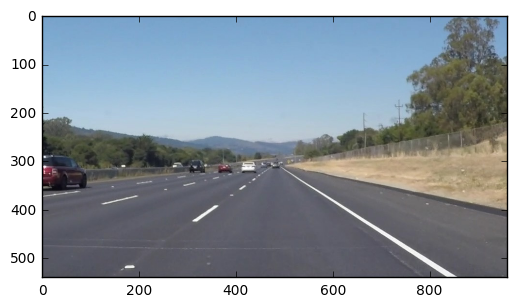

In [4]:
# Plot the image
plt.imshow(image)  #call as plt.imshow(gray, cmap='gray') to show a grayscaled image

In [5]:
# Display image in gray scale:
from PIL import Image
image2 = Image.open('test_images/solidWhiteRight.jpg').convert("L")
type(image2)  # image2 is in PIL format

PIL.Image.Image

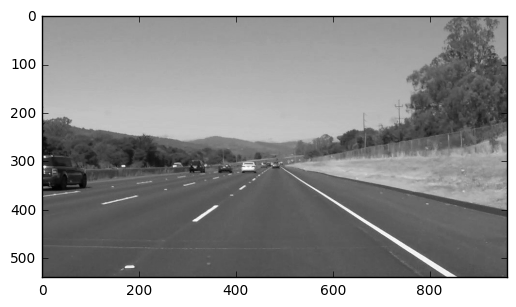

In [6]:
plt.imshow(image2, cmap='gray')
plt.show()

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [7]:
cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

array([[198, 163, 160, ..., 159, 163, 198],
       [163, 169, 164, ..., 164, 163, 165],
       [161, 164, 164, ..., 162, 163, 157],
       ..., 
       [122,  93,  85, ...,  90,  96, 122],
       [140, 107,  91, ...,  99, 111, 141],
       [182, 142, 119, ..., 123, 141, 180]], dtype=uint8)

In [154]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=3):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img
    

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [165]:
def intersection_x(coef1, intercept1, coef2, intercept2):
    """Returns x-coordinate of intersection of two lines."""
    x = (intercept2-intercept1)/(coef1-coef2)
    return x

def draw_linear_regression_line(coef, intercept, intersection_x, img, imshape=[540,960], color=[255, 0, 0], thickness=2):
    
    # Get starting and ending points of regression line, ints.
    print("Coef: ", coef, "Intercept: ", intercept, 
          "intersection_x: ", intersection_x)
    point_one = (int(intersection_x), int(intersection_x * coef + intercept))
    if coef > 0:
        point_two = (imshape[1], int(imshape[1] * coef + intercept))
    elif coef < 0:
        point_two = (0, int(0 * coef + intercept))
    print("Point one: ", point_one, "Point two: ", point_two)
    
    # Draw line using cv2.line
    cv2.line(img, point_one, point_two, color, thickness)
    
def find_line_fit(slope_intercept):
    """slope_intercept is an array [[slope, intercept], [slope, intercept]...]."""

    # Initialise arrays
    kept_slopes = []
    kept_intercepts = []
    print("Slope & intercept: ", slope_intercept)
    if len(slope_intercept) == 1:
        return slope_intercept[0][0], slope_intercept[0][1]

    # Remove points with slope not within 1.5 standard deviations of the mean
    slopes = [pair[0] for pair in slope_intercept]
    mean_slope = np.mean(slopes)
    slope_std = np.std(slopes)
    for pair in slope_intercept:
        slope = pair[0]
        if slope - mean_slope < 1.5 * slope_std:
            kept_slopes.append(slope)
            kept_intercepts.append(pair[1])
    if not kept_slopes:
        kept_slopes = slopes
        kept_intercepts = [pair[1] for pair in slope_intercept]
    # Take estimate of slope, intercept to be the mean of remaining values
    slope = np.mean(kept_slopes)
    intercept = np.mean(kept_intercepts)
    print("Slope: ", slope, "Intercept: ", intercept)
    return slope, intercept

In [166]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    # Image parameters (hard-coded. TODO: Make not hard-coded.)
    imshape = [540, 960]
    
    # Initialise arrays
    positive_slope_points = []
    negative_slope_points = []
    positive_slope_intercept = []
    negative_slope_intercept = []
    
    # for every line in the image, calculate lenght and slope. 
    for line in lines:
        for x1,y1,x2,y2 in line:            
            slope = (y1-y2)/(x1-x2)
            # print("Points: ", [x1, y1, x2, y2])
            length = math.sqrt((x1-x2)**2 + (y1-y2)**2)
            # print("Length: ", length)
            if not math.isnan(slope):
                if length > 50:
                    if slope > 0:
                        positive_slope_points.append([x1, y1])
                        positive_slope_points.append([x2, y2])
                        positive_slope_intercept.append([slope, y1-slope*x1])
                    elif slope < 0:
                        negative_slope_points.append([x1, y1])
                        negative_slope_points.append([x2, y2])
                        negative_slope_intercept.append([slope, y1-slope*x1])
        
    # If either array is empty, waive length requirement
    if not positive_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope > 0:
                    positive_slope_points.append([x1, y1])
                    positive_slope_points.append([x2, y2])
                    positive_slope_intercept.append([slope, y1-slope*x1])
    if not negative_slope_points:
        for line in lines:
            for x1,y1,x2,y2 in line:            
                slope = (y1-y2)/(x1-x2)
                if slope < 0:
                    negative_slope_points.append([x1, y1])
                    negative_slope_points.append([x2, y2])
                    negative_slope_intercept.append([slope, y1-slope*x1])
    if not positive_slope_points:
        print("positive_slope_points still empty")
    if not negative_slope_points:
        print("negative_slope_points still empty")
    # Even though positive_slope_points is not used, I am keeping it for debugging purposes.
    positive_slope_points = np.array(positive_slope_points)
    negative_slope_points = np.array(negative_slope_points)
    # print("Positive slope line points: ", positive_slope_points)
    # print("Negative slope line points: ", negative_slope_points)
    # print("positive slope points dtype: ", positive_slope_points.dtype)

    # Get intercept and coefficient of fitted lines
    pos_coef, pos_intercept = find_line_fit(positive_slope_intercept)
    neg_coef, neg_intercept = find_line_fit(negative_slope_intercept)

    # Get intersection point
    intersection_x_coord = intersection_x(pos_coef, pos_intercept, neg_coef, neg_intercept)
    
    # Plot lines
    draw_linear_regression_line(pos_coef, pos_intercept, intersection_x_coord, img)
    draw_linear_regression_line(neg_coef, neg_intercept, intersection_x_coord, img)

## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [167]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

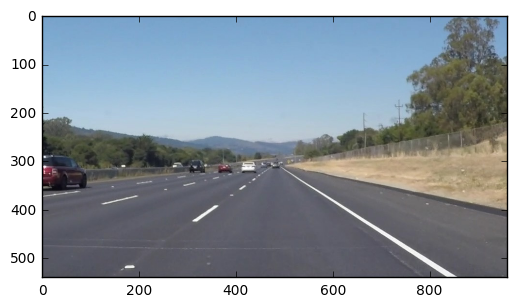

In [202]:
image1 = mpimg.imread('test_images/solidWhiteRight.jpg')
plt.imshow(image1)

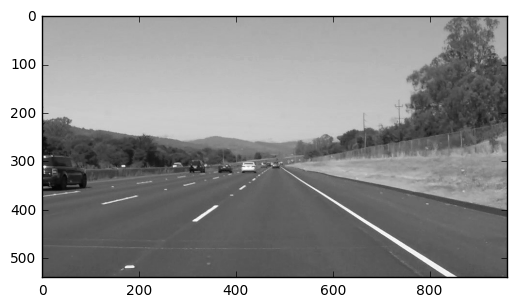

In [169]:
# Grayscale
image1g = grayscale(image1)
plt.imshow(image1g,cmap='gray')

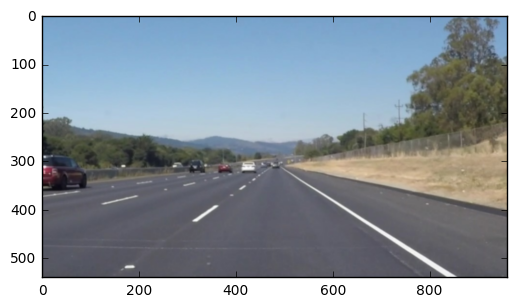

In [178]:
# Apply Gaussian smoothing
image1g = gaussian_blur(image1,5)
plt.imshow(image1gb,cmap='gray')

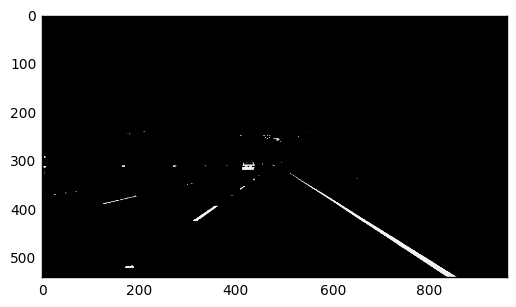

In [187]:
# Apply Color Selection
image1c = np.copy(image1)
red_threshold = 190
green_threshold = 190
blue_threshold = 190
rgb_threshold = [red_threshold, green_threshold, blue_threshold]
# Use a "bitwise OR" to identify pixels below the threshold 
thresholds = (image[:,:,0] < rgb_threshold[0])| (image[:,:,1] < rgb_threshold[1]) | (image[:,:,2] < rgb_threshold[2]) 
image1c[thresholds] = [0,0,0] 
# Display the image 
plt.imshow(image1c)

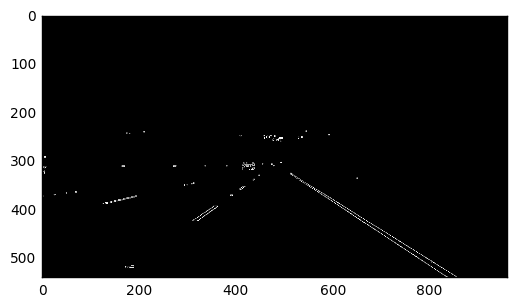

In [188]:
# Apply Canny Edge Detection
image1ce = canny(image1c, 50, 160)
plt.imshow(image1ce,cmap='gray')    

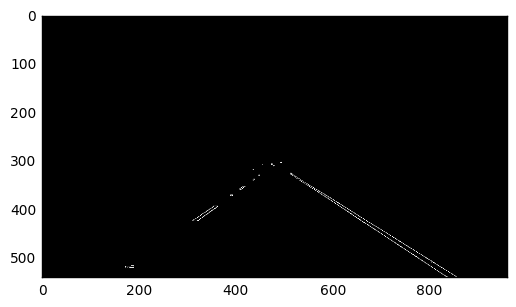

In [189]:
# Define region of interest
vertices = np.array([[(0,imshape[0]),(480, 295), (480, 295), (imshape[1],imshape[0])]], dtype=np.int32)
image1cev = region_of_interest(image1ce, vertices)
plt.imshow(image1cev,cmap='gray')    

Slope & intercept:  [[0.6228070175438597, 6.7456140350876694], [0.65123456790123457, -5.4320987654321016], [0.6470588235294118, -0.64705882352944855]]
Slope:  0.640366802992 Intercept:  0.222152148709
Slope & intercept:  [[-0.72784810126582278, 656.91139240506322], [-0.67391304347826086, 631.91304347826087]]
Slope:  -0.700880572372 Intercept:  644.412217942
Coef:  0.640366802992 Intercept:  0.222152148709 intersection_x:  480.291762449
Point one:  (480, 307) Point two:  (960, 614)
Coef:  -0.700880572372 Intercept:  644.412217942 intersection_x:  480.291762449
Point one:  (480, 307) Point two:  (0, 644)


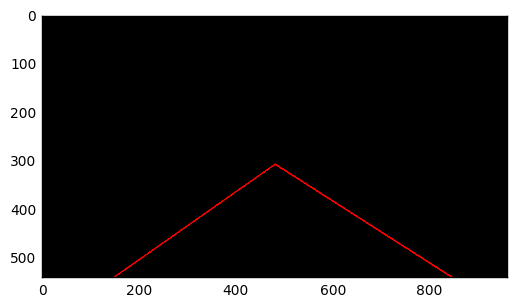

In [198]:
# Apply Hough Transform and draw lines 
rho = 1 
theta = np.pi/180 
threshold = 40
min_line_len  = 30 
max_line_gap = 80
line_image = np.copy(image1cev)*0 # creating a blank to draw lines on
image1cevh =  hough_lines(image1cev, rho, theta, threshold, min_line_len, max_line_gap)

plt.imshow(image1cevh,cmap='gray')    

In [200]:
hough_rgb_image = cv2.cvtColor(image1cevh, cv2.COLOR_GRAY2BGR)
plt.imshow(hough_rgb_image)    

error: /Users/jenkins/miniconda/1/x64/conda-bld/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7484: error: (-215) scn == 1 && (dcn == 3 || dcn == 4) in function ipp_cvtColor


In [122]:
#draw_lines(image1, lines, color=[255, 0, 0], thickness=2)

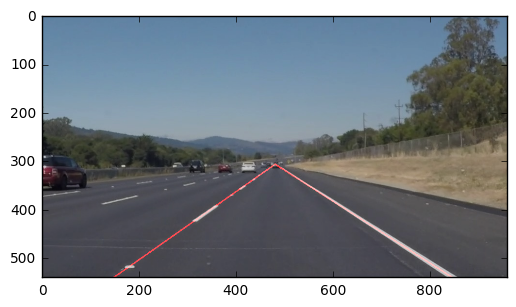

In [203]:
# Combine lines image with original image
image1cevhw = weighted_img(image1cevh, image1)
plt.imshow(image1cevhw,cmap='gray')   

## Build the pipeline to test code on test_images

Run your solution on all test_images and make copies into the test_images directory).
### Pipeline:
1. Convert to Grayscale
2. Gaussian Smoothing 
3. ~~Color Selection.~~
3. Region Masking
4. Canny Edge Detection.
5. Hough Transform & Draw Lines
6. Combine line image with original image.

In [257]:
# Pipeline
def draw_lanes(image):
    plt.imshow(image)
    imshape = image.shape
    
    # convert to Grayscale
    image_gray = grayscale(image)
    plt.subplot(2,2,1)
    plt.imshow(image_gray,cmap='gray')
    
    # Apply Gaussian smoothing
    kernel_size = 5
    image_gray_blur = gaussian_blur(image_gray,kernel_size)
    #plt.imshow(image_gray_blur,cmap='gray')
    
    # Apply Canny Edge Detection
    image_edges = canny(image_gray_blur, 50, 150)
    #plt.imshow(image_edges,cmap='gray')   
    
    # Define region of interest
    vertices = np.array([[(0,imshape[0]),(480, 295), (480, 295), (imshape[1],imshape[0])]], dtype=np.int32)
    image_edges_with_mask = region_of_interest(image_edges, vertices)
    plt.subplot(2,2,2)    
    plt.imshow(image_edges_with_mask,cmap='gray')  
    

    # Apply Hough Transform and draw lines 
    rho = 1 
    theta = np.pi/180 
    threshold = 40  # minimum number of votes (intersections in Hough grid cell)
    min_line_len  = 30   #minimum number of pixels making up a line
    max_line_gap = 80    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image1cev)*0 # creating a blank to draw lines on. (Do I need this?)
    lines_image =  hough_lines(image_edges_with_mask, rho, theta, threshold, min_line_len, max_line_gap)

    plt.subplot(2,2,3)
    plt.imshow(lines_image,cmap='gray')    
    
    # Combine lines image with original image
    final_image = weighted_img(lines_image, image)
    plt.subplot(2,2,4)
    plt.imshow(final_image,cmap='gray')  
    return final_image

In [210]:
# Read and save test images to array
test_images = [mpimg.imread('test_images/' + i) for i in os.listdir('test_images/')]

### Image #0:

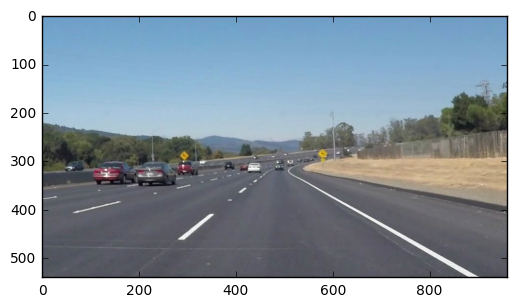

In [232]:
plt.imshow(test_images[0])

Slope & intercept:  [[0.57614213197969544, 32.723350253807098], [0.55282555282555279, 42.115479115479161], [0.55447941888619856, 40.077481840193684], [0.57817109144542778, 30.696165191740363]]
Slope:  0.565404548784 Intercept:  36.4031191003
Slope & intercept:  [[-0.80701754385964908, 687.96491228070181], [-0.83854166666666663, 706.85416666666663], [-0.72946859903381644, 664.25120772946866], [-0.83870967741935487, 708.61290322580646], [-0.80710659898477155, 697.06091370558374]]
Slope:  -0.822843871733 Intercept:  700.12322397
Coef:  0.565404548784 Intercept:  36.4031191003 intersection_x:  478.098944728
Point one:  (478, 306) Point two:  (960, 579)
Coef:  -0.822843871733 Intercept:  700.12322397 intersection_x:  478.098944728
Point one:  (478, 306) Point two:  (0, 700)


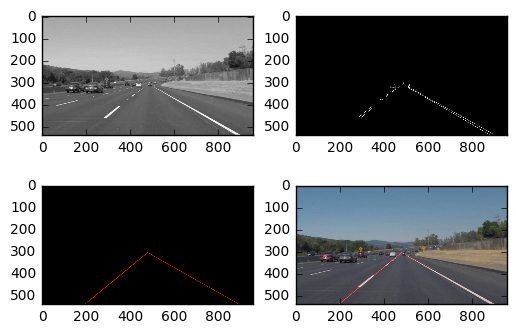

In [233]:
draw_lanes(test_images[0])

### Image #1:

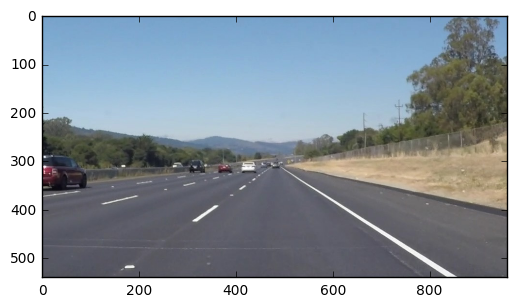

In [234]:
plt.imshow(test_images[1])

Slope & intercept:  [[0.62466487935656834, 6.1608579088472197], [0.62365591397849462, 5.3978494623655706], [0.65034965034965031, -4.2657342657342383], [0.65306122448979587, -5.346938775510182], [0.6253369272237197, 5.2129380053908108]]
Slope:  0.63541371908 Intercept:  1.43179446707
Slope & intercept:  [[-0.67222222222222228, 631.38888888888891], [-0.70285714285714285, 649.21142857142854], [-0.75316455696202533, 664.50632911392404], [-0.67164179104477617, 632.44776119402991], [-0.67455621301775148, 631.11242603550295]]
Slope:  -0.694888385221 Intercept:  641.733366761
Coef:  0.63541371908 Intercept:  1.43179446707 intersection_x:  481.320423552
Point one:  (481, 307) Point two:  (960, 611)
Coef:  -0.694888385221 Intercept:  641.733366761 intersection_x:  481.320423552
Point one:  (481, 307) Point two:  (0, 641)


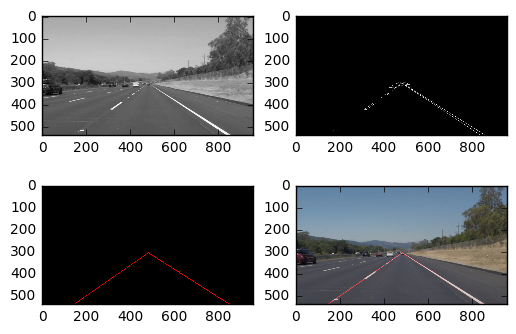

In [235]:
draw_lanes(test_images[1])

### Image #2:

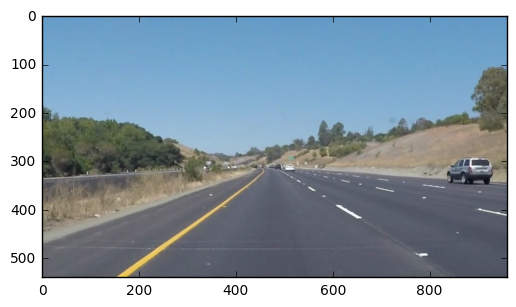

In [236]:
plt.imshow(test_images[2])

Slope & intercept:  [[0.60106382978723405, 22.5], [0.59090909090909094, 35.5], [0.60106382978723405, 23.101063829787222], [0.59999999999999998, 27.800000000000011], [0.62365591397849462, 13.623655913978496]]
Slope:  0.598259187621 Intercept:  27.2252659574
Slope & intercept:  [[-0.70125786163522008, 645.99371069182394], [-0.75, 670.25], [-0.69908814589665658, 646.35866261398178], [-0.74809160305343514, 668.91603053435119], [-0.75384615384615383, 672.18461538461543]]
Slope:  -0.730456752886 Intercept:  660.740603845
Coef:  0.598259187621 Intercept:  27.2252659574 intersection_x:  476.787640288
Point one:  (476, 312) Point two:  (960, 601)
Coef:  -0.730456752886 Intercept:  660.740603845 intersection_x:  476.787640288
Point one:  (476, 312) Point two:  (0, 660)


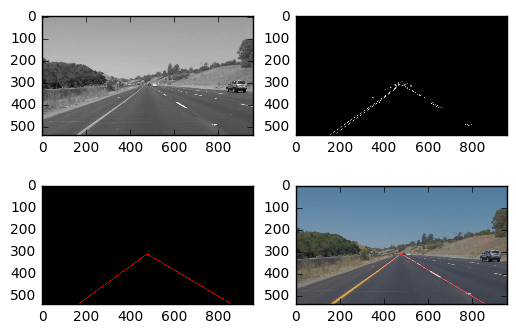

In [237]:
draw_lanes(test_images[2])

### Image #3:

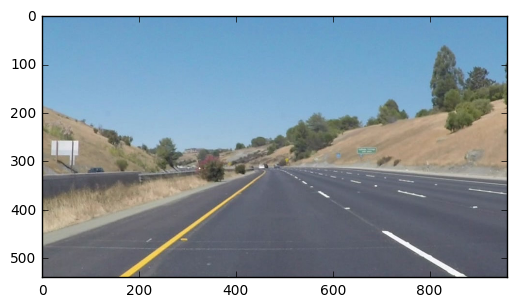

In [238]:
plt.imshow(test_images[3])

Slope & intercept:  [[0.57635467980295563, 34.266009852216769], [0.60264900662251653, 25.145695364238406], [0.60264900662251653, 24.543046357615935], [0.57792207792207795, 32.318181818181813], [0.59832635983263593, 20.188284518828482], [0.57668711656441718, 34.97546012269936], [0.59999999999999998, 23.800000000000011]]
Slope:  0.59065546391 Intercept:  27.8909540048
Slope & intercept:  [[-0.72615384615384615, 654.18461538461543], [-0.75494071146245056, 671.67588932806325], [-0.75806451612903225, 673.69354838709683], [-0.72388059701492535, 654.73880597014931], [-0.75367647058823528, 672.05514705882354], [-0.014084507042253521, 321.2957746478873]]
Slope:  -0.74334322827 Intercept:  665.269601226
Coef:  0.59065546391 Intercept:  27.8909540048 intersection_x:  477.795556291
Point one:  (477, 310) Point two:  (960, 594)
Coef:  -0.74334322827 Intercept:  665.269601226 intersection_x:  477.795556291
Point one:  (477, 310) Point two:  (0, 665)


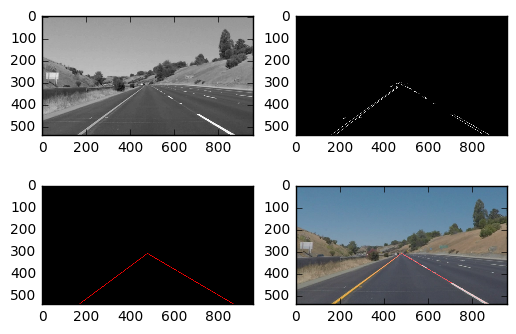

In [239]:
draw_lanes(test_images[3])

### Image #4:

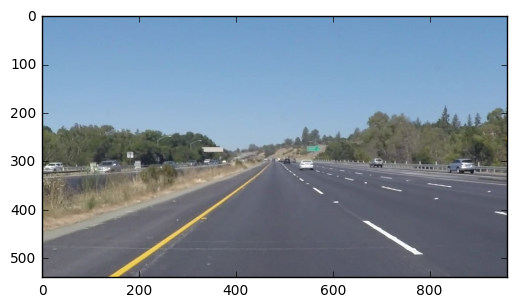

In [241]:
plt.imshow(test_images[4])

Slope & intercept:  [[0.64965986394557829, -5.2891156462585514], [0.6237942122186495, 3.9453376205788118], [0.62459546925566345, 5.1909385113268627], [0.65079365079365081, -7.4603174603174693], [0.69696969696969702, -35.545454545454561]]
Slope:  0.637210799053 Intercept:  -0.903289243668
Slope & intercept:  [[-0.69306930693069302, 636.30693069306926], [-0.72619047619047616, 654.25], [-0.69736842105263153, 638.22368421052624], [-0.69230769230769229, 634.53846153846155], [-0.70129870129870131, 638.72727272727275], [-0.72727272727272729, 653.90909090909088], [-0.69333333333333336, 635.72000000000003]]
Slope:  -0.704405808341 Intercept:  641.667920011
Coef:  0.637210799053 Intercept:  -0.903289243668 intersection_x:  478.952933136
Point one:  (478, 304) Point two:  (960, 610)
Coef:  -0.704405808341 Intercept:  641.667920011 intersection_x:  478.952933136
Point one:  (478, 304) Point two:  (0, 641)


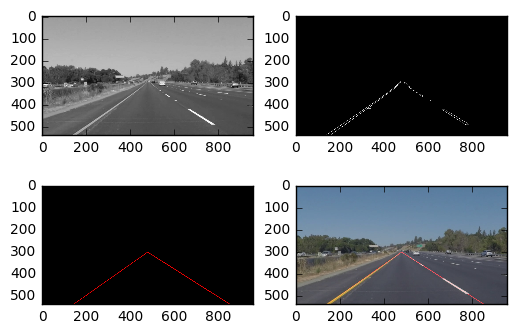

In [242]:
draw_lanes(test_images[4])

### Image #5:

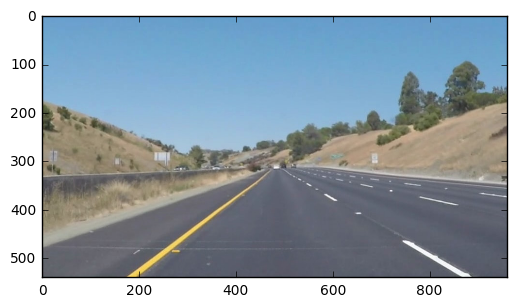

In [243]:
plt.imshow(test_images[5])

Slope & intercept:  [[0.5572519083969466, 45.389312977099223], [0.59999999999999998, 21.199999999999989], [0.62195121951219512, 7.84146341463412], [0.53333333333333333, 56.599999999999994], [0.55223880597014929, 50.373134328358162], [0.6166666666666667, 12.0]]
Slope:  0.580240322313 Intercept:  32.23398512
Slope & intercept:  [[-0.77891156462585032, 689.10884353741494], [-0.75257731958762886, 671.45360824742261], [-0.74842767295597479, 670.98742138364776], [-0.78245614035087718, 691.57894736842104], [-0.36752136752136755, 488.30769230769232], [-0.75384615384615383, 675.12307692307695], [-0.75423728813559321, 672.49152542372883]]
Slope:  -0.761742689917 Intercept:  678.457237147
Coef:  0.580240322313 Intercept:  32.23398512 intersection_x:  481.543541265
Point one:  (481, 311) Point two:  (960, 589)
Coef:  -0.761742689917 Intercept:  678.457237147 intersection_x:  481.543541265
Point one:  (481, 311) Point two:  (0, 678)


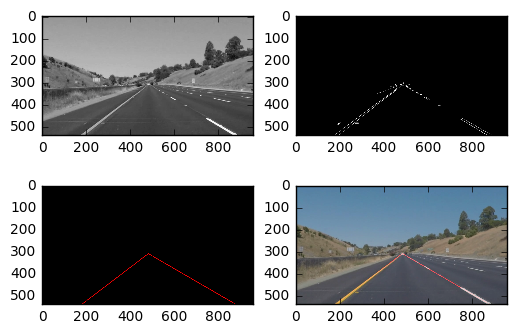

In [244]:
draw_lanes(test_images[5])

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [254]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [255]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = draw_lanes(image)
    
    return result

Let's try the one with the solid white lane on the right first ...

Slope & intercept:  [[0.64948453608247425, -9.7010309278350633], [0.64819944598337953, -10.02493074792244], [0.60066006600660071, 16.026402640263996], [0.59999999999999998, 16.0], [0.62841530054644812, 3.6174863387977894], [0.62672811059907829, 5.6635944700461209], [0.60476190476190472, 11.876190476190516]]
Slope:  0.622607051997 Intercept:  4.77967317851
Slope & intercept:  [[-0.72822299651567945, 649.17770034843204], [-0.75268817204301075, 666.04301075268813], [-0.72569444444444442, 649.70486111111109], [-0.72514619883040932, 647.60233918128654], [-0.75543478260869568, 665.85326086956525]]
Slope:  -0.737437318888 Intercept:  655.676234453
Coef:  0.622607051997 Intercept:  4.77967317851 intersection_x:  478.584798561
Point one:  (478, 302) Point two:  (960, 602)
Coef:  -0.737437318888 Intercept:  655.676234453 intersection_x:  478.584798561
Point one:  (478, 302) Point two:  (0, 655)
[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


  0%|          | 1/222 [00:00<00:25,  8.81it/s]

Slope & intercept:  [[0.64948453608247425, -9.7010309278350633], [0.64819944598337953, -10.02493074792244], [0.60066006600660071, 16.026402640263996], [0.59999999999999998, 16.0], [0.62841530054644812, 3.6174863387977894], [0.62672811059907829, 5.6635944700461209], [0.60476190476190472, 11.876190476190516]]
Slope:  0.622607051997 Intercept:  4.77967317851
Slope & intercept:  [[-0.72822299651567945, 649.17770034843204], [-0.75268817204301075, 666.04301075268813], [-0.72569444444444442, 649.70486111111109], [-0.72514619883040932, 647.60233918128654], [-0.75543478260869568, 665.85326086956525]]
Slope:  -0.737437318888 Intercept:  655.676234453
Coef:  0.622607051997 Intercept:  4.77967317851 intersection_x:  478.584798561
Point one:  (478, 302) Point two:  (960, 602)
Coef:  -0.737437318888 Intercept:  655.676234453 intersection_x:  478.584798561
Point one:  (478, 302) Point two:  (0, 655)
Slope & intercept:  [[0.64954682779456197, -9.483383685800618], [0.60233918128654973, 15.1695906432748

  2%|▏         | 4/222 [00:00<00:26,  8.36it/s]

Slope & intercept:  [[0.60256410256410253, 14.576923076923094], [0.62544169611307421, 7.0388692579505232], [0.62931034482758619, 4.6206896551724412], [0.62564102564102564, 5.9384615384615245], [0.62295081967213117, 10.983606557377016], [0.60588235294117643, 13.094117647058852], [0.61702127659574468, 15.276595744680833]]
Slope:  0.618401659765 Intercept:  10.2184662111
Slope & intercept:  [[-0.75555555555555554, 666.20000000000005], [-0.72448979591836737, 647.39795918367349], [-0.75555555555555554, 667.20000000000005], [-0.72602739726027399, 650.67123287671234], [-0.72602739726027399, 654.57534246575347], [-0.72727272727272729, 649.36363636363637]]
Slope:  -0.735821404804 Intercept:  655.901361815
Coef:  0.618401659765 Intercept:  10.2184662111 intersection_x:  476.792127159
Point one:  (476, 305) Point two:  (960, 603)
Coef:  -0.735821404804 Intercept:  655.901361815 intersection_x:  476.792127159
Point one:  (476, 305) Point two:  (0, 655)
Slope & intercept:  [[0.60322580645161294, 13

  2%|▏         | 5/222 [00:00<00:29,  7.25it/s]

Slope & intercept:  [[0.60305343511450382, 13.343511450381698], [0.624, 8.2239999999999895], [0.62809917355371903, 4.1404958677686068], [0.60154241645244211, 15.658097686375356], [0.62601626016260159, 7.138211382113866]]
Slope:  0.616542257057 Intercept:  9.70086327733
Slope & intercept:  [[-0.72727272727272729, 655.90909090909088], [-0.72727272727272729, 650.81818181818176], [-0.70454545454545459, 644.11363636363637], [-0.69999999999999996, 639.79999999999995]]
Slope:  -0.714772727273 Intercept:  647.660227273
Coef:  0.616542257057 Intercept:  9.70086327733 intersection_x:  479.194909923
Point one:  (479, 305) Point two:  (960, 601)
Coef:  -0.714772727273 Intercept:  647.660227273 intersection_x:  479.194909923
Point one:  (479, 305) Point two:  (0, 647)


  3%|▎         | 6/222 [00:00<00:35,  6.14it/s]

Slope & intercept:  [[0.59846547314578002, 17.33503836317135], [0.62452107279693492, 6.4789272030650977], [0.62460567823343849, 7.5615141955835838], [0.62365591397849462, 9.1397849462365457], [0.60139860139860135, 14.132867132867148]]
Slope:  0.614529347911 Intercept:  10.9296263682
Slope & intercept:  [[-0.70161290322580649, 638.87903225806451], [-0.72448979591836737, 653.82653061224494], [-0.69801980198019797, 638.53960396039599]]
Slope:  -0.708040833708 Intercept:  643.748388944
Coef:  0.614529347911 Intercept:  10.9296263682 intersection_x:  478.47650837
Point one:  (478, 304) Point two:  (960, 600)
Coef:  -0.708040833708 Intercept:  643.748388944 intersection_x:  478.47650837
Point one:  (478, 304) Point two:  (0, 643)
Slope & intercept:  [[0.59999999999999998, 16.0], [0.62538699690402477, 6.3157894736842195], [0.60152284263959388, 14.073604060913738], [0.62637362637362637, 6.20879120879124]]
Slope:  0.613320866479 Intercept:  10.6495461858
Slope & intercept:  [[-0.701388888888888

  4%|▍         | 9/222 [00:01<00:27,  7.72it/s]

Slope & intercept:  [[0.60253164556962024, 13.592405063291153], [0.62534435261707988, 5.5840220385675252], [0.62334217506631295, 8.1591511936339884], [0.599290780141844, 16.939716312056703], [0.61818181818181817, -1.0545454545454618], [0.624, 6.9759999999999991]]
Slope:  0.615448461929 Intercept:  8.36612485883
Slope & intercept:  [[-0.70253164556962022, 640.02531645569616], [-0.72435897435897434, 652.76282051282055], [-0.72727272727272729, 655.63636363636363]]
Slope:  -0.718054449067 Intercept:  649.474833535
Coef:  0.615448461929 Intercept:  8.36612485883 intersection_x:  480.770385568
Point one:  (480, 304) Point two:  (960, 599)
Coef:  -0.718054449067 Intercept:  649.474833535 intersection_x:  480.770385568
Point one:  (480, 304) Point two:  (0, 649)
Slope & intercept:  [[0.60152284263959388, 14.073604060913738], [0.6258278145695364, 6.3576158940397249], [0.625, 7.375], [0.59948979591836737, 16.844387755102048], [0.62831858407079644, 4.1504424778761404]]
Slope:  0.61603180744 Inter

  5%|▍         | 11/222 [00:01<00:26,  8.01it/s]

Slope & intercept:  [[0.59948320413436695, 18.847545219638221], [0.62753036437246967, 8.3643724696356117], [0.62666666666666671, 7.9599999999999795], [0.60052219321148825, 19.548302872062663], [0.60493827160493829, 14.444444444444457], [0.62637362637362637, 8.5714285714285552], [0.62773722627737227, 8.8175182481751904]]
Slope:  0.616178793234 Intercept:  12.3648016893
Slope & intercept:  [[-0.69897959183673475, 641.00510204081638], [-0.72395833333333337, 656.015625], [-0.7010309278350515, 640.59793814432987]]
Slope:  -0.707989617668 Intercept:  645.872888395
Coef:  0.616178793234 Intercept:  12.3648016893 intersection_x:  478.419573741
Point one:  (478, 307) Point two:  (960, 603)
Coef:  -0.707989617668 Intercept:  645.872888395 intersection_x:  478.419573741
Point one:  (478, 307) Point two:  (0, 645)
Slope & intercept:  [[0.60263157894736841, 19.339473684210532], [0.62765957446808507, 12.021276595744723], [0.60076045627376429, 21.346007604562715], [0.62886597938144329, 10.16494845360

  6%|▌         | 13/222 [00:01<00:26,  7.95it/s]

Slope & intercept:  [[0.64963503649635035, -1.7226277372262757], [0.62256809338521402, 8.1867704280155635], [0.64825581395348841, -1.4040697674418539], [0.62430939226519333, 8.104972375690636], [0.61682242990654201, 11.943925233644904], [0.61538461538461542, 12.53846153846149], [0.61111111111111116, 14.888888888888857], [0.64130434782608692, 3.152173913043498]]
Slope:  0.628673855041 Intercept:  6.96106185913
Slope & intercept:  [[-0.69999999999999996, 643.0], [-0.72580645161290325, 658.4677419354839], [-0.70204081632653059, 643.17142857142858], [-0.72540983606557374, 659.54918032786884]]
Slope:  -0.713314276001 Intercept:  651.047087709
Coef:  0.628673855041 Intercept:  6.96106185913 intersection_x:  479.949122463
Point one:  (479, 308) Point two:  (960, 610)
Coef:  -0.713314276001 Intercept:  651.047087709 intersection_x:  479.949122463
Point one:  (479, 308) Point two:  (0, 651)
Slope & intercept:  [[0.65129682997118155, -3.5302593659942545], [0.62247838616714701, 7.3631123919308266

  7%|▋         | 15/222 [00:01<00:25,  8.18it/s]

Slope & intercept:  [[0.62385321100917435, 5.6055045871559628], [0.6224188790560472, 7.2389380530973426], [0.64903846153846156, -2.6490384615384528], [0.64819944598337953, -2.3019390581717403], [0.64827586206896548, -3.875862068965489], [0.62536873156342188, 4.4424778761061816]]
Slope:  0.63619243187 Intercept:  1.41001348795
Slope & intercept:  [[-0.69817073170731703, 639.23475609756099], [-0.72615384615384615, 656.36307692307696], [-0.70090634441087618, 638.93051359516619], [-0.72953736654804269, 656.28469750889678], [-0.72839506172839508, 657.45679012345681]]
Slope:  -0.71663267011 Intercept:  649.65396685
Coef:  0.63619243187 Intercept:  1.41001348795 intersection_x:  479.177945777
Point one:  (479, 306) Point two:  (960, 612)
Coef:  -0.71663267011 Intercept:  649.65396685 intersection_x:  479.177945777
Point one:  (479, 306) Point two:  (0, 649)
Slope & intercept:  [[0.625, 3.375], [0.65296803652968038, -7.2283105022831364], [0.65497076023391809, -9.0409356725145926], [0.622807017

  8%|▊         | 17/222 [00:02<00:23,  8.70it/s]

Slope & intercept:  [[0.62368421052631584, 3.2552631578947171], [0.67132867132867136, -20.909090909090935], [0.62658227848101267, -0.025316455696213325], [0.67313915857605178, -23.126213592233], [0.67149758454106279, -20.318840579710127], [0.66176470588235292, -13.970588235294088], [0.66942148760330578, -20.636363636363626], [0.62463343108504399, 1.4398826979472119]]
Slope:  0.652756441003 Intercept:  -11.7864084441
Slope & intercept:  [[-0.71875, 650.84375], [-0.6967741935483871, 634.66451612903222], [-0.69999999999999996, 635.60000000000002], [-0.72435897435897434, 651.03846153846155], [-0.70149253731343286, 634.80597014925377]]
Slope:  -0.708275141044 Intercept:  641.390539563
Coef:  0.652756441003 Intercept:  -11.7864084441 intersection_x:  479.913145752
Point one:  (479, 301) Point two:  (960, 614)
Coef:  -0.708275141044 Intercept:  641.390539563 intersection_x:  479.913145752
Point one:  (479, 301) Point two:  (0, 641)
Slope & intercept:  [[0.62269129287598945, 2.4854881266490452

  9%|▊         | 19/222 [00:02<00:23,  8.57it/s]

Slope & intercept:  [[0.62362637362637363, 3.5521978021977816], [0.65000000000000002, -7.4499999999999886], [0.62603878116343492, 0.85872576177285964], [0.65217391304347827, -7.826086956521749], [0.65254237288135597, -7.5254237288135641], [0.62809917355371903, 0.71900826446278643]]
Slope:  0.638746769045 Intercept:  -2.94526314282
Slope & intercept:  [[-0.72538860103626945, 652.26424870466326], [-0.70370370370370372, 637.14814814814815], [-0.70157068062827221, 637.54450261780107], [-0.72677595628415304, 651.21857923497271]]
Slope:  -0.714359735413 Intercept:  644.543869676
Coef:  0.638746769045 Intercept:  -2.94526314282 intersection_x:  478.520449563
Point one:  (478, 302) Point two:  (960, 610)
Coef:  -0.714359735413 Intercept:  644.543869676 intersection_x:  478.520449563
Point one:  (478, 302) Point two:  (0, 644)
Slope & intercept:  [[0.624, 3.8559999999999945], [0.64888888888888885, -5.5733333333333235], [0.65497076023391809, -8.6608187134502828], [0.62465753424657533, 2.91506849

  9%|▉         | 21/222 [00:02<00:23,  8.47it/s]

Slope & intercept:  [[0.65000000000000002, -5.1000000000000227], [0.62466487935656834, 4.5361930294906188], [0.65116279069767447, -5.0], [0.65555555555555556, -7.4222222222222172], [0.62637362637362637, 2.4505494505494312], [0.64885496183206104, -5.3435114503816408]]
Slope:  0.642768635636 Intercept:  -2.64649853209
Slope & intercept:  [[-0.72368421052631582, 654.43421052631584], [-0.69934640522875813, 639.9869281045751], [-0.69999999999999996, 639.20000000000005]]
Slope:  -0.707676871918 Intercept:  644.540379544
Coef:  0.642768635636 Intercept:  -2.64649853209 intersection_x:  479.239535735
Point one:  (479, 305) Point two:  (960, 614)
Coef:  -0.707676871918 Intercept:  644.540379544 intersection_x:  479.239535735
Point one:  (479, 305) Point two:  (0, 644)
Slope & intercept:  [[0.62464985994397759, 4.5490196078431495], [0.65189873417721522, -5.0], [0.65284974093264247, -5.1709844559585463], [0.62466487935656834, 6.1608579088472197], [0.65161290322580645, -5.8645161290322676]]
Slope:

 10%|█         | 23/222 [00:02<00:22,  8.78it/s]

Slope & intercept:  [[0.62299465240641716, 6.9625668449197633], [0.65000000000000002, -3.4499999999999886], [0.62432432432432428, 5.4513513513513772], [0.64968152866242035, -4.5987261146496508], [0.64968152866242035, -2.5350318471337232]]
Slope:  0.639336406811 Intercept:  0.366032046898
Slope & intercept:  [[-0.70053475935828879, 640.15508021390372], [-0.72727272727272729, 657.90909090909088], [-0.72340425531914898, 655.29787234042556], [-0.69841269841269837, 641.53968253968253]]
Slope:  -0.712406110091 Intercept:  648.725431501
Coef:  0.639336406811 Intercept:  0.366032046898 intersection_x:  479.647115739
Point one:  (479, 307) Point two:  (960, 614)
Coef:  -0.712406110091 Intercept:  648.725431501 intersection_x:  479.647115739
Point one:  (479, 307) Point two:  (0, 648)
Slope & intercept:  [[0.62466487935656834, 5.5361930294906188], [0.65096952908587258, -4.2576177285318408], [0.651685393258427, -5.8988764044943878], [0.65100671140939592, -3.6375838926174424], [0.62568306010928965

 11%|█▏        | 25/222 [00:03<00:21,  9.04it/s]

Slope & intercept:  [[0.62299465240641716, 5.9625668449197633], [0.65340909090909094, -6.2897727272727479], [0.65040650406504064, -4.6422764227642119], [0.62557077625570778, 3.474885844748826], [0.62368421052631584, 6.3736842105262781], [0.65030674846625769, -5.8957055214723937]]
Slope:  0.637728663771 Intercept:  -0.169436295219
Slope & intercept:  [[-0.72540983606557374, 656.0], [-0.69795918367346943, 638.92653061224496], [-0.72540983606557374, 656.72540983606564], [-0.69047619047619047, 636.19047619047615], [-0.69958847736625518, 640.30452674897117], [-0.72540983606557374, 655.27459016393436]]
Slope:  -0.710708893285 Intercept:  647.236922259
Coef:  0.637728663771 Intercept:  -0.169436295219 intersection_x:  480.115935043
Point one:  (480, 306) Point two:  (960, 612)
Coef:  -0.710708893285 Intercept:  647.236922259 intersection_x:  480.115935043
Point one:  (480, 306) Point two:  (0, 647)
Slope & intercept:  [[0.62368421052631584, 5.75], [0.62269129287598945, 5.5989445910290101], [0

 12%|█▏        | 27/222 [00:03<00:21,  8.92it/s]

Slope & intercept:  [[0.62745098039215685, 1.4117647058823763], [0.6243386243386243, 4.814814814814838], [0.6506024096385542, -5.7349397590361377], [0.65476190476190477, -7.8333333333333144], [0.6588235294117647, -9.8000000000000114], [0.62599469496021221, 3.0265251989389981]]
Slope:  0.640328690584 Intercept:  -2.35252806212
Slope & intercept:  [[-0.72477064220183485, 655.41284403669727], [-0.69801980198019797, 637.91089108910887], [-0.69841269841269837, 639.14285714285711], [-0.69999999999999996, 637.70000000000005], [-0.72560975609756095, 657.27439024390242]]
Slope:  -0.709362579738 Intercept:  645.488196503
Coef:  0.640328690584 Intercept:  -2.35252806212 intersection_x:  479.99178687
Point one:  (479, 304) Point two:  (960, 612)
Coef:  -0.709362579738 Intercept:  645.488196503 intersection_x:  479.99178687
Point one:  (479, 304) Point two:  (0, 645)
Slope & intercept:  [[0.62532981530343013, 3.3430079155672843], [0.6243386243386243, 4.814814814814838], [0.65090909090909088, -5.879

 13%|█▎        | 29/222 [00:03<00:21,  8.78it/s]

Slope & intercept:  [[0.62368421052631584, 4.75], [0.6518518518518519, -6.3259259259259579], [0.6506024096385542, -4.6024096385542066], [0.65116279069767447, -6.6511627906976969]]
Slope:  0.644325315679 Intercept:  -3.20737458879
Slope & intercept:  [[-0.75, 662.75], [-0.69841269841269837, 638.66666666666663], [-0.73154362416107388, 653.75167785234908], [-0.72784810126582278, 656.91772151898738], [-0.7533333333333333, 662.33999999999992], [-0.72881355932203384, 657.52542372881351], [-0.67105263157894735, 629.75]]
Slope:  -0.731658552749 Intercept:  655.325248294
Coef:  0.644325315679 Intercept:  -3.20737458879 intersection_x:  478.590365769
Point one:  (478, 305) Point two:  (960, 615)
Coef:  -0.731658552749 Intercept:  655.325248294 intersection_x:  478.590365769
Point one:  (478, 305) Point two:  (0, 655)
Slope & intercept:  [[0.62368421052631584, 4.75], [0.64984227129337535, -4.375394321766521], [0.6495726495726496, -3.74358974358978], [0.65193370165745856, -7.0165745856353396], [0.

 14%|█▍        | 31/222 [00:03<00:20,  9.12it/s]

Slope & intercept:  [[0.649171270718232, -4.0580110497237456], [0.62368421052631584, 4.1263157894736651], [0.65201465201465203, -7.0549450549450512], [0.62303664921465973, 5.6806282722512833], [0.65248226950354615, -6.1702127659575012], [0.63265306122448983, -1.571428571428612]]
Slope:  0.6388403522 Intercept:  -1.50794223005
Slope & intercept:  [[-0.7857142857142857, 678.42857142857144], [-0.67647058823529416, 631.79411764705878], [-0.67647058823529416, 632.47058823529414]]
Slope:  -0.712885154062 Intercept:  647.56442577
Coef:  0.6388403522 Intercept:  -1.50794223005 intersection_x:  480.180602492
Point one:  (480, 305) Point two:  (960, 611)
Coef:  -0.712885154062 Intercept:  647.56442577 intersection_x:  480.180602492
Point one:  (480, 305) Point two:  (0, 647)
Slope & intercept:  [[0.62565445026178013, 2.8141361256544428], [0.65013774104683197, -5.5151515151515014], [0.62467191601049865, 2.656167979002646], [0.65123456790123457, -6.685185185185162], [0.6223776223776224, 5.99300699

 14%|█▍        | 32/222 [00:03<00:21,  8.85it/s]

Slope & intercept:  [[0.62402088772845954, 3.5900783289817468], [0.64835164835164838, -4.6703296703296928], [0.64743589743589747, -9.8269230769230944], [0.65277777777777779, -8.4166666666666856], [0.64880952380952384, -11.428571428571445], [0.64948453608247425, -5.8556701030927911]]
Slope:  0.645146711864 Intercept:  -6.10134710277
Slope & intercept:  [[-0.67295597484276726, 630.72955974842762], [-0.69871794871794868, 637.48076923076928], [-0.75167785234899331, 663.81208053691273], [-0.6728395061728395, 629.69135802469134]]
Slope:  -0.699047820521 Intercept:  640.428441885
Coef:  0.645146711864 Intercept:  -6.10134710277 intersection_x:  480.979332538
Point one:  (480, 304) Point two:  (960, 613)
Coef:  -0.699047820521 Intercept:  640.428441885 intersection_x:  480.979332538
Point one:  (480, 304) Point two:  (0, 640)
Slope & intercept:  [[0.62277580071174377, 5.1814946619217039], [0.65096952908587258, -6.5595567867035811], [0.63095238095238093, -0.59523809523807358], [0.62402088772845

 15%|█▌        | 34/222 [00:04<00:24,  7.69it/s]

Slope & intercept:  [[0.64902506963788298, -4.5849582172701844], [0.62402088772845954, 3.5900783289817468], [0.65000000000000002, -6.1000000000000227], [0.62376237623762376, 5.3366336633663423], [0.65116279069767447, -5.372093023255843], [0.64743589743589747, -10.185897435897459]]
Slope:  0.64090117029 Intercept:  -2.88603944735
Slope & intercept:  [[-0.72486772486772488, 654.46031746031747], [-0.69565217391304346, 637.13043478260875], [-0.72826086956521741, 656.66304347826087], [-0.69892473118279574, 639.08602150537638]]
Slope:  -0.711926374882 Intercept:  646.834954307
Coef:  0.64090117029 Intercept:  -2.88603944735 intersection_x:  480.268897594
Point one:  (480, 304) Point two:  (960, 612)
Coef:  -0.711926374882 Intercept:  646.834954307 intersection_x:  480.268897594
Point one:  (480, 304) Point two:  (0, 646)
Slope & intercept:  [[0.648876404494382, -3.1629213483145691], [0.62368421052631584, 5.75], [0.62195121951219512, 6.2317073170731874], [0.649171270718232, -3.759668508287290

 16%|█▌        | 36/222 [00:04<00:27,  6.87it/s]

Slope & intercept:  [[0.64971751412429379, -3.5649717514124291], [0.62295081967213117, 7.0], [0.64940239043824699, -2.952191235059729], [0.6171875, 10.3046875], [0.64925373134328357, -3.8880597014925229], [0.62295081967213117, 7.6229508196720985], [0.62427745664739887, 5.4913294797687513]]
Slope:  0.633677175985 Intercept:  2.8591064445
Slope & intercept:  [[-0.72427983539094654, 656.89711934156378], [-0.69999999999999996, 640.89999999999998], [-0.69135802469135799, 637.46913580246917], [-0.72727272727272729, 656.90909090909088]]
Slope:  -0.710727646839 Intercept:  648.043836513
Coef:  0.633677175985 Intercept:  2.8591064445 intersection_x:  479.903611706
Point one:  (479, 306) Point two:  (960, 611)
Coef:  -0.710727646839 Intercept:  648.043836513 intersection_x:  479.903611706
Point one:  (479, 306) Point two:  (0, 648)
Slope & intercept:  [[0.65267175572519087, -4.6755725190839712], [0.62253521126760558, 6.8450704225352297], [0.648876404494382, -2.5140449438202381], [0.6245733788395

 17%|█▋        | 38/222 [00:04<00:24,  7.53it/s]

Slope & intercept:  [[0.62566844919786091, 4.6791443850267456], [0.65000000000000002, -3.6999999999999886], [0.6523605150214592, -4.4163090128755016], [0.65957446808510634, -10.574468085106332], [0.62962962962962965, 1.4074074074073906]]
Slope:  0.643446612387 Intercept:  -2.52084506111
Slope & intercept:  [[-0.70029673590504449, 640.94362017804156], [-0.75320512820512819, 664.78525641025635], [-0.70059880239520955, 641.98802395209577], [-0.72727272727272729, 655.90909090909088], [-0.70161290322580649, 640.4354838709678], [-0.75238095238095237, 662.89523809523814], [-0.75, 664.5]]
Slope:  -0.726481035626 Intercept:  653.065244774
Coef:  0.643446612387 Intercept:  -2.52084506111 intersection_x:  478.555265883
Point one:  (478, 305) Point two:  (960, 615)
Coef:  -0.726481035626 Intercept:  653.065244774 intersection_x:  478.555265883
Point one:  (478, 305) Point two:  (0, 653)
Slope & intercept:  [[0.625, 5.25], [0.65217391304347827, -5.6086956521739353], [0.65269461077844315, -4.6946107

 18%|█▊        | 40/222 [00:05<00:25,  7.19it/s]

Slope & intercept:  [[0.62432432432432428, 5.827027027027043], [0.65048543689320393, -4.5048543689320582], [0.62295081967213117, 5.3770491803278446], [0.65517241379310343, -8.0689655172413381], [0.64948453608247425, -6.0], [0.6333333333333333, -2.5], [0.65151515151515149, -4.0606060606060623]]
Slope:  0.641038002231 Intercept:  -1.99004996277
Slope & intercept:  [[-0.67123287671232879, 633.98630136986299], [-0.75384615384615383, 662.63076923076926], [-0.6706586826347305, 629.62275449101799], [-0.6706586826347305, 633.63473053892221], [-0.72413793103448276, 648.79310344827582]]
Slope:  -0.698106865372 Intercept:  641.733531816
Coef:  0.641038002231 Intercept:  -1.99004996277 intersection_x:  480.697493865
Point one:  (480, 306) Point two:  (960, 613)
Coef:  -0.698106865372 Intercept:  641.733531816 intersection_x:  480.697493865
Point one:  (480, 306) Point two:  (0, 641)
Slope & intercept:  [[0.62601626016260159, 3.7560975609756042], [0.65258215962441313, -6.3380281690140805], [0.65217

 19%|█▉        | 42/222 [00:05<00:26,  6.90it/s]

Slope & intercept:  [[0.62466487935656834, 3.9115281501340746], [0.67118644067796607, -19.169491525423723], [0.66666666666666663, -16.666666666666629], [0.64676616915422891, -10.034825870646785], [0.67326732673267331, -19.881188118811906]]
Slope:  0.656510296518 Intercept:  -12.3681288063
Slope & intercept:  [[-0.66911764705882348, 627.86764705882354], [-0.7767857142857143, 673.97321428571422], [-0.70256410256410251, 639.52820512820517]]
Slope:  -0.716155821303 Intercept:  647.123022158
Coef:  0.656510296518 Intercept:  -12.3681288063 intersection_x:  480.445421069
Point one:  (480, 303) Point two:  (960, 617)
Coef:  -0.716155821303 Intercept:  647.123022158 intersection_x:  480.445421069
Point one:  (480, 303) Point two:  (0, 647)
Slope & intercept:  [[0.64615384615384619, -10.384615384615415], [0.672463768115942, -20.45507246376809], [0.67153284671532842, -18.664233576642289], [0.65000000000000002, -11.75], [0.66666666666666663, -16.666666666666629], [0.65079365079365081, -16.7777777

 19%|█▉        | 43/222 [00:05<00:28,  6.22it/s]

 Point two:  (960, 616)
Coef:  -0.711803207873 Intercept:  644.361707422 intersection_x:  481.407981174
Point one:  (481, 301) Point two:  (0, 644)
Slope & intercept:  [[0.6739811912225705, -21.510971786833863], [0.647887323943662, -10.929577464788736], [0.67450980392156867, -21.113725490196089], [0.6428571428571429, -8.6428571428571672], [0.67000000000000004, -19.110000000000014], [0.6428571428571429, -9.2857142857143344], [0.63636363636363635, -4.9090909090908781]]
Slope:  0.655493748738 Intercept:  -13.6431338685
Slope & intercept:  [[-0.70344827586206893, 638.13793103448279], [-0.67295597484276726, 629.07547169811323], [-0.75177304964539005, 663.09929078014181], [-0.67785234899328861, 629.79194630872485], [-0.75187969924812026, 661.63157894736844]]
Slope:  -0.711581869718 Intercept:  644.347243754
Coef:  0.655493748738 Intercept:  -13.6431338685 intersection_x:  481.312349324
Point one:  (481, 301) Point two:  (960, 615)
Coef:  -0.711581869718 Intercept:  644.347243754 intersection

 20%|██        | 45/222 [00:05<00:27,  6.38it/s]

Slope & intercept:  [[0.67236467236467234, -19.735042735042725], [0.64772727272727271, -11.5], [0.64550264550264547, -8.7142857142857224], [0.64220183486238536, -8.798165137614717], [0.64356435643564358, -8.9801980198020033], [0.65306122448979587, -5.346938775510182], [0.6376811594202898, -5.9420289855071928]]
Slope:  0.644956415573 Intercept:  -8.21360277212
Slope & intercept:  [[-0.69938650306748462, 636.90797546012266], [-0.72455089820359286, 652.5808383233533], [-0.70303030303030301, 639.75151515151515], [-0.75572519083969469, 664.85496183206112]]
Slope:  -0.720673223785 Intercept:  648.523822692
Coef:  0.644956415573 Intercept:  -8.21360277212 intersection_x:  480.904490161
Point one:  (480, 301) Point two:  (960, 610)
Coef:  -0.720673223785 Intercept:  648.523822692 intersection_x:  480.904490161
Point one:  (480, 301) Point two:  (0, 648)
Slope & intercept:  [[0.62365591397849462, 5.3978494623655706], [0.62397820163487738, 4.4986376021798264], [0.67158671586715868, -19.627306273

 21%|██        | 47/222 [00:06<00:27,  6.37it/s]

Slope & intercept:  [[0.62645914396887159, 2.3774319066147882], [0.67326732673267331, -21.158415841584201], [0.67241379310344829, -19.758620689655174], [0.62721893491124259, 1.3076923076923208], [0.62686567164179108, 3.0298507462686075], [0.62857142857142856, -0.97142857142858929]]
Slope:  0.642466049822 Intercept:  -5.86224835702
Slope & intercept:  [[-0.70243902439024386, 637.65853658536582], [-0.75, 660.75], [-0.67431192660550454, 630.73853211009168]]
Slope:  -0.708916983665 Intercept:  643.049022898
Coef:  0.642466049822 Intercept:  -5.86224835702 intersection_x:  480.183082942
Point one:  (480, 302) Point two:  (960, 610)
Coef:  -0.708916983665 Intercept:  643.049022898 intersection_x:  480.183082942
Point one:  (480, 302) Point two:  (0, 643)
Slope & intercept:  [[0.67428571428571427, -21.331428571428546], [0.62564102564102564, 4.328205128205127], [0.67399267399267404, -20.516483516483561], [0.62962962962962965, 0.25925925925923821], [0.67368421052631577, -21.831578947368428], [0

 22%|██▏       | 49/222 [00:06<00:28,  5.99it/s]

Slope & intercept:  [[0.67330677290836649, -19.513944223107558], [0.67601246105919, -22.766355140186874], [0.64874551971326166, -12.290322580645181], [0.64743589743589747, -9.6538461538461888], [0.6404494382022472, -7.1348314606741496], [0.6470588235294118, -12.941176470588289], [0.67193675889328064, -19.094861660079061], [0.64367816091954022, -9.0804597701149419]]
Slope:  0.656077979083 Intercept:  -14.0594746824
Slope & intercept:  [[-0.69892473118279574, 637.38709677419354], [-0.72401433691756267, 652.59498207885304], [-0.72941176470588232, 655.63529411764705], [-0.70370370370370372, 637.62962962962956], [-0.72891566265060237, 652.42168674698792]]
Slope:  -0.716994039832 Intercept:  647.133737869
Coef:  0.656077979083 Intercept:  -14.0594746824 intersection_x:  481.542995155
Point one:  (481, 301) Point two:  (960, 615)
Coef:  -0.716994039832 Intercept:  647.133737869 intersection_x:  481.542995155
Point one:  (481, 301) Point two:  (0, 647)
Slope & intercept:  [[0.67335243553008595

 23%|██▎       | 51/222 [00:06<00:30,  5.69it/s]

Slope & intercept:  [[0.67335243553008595, -21.55587392550143], [0.67359050445103863, -20.691394658753723], [0.62686567164179108, 2.9104477611940069], [0.63157894736842102, 2.7368421052631788], [0.65094339622641506, -11.405660377358458], [0.62555066079295152, 3.3612334801762245], [0.62589928057553956, 4.7338129496403099]]
Slope:  0.643968699512 Intercept:  -5.70151323791
Slope & intercept:  [[-0.70153846153846156, 636.5138461538462], [-0.75328947368421051, 659.52631578947364], [-0.75272727272727269, 660.0181818181818], [-0.70370370370370372, 642.7037037037037]]
Slope:  -0.727814727913 Intercept:  649.690511866
Coef:  0.643968699512 Intercept:  -5.70151323791 intersection_x:  477.766396649
Point one:  (477, 301) Point two:  (960, 612)
Coef:  -0.727814727913 Intercept:  649.690511866 intersection_x:  477.766396649
Point one:  (477, 301) Point two:  (0, 649)
Slope & intercept:  [[0.67341040462427748, -20.604046242774587], [0.62702702702702706, 3.1459459459459254], [0.62546816479400746, 3.

 24%|██▍       | 53/222 [00:07<00:29,  5.81it/s]

Slope & intercept:  [[0.6732394366197183, -20.461971830985931], [0.62557077625570778, 3.1004566210045823], [0.62576687116564422, 4.2208588957054758], [0.66666666666666663, -15.333333333333314], [0.61538461538461542, 10.692307692307679], [0.64429530201342278, -7.9731543624160963]]
Slope:  0.641820611351 Intercept:  -4.29247271962
Slope & intercept:  [[-0.67582417582417587, 626.09890109890114], [-0.67582417582417587, 629.80219780219784], [-0.72352941176470587, 650.1882352941177], [-0.75268817204301075, 655.58064516129036], [-0.72941176470588232, 650.57647058823522]]
Slope:  -0.711455540032 Intercept:  642.449289989
Coef:  0.641820611351 Intercept:  -4.29247271962 intersection_x:  477.9081949
Point one:  (477, 302) Point two:  (960, 611)
Coef:  -0.711455540032 Intercept:  642.449289989 intersection_x:  477.9081949
Point one:  (477, 302) Point two:  (0, 642)
Slope & intercept:  [[0.66985645933014359, -18.650717703349301], [0.6278195488721805, 2.35338345864659], [0.67448680351906154, -21.49

 25%|██▍       | 55/222 [00:07<00:28,  5.83it/s]

Slope & intercept:  [[0.6737967914438503, -20.925133689839583], [0.67241379310344829, -18.758620689655174], [0.62773722627737227, 2.2262773722627571], [0.6262626262626263, 4.4242424242423795], [0.67338709677419351, -20.076612903225794], [0.62650602409638556, 3.5903614457831168], [0.63157894736842102, -1.3157894736842195], [0.671875, -17.5]]
Slope:  0.650444688166 Intercept:  -8.54190943926
Slope & intercept:  [[-0.67555555555555558, 626.91555555555556], [-0.69819819819819817, 639.32432432432438], [-0.62666666666666671, 608.81333333333328]]
Slope:  -0.666806806807 Intercept:  625.017737738
Coef:  0.650444688166 Intercept:  -8.54190943926 intersection_x:  480.970907678
Point one:  (480, 304) Point two:  (960, 615)
Coef:  -0.666806806807 Intercept:  625.017737738 intersection_x:  480.970907678
Point one:  (480, 304) Point two:  (0, 625)
Slope & intercept:  [[0.62462462462462465, 5.180180180180173], [0.62466487935656834, 5.7855227882037639], [0.65367965367965364, -6.7662337662337677], [0.6

 26%|██▌       | 57/222 [00:07<00:27,  5.94it/s]

Slope & intercept:  [[0.62365591397849462, 7.2688172043010582], [0.64935064935064934, -3.7402597402597166], [0.65384615384615385, -5.0384615384615472], [0.6267029972752044, 3.9291553133514867], [0.67320261437908502, -19.084967320261455]]
Slope:  0.638388928613 Intercept:  0.604812809733
Slope & intercept:  [[-0.67455621301775148, 627.41420118343194], [-0.69942196531791911, 642.61849710982665]]
Slope:  -0.686989089168 Intercept:  635.016349147
Coef:  0.638388928613 Intercept:  0.604812809733 intersection_x:  478.664598195
Point one:  (478, 306) Point two:  (960, 613)
Coef:  -0.686989089168 Intercept:  635.016349147 intersection_x:  478.664598195
Point one:  (478, 306) Point two:  (0, 635)
Slope & intercept:  [[0.62264150943396224, 8.1320754716981014], [0.67353951890034369, -18.381443298969089], [0.66990291262135926, -14.223300970873822], [0.6271929824561403, 5.8859649122807127], [0.67213114754098358, -19.983606557377016], [0.66666666666666663, -12.0], [0.65909090909090906, -8.3863636363

 27%|██▋       | 59/222 [00:08<00:28,  5.75it/s]

Point one:  (480, 305) Point two:  (0, 635)
Slope & intercept:  [[0.62365591397849462, 7.892473118279554], [0.67341040462427748, -17.910404624277476], [0.62436548223350252, 6.928934010152318], [0.62827225130890052, 5.5968586387434698], [0.67073170731707321, -15.024390243902474], [0.66666666666666663, -12.0]]
Slope:  0.647850404355 Intercept:  -4.0860881835
Slope & intercept:  [[-0.72636815920398012, 651.57213930348257], [-0.67256637168141598, 626.86725663716811], [-0.67532467532467533, 632.55844155844159], [-0.69724770642201839, 642.25688073394497], [-0.69999999999999996, 642.60000000000002]]
Slope:  -0.694301382526 Intercept:  639.170943647
Coef:  0.647850404355 Intercept:  -4.0860881835 intersection_x:  479.272939259
Point one:  (479, 306) Point two:  (960, 617)
Coef:  -0.694301382526 Intercept:  639.170943647 intersection_x:  479.272939259
Point one:  (479, 306) Point two:  (0, 639)
Slope & intercept:  [[0.62424242424242427, 8.6424242424242266], [0.67428571428571427, -17.95999999999

 27%|██▋       | 61/222 [00:08<00:28,  5.72it/s]

Slope & intercept:  [[0.67341040462427748, -15.890173410404657], [0.6454545454545455, -5.9181818181818358], [0.64615384615384619, -5.4461538461538908], [0.67293233082706772, -16.496240601503757], [0.64761904761904765, -5.6285714285714334], [0.64795918367346939, -8.2857142857142776]]
Slope:  0.655588226392 Intercept:  -9.61083923175
Slope & intercept:  [[-0.69932432432432434, 642.2702702702702], [-0.67465753424657537, 627.11301369863008], [-0.6745762711864407, 627.77288135593221], [-0.70408163265306123, 645.0]]
Slope:  -0.688159940603 Intercept:  635.539041331
Coef:  0.655588226392 Intercept:  -9.61083923175 intersection_x:  480.112193943
Point one:  (480, 305) Point two:  (960, 619)
Coef:  -0.688159940603 Intercept:  635.539041331 intersection_x:  480.112193943
Point one:  (480, 305) Point two:  (0, 635)
Slope & intercept:  [[0.672463768115942, -15.437681159420265], [0.64532019704433496, -6.6502463054187047], [0.64444444444444449, -3.9777777777778169], [0.6476510067114094, -7.110738255

 28%|██▊       | 63/222 [00:08<00:27,  5.72it/s]

Slope & intercept:  [[0.672463768115942, -15.437681159420265], [0.6454545454545455, -5.6000000000000227], [0.6428571428571429, -4.571428571428612], [0.64743589743589747, -6.0641025641025976], [0.67407407407407405, -15.555555555555543], [0.65040650406504064, -6.8455284552845228], [0.64948453608247425, -9.1649484536082468]]
Slope:  0.651350399002 Intercept:  -7.94728153397
Slope & intercept:  [[-0.66901408450704225, 624.44366197183103], [-0.70297029702970293, 644.14851485148517], [-0.65161290322580645, 623.29032258064512], [-0.67123287671232879, 626.17808219178085], [-0.6987951807228916, 632.01204819277109], [-0.70192307692307687, 631.65384615384619], [-0.70652173913043481, 645.68478260869563], [-0.67096774193548392, 630.44516129032263]]
Slope:  -0.688774999566 Intercept:  633.509442466
Coef:  0.651350399002 Intercept:  -7.94728153397 intersection_x:  478.654254807
Point one:  (478, 303) Point two:  (960, 617)
Coef:  -0.688774999566 Intercept:  633.509442466 intersection_x:  478.65425480

 29%|██▉       | 65/222 [00:09<00:27,  5.75it/s]

Slope & intercept:  [[0.67441860465116277, -15.697674418604663], [0.64921465968586389, -7.6387434554973765], [0.64596273291925466, -3.9378881987577756], [0.64827586206896548, -6.4689655172413723], [0.67559523809523814, -17.285714285714334]]
Slope:  0.658693419484 Intercept:  -10.2057971752
Slope & intercept:  [[-0.6966292134831461, 640.95505617977528], [-0.67241379310344829, 626.72413793103442], [-0.67027027027027031, 630.10270270270269]]
Slope:  -0.679771092286 Intercept:  632.593965605
Coef:  0.658693419484 Intercept:  -10.2057971752 intersection_x:  480.251629481
Point one:  (480, 306) Point two:  (960, 622)
Coef:  -0.679771092286 Intercept:  632.593965605 intersection_x:  480.251629481
Point one:  (480, 306) Point two:  (0, 632)
Slope & intercept:  [[0.67630057803468213, -17.242774566473997], [0.64971751412429379, -8.0621468926553916], [0.64651162790697669, -5.0930232558139323], [0.64615384615384619, -6.7076923076923549], [0.67123287671232879, -12.863013698630141]]
Slope:  0.657983

 30%|███       | 67/222 [00:09<00:26,  5.76it/s]

Slope & intercept:  [[0.67528735632183912, -17.761494252873604], [0.64850136239782019, -8.3351498637602504], [0.64628820960698685, -5.9868995633187296], [0.64761904761904765, -9.2380952380952408], [0.64583333333333337, -7.0833333333333712], [0.67621776504297992, -19.203438395415446], [0.6711111111111111, -14.146666666666647]]
Slope:  0.65869402649 Intercept:  -11.6792967591
Slope & intercept:  [[-0.67521367521367526, 626.12820512820508], [-0.67248908296943233, 630.51965065502191], [-0.67391304347826086, 629.54347826086951], [-0.67521367521367526, 625.45299145299145]]
Slope:  -0.674780131302 Intercept:  627.041558281
Coef:  0.65869402649 Intercept:  -11.6792967591 intersection_x:  478.990051144
Point one:  (478, 303) Point two:  (960, 620)
Coef:  -0.674780131302 Intercept:  627.041558281 intersection_x:  478.990051144
Point one:  (478, 303) Point two:  (0, 627)
Slope & intercept:  [[0.67536231884057973, -17.49855072463771], [0.64919354838709675, -8.5080645161290249], [0.6485148514851485

 31%|███       | 69/222 [00:09<00:26,  5.86it/s]

Slope & intercept:  [[0.67241379310344829, -15.068965517241395], [0.64516129032258063, -5.7419354838709751], [0.64782608695652177, -6.6043478260869506], [0.64367816091954022, -5.5517241379310462], [0.67796610169491522, -19.745762711864415]]
Slope:  0.657409086599 Intercept:  -10.5425471354
Slope & intercept:  [[-0.69696969696969702, 638.15151515151513], [-0.67721518987341767, 625.22784810126586], [-0.67455621301775148, 626.41420118343194], [-0.69811320754716977, 640.28301886792451]]
Slope:  -0.686713576852 Intercept:  632.519145826
Coef:  0.657409086599 Intercept:  -10.5425471354 intersection_x:  478.424856932
Point one:  (478, 303) Point two:  (960, 620)
Coef:  -0.686713576852 Intercept:  632.519145826 intersection_x:  478.424856932
Point one:  (478, 303) Point two:  (0, 632)
Slope & intercept:  [[0.67543859649122806, -16.21052631578948], [0.67341040462427748, -16.216763005780365], [0.6470588235294118, -6.1764705882353041], [0.64676616915422891, -6.8706467661692159], [0.64754098360655

 32%|███▏      | 72/222 [00:10<00:21,  6.98it/s]

Slope & intercept:  [[0.67559523809523814, -17.934523809523853], [0.64761904761904765, -6.9809523809523739], [0.67630057803468213, -16.919075144508668], [0.64878048780487807, -8.5707317073170657], [0.64795918367346939, -6.403061224489818]]
Slope:  0.659250907045 Intercept:  -11.3616688534
Slope & intercept:  [[-0.69950738916256161, 639.26600985221671], [-0.64888888888888885, 617.00888888888892], [-0.69811320754716977, 639.58490566037733], [-0.67136150234741787, 624.22535211267609]]
Slope:  -0.679467746987 Intercept:  630.021289129
Coef:  0.659250907045 Intercept:  -11.3616688534 intersection_x:  479.102129525
Point one:  (479, 304) Point two:  (960, 621)
Coef:  -0.679467746987 Intercept:  630.021289129 intersection_x:  479.102129525
Point one:  (479, 304) Point two:  (0, 630)
Slope & intercept:  [[0.67341040462427748, -15.543352601156073], [0.64864864864864868, -7.8108108108108354], [0.64583333333333337, -4.7083333333333712], [0.64766839378238339, -7.9844559585491766], [0.6704545454545

 33%|███▎      | 74/222 [00:10<00:20,  7.33it/s]

Slope & intercept:  [[0.67536231884057973, -16.472463768115972], [0.6495726495726496, -7.9401709401709581], [0.64480874316939896, -3.8633879781421001], [0.64534883720930236, -6.0290697674419107]]
Slope:  0.646576743317 Intercept:  -5.94420956192
Slope & intercept:  [[-0.65000000000000002, 617.54999999999995], [-0.69927536231884058, 639.25362318840575], [-0.70143884892086328, 638.58633093525179], [-0.64736842105263159, 618.56315789473683], [-0.64983164983164987, 616.81818181818187]]
Slope:  -0.669582856425 Intercept:  626.154258767
Coef:  0.646576743317 Intercept:  -5.94420956192 intersection_x:  480.25974088
Point one:  (480, 304) Point two:  (960, 614)
Coef:  -0.669582856425 Intercept:  626.154258767 intersection_x:  480.25974088
Point one:  (480, 304) Point two:  (0, 626)
Slope & intercept:  [[0.67567567567567566, -16.621621621621614], [0.6472868217054264, -5.5232558139534831], [0.64864864864864868, -7.1621621621621898], [0.67647058823529416, -15.705882352941217], [0.6494252873563218

 34%|███▍      | 76/222 [00:10<00:19,  7.62it/s]

Slope & intercept:  [[0.67441860465116277, -15.023255813953483], [0.64730290456431538, -5.0580912863070466], [0.67647058823529416, -17.029411764705912], [0.64406779661016944, -4.305084745762656], [0.64872521246458925, -6.5779036827195796], [0.67469879518072284, -16.554216867469847]]
Slope:  0.660947316951 Intercept:  -10.7579940268
Slope & intercept:  [[-0.70059880239520955, 639.18562874251495], [-0.65000000000000002, 617.60000000000002], [-0.64800000000000002, 618.70399999999995], [-0.69999999999999996, 637.39999999999998], [-0.67381974248927035, 629.15021459227466]]
Slope:  -0.674483708977 Intercept:  628.407968667
Coef:  0.660947316951 Intercept:  -10.7579940268 intersection_x:  478.621471483
Point one:  (478, 305) Point two:  (960, 623)
Coef:  -0.674483708977 Intercept:  628.407968667 intersection_x:  478.621471483
Point one:  (478, 305) Point two:  (0, 628)
Slope & intercept:  [[0.64927536231884053, -6.7565217391303918], [0.67664670658682635, -16.790419161676652], [0.6470588235294

 35%|███▌      | 78/222 [00:11<00:18,  7.78it/s]

Slope & intercept:  [[0.649171270718232, -6.3038674033148823], [0.67659574468085104, -16.131914893617022], [0.67455621301775148, -13.786982248520701], [0.67539267015706805, -15.811518324607334], [0.6785714285714286, -19.0], [0.65957446808510634, -12.872340425531888], [0.62987012987012991, 8.2077922077921812], [0.67317073170731712, -21.814634146341461]]
Slope:  0.664612832101 Intercept:  -12.1891831543
Slope & intercept:  [[-0.67582417582417587, 628.45054945054949], [-0.64516129032258063, 612.90322580645159], [-0.70059880239520955, 637.08383233532936]]
Slope:  -0.673861422847 Intercept:  626.145869197
Coef:  0.664612832101 Intercept:  -12.1891831543 intersection_x:  476.912462075
Point one:  (476, 304) Point two:  (960, 625)
Coef:  -0.673861422847 Intercept:  626.145869197 intersection_x:  476.912462075
Point one:  (476, 304) Point two:  (0, 626)
Slope & intercept:  [[0.64931506849315068, -6.7753424657533969], [0.67549668874172186, -13.880794701986758], [0.67532467532467533, -14.7792207

 36%|███▌      | 79/222 [00:11<00:20,  7.04it/s]

Slope & intercept:  [[0.65000000000000002, -5.4000000000000341], [0.6985815602836879, -29.22340425531911], [0.6962962962962963, -28.481481481481467], [0.65217391304347827, -6.2173913043478137], [0.69590643274853803, -26.426900584795305], [0.68518518518518523, -24.888888888888914], [0.69230769230769229, -29.692307692307679]]
Slope:  0.681493011409 Intercept:  -21.4757677439
Slope & intercept:  [[-0.64827586206896548, 613.87586206896549], [-0.67248908296943233, 627.50218340611355], [-0.67248908296943233, 629.51965065502191]]
Slope:  -0.664418009336 Intercept:  623.632565377
Coef:  0.681493011409 Intercept:  -21.4757677439 intersection_x:  479.309793275
Point one:  (479, 305) Point two:  (960, 632)
Coef:  -0.664418009336 Intercept:  623.632565377 intersection_x:  479.309793275
Point one:  (479, 305) Point two:  (0, 623)
Slope & intercept:  [[0.65079365079365081, -5.8253968253968083], [0.65384615384615385, -6.9615384615384528], [0.70206489675516226, -31.778761061946909], [0.698305084745762

 36%|███▋      | 81/222 [00:11<00:21,  6.44it/s]

Slope & intercept:  [[0.69911504424778759, -30.3805309734513], [0.69798657718120805, -28.147651006711385], [0.67272727272727273, -19.545454545454561], [0.66666666666666663, -16.666666666666629], [0.67320261437908502, -19.098039215686299], [0.66666666666666663, -18.0], [0.69938650306748462, -29.601226993864998], [0.67200000000000004, -19.872000000000014], [0.68888888888888888, -34.355555555555497]]
Slope:  0.681848914869 Intercept:  -23.9630138842
Slope & intercept:  [[-0.67231638418079098, 627.41807909604518], [-0.64942528735632188, 613.77586206896558], [-0.67231638418079098, 628.09039548022599]]
Slope:  -0.664686018573 Intercept:  623.094778882
Coef:  0.681848914869 Intercept:  -23.9630138842 intersection_x:  480.535466772
Point one:  (480, 303) Point two:  (960, 630)
Coef:  -0.664686018573 Intercept:  623.094778882 intersection_x:  480.535466772
Point one:  (480, 303) Point two:  (0, 623)
Slope & intercept:  [[0.70059880239520955, -29.886227544910184], [0.67293233082706772, -20.35338

 38%|███▊      | 84/222 [00:11<00:18,  7.46it/s]

Slope & intercept:  [[0.69822485207100593, -28.26035502958581], [0.67169811320754713, -19.056603773584868], [0.66867469879518071, -17.638554216867476], [0.67226890756302526, -17.655462184873954], [0.69850746268656716, -29.188059701492534], [0.67153284671532842, -20.386861313868565], [0.6728395061728395, -18.962962962962933]]
Slope:  0.671402814491 Intercept:  -18.7400888904
Slope & intercept:  [[-0.6470588235294118, 613.29411764705878], [-0.67123287671232879, 627.21917808219177], [-0.64888888888888885, 612.76444444444439], [-0.67272727272727273, 628.9636363636364]]
Slope:  -0.659976965464 Intercept:  620.560344134
Coef:  0.671402814491 Intercept:  -18.7400888904 intersection_x:  480.178866053
Point one:  (480, 303) Point two:  (960, 625)
Coef:  -0.659976965464 Intercept:  620.560344134 intersection_x:  480.178866053
Point one:  (480, 303) Point two:  (0, 620)
Slope & intercept:  [[0.69817073170731703, -28.21646341463412], [0.67195767195767198, -18.587301587301624], [0.67251461988304095

 39%|███▊      | 86/222 [00:12<00:18,  7.48it/s]

Slope & intercept:  [[0.7009345794392523, -30.457943925233621], [0.67286245353159846, -20.029739776951658], [0.67096774193548392, -17.432258064516134], [0.67307692307692313, -21.000000000000057], [0.70121951219512191, -28.987804878048735]]
Slope:  0.683812242036 Intercept:  -23.581549329
Slope & intercept:  [[-0.65068493150684936, 614.42465753424653], [-0.67353951890034369, 629.68728522336767], [-0.67465753424657537, 628.88356164383561], [-0.64846416382252559, 615.02047781569968], [-0.64948453608247425, 613.20618556701027]]
Slope:  -0.659366136912 Intercept:  620.244433557
Coef:  0.683812242036 Intercept:  -23.581549329 intersection_x:  479.330216282
Point one:  (479, 304) Point two:  (960, 632)
Coef:  -0.659366136912 Intercept:  620.244433557 intersection_x:  479.330216282
Point one:  (479, 304) Point two:  (0, 620)
Slope & intercept:  [[0.70029673590504449, -29.240356083086056], [0.64872521246458925, -2.3881019830028549], [0.70118343195266275, -28.958579881656817], [0.651612903225806

 39%|███▉      | 87/222 [00:12<00:18,  7.31it/s]

Slope & intercept:  [[0.69822485207100593, -27.562130177514803], [0.67346938775510201, -19.897959183673436], [0.66956521739130437, -18.408695652173947], [0.70059880239520955, -30.083832335329305], [0.67455621301775148, -19.414201183431942], [0.67213114754098358, -19.540983606557347]]
Slope:  0.681424270029 Intercept:  -22.4846336898
Slope & intercept:  [[-0.67105263157894735, 628.47368421052624], [-0.65161290322580645, 614.72903225806454], [-0.64566929133858264, 614.54330708661416], [-0.66949152542372881, 629.72033898305085], [-0.67241379310344829, 627.79310344827582], [-0.64516129032258063, 612.83870967741939]]
Slope:  -0.659233572499 Intercept:  621.349695944
Coef:  0.681424270029 Intercept:  -22.4846336898 intersection_x:  480.237618586
Point one:  (480, 304) Point two:  (960, 631)
Coef:  -0.659233572499 Intercept:  621.349695944 intersection_x:  480.237618586
Point one:  (480, 304) Point two:  (0, 621)
Slope & intercept:  [[0.69999999999999996, -28.0], [0.65129682997118155, -4.0172

 40%|████      | 89/222 [00:12<00:20,  6.63it/s]

Slope & intercept:  [[0.70149253731343286, -29.50746268656718], [0.6741573033707865, -19.224719101123583], [0.67307692307692313, -19.384615384615415], [0.67320261437908502, -19.758169934640534], [0.67027027027027031, -15.708108108108149], [0.68627450980392157, -27.725490196078454]]
Slope:  0.67539632418 Intercept:  -20.3602205449
Slope & intercept:  [[-0.65053763440860213, 615.86021505376345], [-0.61904761904761907, 609.71428571428578], [-0.62694300518134716, 611.45595854922283], [-0.64885496183206104, 617.99236641221376]]
Slope:  -0.636345805117 Intercept:  613.755706432
Coef:  0.67539632418 Intercept:  -20.3602205449 intersection_x:  483.41508046
Point one:  (483, 306) Point two:  (960, 628)
Coef:  -0.636345805117 Intercept:  613.755706432 intersection_x:  483.41508046
Point one:  (483, 306) Point two:  (0, 613)
Slope & intercept:  [[0.70149253731343286, -29.50746268656718], [0.67338709677419351, -18.899193548387075], [0.67422096317280455, -20.603399433427796], [0.66956521739130437, 

 41%|████      | 91/222 [00:13<00:21,  6.22it/s]

Slope & intercept:  [[0.67361111111111116, -19.048611111111143], [0.70149253731343286, -28.805970149253767], [0.66666666666666663, -14.666666666666629], [0.70243902439024386, -28.570731707317066], [0.67213114754098358, -16.950819672131161], [0.70108695652173914, -29.315217391304373], [0.6470588235294118, -6.8823529411764639], [0.70731707317073167, -33.707317073170714]]
Slope:  0.683975417531 Intercept:  -22.243460839
Slope & intercept:  [[-0.67391304347826086, 631.89130434782612], [-0.64782608695652177, 616.0130434782609], [-0.67099567099567103, 629.78787878787875]]
Slope:  -0.66424493381 Intercept:  625.897408871
Coef:  0.683975417531 Intercept:  -22.243460839 intersection_x:  480.738084888
Point one:  (480, 306) Point two:  (960, 634)
Coef:  -0.66424493381 Intercept:  625.897408871 intersection_x:  480.738084888
Point one:  (480, 306) Point two:  (0, 625)
Slope & intercept:  [[0.70305676855895194, -30.069868995633158], [0.67435158501440917, -20.037463976945219], [0.67279411764705888,

 42%|████▏     | 93/222 [00:13<00:21,  5.99it/s]

Slope & intercept:  [[0.67329545454545459, -18.488636363636374], [0.67521367521367526, -21.076923076923094], [0.70260223048327142, -29.951672862453563], [0.70588235294117652, -31.352941176470608], [0.70588235294117652, -33.0], [0.67567567567567566, -21.972972972972968], [0.70192307692307687, -29.153846153846132], [0.68627450980392157, -23.70588235294116]]
Slope:  0.690843666066 Intercept:  -26.0878593699
Slope & intercept:  [[-0.67231638418079098, 630.76271186440681], [-0.65000000000000002, 616.25], [-0.64534883720930236, 615.83139534883719], [-0.67428571428571427, 631.05142857142857]]
Slope:  -0.660487733919 Intercept:  623.473883946
Coef:  0.690843666066 Intercept:  -26.0878593699 intersection_x:  480.68278686
Point one:  (480, 305) Point two:  (960, 637)
Coef:  -0.660487733919 Intercept:  623.473883946 intersection_x:  480.68278686
Point one:  (480, 305) Point two:  (0, 623)
Slope & intercept:  [[0.67341040462427748, -19.583815028901768], [0.72413793103448276, -44.758620689655174], 

 43%|████▎     | 95/222 [00:13<00:22,  5.71it/s]

Slope & intercept:  [[0.67335243553008595, -19.882521489971339], [0.70256410256410251, -31.076923076923038], [0.70552147239263807, -33.944785276073617], [0.67435158501440917, -21.711815561959611], [0.68656716417910446, -25.552238805970148], [0.68493150684931503, -28.561643835616394], [0.70388349514563109, -32.587378640776706], [0.70322580645161292, -30.612903225806463]]
Slope:  0.691799696016 Intercept:  -27.9912762391
Slope & intercept:  [[-0.67272727272727273, 629.9636363636364], [-0.64814814814814814, 616.16666666666663], [-0.67431192660550454, 631.41284403669727], [-0.64953271028037385, 615.52803738317755]]
Slope:  -0.66118001444 Intercept:  623.267796113
Coef:  0.691799696016 Intercept:  -27.9912762391 intersection_x:  481.351691617
Point one:  (481, 305) Point two:  (960, 636)
Coef:  -0.66118001444 Intercept:  623.267796113 intersection_x:  481.351691617
Point one:  (481, 305) Point two:  (0, 623)
Slope & intercept:  [[0.67231638418079098, -20.694915254237287], [0.723076923076923

 44%|████▎     | 97/222 [00:14<00:19,  6.27it/s]

Slope & intercept:  [[0.72440944881889768, -46.889763779527584], [0.69874476987447698, -38.288702928870293], [0.72363636363636363, -47.240000000000009], [0.69753086419753085, -36.395061728395035], [0.69148936170212771, -34.212765957446834], [0.71604938271604934, -42.432098765432102], [0.65217391304347827, -5.2608695652173765]]
Slope:  0.70057630057 Intercept:  -35.8170375321
Slope & intercept:  [[-0.67474048442906576, 630.62283737024222], [-0.65100671140939592, 617.69127516778519], [-0.64948453608247425, 615.40206185567013], [-0.676056338028169, 632.23943661971828]]
Slope:  -0.662822017487 Intercept:  623.988902753
Coef:  0.70057630057 Intercept:  -35.8170375321 intersection_x:  483.942169758
Point one:  (483, 303) Point two:  (960, 636)
Coef:  -0.662822017487 Intercept:  623.988902753 intersection_x:  483.942169758
Point one:  (483, 303) Point two:  (0, 623)
Slope & intercept:  [[0.72549019607843135, -49.235294117647072], [0.67514124293785316, -23.042372881355959], [0.6787564766839377

 45%|████▍     | 99/222 [00:14<00:19,  6.24it/s]

Slope & intercept:  [[0.72480620155038755, -48.806201550387584], [0.69795918367346943, -39.604081632653106], [0.72477064220183485, -49.513761467889879], [0.69565217391304346, -36.173913043478251], [0.69892473118279574, -41.806451612903288], [0.72307692307692306, -49.13846153846157], [0.69729729729729728, -38.372972972972946]]
Slope:  0.708926736128 Intercept:  -43.3451205455
Slope & intercept:  [[-0.67586206896551726, 631.82068965517237], [-0.69811320754716977, 634.81132075471692], [-0.64615384615384619, 613.60000000000002], [-0.65306122448979587, 616.46938775510205], [-0.67422096317280455, 629.6940509915014], [-0.64885496183206104, 614.91603053435119]]
Slope:  -0.666044378694 Intercept:  623.551913282
Coef:  0.708926736128 Intercept:  -43.3451205455 intersection_x:  485.026213743
Point one:  (485, 300) Point two:  (960, 637)
Coef:  -0.666044378694 Intercept:  623.551913282 intersection_x:  485.026213743
Point one:  (485, 300) Point two:  (0, 623)
Slope & intercept:  [[0.72424242424242

 45%|████▌     | 101/222 [00:14<00:19,  6.07it/s]

Slope & intercept:  [[0.68000000000000005, -26.760000000000048], [0.72491909385113273, -49.310679611650528], [0.67528735632183912, -23.839080459770116], [0.68041237113402064, -28.721649484536101], [0.72093023255813948, -47.395348837209269], [0.64935064935064934, -8.6883116883116713]]
Slope:  0.688483283869 Intercept:  -30.7858450136
Slope & intercept:  [[-0.72477064220183485, 649.99082568807341], [-0.62, 609.91999999999996], [-0.67222222222222228, 629.38888888888891], [-0.64772727272727271, 615.26136363636363], [-0.62234042553191493, 607.19148936170211], [-0.625, 610.125]]
Slope:  -0.652010093781 Intercept:  620.312927929
Coef:  0.688483283869 Intercept:  -30.7858450136 intersection_x:  485.715769879
Point one:  (485, 303) Point two:  (960, 630)
Coef:  -0.652010093781 Intercept:  620.312927929 intersection_x:  485.715769879
Point one:  (485, 303) Point two:  (0, 620)
Slope & intercept:  [[0.67241379310344829, -21.448275862068954], [0.72527472527472525, -49.197802197802162], [0.67543859

 47%|████▋     | 104/222 [00:15<00:16,  7.01it/s]

Slope & intercept:  [[0.67251461988304095, -21.532163742690045], [0.70422535211267601, -34.12676056338023], [0.70050761421319796, -32.64467005076142], [0.67543859649122806, -24.28947368421052], [0.70370370370370372, -35.592592592592609], [0.67455621301775148, -22.230769230769226]]
Slope:  0.68849101657 Intercept:  -28.4027383107
Slope & intercept:  [[-0.6741071428571429, 632.98660714285711], [-0.67431192660550454, 627.97247706422013], [-0.72799999999999998, 652.61599999999999], [-0.72357723577235777, 652.31707317073165]]
Slope:  -0.699999076309 Intercept:  641.473039344
Coef:  0.68849101657 Intercept:  -28.4027383107 intersection_x:  482.449087027
Point one:  (482, 303) Point two:  (960, 632)
Coef:  -0.699999076309 Intercept:  641.473039344 intersection_x:  482.449087027
Point one:  (482, 303) Point two:  (0, 641)
Slope & intercept:  [[0.67435158501440917, -22.734870317002844], [0.69908814589665658, -30.358662613981778], [0.7010309278350515, -32.89690721649481], [0.68421052631578949, -

 47%|████▋     | 105/222 [00:15<00:15,  7.37it/s]

Slope & intercept:  [[0.70370370370370372, -33.814814814814838], [0.70334928229665072, -35.200956937799049], [0.67422096317280455, -23.974504249291783], [0.67335243553008595, -22.882521489971339], [0.69911504424778759, -31.778761061946909]]
Slope:  0.69074828579 Intercept:  -29.5303117108
Slope & intercept:  [[-0.62777777777777777, 612.86666666666667], [-0.6987951807228916, 643.71084337349396], [-0.70238095238095233, 644.05952380952385], [-0.67045454545454541, 627.51136363636363]]
Slope:  -0.690543559519 Intercept:  638.427243606
Coef:  0.69074828579 Intercept:  -29.5303117108 intersection_x:  483.57453031
Point one:  (483, 304) Point two:  (960, 633)
Coef:  -0.690543559519 Intercept:  638.427243606 intersection_x:  483.57453031
Point one:  (483, 304) Point two:  (0, 638)
Slope & intercept:  [[0.69850746268656716, -31.98208955223879], [0.66972477064220182, -21.889908256880744], [0.67435158501440917, -24.757925072046078], [0.70469798657718119, -37.073825503355692], [0.70285714285714285,

 49%|████▊     | 108/222 [00:15<00:16,  6.78it/s]

Slope & intercept:  [[0.69850746268656716, -32.680597014925354], [0.67301587301587307, -24.104761904761915], [0.70059880239520955, -35.089820359281418], [0.66935483870967738, -22.25], [0.67264573991031396, -22.905829596412559]]
Slope:  0.682824543344 Intercept:  -27.4062017751
Slope & intercept:  [[-0.6517857142857143, 621.67857142857144], [-0.72571428571428576, 651.26285714285711], [-0.67096774193548392, 625.81935483870973], [-0.72916666666666663, 651.16666666666663]]
Slope:  -0.694408602151 Intercept:  637.481862519
Coef:  0.682824543344 Intercept:  -27.4062017751 intersection_x:  482.77088485
Point one:  (482, 302) Point two:  (960, 628)
Coef:  -0.694408602151 Intercept:  637.481862519 intersection_x:  482.77088485
Point one:  (482, 302) Point two:  (0, 637)
Slope & intercept:  [[0.67399267399267404, -24.930402930402977], [0.70149253731343286, -34.820895522388071], [0.70370370370370372, -37.296296296296305], [0.67621776504297992, -27.670487106017163], [0.70068027210884354, -33.85034

 50%|████▉     | 110/222 [00:15<00:15,  7.32it/s]

Slope & intercept:  [[0.67123287671232879, -23.232876712328789], [0.70149253731343286, -34.820895522388071], [0.67621776504297992, -27.670487106017163], [0.70059880239520955, -35.089820359281418], [0.70068027210884354, -34.054421768707471], [0.70085470085470081, -36.615384615384585]]
Slope:  0.691846159071 Intercept:  -31.913981014
Slope & intercept:  [[-0.64745762711864407, 620.54915254237289], [-0.72532188841201717, 650.3519313304721], [-0.64948453608247425, 620.54639175257739], [-0.67647058823529416, 637.38235294117646], [-0.64965986394557829, 622.63265306122446], [-0.64615384615384619, 616.96923076923076]]
Slope:  -0.665758058325 Intercept:  628.071952066
Coef:  0.691846159071 Intercept:  -31.913981014 intersection_x:  486.140161192
Point one:  (486, 304) Point two:  (960, 632)
Coef:  -0.665758058325 Intercept:  628.071952066 intersection_x:  486.140161192
Point one:  (486, 304) Point two:  (0, 628)
Slope & intercept:  [[0.67335243553008595, -25.269340974212014], [0.698170731707317

 50%|█████     | 112/222 [00:16<00:14,  7.35it/s]

Slope & intercept:  [[0.67528735632183912, -26.215517241379303], [0.70090634441087618, -34.939577039274923], [0.67317073170731712, -23.526829268292715], [0.7039106145251397, -36.094972067039123], [0.65656565656565657, -10.808080808080831]]
Slope:  0.681968140706 Intercept:  -26.3169952848
Slope & intercept:  [[-0.64819944598337953, 622.91412742382272], [-0.65094339622641506, 622.64150943396226], [-0.70118343195266275, 645.57988165680479], [-0.64761904761904765, 617.15238095238101]]
Slope:  -0.661986330445 Intercept:  627.071974867
Coef:  0.681968140706 Intercept:  -26.3169952848 intersection_x:  486.168976834
Point one:  (486, 305) Point two:  (960, 628)
Coef:  -0.661986330445 Intercept:  627.071974867 intersection_x:  486.168976834
Point one:  (486, 305) Point two:  (0, 627)
Slope & intercept:  [[0.70059880239520955, -34.089820359281418], [0.67460317460317465, -25.206349206349216], [0.7021276595744681, -36.340425531914889], [0.67450980392156867, -26.23921568627452], [0.671532846715328

 51%|█████     | 113/222 [00:16<00:15,  7.05it/s]

Slope & intercept:  [[0.69760479041916168, -33.33832335329339], [0.67248908296943233, -25.423580786026207], [0.6718146718146718, -23.845559845559819], [0.68888888888888888, -31.244444444444468], [0.70090634441087618, -36.74320241691845], [0.66176470588235292, -17.882352941176464], [0.70056497175141241, -34.762711864406754], [0.60526315789473684, 15.052631578947398]]
Slope:  0.674912076754 Intercept:  -23.5234430091
Slope & intercept:  [[-0.66666666666666663, 627.66666666666663], [-0.72611464968152861, 651.72611464968145], [-0.65000000000000002, 618.29999999999995], [-0.67222222222222228, 632.06111111111113]]
Slope:  -0.678750884643 Intercept:  632.438473107
Coef:  0.674912076754 Intercept:  -23.5234430091 intersection_x:  484.582894578
Point one:  (484, 303) Point two:  (960, 624)
Coef:  -0.678750884643 Intercept:  632.438473107 intersection_x:  484.582894578
Point one:  (484, 303) Point two:  (0, 632)
Slope & intercept:  [[0.70149253731343286, -36.925373134328368], [0.6734693877551020

 52%|█████▏    | 116/222 [00:16<00:14,  7.26it/s]

Slope & intercept:  [[0.70059880239520955, -38.592814371257475], [0.67123287671232879, -26.849315068493183], [0.69940476190476186, -35.910714285714278], [0.67010309278350511, -24.999999999999943], [0.6742424242424242, -27.030303030303003], [0.66153846153846152, -19.676923076923117], [0.55813953488372092, 39.209302325581405], [0.56338028169014087, 35.323943661971839]]
Slope:  0.649830029519 Intercept:  -12.3158529806
Slope & intercept:  [[-0.64539007092198586, 616.36879432624119], [-0.6741071428571429, 631.98660714285711], [-0.67441860465116277, 633.41860465116281]]
Slope:  -0.664638606143 Intercept:  627.25800204
Coef:  0.649830029519 Intercept:  -12.3158529806 intersection_x:  486.564561275
Point one:  (486, 303) Point two:  (960, 611)
Coef:  -0.664638606143 Intercept:  627.25800204 intersection_x:  486.564561275
Point one:  (486, 303) Point two:  (0, 627)
Slope & intercept:  [[0.70059880239520955, -38.592814371257475], [0.66863905325443784, -24.852071005917139], [0.67149758454106279,

 53%|█████▎    | 118/222 [00:17<00:14,  7.25it/s]

Slope & intercept:  [[0.65000000000000002, -11.900000000000034], [0.67432950191570884, -20.352490421455968], [0.65467625899280579, -14.856115107913695], [0.65163934426229508, -14.0], [0.67938931297709926, -23.061068702290072], [0.676056338028169, -19.746478873239425], [0.67368421052631577, -21.063157894736833], [0.67701863354037262, -23.739130434782567]]
Slope:  0.66709920003 Intercept:  -18.5898051793
Slope & intercept:  [[-0.65088757396449703, 618.37869822485209], [-0.67455621301775148, 633.20710059171597], [-0.67441860465116277, 632.1395348837209]]
Slope:  -0.666620797211 Intercept:  627.908444567
Coef:  0.66709920003 Intercept:  -18.5898051793 intersection_x:  484.733115709
Point one:  (484, 304) Point two:  (960, 621)
Coef:  -0.666620797211 Intercept:  627.908444567 intersection_x:  484.733115709
Point one:  (484, 304) Point two:  (0, 627)
Slope & intercept:  [[0.64985994397759106, -11.781512605042053], [0.67600000000000005, -21.831999999999994], [0.65034965034965031, -13.02097902

 54%|█████▎    | 119/222 [00:17<00:15,  6.74it/s]

Slope & intercept:  [[0.64804469273743015, -10.89385474860336], [0.67521367521367526, -21.803418803418822], [0.67682926829268297, -22.231707317073187], [0.64963503649635035, -12.890510948905103], [0.68224299065420557, -25.214953271028037], [0.64197530864197527, -6.9259259259259238]]
Slope:  0.662323495339 Intercept:  -16.6600618358
Slope & intercept:  [[-0.67298578199052128, 633.10900473933646], [-0.64942528735632188, 617.37356321839081], [-0.64814814814814814, 617.94444444444446], [-0.67142857142857137, 631.32857142857142], [-0.68181818181818177, 636.27272727272725]]
Slope:  -0.664761194148 Intercept:  627.205662221
Coef:  0.662323495339 Intercept:  -16.6600618358 intersection_x:  485.173048229
Point one:  (485, 304) Point two:  (960, 619)
Coef:  -0.664761194148 Intercept:  627.205662221 intersection_x:  485.173048229
Point one:  (485, 304) Point two:  (0, 627)
Slope & intercept:  [[0.64684014869888473, -10.520446096654268], [0.67474048442906576, -20.574394463667829], [0.6753623188405

 55%|█████▍    | 122/222 [00:17<00:13,  7.63it/s]

Slope & intercept:  [[0.67441860465116277, -19.744186046511629], [0.62777777777777777, 2.1555555555555657], [0.64885496183206104, -12.526717557251914], [0.6460674157303371, -9.758426966292177], [0.64830508474576276, -10.66949152542378], [0.65340909090909094, -7.25], [0.64885496183206104, -5.5877862595419856]]
Slope:  0.645544882138 Intercept:  -7.27281112549
Slope & intercept:  [[-0.6992481203007519, 642.33834586466162], [-0.67346938775510201, 626.73469387755108], [-0.69999999999999996, 644.29999999999995], [-0.64940239043824699, 621.207171314741], [-0.64912280701754388, 622.71929824561403]]
Slope:  -0.674248541102 Intercept:  631.459901861
Coef:  0.645544882138 Intercept:  -7.27281112549 intersection_x:  483.964158132
Point one:  (483, 305) Point two:  (960, 612)
Coef:  -0.674248541102 Intercept:  631.459901861 intersection_x:  483.964158132
Point one:  (483, 305) Point two:  (0, 631)
Slope & intercept:  [[0.67441860465116277, -20.418604651162752], [0.62777777777777777, 3.761111111111

 55%|█████▌    | 123/222 [00:17<00:13,  7.54it/s]

Slope & intercept:  [[0.67341040462427748, -19.257225433526003], [0.62702702702702706, 3.7729729729729229], [0.62745098039215685, 2.5294117647059124], [0.67521367521367526, -21.752136752136778], [0.62686567164179108, 6.5970149253731165], [0.62397820163487738, 5.8664850136239579]]
Slope:  0.642324326756 Intercept:  -3.7072462515
Slope & intercept:  [[-0.70090634441087618, 643.83685800604235], [-0.67441860465116277, 628.02325581395348], [-0.70030581039755346, 644.44648318042812], [-0.65146579804560256, 622.21824104234531], [-0.69672131147540983, 644.45901639344265], [-0.70042194092827004, 642.80168776371306]]
Slope:  -0.694554802373 Intercept:  640.713460232
Coef:  0.642324326756 Intercept:  -3.7072462515 intersection_x:  482.033635235
Point one:  (482, 305) Point two:  (960, 612)
Coef:  -0.694554802373 Intercept:  640.713460232 intersection_x:  482.033635235
Point one:  (482, 305) Point two:  (0, 640)
Slope & intercept:  [[0.67234042553191486, -20.042553191489333], [0.62568306010928965,

 57%|█████▋    | 126/222 [00:18<00:12,  7.63it/s]

Slope & intercept:  [[0.67543859649122806, -23.964912280701753], [0.67448680351906154, -22.173020527859194], [0.62585034013605445, 2.7142857142857224], [0.62589928057553956, 3.4820143884892332], [0.66956521739130437, -18.156521739130426], [0.64000000000000001, -1.7599999999999909]]
Slope:  0.651873373019 Intercept:  -9.97635907415
Slope & intercept:  [[-0.71111111111111114, 645.66666666666663], [-0.63636363636363635, 620.72727272727275], [-0.64804469273743015, 620.54189944134077], [-0.69590643274853803, 643.69005847953213], [-0.6987951807228916, 641.81927710843377]]
Slope:  -0.678044210737 Intercept:  634.489034885
Coef:  0.651873373019 Intercept:  -9.97635907415 intersection_x:  484.590475253
Point one:  (484, 305) Point two:  (960, 615)
Coef:  -0.678044210737 Intercept:  634.489034885 intersection_x:  484.590475253
Point one:  (484, 305) Point two:  (0, 634)
Slope & intercept:  [[0.62299465240641716, 4.7165775401069254], [0.67464114832535882, -22.976076555023894], [0.6257485029940119

 57%|█████▋    | 127/222 [00:18<00:12,  7.55it/s]

Slope & intercept:  [[0.62299465240641716, 4.0935828877005065], [0.65131578947368418, -7.2828947368420813], [0.6517857142857143, -6.8928571428571672], [0.625, 1.625], [0.64976958525345618, -7.1382488479262634]]
Slope:  0.640173148284 Intercept:  -3.11908356799
Slope & intercept:  [[-0.67136150234741787, 629.58215962441318], [-0.69953051643192488, 645.46948356807513], [-0.70334928229665072, 647.93779904306223], [-0.6741071428571429, 632.3125]]
Slope:  -0.687087110983 Intercept:  638.825485559
Coef:  0.640173148284 Intercept:  -3.11908356799 intersection_x:  483.661410522
Point one:  (483, 306) Point two:  (960, 611)
Coef:  -0.687087110983 Intercept:  638.825485559 intersection_x:  483.661410522
Point one:  (483, 306) Point two:  (0, 638)
Slope & intercept:  [[0.62568306010928965, 1.1639344262295026], [0.6507042253521127, -6.9887323943661954], [0.624, 3.6080000000000041], [0.64935064935064934, -6.9350649350649292], [0.65000000000000002, -6.0500000000000114]]
Slope:  0.639947586962 Interc

 59%|█████▊    | 130/222 [00:18<00:11,  8.01it/s]

Slope & intercept:  [[0.62566844919786091, 2.1764705882353041], [0.651685393258427, -7.4606741573034014], [0.65116279069767447, -7.8139534883721353], [0.62299465240641716, 2.8475935828876686], [0.6243386243386243, 3.4444444444444571], [0.65909090909090906, -12.659090909090878]]
Slope:  0.639156803165 Intercept:  -3.24420165653
Slope & intercept:  [[-0.67500000000000004, 632.0], [-0.67647058823529416, 633.47058823529414], [-0.69696969696969702, 645.90909090909099], [-0.70186335403726707, 648.91304347826087]]
Slope:  -0.687575909811 Intercept:  640.073180656
Coef:  0.639156803165 Intercept:  -3.24420165653 intersection_x:  484.888460215
Point one:  (484, 306) Point two:  (960, 610)
Coef:  -0.687575909811 Intercept:  640.073180656 intersection_x:  484.888460215
Point one:  (484, 306) Point two:  (0, 640)
Slope & intercept:  [[0.65000000000000002, -6.0500000000000114], [0.62466487935656834, 3.0375335120643285], [0.62277580071174377, 4.5765124555160241], [0.64968152866242035, -6.54777070063

 59%|█████▉    | 132/222 [00:18<00:11,  8.18it/s]

Slope & intercept:  [[0.64872521246458925, -5.6317280453258149], [0.62285714285714289, 3.5542857142856974], [0.62222222222222223, 5.4666666666666401], [0.64985994397759106, -5.5826330532212864], [0.62790697674418605, -1.0], [0.62459546925566345, 3.0711974110032543], [0.65189873417721522, -8.215189873417728]]
Slope:  0.635437957386 Intercept:  -1.19105731143
Slope & intercept:  [[-0.67619047619047623, 635.33333333333337], [-0.72307692307692306, 655.96923076923076], [-0.7258883248730964, 658.68527918781729], [-0.67525773195876293, 634.07216494845363], [-0.67326732673267331, 632.16831683168311]]
Slope:  -0.694736156566 Intercept:  643.245665014
Coef:  0.635437957386 Intercept:  -1.19105731143 intersection_x:  484.475464953
Point one:  (484, 306) Point two:  (960, 608)
Coef:  -0.694736156566 Intercept:  643.245665014 intersection_x:  484.475464953
Point one:  (484, 306) Point two:  (0, 643)
Slope & intercept:  [[0.62295081967213117, 4.5081967213114353], [0.648876404494382, -5.1095505617977

 60%|██████    | 134/222 [00:19<00:11,  7.92it/s]

Slope & intercept:  [[0.64872521246458925, -5.6317280453258149], [0.62390670553935856, 3.4052478134111084], [0.65161290322580645, -6.3999999999999773], [0.61194029850746268, 11.731343283582078], [0.64772727272727271, -4.1477272727272521], [0.64516129032258063, -8.1290322580645125]]
Slope:  0.638178947131 Intercept:  -1.52864941319
Slope & intercept:  [[-0.72619047619047616, 658.57142857142856], [-0.67509025270758127, 636.14440433212997], [-0.67636363636363639, 635.41818181818189], [-0.75, 666.25]]
Slope:  -0.706911091315 Intercept:  649.09600368
Coef:  0.638178947131 Intercept:  -1.52864941319 intersection_x:  483.703420958
Point one:  (483, 307) Point two:  (960, 611)
Coef:  -0.706911091315 Intercept:  649.09600368 intersection_x:  483.703420958
Point one:  (483, 307) Point two:  (0, 649)
Slope & intercept:  [[0.624, 2.3600000000000136], [0.64872521246458925, -5.6317280453258149], [0.65296803652968038, -9.7305936073059343], [0.64971751412429379, -7.1129943502824631], [0.64788732394366

 61%|██████▏   | 136/222 [00:19<00:10,  8.02it/s]

Slope & intercept:  [[0.62234042553191493, 2.7872340425531661], [0.65096952908587258, -8.8144044321329602], [0.62402088772845954, 0.71801566579631526], [0.65740740740740744, -13.898148148148152], [0.65163934426229508, -8.7254098360655803]]
Slope:  0.641275518803 Intercept:  -5.5865425416
Slope & intercept:  [[-0.67428571428571427, 634.42285714285708], [-0.72641509433962259, 655.67924528301887], [-0.67543859649122806, 633.96491228070181], [-0.75303643724696356, 663.71659919028343], [-0.7021276595744681, 642.23404255319156]]
Slope:  -0.706260700388 Intercept:  646.00353129
Coef:  0.641275518803 Intercept:  -5.5865425416 intersection_x:  483.541788749
Point one:  (483, 304) Point two:  (960, 610)
Coef:  -0.706260700388 Intercept:  646.00353129 intersection_x:  483.541788749
Point one:  (483, 304) Point two:  (0, 646)
Slope & intercept:  [[0.6243386243386243, 0.19576719576718915], [0.65140845070422537, -10.978873239436609], [0.648876404494382, -8.3539325842696712], [0.62466487935656834, -1

 62%|██████▏   | 138/222 [00:19<00:10,  7.90it/s]

Slope & intercept:  [[0.6243386243386243, -0.42857142857138797], [0.65000000000000002, -9.6500000000000341], [0.65000000000000002, -9.3000000000000114], [0.64885496183206104, -9.7480916030534104], [0.6333333333333333, -6.3333333333333144]]
Slope:  0.641305383901 Intercept:  -7.09199927299
Slope & intercept:  [[-0.72340425531914898, 654.468085106383], [-0.67272727272727273, 632.85454545454547], [-0.70186335403726707, 640.49068322981361], [-0.67630057803468213, 633.38728323699422], [-0.6706586826347305, 632.94011976047909]]
Slope:  -0.688990828551 Intercept:  638.828143358
Coef:  0.641305383901 Intercept:  -7.09199927299 intersection_x:  485.546103631
Point one:  (485, 304) Point two:  (960, 608)
Coef:  -0.688990828551 Intercept:  638.828143358 intersection_x:  485.546103631
Point one:  (485, 304) Point two:  (0, 638)
Slope & intercept:  [[0.65013774104683197, -9.7162534435261705], [0.62256809338521402, 1.6770428015564107], [0.62466487935656834, -1.3351206434315941], [0.649171270718232, 

 63%|██████▎   | 140/222 [00:19<00:10,  8.12it/s]

Slope & intercept:  [[0.65096952908587258, -9.1163434903047005], [0.62181818181818183, 3.0400000000000205], [0.62334217506631295, 1.055702917771896], [0.6428571428571429, -3.9285714285714448], [0.64935064935064934, -7.4935064935065157], [0.61864406779661019, 4.1101694915254257], [0.65248226950354615, -11.148936170212778]]
Slope:  0.637066287925 Intercept:  -3.3544978819
Slope & intercept:  [[-0.69948186528497414, 640.35751295336786], [-0.72820512820512817, 656.53846153846155], [-0.70048309178743962, 641.63285024154584], [-0.72619047619047616, 657.55952380952385]]
Slope:  -0.713590140367 Intercept:  649.022087136
Coef:  0.637066287925 Intercept:  -3.3544978819 intersection_x:  483.007055941
Point one:  (483, 304) Point two:  (960, 608)
Coef:  -0.713590140367 Intercept:  649.022087136 intersection_x:  483.007055941
Point one:  (483, 304) Point two:  (0, 649)
Slope & intercept:  [[0.647887323943662, -6.2253521126760916], [0.62235649546827798, 3.1570996978852008], [0.64748201438848918, -4.

 64%|██████▍   | 142/222 [00:20<00:09,  8.22it/s]

Slope & intercept:  [[0.62235649546827798, 4.1570996978852008], [0.64804469273743015, -4.7094972067039294], [0.64985994397759106, -7.2324929971989036], [0.62337662337662336, 2.2727272727273089], [0.62330623306233057, 2.4498644986450131]]
Slope:  0.633388797724 Intercept:  -0.612459746929
Slope & intercept:  [[-0.72297297297297303, 657.02702702702709], [-0.69934640522875813, 642.58823529411757], [-0.69930069930069927, 641.57342657342656]]
Slope:  -0.707206692501 Intercept:  647.062896298
Coef:  0.633388797724 Intercept:  -0.612459746929 intersection_x:  483.125119223
Point one:  (483, 305) Point two:  (960, 607)
Coef:  -0.707206692501 Intercept:  647.062896298 intersection_x:  483.125119223
Point one:  (483, 305) Point two:  (0, 647)
Slope & intercept:  [[0.62466487935656834, 2.4128686327077844], [0.6507042253521127, -6.6394366197183103], [0.6237942122186495, 4.0836012861736322], [0.64880952380952384, -6.6726190476190368], [0.61764705882352944, 7.441176470588232], [0.65100671140939592, 

 65%|██████▍   | 144/222 [00:20<00:09,  8.17it/s]

Slope & intercept:  [[0.64902506963788298, -5.883008356545929], [0.62467191601049865, 2.4068241469816485], [0.62429378531073443, 3.3389830508474461], [0.65354330708661412, -8.0157480314960026], [0.65384615384615385, -9.846153846153868]]
Slope:  0.641076046378 Intercept:  -3.59982060727
Slope & intercept:  [[-0.72774869109947649, 659.95811518324604], [-0.70050761421319796, 644.34517766497459], [-0.72820512820512817, 661.27692307692303]]
Slope:  -0.718820477839 Intercept:  655.193405308
Coef:  0.641076046378 Intercept:  -3.59982060727 intersection_x:  484.443642721
Point one:  (484, 306) Point two:  (960, 611)
Coef:  -0.718820477839 Intercept:  655.193405308 intersection_x:  484.443642721
Point one:  (484, 306) Point two:  (0, 655)
Slope & intercept:  [[0.64971751412429379, -6.8135593220338819], [0.62299465240641716, 3.8475935828876686], [0.62365591397849462, 2.2795698924730914], [0.64872521246458925, -5.6317280453258149], [0.64935064935064934, -5.1558441558441359], [0.65625, -11.875]]
S

 66%|██████▌   | 146/222 [00:20<00:08,  8.45it/s]

Slope & intercept:  [[0.65217391304347827, -9.0], [0.62466487935656834, 2.4128686327077844], [0.625, 0.75], [0.648876404494382, -5.7584269662921201], [0.65306122448979587, -10.387755102040785], [0.62397820163487738, 2.0027247956403471]]
Slope:  0.637959103837 Intercept:  -3.33009810666
Slope & intercept:  [[-0.75298804780876494, 668.96414342629487], [-0.69999999999999996, 644.79999999999995], [-0.72480620155038755, 659.60465116279067], [-0.70114942528735635, 646.05747126436779]]
Slope:  -0.719735918662 Intercept:  654.856566463
Coef:  0.637959103837 Intercept:  -3.33009810666 intersection_x:  484.782409645
Point one:  (484, 305) Point two:  (960, 609)
Coef:  -0.719735918662 Intercept:  654.856566463 intersection_x:  484.782409645
Point one:  (484, 305) Point two:  (0, 654)
Slope & intercept:  [[0.64804469273743015, -7.0055865921787586], [0.62151394422310757, 3.5657370517928371], [0.62200956937799046, 1.8277511961722439], [0.651685393258427, -10.415730337078685], [0.6253369272237197, -0

 67%|██████▋   | 148/222 [00:20<00:08,  8.38it/s]

Slope & intercept:  [[0.64819944598337953, -9.0803324099723], [0.62171052631578949, 1.8486842105263008], [0.62466487935656834, -0.71045576407504996], [0.64819944598337953, -7.43213296398892], [0.61818181818181817, 3.2727272727273089], [0.61875000000000002, 4.6687499999999886]]
Slope:  0.629951019303 Intercept:  -1.2387932758
Slope & intercept:  [[-0.70063694267515919, 643.80891719745227], [-0.75324675324675328, 667.80519480519479], [-0.70121951219512191, 644.58536585365857], [-0.75167785234899331, 665.78523489932888], [-0.72330097087378642, 657.14077669902917]]
Slope:  -0.726016406268 Intercept:  655.825097891
Coef:  0.629951019303 Intercept:  -1.2387932758 intersection_x:  484.572032318
Point one:  (484, 304) Point two:  (960, 603)
Coef:  -0.726016406268 Intercept:  655.825097891 intersection_x:  484.572032318
Point one:  (484, 304) Point two:  (0, 655)
Slope & intercept:  [[0.65027322404371579, -11.131147540983591], [0.61931818181818177, 1.5284090909091219], [0.6216216216216216, 1.0]

 68%|██████▊   | 150/222 [00:21<00:08,  8.28it/s]

Slope & intercept:  [[0.6015625, 14.640625], [0.60311284046692604, 12.688715953307394], [0.649171270718232, -12.146408839778985], [0.64634146341463417, -8.8292682926829116], [0.59999999999999998, 12.400000000000034], [0.60070671378091878, 13.858657243816253], [0.60655737704918034, 11.295081967213093], [0.64485981308411211, -9.4859813084111693]]
Slope:  0.619038997314 Intercept:  4.30267771543
Slope & intercept:  [[-0.76086956521739135, 668.3478260869565], [-0.67164179104477617, 637.94029850746267], [-0.69999999999999996, 643.0], [-0.69811320754716977, 644.11320754716985], [-0.72289156626506024, 655.93975903614455], [-0.70370370370370372, 644.07407407407413], [-0.72727272727272729, 658.81818181818176]]
Slope:  -0.718808461668 Intercept:  652.38217476
Coef:  0.619038997314 Intercept:  4.30267771543 intersection_x:  484.419574664
Point one:  (484, 304) Point two:  (960, 598)
Coef:  -0.718808461668 Intercept:  652.38217476 intersection_x:  484.419574664
Point one:  (484, 304) Point two:  (

 68%|██████▊   | 152/222 [00:21<00:08,  8.29it/s]

Slope & intercept:  [[0.64620938628158842, -8.8267148014440409], [0.60236220472440949, 13.342519685039349], [0.64951768488745976, -12.067524115755589], [0.63855421686746983, -4.7710843373493503], [0.60799999999999998, 8.3919999999999959], [0.6473214285714286, -8.7142857142857224], [0.58064516129032262, 26.129032258064512]]
Slope:  0.624658583232 Intercept:  1.92627756775
Slope & intercept:  [[-0.703125, 645.203125], [-0.72330097087378642, 658.58737864077671], [-0.75126903553299496, 669.61928934010155]]
Slope:  -0.725898335469 Intercept:  657.803264327
Coef:  0.624658583232 Intercept:  1.92627756775 intersection_x:  485.63446507
Point one:  (485, 305) Point two:  (960, 601)
Coef:  -0.725898335469 Intercept:  657.803264327 intersection_x:  485.63446507
Point one:  (485, 305) Point two:  (0, 657)
Slope & intercept:  [[0.6033519553072626, 14.687150837988781], [0.64814814814814814, -9.7592592592592382], [0.60344827586206895, 13.344827586206918], [0.63793103448275867, -6.3103448275862206], [

 69%|██████▉   | 154/222 [00:21<00:08,  8.21it/s]

Slope & intercept:  [[0.60317460317460314, 14.444444444444457], [0.64819944598337953, -10.02493074792244], [0.64792899408284022, -9.2455621301775182], [0.62230215827338131, 0.82733812949641106], [0.59595959595959591, 19.5555555555556], [0.6166666666666667, 3.7333333333332916]]
Slope:  0.62237191069 Intercept:  3.21502976412
Slope & intercept:  [[-0.70322580645161292, 645.658064516129], [-0.75524475524475521, 671.51748251748245], [-0.72784810126582278, 661.10126582278485], [-0.72340425531914898, 653.27659574468089]]
Slope:  -0.72743072957 Intercept:  657.88835215
Coef:  0.62237191069 Intercept:  3.21502976412 intersection_x:  485.014107144
Point one:  (485, 305) Point two:  (960, 600)
Coef:  -0.72743072957 Intercept:  657.88835215 intersection_x:  485.014107144
Point one:  (485, 305) Point two:  (0, 657)
Slope & intercept:  [[0.64850136239782019, -10.929155313351487], [0.62426035502958577, -2.3905325443786865], [0.6470588235294118, -9.2352941176470722], [0.62272727272727268, -1.52727272

 70%|███████   | 156/222 [00:21<00:08,  8.20it/s]

Slope & intercept:  [[0.649171270718232, -11.497237569060758], [0.62199312714776633, -0.53264604810999572], [0.62464183381088823, -3.4498567335243138], [0.64819944598337953, -11.67313019390582], [0.62420382165605093, -3.4331210191082846], [0.6166666666666667, 3.4166666666666288], [0.65079365079365081, -10.333333333333314]]
Slope:  0.633667116682 Intercept:  -5.35752260434
Slope & intercept:  [[-0.77844311377245512, 678.08982035928148], [-0.69801980198019797, 643.72772277227727], [-0.70297029702970293, 646.86138613861385], [-0.70059880239520955, 643.7904191616766]]
Slope:  -0.720008003794 Intercept:  653.117337108
Coef:  0.633667116682 Intercept:  -5.35752260434 intersection_x:  486.434927961
Point one:  (486, 302) Point two:  (960, 602)
Coef:  -0.720008003794 Intercept:  653.117337108 intersection_x:  486.434927961
Point one:  (486, 302) Point two:  (0, 653)
Slope & intercept:  [[0.64738292011019283, -12.275482093663925], [0.62251655629139069, -2.0331125827814276], [0.62195121951219512

 71%|███████   | 158/222 [00:22<00:08,  7.73it/s]

Slope & intercept:  [[0.649171270718232, -12.795580110497212], [0.60396039603960394, 10.95049504950498], [0.60159362549800799, 11.625498007968133], [0.59999999999999998, 15.800000000000011], [0.6058394160583942, 7.8686131386861007], [0.58252427184466016, 26.388349514563117], [0.64804469273743015, -13.486033519553075]]
Slope:  0.606993733696 Intercept:  9.85782036519
Slope & intercept:  [[-0.75203252032520329, 668.73577235772359], [-0.70270270270270274, 645.32432432432438], [-0.69961977186311786, 644.81368821292779], [-0.7290322580645161, 655.20645161290327]]
Slope:  -0.720846813239 Intercept:  653.520059127
Coef:  0.606993733696 Intercept:  9.85782036519 intersection_x:  484.74362396
Point one:  (484, 304) Point two:  (960, 592)
Coef:  -0.720846813239 Intercept:  653.520059127 intersection_x:  484.74362396
Point one:  (484, 304) Point two:  (0, 653)
Slope & intercept:  [[0.60266666666666668, 10.872000000000014], [0.62941176470588234, 0.62941176470587834], [0.62559241706161139, 2.080568

 72%|███████▏  | 160/222 [00:22<00:08,  7.56it/s]

Slope & intercept:  [[0.60093896713615025, 11.577464788732414], [0.62641509433962261, 1.0452830188679627], [0.6015625, 10.4296875], [0.62809917355371903, 0.97520661157022914], [0.62576687116564422, 0.36809815950920211], [0.60052910052910058, 11.53703703703701], [0.625, 2.375]]
Slope:  0.615473100961 Intercept:  5.47253958796
Slope & intercept:  [[-0.75238095238095237, 669.66666666666663], [-0.75238095238095237, 670.41904761904766], [-0.72727272727272729, 651.4545454545455], [-0.7258883248730964, 652.23857868020309], [-0.72499999999999998, 653.72500000000002]]
Slope:  -0.736584591382 Intercept:  659.500767684
Coef:  0.615473100961 Intercept:  5.47253958796 intersection_x:  483.728047849
Point one:  (483, 303) Point two:  (960, 596)
Coef:  -0.736584591382 Intercept:  659.500767684 intersection_x:  483.728047849
Point one:  (483, 303) Point two:  (0, 659)
Slope & intercept:  [[0.60102301790281332, 10.70076726342711], [0.62466487935656834, 2.0375335120643285], [0.59856630824372759, 11.2616

 73%|███████▎  | 161/222 [00:22<00:08,  7.18it/s]

Slope & intercept:  [[0.62566844919786091, 0.92513368983958344], [0.59922178988326846, 10.486381322957186], [0.59946236559139787, 10.862903225806463], [0.625, 0.125], [0.61702127659574468, 6.7234042553191671], [0.59433962264150941, 15.556603773584925], [0.61290322580645162, 10.0]]
Slope:  0.610516675674 Intercept:  7.81134660964
Slope & intercept:  [[-0.75324675324675328, 672.09090909090912], [-0.76744186046511631, 676.37209302325584], [-0.72847682119205293, 656.21192052980132], [-0.68627450980392157, 647.11764705882354], [-0.72435897435897434, 655.86538461538464], [-0.75159235668789814, 670.78343949044586]]
Slope:  -0.74502335319 Intercept:  666.26474935
Coef:  0.610516675674 Intercept:  7.81134660964 intersection_x:  485.749877333
Point one:  (485, 304) Point two:  (960, 593)
Coef:  -0.74502335319 Intercept:  666.26474935 intersection_x:  485.749877333
Point one:  (485, 304) Point two:  (0, 666)
Slope & intercept:  [[0.62465753424657533, 1.1698630136986594], [0.59685863874345546, 12.

 73%|███████▎  | 163/222 [00:22<00:09,  6.38it/s]

Slope & intercept:  [[0.62234042553191493, 1.9202127659574444], [0.62420382165605093, -0.68789808917193795], [0.57750759878419455, 25.908814589665667], [0.57731958762886593, 28.73195876288662], [0.58139534883720934, 23.465116279069719], [0.57894736842105265, 23.631578947368382], [0.58181818181818179, 27.145454545454584], [0.62466487935656834, -0.46112600536190484]]
Slope:  0.596024651504 Intercept:  16.2067639745
Slope & intercept:  [[-0.70476190476190481, 650.15238095238101], [-0.77777777777777779, 683.11111111111109], [-0.75, 666.75]]
Slope:  -0.74417989418 Intercept:  666.671164021
Coef:  0.596024651504 Intercept:  16.2067639745 intersection_x:  485.347107754
Point one:  (485, 305) Point two:  (960, 588)
Coef:  -0.74417989418 Intercept:  666.671164021 intersection_x:  485.347107754
Point one:  (485, 305) Point two:  (0, 666)
Slope & intercept:  [[0.57863501483679525, 24.7833827893175], [0.60194174757281549, 16.262135922330117], [0.57931034482758625, 24.73103448275856], [0.5773584905

 74%|███████▍  | 165/222 [00:23<00:09,  6.14it/s]

Slope & intercept:  [[0.57816377171215882, 24.903225806451587], [0.60666666666666669, 13.233333333333292], [0.60323886639676116, 14.445344129554655], [0.57352941176470584, 28.808823529411768], [0.57635467980295563, 26.773399014778363], [0.60285714285714287, 15.628571428571433]]
Slope:  0.590135089867 Intercept:  20.632116207
Slope & intercept:  [[-0.78082191780821919, 685.38356164383561], [-0.75510204081632648, 668.46938775510205], [-0.7533333333333333, 669.87333333333333], [-0.77931034482758621, 685.4206896551724]]
Slope:  -0.767141909196 Intercept:  677.286743097
Coef:  0.590135089867 Intercept:  20.632116207 intersection_x:  483.802957939
Point one:  (483, 306) Point two:  (960, 587)
Coef:  -0.767141909196 Intercept:  677.286743097 intersection_x:  483.802957939
Point one:  (483, 306) Point two:  (0, 677)
Slope & intercept:  [[0.57635467980295563, 27.349753694581295], [0.59895833333333337, 19.302083333333314], [0.57750000000000001, 25.644999999999982], [0.60144927536231885, 16.30434

 75%|███████▌  | 167/222 [00:23<00:08,  6.21it/s]

Slope & intercept:  [[0.59947643979057597, 20.052356020942398], [0.57707509881422925, 26.711462450592876], [0.57653061224489799, 27.770408163265301], [0.60185185185185186, 17.490740740740762]]
Slope:  0.588733500675 Intercept:  23.0062418439
Slope & intercept:  [[-0.72527472527472525, 660.30769230769226], [-0.80722891566265065, 695.04819277108436], [-0.80503144654088055, 695.41509433962267]]
Slope:  -0.779178362493 Intercept:  683.590326473
Coef:  0.588733500675 Intercept:  23.0062418439 intersection_x:  482.914215759
Point one:  (482, 307) Point two:  (960, 588)
Coef:  -0.779178362493 Intercept:  683.590326473 intersection_x:  482.914215759
Point one:  (482, 307) Point two:  (0, 683)
Slope & intercept:  [[0.59947643979057597, 20.052356020942398], [0.57760814249363868, 26.816793893129784], [0.60277777777777775, 16.625], [0.5761316872427984, 29.119341563786008]]
Slope:  0.588998511826 Intercept:  23.1533728695
Slope & intercept:  [[-0.75257731958762886, 669.73195876288662], [-0.77948717

 76%|███████▌  | 169/222 [00:23<00:08,  6.51it/s]

Slope & intercept:  [[0.57760814249363868, 27.816793893129784], [0.60162601626016265, 18.195121951219505], [0.60104986876640421, 19.293963254593166], [0.57760814249363868, 26.816793893129784]]
Slope:  0.589473042503 Intercept:  23.030668248
Slope & intercept:  [[-0.75423728813559321, 670.52542372881362], [-0.77824267782426781, 685.11715481171552], [-0.7531914893617021, 669.27234042553187], [-0.78048780487804881, 687.80487804878044]]
Slope:  -0.76653981505 Intercept:  678.179949254
Coef:  0.589473042503 Intercept:  23.030668248 intersection_x:  483.143856164
Point one:  (483, 307) Point two:  (960, 588)
Coef:  -0.76653981505 Intercept:  678.179949254 intersection_x:  483.143856164
Point one:  (483, 307) Point two:  (0, 678)
Slope & intercept:  [[0.57635467980295563, 28.926108374384228], [0.59947643979057597, 20.651832460732976], [0.60270270270270265, 17.264864864864876], [0.57777777777777772, 26.666666666666686]]
Slope:  0.589077900019 Intercept:  23.3773680917
Slope & intercept:  [[-0.

 77%|███████▋  | 171/222 [00:24<00:07,  6.72it/s]

Slope & intercept:  [[0.57635467980295563, 27.926108374384228], [0.60104986876640421, 19.293963254593166], [0.60052219321148825, 19.148825065274139], [0.57485029940119758, 30.449101796407206], [0.57777777777777772, 28.244444444444468]]
Slope:  0.586110963792 Intercept:  25.012488587
Slope & intercept:  [[-0.752411575562701, 669.67202572347264], [-0.81034482758620685, 695.39655172413791], [-0.80851063829787229, 695.31914893617022], [-0.75320512820512819, 670.81089743589746], [-0.80851063829787229, 696.12765957446811], [-0.7567567567567568, 669.62162162162167]]
Slope:  -0.781623260784 Intercept:  682.824650836
Coef:  0.586110963792 Intercept:  25.012488587 intersection_x:  480.950282905
Point one:  (480, 306) Point two:  (960, 587)
Coef:  -0.781623260784 Intercept:  682.824650836 intersection_x:  480.950282905
Point one:  (480, 306) Point two:  (0, 682)
Slope & intercept:  [[0.60209424083769636, 18.392670157068039], [0.57772020725388606, 27.295336787564736], [0.5758354755784062, 29.96143

 78%|███████▊  | 174/222 [00:24<00:06,  7.28it/s]

Slope & intercept:  [[0.59895833333333337, 20.5], [0.5758354755784062, 28.385604113110503], [0.57692307692307687, 29.0], [0.59999999999999998, 18.199999999999989]]
Slope:  0.587929221459 Intercept:  24.0214010283
Slope & intercept:  [[-0.75, 670.0], [-0.79545454545454541, 691.52272727272725], [-0.81395348837209303, 696.90697674418607], [-0.6964285714285714, 646.94642857142856], [-0.7814569536423841, 684.91390728476813], [-0.75172413793103443, 667.57241379310346]]
Slope:  -0.77851782508 Intercept:  682.183205019
Coef:  0.587929221459 Intercept:  24.0214010283 intersection_x:  481.659209303
Point one:  (481, 307) Point two:  (960, 588)
Coef:  -0.77851782508 Intercept:  682.183205019 intersection_x:  481.659209303
Point one:  (481, 307) Point two:  (0, 682)
Slope & intercept:  [[0.57760814249363868, 27.394402035623386], [0.60259740259740258, 17.355844155844181], [0.60215053763440862, 18.344086021505348], [0.57692307692307687, 27.423076923076962], [0.57553956834532372, 29.741007194244617],

 79%|███████▉  | 176/222 [00:24<00:05,  7.78it/s]

Slope & intercept:  [[0.59895833333333337, 19.901041666666629], [0.57544757033248084, 29.153452685421996], [0.57544757033248084, 28.153452685421996], [0.60073260073260071, 19.366300366300379], [0.60919540229885061, 12.620689655172384], [0.58333333333333337, 22.166666666666629], [0.57510729613733902, 30.223175965665234]]
Slope:  0.584837784034 Intercept:  24.8273483394
Slope & intercept:  [[-0.72727272727272729, 660.5454545454545], [-0.83495145631067957, 706.76699029126212], [-0.77840909090909094, 679.1875]]
Slope:  -0.780211091497 Intercept:  682.166648279
Coef:  0.584837784034 Intercept:  24.8273483394 intersection_x:  481.550010203
Point one:  (481, 306) Point two:  (960, 586)
Coef:  -0.780211091497 Intercept:  682.166648279 intersection_x:  481.550010203
Point one:  (481, 306) Point two:  (0, 682)
Slope & intercept:  [[0.60052219321148825, 19.148825065274139], [0.57772020725388606, 27.717616580310846], [0.5752212389380531, 29.964601769911496], [0.58227848101265822, 23.86075949367091

 80%|████████  | 178/222 [00:25<00:05,  7.57it/s]

Slope & intercept:  [[0.58128078817733986, 24.985221674876868], [0.57673267326732669, 29.168316831683171], [0.60150375939849621, 18.902255639097746], [0.6015625, 18.25], [0.57711442786069655, 27.985074626865639], [0.60606060606060608, 14.96969696969694], [0.58510638297872342, 22.148936170212778]]
Slope:  0.589908733963 Intercept:  22.3442145589
Slope & intercept:  [[-0.75177304964539005, 670.35460992907792], [-0.80701754385964908, 697.64912280701753], [-0.75362318840579712, 670.231884057971], [-0.80769230769230771, 696.26923076923072]]
Slope:  -0.780026522401 Intercept:  683.626211891
Coef:  0.589908733963 Intercept:  22.3442145589 intersection_x:  482.710401283
Point one:  (482, 307) Point two:  (960, 588)
Coef:  -0.780026522401 Intercept:  683.626211891 intersection_x:  482.710401283
Point one:  (482, 307) Point two:  (0, 683)
Slope & intercept:  [[0.57692307692307687, 27.423076923076962], [0.60150375939849621, 18.300751879699249], [0.57681159420289851, 28.594202898550748], [0.603375

 81%|████████  | 180/222 [00:25<00:05,  7.75it/s]

Slope & intercept:  [[0.57772020725388606, 27.139896373056956], [0.60223048327137552, 17.070631970260195], [0.60360360360360366, 15.198198198198156], [0.5803571428571429, 24.241071428571388], [0.60434782608695647, 16.843478260869574], [0.57772020725388606, 26.139896373056956], [0.60101010101010099, 17.292929292929273]]
Slope:  0.59242708162 Intercept:  20.5608716996
Slope & intercept:  [[-0.80838323353293418, 697.64071856287433], [-0.78048780487804881, 681.82926829268297], [-0.78000000000000003, 679.46000000000004], [-0.81212121212121213, 698.63030303030303], [-0.78064516129032258, 680.658064516129]]
Slope:  -0.792327482365 Intercept:  687.64367088
Coef:  0.59242708162 Intercept:  20.5608716996 intersection_x:  481.733598524
Point one:  (481, 305) Point two:  (960, 589)
Coef:  -0.792327482365 Intercept:  687.64367088 intersection_x:  481.733598524
Point one:  (481, 305) Point two:  (0, 687)
Slope & intercept:  [[0.57731958762886593, 25.340206185567013], [0.57772020725388606, 26.1398963

 82%|████████▏ | 182/222 [00:25<00:05,  7.88it/s]

Slope & intercept:  [[0.57731958762886593, 26.340206185567013], [0.60434782608695647, 15.030434782608722], [0.60076045627376429, 16.539923954372625], [0.59999999999999998, 16.400000000000034], [0.58415841584158412, 20.336633663366342], [0.53787878787878785, 48.818181818181813]]
Slope:  0.584077512285 Intercept:  23.910896734
Slope & intercept:  [[-0.78125, 681.09375], [-0.81057268722466957, 698.99118942731275], [-0.81057268722466957, 699.8017621145375], [-0.80995475113122173, 698.20814479638011], [-0.75428571428571434, 671.72571428571428]]
Slope:  -0.803087531395 Intercept:  694.523711585
Coef:  0.584077512285 Intercept:  23.910896734 intersection_x:  483.441258779
Point one:  (483, 306) Point two:  (960, 584)
Coef:  -0.803087531395 Intercept:  694.523711585 intersection_x:  483.441258779
Point one:  (483, 306) Point two:  (0, 694)
Slope & intercept:  [[0.60103626943005184, 16.699481865284952], [0.5758354755784062, 26.506426735218497], [0.57792207792207795, 24.461038961038923], [0.5767

 83%|████████▎ | 184/222 [00:25<00:04,  7.95it/s]

Slope & intercept:  [[0.57720588235294112, 25.448529411764753], [0.60399999999999998, 14.124000000000024], [0.5714285714285714, 29.428571428571445], [0.60240963855421692, 14.192771084337323], [0.55813953488372092, 34.930232558139551], [0.60122699386503065, 16.773006134969364], [0.53237410071942448, 52.26618705035969], [0.59922178988326846, 10.381322957198449]]
Slope:  0.580750813961 Intercept:  24.6930775782
Slope & intercept:  [[-0.77891156462585032, 679.98299319727892], [-0.81366459627329191, 700.05590062111798], [-0.8128654970760234, 700.57309941520475], [-0.78181818181818186, 679.5090909090909], [-0.77894736842105261, 684.2421052631579]]
Slope:  -0.793241441643 Intercept:  688.872637881
Coef:  0.580750813961 Intercept:  24.6930775782 intersection_x:  483.39396208
Point one:  (483, 305) Point two:  (960, 582)
Coef:  -0.793241441643 Intercept:  688.872637881 intersection_x:  483.39396208
Point one:  (483, 305) Point two:  (0, 688)
Slope & intercept:  [[0.57823129251700678, 24.9523809

 84%|████████▍ | 186/222 [00:26<00:04,  8.08it/s]

Slope & intercept:  [[0.57746478873239437, 25.211267605633793], [0.62051282051282053, 1.9384615384615245], [0.57731958762886593, 24.762886597938177], [0.61728395061728392, 3.814814814814838], [0.61870503597122306, 4.2805755395683036], [0.58064516129032262, 21.51612903225805], [0.48514851485148514, 75.920792079207928], [0.62283737024221453, 0.9584775086505033]]
Slope:  0.587489653731 Intercept:  19.8004255896
Slope & intercept:  [[-0.76470588235294112, 675.64705882352939], [-0.81818181818181823, 701.63636363636363], [-0.80575539568345322, 695.1798561151079], [-0.75510204081632648, 668.69387755102036], [-0.8392857142857143, 705.03571428571422], [-0.75816993464052285, 674.26143790849665]]
Slope:  -0.790200130993 Intercept:  686.74238472
Coef:  0.587489653731 Intercept:  19.8004255896 intersection_x:  484.101694391
Point one:  (484, 304) Point two:  (960, 583)
Coef:  -0.790200130993 Intercept:  686.74238472 intersection_x:  484.101694391
Point one:  (484, 304) Point two:  (0, 686)
Slope & 

 85%|████████▍ | 188/222 [00:26<00:04,  7.96it/s]

Slope & intercept:  [[0.57702349869451697, 26.180156657963437], [0.60137457044673537, 15.725085910652922], [0.60365853658536583, 15.231707317073187], [0.57943925233644855, 22.962616822429936], [0.57894736842105265, 25.052631578947341], [0.59999999999999998, 19.0], [0.57755775577557755, 24.841584158415856], [0.59090909090909094, 24.045454545454504]]
Slope:  0.588613759146 Intercept:  21.6299046239
Slope & intercept:  [[-0.78125, 679.25], [-0.8045977011494253, 694.0114942528736]]
Slope:  -0.792923850575 Intercept:  686.630747126
Coef:  0.588613759146 Intercept:  21.6299046239 intersection_x:  481.348345368
Point one:  (481, 304) Point two:  (960, 586)
Coef:  -0.792923850575 Intercept:  686.630747126 intersection_x:  481.348345368
Point one:  (481, 304) Point two:  (0, 686)
Slope & intercept:  [[0.57605985037406482, 25.730673316708248], [0.59948320413436695, 16.449612403100787], [0.60052910052910058, 14.941798941798936], [0.57692307692307687, 23.96153846153851], [0.60273972602739723, 14.6

 86%|████████▌ | 190/222 [00:26<00:03,  8.08it/s]

Slope & intercept:  [[0.60106382978723405, 12.468085106383], [0.57617728531855961, 22.335180055401622], [0.60053619302949057, 11.930294906166239], [0.57908163265306123, 19.563775510204096], [0.5757575757575758, 23.545454545454504], [0.59999999999999998, 14.0]]
Slope:  0.588769419424 Intercept:  17.3071316873
Slope & intercept:  [[-0.72727272727272729, 657.27272727272725], [-0.83606557377049184, 704.29508196721315], [-0.81060606060606055, 694.09090909090901]]
Slope:  -0.791314787216 Intercept:  685.219572777
Coef:  0.588769419424 Intercept:  17.3071316873 intersection_x:  483.964991321
Point one:  (483, 302) Point two:  (960, 582)
Coef:  -0.791314787216 Intercept:  685.219572777 intersection_x:  483.964991321
Point one:  (483, 302) Point two:  (0, 685)
Slope & intercept:  [[0.59947643979057597, 10.261780104712045], [0.57692307692307687, 18.653846153846189], [0.59999999999999998, 11.0], [0.57446808510638303, 20.25531914893611], [0.59756097560975607, 10.951219512195166], [0.57619047619047

 86%|████████▌ | 191/222 [00:26<00:03,  7.86it/s]

Slope & intercept:  [[0.55681818181818177, 33.522727272727309], [0.59832635983263593, 12.221757322175733], [0.59999999999999998, 9.1999999999999886], [0.59999999999999998, 6.8000000000000114], [0.59800664451827246, 11.398671096345481], [0.55555555555555558, 35.222222222222229], [0.5540983606557377, 35.045901639344265], [0.50909090909090904, 62.218181818181847], [0.51315789473684215, 58.815789473684191], [0.59459459459459463, 12.378378378378329]]
Slope:  0.56796485008 Intercept:  27.6823629223
Slope & intercept:  [[-0.8380281690140845, 702.81690140845069], [-0.7303370786516854, 659.48314606741576], [-0.72881355932203384, 657.74576271186436], [-0.75294117647058822, 664.39999999999998]]
Slope:  -0.762529995865 Intercept:  671.111452547
Coef:  0.56796485008 Intercept:  27.6823629223 intersection_x:  483.601339446
Point one:  (483, 302) Point two:  (960, 572)
Coef:  -0.762529995865 Intercept:  671.111452547 intersection_x:  483.601339446
Point one:  (483, 302) Point two:  (0, 671)
Slope & i

 87%|████████▋ | 193/222 [00:27<00:04,  6.72it/s]

Slope & intercept:  [[0.59935897435897434, 15.108974358974365], [0.57399103139013452, 25.161434977578494], [0.60055096418732778, 12.933884297520706], [0.57677902621722843, 24.262172284644237], [0.5714285714285714, 25.85714285714289], [0.5957446808510638, 15.936170212766001], [0.55555555555555558, 41.888888888888857], [0.5544554455445545, 41.405940594059359]]
Slope:  0.578483031192 Intercept:  25.3193260589
Slope & intercept:  [[-0.75527426160337552, 671.5738396624472], [-0.80973451327433632, 698.96017699115043], [-0.75416666666666665, 672.54166666666663], [-0.8125, 698.875]]
Slope:  -0.782918860386 Intercept:  685.48767083
Coef:  0.578483031192 Intercept:  25.3193260589 intersection_x:  484.91804577
Point one:  (484, 305) Point two:  (960, 580)
Coef:  -0.782918860386 Intercept:  685.48767083 intersection_x:  484.91804577
Point one:  (484, 305) Point two:  (0, 685)
Slope & intercept:  [[0.60102301790281332, 14.907928388746768], [0.57543859649122808, 25.708771929824536], [0.5984251968503

 88%|████████▊ | 195/222 [00:27<00:04,  6.41it/s]

Slope & intercept:  [[0.60158311345646442, 16.224274406332427], [0.5759162303664922, 26.010471204188434], [0.59894459102902375, 16.918205804749334], [0.57772020725388606, 25.406735751295287], [0.5357142857142857, 53.214285714285722]]
Slope:  0.577975685564 Intercept:  27.5547945762
Slope & intercept:  [[-0.81071428571428572, 698.5214285714286], [-0.75328947368421051, 672.08552631578948], [-0.75457875457875456, 671.56043956043959], [-0.75438596491228072, 670.33333333333326]]
Slope:  -0.768242119722 Intercept:  678.125181945
Coef:  0.577975685564 Intercept:  27.5547945762 intersection_x:  483.257898398
Point one:  (483, 306) Point two:  (960, 582)
Coef:  -0.768242119722 Intercept:  678.125181945 intersection_x:  483.257898398
Point one:  (483, 306) Point two:  (0, 678)
Slope & intercept:  [[0.57673267326732669, 27.01485148514854], [0.6015625, 16.6484375], [0.60103626943005184, 18.502590673575128], [0.57777777777777772, 27.088888888888903], [0.59139784946236562, 24.311827956989248]]
Slope

 88%|████████▊ | 196/222 [00:27<00:04,  6.26it/s]


Coef:  -0.777177075623 Intercept:  684.722636824 intersection_x:  484.321995375
Point one:  (484, 308) Point two:  (0, 684)
Slope & intercept:  [[0.5748987854251012, 26.914979757085007], [0.60109289617486339, 16.251366120218563], [0.57772020725388606, 25.984455958549177], [0.58064516129032262, 29.51612903225805], [0.57599999999999996, 27.848000000000013]]
Slope:  0.577316038492 Intercept:  27.565891187
Slope & intercept:  [[-0.75342465753424659, 671.89041095890411], [-0.83720930232558144, 704.76744186046517], [-0.75510204081632648, 672.40816326530614], [-0.82051282051282048, 699.74358974358972], [-0.75, 668.75], [-0.78102189781021902, 686.8905109489051], [-0.75, 667.0], [-0.75316455696202533, 675.0632911392405]]
Slope:  -0.775054409495 Intercept:  680.81417599
Coef:  0.577316038492 Intercept:  27.565891187 intersection_x:  483.03945548
Point one:  (483, 306) Point two:  (960, 581)
Coef:  -0.775054409495 Intercept:  680.81417599 intersection_x:  483.03945548
Point one:  (483, 306) Poin

 89%|████████▉ | 198/222 [00:27<00:03,  6.29it/s]

Slope & intercept:  [[0.59999999999999998, 16.600000000000023], [0.57881136950904388, 24.436692506459963], [0.57438016528925617, 26.801652892562004], [0.57446808510638303, 28.510638297872333], [0.5955056179775281, 20.325842696629195], [0.59999999999999998, 16.199999999999989], [0.5957446808510638, 20.808510638297889], [0.57386363636363635, 28.232954545454561]]
Slope:  0.586596694387 Intercept:  22.7395364472
Slope & intercept:  [[-0.7053571428571429, 650.39285714285711], [-0.78064516129032258, 684.70967741935488]]
Slope:  -0.743001152074 Intercept:  667.551267281
Coef:  0.586596694387 Intercept:  22.7395364472 intersection_x:  484.967490396
Point one:  (484, 307) Point two:  (960, 585)
Coef:  -0.743001152074 Intercept:  667.551267281 intersection_x:  484.967490396
Point one:  (484, 307) Point two:  (0, 667)
Slope & intercept:  [[0.59842519685039375, 16.771653543307082], [0.59897172236503859, 17.493573264781503], [0.57391304347826089, 26.643478260869529], [0.57518796992481203, 26.582706

 91%|█████████ | 201/222 [00:28<00:03,  6.79it/s]

Slope & intercept:  [[0.60263157894736841, 15.313157894736833], [0.57339449541284404, 29.0366972477064], [0.57475083056478404, 27.471760797342199], [0.57671957671957674, 25.296296296296305], [0.59715639810426535, 18.473933649289108], [0.56862745098039214, 32.607843137254918], [0.59999999999999998, 18.800000000000011], [0.59905660377358494, 18.646226415094304]]
Slope:  0.586542116813 Intercept:  23.2057394297
Slope & intercept:  [[-0.83505154639175261, 706.82474226804129], [-0.71999999999999997, 657.44000000000005]]
Slope:  -0.777525773196 Intercept:  682.132371134
Coef:  0.586542116813 Intercept:  23.2057394297 intersection_x:  483.059997622
Point one:  (483, 306) Point two:  (960, 586)
Coef:  -0.777525773196 Intercept:  682.132371134 intersection_x:  483.059997622
Point one:  (483, 306) Point two:  (0, 682)
Slope & intercept:  [[0.59949622166246852, 16.239294710327442], [0.5617977528089888, 37.831460674157256], [0.57241379310344831, 26.834482758620652], [0.57462686567164178, 26.559701

 91%|█████████▏| 203/222 [00:28<00:02,  7.31it/s]

Slope & intercept:  [[0.59861591695501726, 16.256055363321821], [0.55491329479768781, 40.797687861271697], [0.55485893416927901, 39.551724137931046], [0.59740259740259738, 14.649350649350652], [0.60050251256281406, 14.1608040201005], [0.59663865546218486, 16.537815126050418], [0.51079136690647486, 64.841726618705025], [0.55607476635514019, 39.425233644859816], [0.60103626943005184, 15.709844559585463]]
Slope:  0.574537146005 Intercept:  29.1033602201
Slope & intercept:  [[-0.72727272727272729, 659.36363636363637], [-0.78048780487804881, 685.90243902439033], [-0.72727272727272729, 659.63636363636363], [-0.71621621621621623, 649.79729729729729]]
Slope:  -0.73781236891 Intercept:  663.67493408
Coef:  0.574537146005 Intercept:  29.1033602201 intersection_x:  483.538544152
Point one:  (483, 306) Point two:  (960, 580)
Coef:  -0.73781236891 Intercept:  663.67493408 intersection_x:  483.538544152
Point one:  (483, 306) Point two:  (0, 663)
Slope & intercept:  [[0.60066006600660071, 15.2871287

 92%|█████████▏| 205/222 [00:28<00:02,  7.72it/s]

Slope & intercept:  [[0.58080808080808077, 28.05050505050508], [0.55510204081632653, 38.408163265306143], [0.55511811023622049, 37.874015748031468], [0.57894736842105265, 28.578947368421041], [0.58119658119658124, 28.709401709401675], [0.58045977011494254, 26.281609195402268], [0.55757575757575761, 35.151515151515127]]
Slope:  0.569886815596 Intercept:  31.8648796412
Slope & intercept:  [[-0.75126903553299496, 669.10659898477161], [-0.80645161290322576, 697.09677419354841], [-0.83957219251336901, 705.99465240641712], [-0.72826086956521741, 661.29347826086951]]
Slope:  -0.781388427629 Intercept:  683.372875961
Coef:  0.569886815596 Intercept:  31.8648796412 intersection_x:  482.143071581
Point one:  (482, 306) Point two:  (960, 578)
Coef:  -0.781388427629 Intercept:  683.372875961 intersection_x:  482.143071581
Point one:  (482, 306) Point two:  (0, 683)
Slope & intercept:  [[0.55631399317406138, 36.761092150170668], [0.59302325581395354, 15.720930232558089], [0.58091286307053946, 26.06

 93%|█████████▎| 206/222 [00:28<00:02,  7.16it/s]

Slope & intercept:  [[0.55430711610486894, 37.149812734082388], [0.57959183673469383, 26.534693877551035], [0.58333333333333337, 24.833333333333314], [0.55709342560553632, 36.058823529411768], [0.57851239669421484, 29.487603305785171], [0.57633587786259544, 29.324427480916029], [0.55704697986577179, 36.657718120805384]]
Slope:  0.569460138029 Intercept:  31.4352017688
Slope & intercept:  [[-0.81132075471698117, 697.49056603773579], [-0.75547445255474455, 671.11678832116786], [-0.75355450236966826, 668.96682464454977], [-0.73333333333333328, 658.33333333333326]]
Slope:  -0.763420760744 Intercept:  673.976878084
Coef:  0.569460138029 Intercept:  31.4352017688 intersection_x:  482.069836027
Point one:  (482, 305) Point two:  (960, 578)
Coef:  -0.763420760744 Intercept:  673.976878084 intersection_x:  482.069836027
Point one:  (482, 305) Point two:  (0, 673)
Slope & intercept:  [[0.57863501483679525, 27.6765578635015], [0.55555555555555558, 36.0], [0.55516014234875444, 36.69039145907476], 

 93%|█████████▎| 207/222 [00:29<00:02,  6.54it/s]

Slope & intercept:  [[0.55555555555555558, 35.444444444444457], [0.57894736842105265, 25.947368421052602], [0.58119658119658124, 25.384615384615358], [0.55483870967741933, 36.98064516129034], [0.57894736842105265, 26.473684210526301]]
Slope:  0.569897116654 Intercept:  30.0461515244
Slope & intercept:  [[-0.83859649122807023, 704.20350877192982], [-0.7865168539325843, 677.42696629213481], [-0.78000000000000003, 677.03999999999996], [-0.78787878787878785, 677.969696969697], [-0.83486238532110091, 704.71559633027528]]
Slope:  -0.805570903672 Intercept:  688.271153673
Coef:  0.569897116654 Intercept:  30.0461515244 intersection_x:  478.546205671
Point one:  (478, 302) Point two:  (960, 577)
Coef:  -0.805570903672 Intercept:  688.271153673 intersection_x:  478.546205671
Point one:  (478, 302) Point two:  (0, 688)


 95%|█████████▍| 210/222 [00:30<00:02,  4.58it/s]

Slope & intercept:  [[0.55373831775700932, 36.313084112149568], [0.57816377171215882, 27.903225806451587], [0.57948717948717954, 25.107692307692275], [0.5768261964735516, 27.508816120906829], [0.55373831775700932, 35.759345794392516]]
Slope:  0.568390756637 Intercept:  30.5184328283
Slope & intercept:  [[-0.83941605839416056, 705.59854014598545], [-0.77358490566037741, 676.69811320754718], [-0.78620689655172415, 677.95172413793102], [-0.80952380952380953, 698.52380952380952], [-0.83703703703703702, 705.45185185185187]]
Slope:  -0.809153741433 Intercept:  692.844807773
Coef:  0.568390756637 Intercept:  30.5184328283 intersection_x:  480.802163467
Point one:  (480, 303) Point two:  (960, 576)
Coef:  -0.809153741433 Intercept:  692.844807773 intersection_x:  480.802163467
Point one:  (480, 303) Point two:  (0, 692)
Slope & intercept:  [[0.57960199004975121, 26.631840796019901], [0.55503512880562056, 36.138173302107759], [0.55503512880562056, 35.138173302107759], [0.57881136950904388, 25.6

 95%|█████████▌| 212/222 [00:30<00:01,  5.73it/s]

Slope & intercept:  [[0.57605985037406482, 28.763092269326705], [0.55503512880562056, 36.138173302107759], [0.55319148936170215, 38.255319148936167], [0.55223880597014929, 37.671641791044749], [0.5768261964735516, 27.508816120906829]]
Slope:  0.562670294197 Intercept:  33.6674085265
Slope & intercept:  [[-0.83908045977011492, 705.27586206896558], [-0.70085470085470081, 647.41025641025635]]
Slope:  -0.769967580312 Intercept:  676.34305924
Coef:  0.562670294197 Intercept:  33.6674085265 intersection_x:  482.258281118
Point one:  (482, 305) Point two:  (960, 573)
Coef:  -0.769967580312 Intercept:  676.34305924 intersection_x:  482.258281118
Point one:  (482, 305) Point two:  (0, 676)
Slope & intercept:  [[0.55344418052256528, 38.133016627078405], [0.57750000000000001, 29.067499999999995], [0.5524861878453039, 39.596685082872909], [0.57692307692307687, 29.884615384615415], [0.57800511508951402, 27.621483375959087], [0.55339805825242716, 37.728155339805824], [0.56944444444444442, 34.5277777

 96%|█████████▌| 213/222 [00:30<00:01,  5.93it/s]

Slope & intercept:  [[0.55263157894736847, 40.526315789473642], [0.57908163265306123, 28.829081632653072], [0.57800511508951402, 28.777493606138137], [0.5539568345323741, 38.330935251798564], [0.57777777777777772, 31.088888888888903], [0.57843137254901966, 29.794117647058783]]
Slope:  0.569980718592 Intercept:  32.8911388027
Slope & intercept:  [[-0.80869565217391304, 696.2347826086957], [-0.75172413793103443, 667.58620689655174]]
Slope:  -0.780209895052 Intercept:  681.910494753
Coef:  0.569980718592 Intercept:  32.8911388027 intersection_x:  480.687207711
Point one:  (480, 306) Point two:  (960, 580)
Coef:  -0.780209895052 Intercept:  681.910494753 intersection_x:  480.687207711
Point one:  (480, 306) Point two:  (0, 681)
Slope & intercept:  [[0.55609756097560981, 39.068292682926824], [0.57828282828282829, 29.689393939393938], [0.55555555555555558, 38.0], [0.569620253164557, 36.012658227848078]]
Slope:  0.564889049495 Intercept:  35.6925862125
Slope & intercept:  [[-0.839999999999999

 97%|█████████▋| 216/222 [00:30<00:00,  7.36it/s]

Slope & intercept:  [[0.55421686746987953, 39.759036144578317], [0.57742782152230976, 31.018372703412069], [0.57868020304568524, 29.497461928934058], [0.58064516129032262, 29.193548387096769]]
Slope:  0.572742513332 Intercept:  32.367104791
Slope & intercept:  [[-0.77777777777777779, 677.22222222222217], [-0.80701754385964908, 696.21052631578948], [-0.80813953488372092, 695.75581395348831]]
Slope:  -0.797644952174 Intercept:  689.729520831
Coef:  0.572742513332 Intercept:  32.367104791 intersection_x:  479.690914129
Point one:  (479, 307) Point two:  (960, 582)
Coef:  -0.797644952174 Intercept:  689.729520831 intersection_x:  479.690914129
Point one:  (479, 307) Point two:  (0, 689)
Slope & intercept:  [[0.55555555555555558, 40.111111111111086], [0.57760814249363868, 32.015267175572546], [0.57817109144542778, 30.696165191740363], [0.55447941888619856, 40.077481840193684]]
Slope:  0.566453552095 Intercept:  35.7250063297
Slope & intercept:  [[-0.8393782383419689, 707.93782383419693], [-

 98%|█████████▊| 217/222 [00:31<00:00,  7.80it/s]

Slope & intercept:  [[0.57868020304568524, 31.076142131979736], [0.55528255528255532, 40.911547911547871], [0.55392156862745101, 40.578431372549005]]
Slope:  0.562628108985 Intercept:  37.522040472
Slope & intercept:  [[-0.81140350877192979, 698.15350877192986], [-0.78059071729957807, 678.58649789029539], [-0.81132075471698117, 698.94339622641508], [-0.75621890547263682, 670.76616915422892], [-0.75167785234899331, 672.56375838926169]]
Slope:  -0.782242347722 Intercept:  683.802666086
Coef:  0.562628108985 Intercept:  37.522040472 intersection_x:  480.55232561
Point one:  (480, 307) Point two:  (960, 577)
Coef:  -0.782242347722 Intercept:  683.802666086 intersection_x:  480.55232561
Point one:  (480, 307) Point two:  (0, 683)
Slope & intercept:  [[0.57721518987341769, 32.359493670886081], [0.5531400966183575, 41.833333333333314], [0.56470588235294117, 34.29411764705884], [0.57728706624605675, 31.747634069400647], [0.57735849056603772, 32.811320754716974], [0.55474452554744524, 41.948905

 99%|█████████▉| 220/222 [00:31<00:00,  8.27it/s]

Slope & intercept:  [[0.5531400966183575, 41.833333333333314], [0.57868020304568524, 31.076142131979736], [0.578125, 32.140625], [0.55555555555555558, 39.111111111111086], [0.55421686746987953, 41.867469879518069]]
Slope:  0.563943544538 Intercept:  37.2057362912
Slope & intercept:  [[-0.83620689655172409, 703.56896551724139], [-0.77777777777777779, 676.44444444444446], [-0.75384615384615383, 673.64615384615388], [-0.75744680851063828, 669.8765957446808], [-0.77777777777777779, 675.66666666666663]]
Slope:  -0.780611082893 Intercept:  679.840565244
Coef:  0.563943544538 Intercept:  37.2057362912 intersection_x:  477.953677628
Point one:  (477, 306) Point two:  (960, 578)
Coef:  -0.780611082893 Intercept:  679.840565244 intersection_x:  477.953677628
Point one:  (477, 306) Point two:  (0, 679)
Slope & intercept:  [[0.55447941888619856, 41.186440677966118], [0.57800511508951402, 31.979539641943745], [0.55319148936170215, 40.808510638297889], [0.58011049723756902, 30.98342541436466], [0.57

100%|█████████▉| 221/222 [00:31<00:00,  8.37it/s]


Slope & intercept:  [[0.55518394648829428, 40.555183946488341], [0.57721518987341769, 32.359493670886081], [0.55421686746987953, 40.867469879518069], [0.57758620689655171, 31.603448275862092], [0.58011049723756902, 30.98342541436466], [0.5625, 34.75], [0.57936507936507942, 29.428571428571388]]
Slope:  0.569453969619 Intercept:  34.3639418022
Slope & intercept:  [[-0.80555555555555558, 694.5], [-0.75, 667.75], [-0.78000000000000003, 675.5], [-0.84090909090909094, 702.97727272727275], [-0.80821917808219179, 694.60273972602738], [-0.75483870967741939, 667.60645161290324]]
Slope:  -0.789920422371 Intercept:  683.822744011
Coef:  0.569453969619 Intercept:  34.3639418022 intersection_x:  477.763010717
Point one:  (477, 306) Point two:  (960, 581)
Coef:  -0.789920422371 Intercept:  683.822744011 intersection_x:  477.763010717
Point one:  (477, 306) Point two:  (0, 683)
[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 24.7 s, sys: 2.77 s, total: 27.5 s
Wall time: 32.5 s


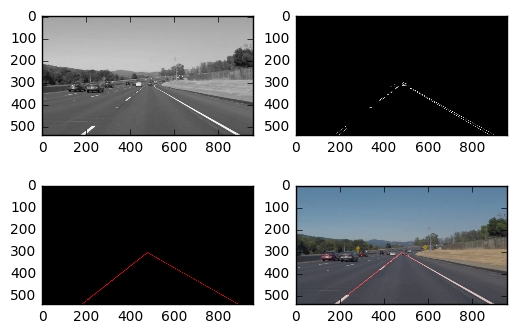

In [258]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [259]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

Slope & intercept:  [[0.67340067340067344, -24.212121212121247], [0.69964664310954061, -34.031802120141322], [0.6767676767676768, -27.494949494949481], [0.70129870129870131, -33.883116883116884]]
Slope:  0.687778423644 Intercept:  -29.9054974276
Slope & intercept:  [[-0.60171919770773641, 601.18051575931236], [-0.60289855072463772, 600.52463768115945], [-0.62790697674418605, 615.48837209302326], [-0.62694300518134716, 614.36269430051811], [-0.62820512820512819, 616.06410256410254], [-0.60465116279069764, 600.1395348837209]]
Slope:  -0.615387336892 Intercept:  607.959976214
Coef:  0.687778423644 Intercept:  -29.9054974276 intersection_x:  489.473782198
Point one:  (489, 306) Point two:  (960, 630)
Coef:  -0.615387336892 Intercept:  607.959976214 intersection_x:  489.473782198
Point one:  (489, 306) Point two:  (0, 607)
[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


  0%|          | 1/682 [00:00<01:33,  7.30it/s]

Slope & intercept:  [[0.67340067340067344, -24.212121212121247], [0.69964664310954061, -34.031802120141322], [0.6767676767676768, -27.494949494949481], [0.70129870129870131, -33.883116883116884]]
Slope:  0.687778423644 Intercept:  -29.9054974276
Slope & intercept:  [[-0.60171919770773641, 601.18051575931236], [-0.60289855072463772, 600.52463768115945], [-0.62790697674418605, 615.48837209302326], [-0.62694300518134716, 614.36269430051811], [-0.62820512820512819, 616.06410256410254], [-0.60465116279069764, 600.1395348837209]]
Slope:  -0.615387336892 Intercept:  607.959976214
Coef:  0.687778423644 Intercept:  -29.9054974276 intersection_x:  489.473782198
Point one:  (489, 306) Point two:  (960, 630)
Coef:  -0.615387336892 Intercept:  607.959976214 intersection_x:  489.473782198
Point one:  (489, 306) Point two:  (0, 607)


  0%|          | 2/682 [00:00<01:29,  7.59it/s]

Slope & intercept:  [[0.70029673590504449, -34.341246290801166], [0.67422096317280455, -24.603399433427796], [0.66666666666666663, -21.0], [0.69849246231155782, -32.175879396984953], [0.70297029702970293, -37.316831683168289], [0.67464114832535882, -26.626794258373195]]
Slope:  0.686214712235 Intercept:  -29.3440251771
Slope & intercept:  [[-0.60171919770773641, 601.18051575931236], [-0.62454873646209386, 615.0252707581227], [-0.62666666666666671, 616.33333333333337], [-0.60273972602739723, 600.84931506849318], [-0.60101010101010099, 601.70707070707067], [-1.0, 776.0], [-0.62903225806451613, 615.17741935483878]]
Slope:  -0.669388097991 Intercept:  632.324703569
Coef:  0.686214712235 Intercept:  -29.3440251771 intersection_x:  488.099260163
Point one:  (488, 305) Point two:  (960, 629)
Coef:  -0.669388097991 Intercept:  632.324703569 intersection_x:  488.099260163
Point one:  (488, 305) Point two:  (0, 632)


  0%|          | 3/682 [00:00<01:32,  7.38it/s]

Slope & intercept:  [[0.69970845481049559, -34.061224489795904], [0.67241379310344829, -25.155172413793139], [0.66666666666666663, -20.0], [0.69902912621359226, -34.106796116504881], [0.67460317460317465, -24.785714285714334], [0.67307692307692313, -24.730769230769283]]
Slope:  0.680916356412 Intercept:  -27.1399460894
Slope & intercept:  [[-0.60289855072463772, 602.11304347826092], [-0.64628820960698685, 621.72489082969435], [-0.64516129032258063, 620.58064516129036], [-0.64779874213836475, 623.21383647798734], [-1.0, 777.0], [-0.62254901960784315, 607.99509803921569], [-0.59999999999999998, 602.20000000000005], [-0.64935064935064934, 624.61038961038957]]
Slope:  -0.676755807719 Intercept:  634.92973795
Coef:  0.680916356412 Intercept:  -27.1399460894 intersection_x:  487.650628429
Point one:  (487, 304) Point two:  (960, 626)
Coef:  -0.676755807719 Intercept:  634.92973795 intersection_x:  487.650628429
Point one:  (487, 304) Point two:  (0, 634)


  1%|          | 4/682 [00:00<01:28,  7.64it/s]

Slope & intercept:  [[0.7142857142857143, -45.714285714285779], [0.64835164835164838, -5.6153846153846416], [0.69999999999999996, -35.0], [0.64571428571428569, -6.4228571428571399], [0.66265060240963858, -18.301204819277132], [0.78494623655913975, -84.258064516129025], [0.67469879518072284, -25.506024096385545]]
Slope:  0.674283507657 Intercept:  -22.759959398
Slope & intercept:  [[-0.62420382165605093, 608.75796178343944], [-0.65203761755485889, 625.06896551724139], [-0.625, 610.625], [-0.6160714285714286, 606.38392857142856], [-0.64893617021276595, 625.18085106382978]]
Slope:  -0.633249807599 Intercept:  615.203341387
Coef:  0.674283507657 Intercept:  -22.759959398 intersection_x:  487.913610569
Point one:  (487, 306) Point two:  (960, 624)
Coef:  -0.633249807599 Intercept:  615.203341387 intersection_x:  487.913610569
Point one:  (487, 306) Point two:  (0, 615)
Slope & intercept:  [[0.702247191011236, -36.971910112359581], [0.6737967914438503, -24.401069518716611], [0.78472222222222

  1%|          | 5/682 [00:00<01:38,  6.85it/s]

Slope & intercept:  [[0.70129870129870131, -35.974025974026006], [0.64739884393063585, -9.8208092485548946], [0.64903846153846156, -8.9423076923076792]]
Slope:  0.665912002256 Intercept:  -18.245714305
Slope & intercept:  [[-0.62721893491124259, 613.01183431952666], [-0.64918032786885249, 626.28852459016389], [-0.62463343108504399, 611.08211143695019], [-0.64885496183206104, 627.5419847328244], [-1.0, 777.0], [-0.62413793103448278, 612.73448275862074]]
Slope:  -0.695670931122 Intercept:  644.609822973
Coef:  0.665912002256 Intercept:  -18.245714305 intersection_x:  486.827148776
Point one:  (486, 305) Point two:  (960, 621)
Coef:  -0.695670931122 Intercept:  644.609822973 intersection_x:  486.827148776
Point one:  (486, 305) Point two:  (0, 644)


  1%|          | 7/682 [00:00<01:38,  6.88it/s]

Slope & intercept:  [[0.64830508474576276, -9.2966101694915437], [0.70183486238532111, -36.775229357798196], [0.67099567099567103, -24.735930735930765]]
Slope:  0.673711872709 Intercept:  -23.6025900877
Slope & intercept:  [[-0.62574850299401197, 613.08982035928148], [-0.65030674846625769, 627.85276073619627], [-0.65134099616858232, 628.53639846743295], [-0.62462462462462465, 612.20420420420419], [-1.0, 777.0], [-0.65909090909090906, 629.9545454545455]]
Slope:  -0.701851963557 Intercept:  648.106288204
Coef:  0.673711872709 Intercept:  -23.6025900877 intersection_x:  488.315307936
Point one:  (488, 305) Point two:  (960, 623)
Coef:  -0.701851963557 Intercept:  648.106288204 intersection_x:  488.315307936
Point one:  (488, 305) Point two:  (0, 648)


  1%|          | 8/682 [00:01<01:31,  7.33it/s]

Slope & intercept:  [[0.75373134328358204, -70.865671641791039], [0.6467065868263473, -9.8323353293413334], [0.70588235294117652, -39.705882352941217]]
Slope:  0.702106761017 Intercept:  -40.1346297747
Slope & intercept:  [[-0.625, 613.0], [-0.62613981762917936, 612.38905775075989], [-0.65384615384615385, 628.26923076923072], [-0.64876033057851235, 628.17768595041321], [-0.90588235294117647, 732.57647058823522], [-0.90000000000000002, 728.5]]
Slope:  -0.726604775833 Intercept:  657.152074176
Coef:  0.702106761017 Intercept:  -40.1346297747 intersection_x:  488.052826597
Point one:  (488, 302) Point two:  (960, 633)
Coef:  -0.726604775833 Intercept:  657.152074176 intersection_x:  488.052826597
Point one:  (488, 302) Point two:  (0, 657)
Slope & intercept:  [[0.65333333333333332, -15.546666666666681], [0.7007299270072993, -38.773722627737243], [0.67045454545454541, -20.136363636363626], [0.64640883977900554, -10.690607734806633]]
Slope:  0.656732239522 Intercept:  -15.4578793459
Slope &

  1%|▏         | 10/682 [00:01<01:28,  7.58it/s]

Slope & intercept:  [[0.67357512953367871, -22.621761658031062], [0.62561576354679804, 1.8325123152709466], [0.70303030303030301, -43.030303030303003], [0.65269461077844315, -15.526946107784454], [0.67407407407407405, -22.281481481481478]]
Slope:  0.665797976193 Intercept:  -20.3255959925
Slope & intercept:  [[-0.62576687116564422, 613.09202453987734], [-0.67368421052631577, 635.42105263157896], [-0.67482517482517479, 634.32167832167829], [-0.62738853503184711, 614.91401273885344], [-0.65957446808510634, 630.34042553191489], [-0.67479674796747968, 630.40650406504062]]
Slope:  -0.656006001267 Intercept:  626.415949638
Coef:  0.665797976193 Intercept:  -20.3255959925 intersection_x:  489.287032464
Point one:  (489, 305) Point two:  (960, 618)
Coef:  -0.656006001267 Intercept:  626.415949638 intersection_x:  489.287032464
Point one:  (489, 305) Point two:  (0, 626)


  2%|▏         | 11/682 [00:01<01:26,  7.76it/s]

Slope & intercept:  [[0.67289719626168221, -21.626168224299022], [0.64766839378238339, -13.36787564766837], [0.65104166666666663, -14.380208333333314]]
Slope:  0.657202418904 Intercept:  -16.4580840684
Slope & intercept:  [[-0.62702702702702706, 615.12432432432433], [-0.67449664429530198, 635.45302013422815], [-0.66942148760330578, 629.25619834710744], [-0.67441860465116277, 634.44186046511629], [-0.67391304347826086, 636.78260869565224], [-0.6292134831460674, 614.61797752808991], [-0.67400881057268724, 636.10572687224669]]
Slope:  -0.67325171812 Intercept:  634.407882903
Coef:  0.657202418904 Intercept:  -16.4580840684 intersection_x:  489.205865019
Point one:  (489, 305) Point two:  (960, 614)
Coef:  -0.67325171812 Intercept:  634.407882903 intersection_x:  489.205865019
Point one:  (489, 305) Point two:  (0, 634)


  2%|▏         | 12/682 [00:01<01:24,  7.93it/s]

Slope & intercept:  [[0.7009345794392523, -42.570093457943926], [0.62352941176470589, 3.4470588235294031], [0.67219917012448138, -21.294605809128655], [0.625, 1.375]]
Slope:  0.655415790332 Intercept:  -14.7606601109
Slope & intercept:  [[-0.6745762711864407, 635.1389830508474], [-0.64840182648401823, 620.78082191780823], [-0.64893617021276595, 619.968085106383], [-0.64864864864864868, 619.43243243243239], [-0.67333333333333334, 636.21333333333337], [-1.0, 773.0]]
Slope:  -0.715649374978 Intercept:  650.755609307
Coef:  0.655415790332 Intercept:  -14.7606601109 intersection_x:  485.400903076
Point one:  (485, 303) Point two:  (960, 614)
Coef:  -0.715649374978 Intercept:  650.755609307 intersection_x:  485.400903076
Point one:  (485, 303) Point two:  (0, 650)


  2%|▏         | 13/682 [00:01<01:23,  8.05it/s]

Slope & intercept:  [[0.67391304347826086, -23.782608695652186], [0.6470588235294118, -14.29411764705884], [0.65000000000000002, -14.550000000000011], [0.67500000000000004, -25.625], [0.67293233082706772, -21.642857142857167]]
Slope:  0.663780839567 Intercept:  -19.9789166971
Slope & intercept:  [[-0.62758620689655176, 616.44827586206895], [-0.67615658362989328, 636.71886120996442], [-0.67105263157894735, 629.32894736842104], [-0.62962962962962965, 615.51851851851848], [-0.72649572649572647, 656.19658119658118], [-0.81060606060606055, 688.17424242424238]]
Slope:  -0.690254473139 Intercept:  640.397571097
Coef:  0.663780839567 Intercept:  -19.9789166971 intersection_x:  487.70994493
Point one:  (487, 303) Point two:  (960, 617)
Coef:  -0.690254473139 Intercept:  640.397571097 intersection_x:  487.70994493
Point one:  (487, 303) Point two:  (0, 640)


  2%|▏         | 14/682 [00:01<01:22,  8.11it/s]

Slope & intercept:  [[0.62318840579710144, 3.6086956521739353], [0.67474048442906576, -25.141868512110761], [0.62450592885375489, 2.023715415019808], [0.67450980392156867, -23.607843137254918], [0.81428571428571428, -101.32857142857142]]
Slope:  0.64923615575 Intercept:  -10.7793251455
Slope & intercept:  [[-0.65000000000000002, 622.20000000000005], [-0.67452830188679247, 637.83018867924534], [-0.67730496453900713, 637.563829787234], [-0.65000000000000002, 623.29999999999995], [-0.64566929133858264, 620.64566929133855], [-0.80419580419580416, 686.7552447552448], [-0.68032786885245899, 637.98360655737702]]
Slope:  -0.683146604402 Intercept:  638.039791296
Coef:  0.64923615575 Intercept:  -10.7793251455 intersection_x:  486.961506742
Point one:  (486, 305) Point two:  (960, 612)
Coef:  -0.683146604402 Intercept:  638.039791296 intersection_x:  486.961506742
Point one:  (486, 305) Point two:  (0, 638)


  2%|▏         | 15/682 [00:01<01:23,  7.96it/s]

Slope & intercept:  [[0.62411347517730498, 1.5106382978723332], [0.64931506849315068, -7.126027397260259], [0.64976958525345618, -7.1566820276497651], [0.625, 1.75]]
Slope:  0.637049532231 Intercept:  -2.75551778176
Slope & intercept:  [[-0.64984227129337535, 621.82965299684543], [-0.65175718849840258, 623.72843450479229], [-0.67680608365019013, 638.84410646387835], [-0.67597765363128492, 639.39664804469271], [-0.67878787878787883, 638.66060606060603], [-0.67910447761194026, 637.69402985074623], [-0.87301587301587302, 716.31746031746025]]
Slope:  -0.697898775213 Intercept:  645.210134034
Coef:  0.637049532231 Intercept:  -2.75551778176 intersection_x:  485.386324102
Point one:  (485, 306) Point two:  (960, 608)
Coef:  -0.697898775213 Intercept:  645.210134034 intersection_x:  485.386324102
Point one:  (485, 306) Point two:  (0, 645)
Slope & intercept:  [[0.6216216216216216, 3.4054054054054177], [0.64761904761904765, -5.3523809523809973], [0.62285714285714289, 2.7657142857142958], [0.62

  2%|▏         | 16/682 [00:02<01:33,  7.14it/s]

Slope & intercept:  [[0.67721518987341767, -29.639240506329088], [0.59999999999999998, 22.400000000000034], [0.64640883977900554, -5.7513812154696211], [0.60273972602739723, 19.041095890410986], [0.66666666666666663, -20.666666666666629], [0.64673913043478259, -6.9076086956521863], [0.67515923566878977, -28.955414012738856], [0.69354838709677424, -43.5]]
Slope:  0.651059646943 Intercept:  -11.7474019008
Slope & intercept:  [[-0.69999999999999996, 646.20000000000005], [-0.67307692307692313, 630.23076923076928], [-0.6741573033707865, 631.69662921348311], [-0.66265060240963858, 627.06024096385545], [-0.69387755102040816, 644.16326530612241], [-0.67272727272727273, 628.4727272727273]]
Slope:  -0.679414942101 Intercept:  634.637271998
Coef:  0.651059646943 Intercept:  -11.7474019008 intersection_x:  485.830153557
Point one:  (485, 304) Point two:  (960, 613)
Coef:  -0.679414942101 Intercept:  634.637271998 intersection_x:  485.830153557
Point one:  (485, 304) Point two:  (0, 634)


  2%|▏         | 17/682 [00:02<01:30,  7.34it/s]

Slope & intercept:  [[0.65142857142857147, -14.274285714285725], [0.65116279069767447, -13.441860465116292], [0.67361111111111116, -22.319444444444457]]
Slope:  0.658734157746 Intercept:  -16.6785302079
Slope & intercept:  [[-0.70110701107011075, 647.37269372693731], [-0.67391304347826086, 631.91304347826087], [-0.67426710097719866, 630.76872964169377], [-0.66666666666666663, 628.66666666666663], [-0.70754716981132071, 648.61320754716985], [-0.69709543568464727, 647.74688796680493]]
Slope:  -0.686766071281 Intercept:  639.180204838
Coef:  0.658734157746 Intercept:  -16.6785302079 intersection_x:  487.446022599
Point one:  (487, 304) Point two:  (960, 615)
Coef:  -0.686766071281 Intercept:  639.180204838 intersection_x:  487.446022599
Point one:  (487, 304) Point two:  (0, 639)


  3%|▎         | 18/682 [00:02<01:31,  7.29it/s]

Slope & intercept:  [[0.67272727272727273, -22.527272727272702], [0.6243386243386243, 1.2169312169312434]]
Slope:  0.648532948533 Intercept:  -10.6551707552
Slope & intercept:  [[-0.67405063291139244, 629.99683544303798], [-0.70110701107011075, 646.67158671586719], [-0.6742424242424242, 631.06060606060601], [-0.7021276595744681, 648.531914893617], [-0.70634920634920639, 647.96825396825398]]
Slope:  -0.69157538683 Intercept:  640.845839416
Coef:  0.648532948533 Intercept:  -10.6551707552 intersection_x:  486.155479359
Point one:  (486, 304) Point two:  (960, 611)
Coef:  -0.69157538683 Intercept:  640.845839416 intersection_x:  486.155479359
Point one:  (486, 304) Point two:  (0, 640)


  3%|▎         | 20/682 [00:02<01:28,  7.51it/s]

Slope & intercept:  [[0.624, 1.3919999999999959], [0.64800000000000002, -7.5040000000000191]]
Slope:  0.636 Intercept:  -3.056
Slope & intercept:  [[-0.67524115755627012, 630.83279742765274], [-0.7007575757575758, 646.61742424242425], [-0.70181818181818179, 646.08000000000004], [-0.67412140575079871, 629.6805111821086], [-0.67510548523206748, 631.74683544303798], [-0.70078740157480313, 647.62204724409446], [-1.0, 770.0]]
Slope:  -0.732547315384 Intercept:  657.511373648
Coef:  0.636 Intercept:  -3.056 intersection_x:  482.677775348
Point one:  (482, 303) Point two:  (960, 607)
Coef:  -0.732547315384 Intercept:  657.511373648 intersection_x:  482.677775348
Point one:  (482, 303) Point two:  (0, 657)


  3%|▎         | 21/682 [00:02<01:26,  7.68it/s]

Slope & intercept:  [[0.70138888888888884, -42.5], [0.62857142857142856, -1.5999999999999659], [0.67241379310344829, -23.034482758620697]]
Slope:  0.667458036855 Intercept:  -22.3781609195
Slope & intercept:  [[-0.67628205128205132, 630.29807692307691], [-0.70300751879699253, 646.26315789473688], [-0.67405063291139244, 628.32278481012656], [-0.70588235294117652, 646.23529411764707], [-0.67407407407407405, 630.26666666666665], [-0.70370370370370372, 647.07407407407413], [-1.0, 770.0], [-0.9726027397260274, 756.42465753424653]]
Slope:  -0.763700384179 Intercept:  669.360589003
Coef:  0.667458036855 Intercept:  -22.3781609195 intersection_x:  483.341843751
Point one:  (483, 300) Point two:  (960, 618)
Coef:  -0.763700384179 Intercept:  669.360589003 intersection_x:  483.341843751
Point one:  (483, 300) Point two:  (0, 669)
Slope & intercept:  [[0.620253164556962, 2.3291139240506595], [0.67361111111111116, -24.9305555555556], [0.69934640522875813, -42.169934640522854]]
Slope:  0.6644035602

  3%|▎         | 22/682 [00:02<01:29,  7.36it/s]

Slope & intercept:  [[0.62569832402234637, -0.11173184357539867], [0.64615384615384619, -7.2615384615384642], [0.60122699386503065, 14.944785276073617]]
Slope:  0.624359721347 Intercept:  2.52383832365
Slope & intercept:  [[-0.70260223048327142, 644.90334572490701], [-0.67405063291139244, 627.97468354430384], [-0.67364016736401677, 628.76987447698752], [-0.70038910505836571, 645.15953307392999], [-0.66942148760330578, 626.36363636363637], [-1.0476190476190477, 790.09523809523807]]
Slope:  -0.744620445173 Intercept:  660.544385213
Coef:  0.624359721347 Intercept:  2.52383832365 intersection_x:  480.664777315
Point one:  (480, 302) Point two:  (960, 601)
Coef:  -0.744620445173 Intercept:  660.544385213 intersection_x:  480.664777315
Point one:  (480, 302) Point two:  (0, 660)


  4%|▎         | 24/682 [00:03<01:26,  7.59it/s]

Slope & intercept:  [[0.62621359223300976, -1.0048543689320582], [0.651685393258427, -11.651685393258447], [0.70114942528735635, -43.678160919540232]]
Slope:  0.659682803593 Intercept:  -18.7782335606
Slope & intercept:  [[-0.70229007633587781, 645.45038167938935], [-0.67045454545454541, 627.5], [-0.67431192660550454, 629.06880733944956], [-0.66972477064220182, 626.40366972477068], [-0.90000000000000002, 723.90000000000009], [-0.67375886524822692, 629.78014184397159], [-1.0238095238095237, 779.97619047619037]]
Slope:  -0.759192815442 Intercept:  666.011313009
Coef:  0.659682803593 Intercept:  -18.7782335606 intersection_x:  482.628313139
Point one:  (482, 299) Point two:  (960, 614)
Coef:  -0.759192815442 Intercept:  666.011313009 intersection_x:  482.628313139
Point one:  (482, 299) Point two:  (0, 666)
Slope & intercept:  [[0.625, -0.375], [0.64928909952606639, -9.7203791469194698], [0.65000000000000002, -8.9499999999999886], [0.62676056338028174, 0.45774647887321862]]
Slope:  0.6377

  4%|▎         | 25/682 [00:03<01:29,  7.33it/s]

Slope & intercept:  [[0.60298507462686568, 15.994029850746244], [0.6485623003194888, -7.7699680511182123], [0.64960629921259838, -9.5393700787401485], [0.69942196531791911, -41.1098265895954], [0.59817351598173518, 20.068493150684901]]
Slope:  0.624831797535 Intercept:  4.68829621789
Slope & intercept:  [[-0.67450980392156867, 632.10980392156864], [-0.70305676855895194, 649.37991266375548], [-0.68888888888888888, 636.62222222222226], [-0.70238095238095233, 647.67857142857144], [-0.66666666666666663, 629.33333333333337], [-1.0, 769.0], [-0.70081967213114749, 648.02868852459017], [-0.86764705882352944, 710.66176470588243]]
Slope:  -0.750496226421 Intercept:  665.3517871
Coef:  0.624831797535 Intercept:  4.68829621789 intersection_x:  480.367940865
Point one:  (480, 304) Point two:  (960, 604)
Coef:  -0.750496226421 Intercept:  665.3517871 intersection_x:  480.367940865
Point one:  (480, 304) Point two:  (0, 665)


  4%|▍         | 26/682 [00:03<01:34,  6.91it/s]

Slope & intercept:  [[0.59846547314578002, 18.122762148337586], [0.60150375939849621, 15.090225563909769], [0.62389380530973448, 8.5619469026548813], [0.65030674846625769, -12.460122699386488], [0.77906976744186052, -83.976744186046517], [0.5982142857142857, 15.330357142857167]]
Slope:  0.614476814407 Intercept:  8.92903381167
Slope & intercept:  [[-0.67558528428093645, 632.23076923076928], [-0.72727272727272729, 656.72727272727275], [-0.72573839662447259, 654.79324894514775], [-0.67441860465116277, 631.06976744186045], [-0.72631578947368425, 654.48421052631579], [-0.67391304347826086, 632.41304347826087], [-0.8666666666666667, 709.20000000000005], [-0.87074829931972786, 712.25170068027205]]
Slope:  -0.742582351471 Intercept:  660.396251629
Coef:  0.614476814407 Intercept:  8.92903381167 intersection_x:  480.058080147
Point one:  (480, 303) Point two:  (960, 598)
Coef:  -0.742582351471 Intercept:  660.396251629 intersection_x:  480.058080147
Point one:  (480, 303) Point two:  (0, 660)


  4%|▍         | 28/682 [00:03<01:30,  7.22it/s]

Slope & intercept:  [[0.60305343511450382, 12.13740458015269], [0.62903225806451613, 2.0645161290322562], [0.59701492537313428, 18.000000000000057], [0.67142857142857137, -28.728571428571399], [0.65040650406504064, -14.495934959349597], [0.65217391304347827, -13.739130434782624]]
Slope:  0.633851601182 Intercept:  -4.12695268559
Slope & intercept:  [[-0.67697594501718217, 633.09965635738831], [-0.72608695652173916, 655.40869565217395], [-0.67558528428093645, 631.23076923076928], [-0.87272727272727268, 712.0545454545454], [-0.70289855072463769, 650.76086956521738], [-0.86470588235294121, 707.14117647058822]]
Slope:  -0.753163315271 Intercept:  664.949285455
Coef:  0.633851601182 Intercept:  -4.12695268559 intersection_x:  482.38575534
Point one:  (482, 301) Point two:  (960, 604)
Coef:  -0.753163315271 Intercept:  664.949285455 intersection_x:  482.38575534
Point one:  (482, 301) Point two:  (0, 664)


  4%|▍         | 29/682 [00:03<01:27,  7.43it/s]

Slope & intercept:  [[0.60330578512396693, 11.611570247933912], [0.6292134831460674, 0.022471910112358273], [0.58333333333333337, 25.999999999999943], [0.57425742574257421, 35.524752475247567], [0.62068965517241381, 7.931034482758605], [0.57499999999999996, 32.5], [0.59398496240601506, 15.751879699248093]]
Slope:  0.591761860296 Intercept:  21.5532061509
Slope & intercept:  [[-0.6759581881533101, 632.63414634146341], [-0.72614107883817425, 655.90871369294609], [-0.72340425531914898, 654.468085106383], [-0.68571428571428572, 634.97142857142853], [-0.89473684210526316, 720.52631578947376], [-0.86792452830188682, 713.24528301886789]]
Slope:  -0.762313196405 Intercept:  668.625662087
Coef:  0.591761860296 Intercept:  21.5532061509 intersection_x:  477.870449451
Point one:  (477, 304) Point two:  (960, 589)
Coef:  -0.762313196405 Intercept:  668.625662087 intersection_x:  477.870449451
Point one:  (477, 304) Point two:  (0, 668)


  4%|▍         | 30/682 [00:04<01:26,  7.57it/s]

Slope & intercept:  [[0.57446808510638303, 33.617021276595722], [0.65088757396449703, -18.301775147928993], [0.625, 1.75]]
Slope:  0.61678521969 Intercept:  5.68841537622
Slope & intercept:  [[-0.72881355932203384, 657.06779661016947], [-0.67730496453900713, 633.5], [-0.7265625, 654.9765625], [-0.8359375, 694.890625], [-0.72641509433962259, 649.88679245283015]]
Slope:  -0.73900672364 Intercept:  658.064355313
Coef:  0.61678521969 Intercept:  5.68841537622 intersection_x:  481.177029518
Point one:  (481, 302) Point two:  (960, 597)
Coef:  -0.73900672364 Intercept:  658.064355313 intersection_x:  481.177029518
Point one:  (481, 302) Point two:  (0, 658)


  5%|▍         | 31/682 [00:04<01:24,  7.67it/s]

Slope & intercept:  [[0.64893617021276595, -17.308510638297889], [0.66666666666666663, -23.333333333333314]]
Slope:  0.65780141844 Intercept:  -20.3209219858
Slope & intercept:  [[-0.72764227642276424, 655.8780487804878], [-0.67509025270758127, 633.1877256317689], [-0.67636363636363639, 632.77818181818179], [-0.726457399103139, 656.68609865470853], [-0.81168831168831168, 684.24675324675331], [-0.68235294117647061, 634.09411764705885]]
Slope:  -0.716599136244 Intercept:  649.47848763
Coef:  0.65780141844 Intercept:  -20.3209219858 intersection_x:  487.339303912
Point one:  (487, 300) Point two:  (960, 611)
Coef:  -0.716599136244 Intercept:  649.47848763 intersection_x:  487.339303912
Point one:  (487, 300) Point two:  (0, 649)
Slope & intercept:  [[0.64848484848484844, -12.369696969696975], [0.65116279069767447, -19.488372093023258]]
Slope:  0.649823819591 Intercept:  -15.9290345314
Slope & intercept:  [[-0.72641509433962259, 657.40566037735846], [-0.69999999999999996, 640.2999999999999

  5%|▍         | 32/682 [00:04<01:32,  7.05it/s]

Slope & intercept:  [[0.6992481203007519, -44.819548872180462], [0.625, -4.125], [0.69784172661870503, -45.107913669064772]]
Slope:  0.674029948973 Intercept:  -31.3508208471
Slope & intercept:  [[-0.72916666666666663, 658.58333333333337], [-0.69999999999999996, 639.39999999999998], [-0.69911504424778759, 640.11504424778764], [-0.7289719626168224, 657.55140186915889], [-0.69892473118279574, 638.94623655913983], [-0.8666666666666667, 707.33333333333337], [-0.83950617283950613, 699.17283950617275], [-0.70175438596491224, 641.85964912280701]]
Slope:  -0.745513203773 Intercept:  660.370229746
Coef:  0.674029948973 Intercept:  -31.3508208471 intersection_x:  487.284271179
Point one:  (487, 297) Point two:  (960, 615)
Coef:  -0.745513203773 Intercept:  660.370229746 intersection_x:  487.284271179
Point one:  (487, 297) Point two:  (0, 660)


  5%|▍         | 33/682 [00:04<01:33,  6.94it/s]

Slope & intercept:  [[0.70068027210884354, -47.448979591836746], [0.57627118644067798, 26.898305084745743], [0.69863013698630139, -45.109589041095887]]
Slope:  0.658527198512 Intercept:  -21.8867545161
Slope & intercept:  [[-0.70042194092827004, 640.98312236286915], [-0.72916666666666663, 658.3125], [-0.70307167235494883, 640.9453924914676], [-0.72891566265060237, 659.27108433734941], [-0.83969465648854957, 695.6564885496183], [-0.81188118811881194, 687.40594059405942], [-0.83687943262411346, 693.33333333333326]]
Slope:  -0.764290174262 Intercept:  667.986837381
Coef:  0.658527198512 Intercept:  -21.8867545161 intersection_x:  484.86447038
Point one:  (484, 297) Point two:  (960, 610)
Coef:  -0.764290174262 Intercept:  667.986837381 intersection_x:  484.86447038
Point one:  (484, 297) Point two:  (0, 667)


  5%|▌         | 35/682 [00:04<01:27,  7.37it/s]

Slope & intercept:  [[0.57777777777777772, 26.333333333333371], [0.61818181818181817, 6.0181818181818016], [0.62777777777777777, -6.1666666666666856]]
Slope:  0.607912457912 Intercept:  8.72828282828
Slope & intercept:  [[-0.70138888888888884, 640.70138888888891], [-0.72380952380952379, 657.42857142857144], [-0.87037037037037035, 707.75925925925924], [-0.69999999999999996, 641.5], [-0.70526315789473681, 641.61052631578946], [-0.75294117647058822, 665.68235294117653], [-0.74766355140186913, 663.34579439252343]]
Slope:  -0.743062381262 Intercept:  659.718270461
Coef:  0.607912457912 Intercept:  8.72828282828 intersection_x:  481.866848113
Point one:  (481, 301) Point two:  (960, 592)
Coef:  -0.743062381262 Intercept:  659.718270461 intersection_x:  481.866848113
Point one:  (481, 301) Point two:  (0, 659)


  5%|▌         | 36/682 [00:04<01:27,  7.39it/s]

Slope & intercept:  [[0.57692307692307687, 27.076923076923094], [0.6470588235294118, -13.235294117647072], [0.70068027210884354, -47.448979591836746], [0.57718120805369133, 27.892617449664385]]
Slope:  0.625460845154 Intercept:  -1.42868329572
Slope & intercept:  [[-0.75274725274725274, 665.34615384615381], [-0.70106761565836295, 641.35587188612101], [-0.78095238095238095, 669.58095238095234], [-0.75409836065573765, 664.93442622950818], [-0.77692307692307694, 666.60000000000002], [-0.70642201834862384, 641.82568807339453], [-0.765625, 668.6875], [-0.73913043478260865, 660.695652173913]]
Slope:  -0.753699789201 Intercept:  662.524338958
Coef:  0.625460845154 Intercept:  -1.42868329572 intersection_x:  481.418194309
Point one:  (481, 299) Point two:  (960, 599)
Coef:  -0.753699789201 Intercept:  662.524338958 intersection_x:  481.418194309
Point one:  (481, 299) Point two:  (0, 662)
Slope & intercept:  [[0.67256637168141598, -31.973451327433679], [0.59905660377358494, 11.702830188679229]

  6%|▌         | 38/682 [00:05<01:50,  5.83it/s]

Slope & intercept:  [[0.60159362549800799, 10.147410358565708], [0.61538461538461542, 8.307692307692264], [0.59493670886075944, 13.379746835443086], [0.60204081632653061, 8.9387755102040956]]
Slope:  0.599523716895 Intercept:  10.8219775681
Slope & intercept:  [[-0.7544642857142857, 665.25892857142856], [-0.72692307692307689, 647.29615384615386], [-0.72641509433962259, 648.33962264150944], [-0.7407407407407407, 652.77777777777783], [-0.75409836065573765, 663.93442622950818], [-0.72222222222222221, 645.88888888888891], [-0.71641791044776115, 644.02985074626861], [-0.963963963963964, 748.4234234234234]]
Slope:  -0.763155706876 Intercept:  664.493634016
Coef:  0.599523716895 Intercept:  10.8219775681 intersection_x:  479.695844118
Point one:  (479, 298) Point two:  (960, 586)
Coef:  -0.763155706876 Intercept:  664.493634016 intersection_x:  479.695844118
Point one:  (479, 298) Point two:  (0, 664)
Slope & intercept:  [[0.60312500000000002, 7.375], [0.61940298507462688, 5.2313432835820777]

  6%|▌         | 40/682 [00:05<02:14,  4.78it/s]

Slope & intercept:  [[0.59999999999999998, 9.1999999999999886], [0.6216216216216216, 2.5405405405405759], [0.5968992248062015, 12.054263565891517], [0.62585034013605445, -1.4829931972789154], [0.60305343511450382, 5.4427480916030504]]
Slope:  0.609484924336 Intercept:  5.55091180015
Slope & intercept:  [[-0.75536480686695284, 663.63519313304721], [-0.72680412371134018, 646.51546391752572], [-0.72027972027972031, 643.44055944055947], [-0.72463768115942029, 643.79710144927537], [-0.80660377358490565, 677.87735849056605], [-0.78125, 672.625], [-0.7407407407407407, 649.55555555555554], [-0.72535211267605637, 646.95774647887322]]
Slope:  -0.747629119877 Intercept:  655.550497308
Coef:  0.609484924336 Intercept:  5.55091180015 intersection_x:  478.957231546
Point one:  (478, 297) Point two:  (960, 590)
Coef:  -0.747629119877 Intercept:  655.550497308 intersection_x:  478.957231546
Point one:  (478, 297) Point two:  (0, 655)
Slope & intercept:  [[0.57599999999999996, 28.816000000000031], [0.6

  6%|▌         | 42/682 [00:06<02:03,  5.19it/s]

 478.305679762
Point one:  (478, 299) Point two:  (0, 670)
Slope & intercept:  [[0.59459459459459463, 13.567567567567551], [0.61971830985915488, 4.4225352112676433], [0.59872611464968151, 10.25477707006371], [0.5679012345679012, 36.543209876543244], [0.64615384615384619, -11.923076923076962]]
Slope:  0.595235063418 Intercept:  16.1970224314
Slope & intercept:  [[-0.70279720279720281, 638.90559440559446], [-0.75403225806451613, 662.41532258064512], [-0.7007299270072993, 639.60583941605842], [-0.75287356321839083, 663.56321839080465], [-0.80681818181818177, 677.97727272727275], [-0.70370370370370372, 638.81481481481478]]
Slope:  -0.736825806102 Intercept:  653.547010389
Coef:  0.595235063418 Intercept:  16.1970224314 intersection_x:  478.469116946
Point one:  (478, 300) Point two:  (960, 587)
Coef:  -0.736825806102 Intercept:  653.547010389 intersection_x:  478.469116946
Point one:  (478, 300) Point two:  (0, 653)


  6%|▋         | 43/682 [00:06<02:11,  4.88it/s]

Slope & intercept:  [[0.62637362637362637, -5.5714285714285552], [0.67721518987341767, -30.411392405063282], [0.62686567164179108, -0.89552238805970319]]
Slope:  0.643484829296 Intercept:  -12.2927811215
Slope & intercept:  [[-0.7021276595744681, 639.40425531914889], [-0.75298804780876494, 661.49003984063745], [-0.70198675496688745, 637.68211920529802], [-0.75257731958762886, 662.97938144329896], [-0.80769230769230771, 678.38461538461536], [-0.7078651685393258, 639.41573033707868], [-0.75416666666666665, 662.68333333333339]]
Slope:  -0.739914846405 Intercept:  654.577067838
Coef:  0.643484829296 Intercept:  -12.2927811215 intersection_x:  482.051471221
Point one:  (482, 297) Point two:  (960, 605)
Coef:  -0.739914846405 Intercept:  654.577067838 intersection_x:  482.051471221
Point one:  (482, 297) Point two:  (0, 654)
Slope & intercept:  [[0.62436548223350252, -3.0507614213198053], [0.65000000000000002, -13.600000000000023]]
Slope:  0.637182741117 Intercept:  -8.32538071066
Slope & in

  7%|▋         | 46/682 [00:06<01:38,  6.47it/s]

Slope & intercept:  [[0.625, -2.875], [0.65454545454545454, -14.636363636363626]]
Slope:  0.639772727273 Intercept:  -8.75568181818
Slope & intercept:  [[-0.70205479452054798, 639.79794520547944], [-0.75478927203065138, 663.29501915708818], [-0.75369458128078815, 664.38916256157631], [-0.7483443708609272, 655.48344370860923], [-0.70121951219512191, 640.67682926829264], [-0.80904522613065322, 680.251256281407]]
Slope:  -0.744857959503 Intercept:  657.315609364
Coef:  0.639772727273 Intercept:  -8.75568181818 intersection_x:  481.046171765
Point one:  (481, 299) Point two:  (960, 605)
Coef:  -0.744857959503 Intercept:  657.315609364 intersection_x:  481.046171765
Point one:  (481, 299) Point two:  (0, 657)
Slope & intercept:  [[0.62420382165605093, -2.9745222929936403], [0.625, 2.875], [0.625, -1.5]]
Slope:  0.624734607219 Intercept:  -0.533174097665
Slope & intercept:  [[-0.75342465753424659, 663.63013698630141], [-0.70138888888888884, 640.0], [-0.78260869565217395, 669.47826086956525],

  7%|▋         | 47/682 [00:06<01:34,  6.71it/s]

Slope & intercept:  [[0.62352941176470589, -0.75294117647058556], [0.62285714285714289, -1.2971428571428874], [0.65131578947368418, -13.078947368421041], [0.64963503649635035, -11.357664233576656]]
Slope:  0.636834345148 Intercept:  -6.6216739089
Slope & intercept:  [[-0.70279720279720281, 640.90559440559446], [-0.75686274509803919, 664.6392156862745], [-0.70333333333333337, 639.98333333333335], [-0.75396825396825395, 664.90476190476193], [-0.75, 655.25], [-0.75490196078431371, 658.27450980392155], [-0.78378378378378377, 668.37837837837833]]
Slope:  -0.743663897109 Intercept:  656.047970502
Coef:  0.636834345148 Intercept:  -6.6216739089 intersection_x:  480.022084872
Point one:  (480, 299) Point two:  (960, 604)
Coef:  -0.743663897109 Intercept:  656.047970502 intersection_x:  480.022084872
Point one:  (480, 299) Point two:  (0, 656)
Slope & intercept:  [[0.60106382978723405, 12.255319148936167], [0.625, -1.875], [0.624, 5.0640000000000214], [0.62732919254658381, 1.5155279503105703]]


  7%|▋         | 50/682 [00:07<01:30,  6.99it/s]

Slope & intercept:  [[0.59999999999999998, 13.400000000000034], [0.64615384615384619, -10.061538461538476], [0.62427745664739887, 3.3930635838150351], [0.60101010101010099, 14.065656565656582], [0.60368663594470051, 10.119815668202762]]
Slope:  0.607243548401 Intercept:  10.2446339544
Slope & intercept:  [[-0.75342465753424659, 663.57534246575347], [-0.72687224669603523, 646.90748898678407], [-0.75451263537906132, 662.49458483754506], [-0.72839506172839508, 645.34567901234573], [-0.7441860465116279, 652.79069767441865], [-0.7407407407407407, 649.11111111111109], [-0.70307167235494883, 639.9453924914676]]
Slope:  -0.741355231432 Intercept:  653.370817348
Coef:  0.607243548401 Intercept:  10.2446339544 intersection_x:  476.88474364
Point one:  (476, 299) Point two:  (960, 593)
Coef:  -0.741355231432 Intercept:  653.370817348 intersection_x:  476.88474364
Point one:  (476, 299) Point two:  (0, 653)
Slope & intercept:  [[0.62566844919786091, 3.0000000000000568], [0.60080645161290325, 11.78

  8%|▊         | 52/682 [00:07<01:24,  7.49it/s]

Slope & intercept:  [[0.62555066079295152, 3.189427312775365], [0.60137457044673537, 11.487972508591099], [0.62548262548262545, 2.3667953667953725]]
Slope:  0.617469285574 Intercept:  5.68139839605
Slope & intercept:  [[-0.75367647058823528, 662.35661764705878], [-0.70318021201413428, 638.91519434628981], [-0.69999999999999996, 638.79999999999995], [-0.75355450236966826, 663.33649289099526], [-0.75396825396825395, 656.84126984126988], [-0.75438596491228072, 661.71929824561403]]
Slope:  -0.736460900642 Intercept:  653.661478829
Coef:  0.617469285574 Intercept:  5.68139839605 intersection_x:  478.591944422
Point one:  (478, 301) Point two:  (960, 598)
Coef:  -0.736460900642 Intercept:  653.661478829 intersection_x:  478.591944422
Point one:  (478, 301) Point two:  (0, 653)
Slope & intercept:  [[0.62369337979094075, 4.3658536585365937], [0.60164835164835162, 10.760989010989022], [0.60056657223796039, 12.906515580736539], [0.62229102167182659, 3.6965944272445768]]
Slope:  0.612049831337 In

  8%|▊         | 54/682 [00:07<01:21,  7.68it/s]

Slope & intercept:  [[0.61940298507462688, 7.7910447761194064], [0.57638888888888884, 31.9305555555556], [0.580952380952381, 27.419047619047603], [0.62406015037593987, 4.8045112781954913], [0.57638888888888884, 32.506944444444457], [0.73118279569892475, -57.397849462365627], [0.62, 5.6800000000000068]]
Slope:  0.599532215697 Intercept:  18.3553506122
Slope & intercept:  [[-0.70198675496688745, 639.38410596026495], [-0.75352112676056338, 661.57746478873241], [-0.70226537216828477, 637.82847896440126], [-0.75289575289575295, 662.76833976833973], [-0.71250000000000002, 640.75]]
Slope:  -0.724633801358 Intercept:  648.461677896
Coef:  0.599532215697 Intercept:  18.3553506122 intersection_x:  475.851456062
Point one:  (475, 303) Point two:  (960, 593)
Coef:  -0.724633801358 Intercept:  648.461677896 intersection_x:  475.851456062
Point one:  (475, 303) Point two:  (0, 648)
Slope & intercept:  [[0.62244897959183676, 5.1836734693877133], [0.57894736842105265, 30.947368421052602], [0.598039215

  8%|▊         | 56/682 [00:08<01:18,  8.01it/s]

Slope & intercept:  [[0.62, 7.2800000000000296], [0.59183673469387754, 19.551020408163254], [0.61016949152542377, 7.6440677966101589], [0.6470588235294118, -12.882352941176464], [0.63265306122448983, -1.9183673469387941], [0.65116279069767447, -11.255813953488371], [0.65243902439024393, -15.176829268292693]]
Slope:  0.629331418009 Intercept:  -0.965467900732
Slope & intercept:  [[-0.70322580645161292, 638.85806451612905], [-0.75190839694656486, 661.85496183206101], [-0.75418994413407825, 663.58100558659225], [-0.75247524752475248, 661.65346534653463], [-0.726457399103139, 645.5291479820628], [-0.7142857142857143, 642.0]]
Slope:  -0.739863340399 Intercept:  654.923716149
Coef:  0.629331418009 Intercept:  -0.965467900732 intersection_x:  479.03278918
Point one:  (479, 300) Point two:  (960, 603)
Coef:  -0.739863340399 Intercept:  654.923716149 intersection_x:  479.03278918
Point one:  (479, 300) Point two:  (0, 654)
Slope & intercept:  [[0.72580645161290325, -55.645161290322619], [0.6229

  8%|▊         | 57/682 [00:08<01:23,  7.49it/s]

Slope & intercept:  [[0.62559241706161139, -0.67298578199051917], [0.64423076923076927, -6.9326923076923208], [0.72222222222222221, -53.888888888888857]]
Slope:  0.664015136172 Intercept:  -20.4981889929
Slope & intercept:  [[-0.75324675324675328, 661.9480519480519], [-0.70063694267515919, 636.78980891719743], [-0.75086505190311414, 660.64013840830444], [-0.70138888888888884, 638.44444444444446], [-0.70588235294117652, 638.29411764705878], [-0.74576271186440679, 658.81355932203394]]
Slope:  -0.72629711692 Intercept:  649.155020115
Coef:  0.664015136172 Intercept:  -20.4981889929 intersection_x:  481.656698068
Point one:  (481, 299) Point two:  (960, 616)
Coef:  -0.72629711692 Intercept:  649.155020115 intersection_x:  481.656698068
Point one:  (481, 299) Point two:  (0, 649)
Slope & intercept:  [[0.64347826086956517, -5.539130434782578], [0.62773722627737227, 0.10948905109489715], [0.62411347517730498, 0.82269503546098122]]
Slope:  0.631776320775 Intercept:  -1.53564878274
Slope & inte

  9%|▉         | 60/682 [00:08<01:22,  7.54it/s]

Slope & intercept:  [[0.69999999999999996, -41.699999999999989], [0.59999999999999998, 15.800000000000011], [0.7021276595744681, -41.851063829787222]]
Slope:  0.667375886525 Intercept:  -22.5836879433
Slope & intercept:  [[-0.70125786163522008, 636.87735849056605], [-0.75392670157068065, 662.26701570680632], [-0.75503355704697983, 661.31543624161077], [-0.75172413793103443, 659.77931034482754], [-0.69999999999999996, 637.89999999999998], [-0.75308641975308643, 662.8641975308642], [-0.75, 655.5]]
Slope:  -0.75275416326 Intercept:  660.345191965
Coef:  0.667375886525 Intercept:  -22.5836879433 intersection_x:  480.891788757
Point one:  (480, 298) Point two:  (960, 618)
Coef:  -0.75275416326 Intercept:  660.345191965 intersection_x:  480.891788757
Point one:  (480, 298) Point two:  (0, 660)
Slope & intercept:  [[0.67251461988304095, -24.584795321637444], [0.57345971563981046, 33.473933649289108], [0.67460317460317465, -24.023809523809575], [0.70114942528735635, -42.862068965517267]]
Slope

  9%|▉         | 62/682 [00:08<01:20,  7.68it/s]

Slope & intercept:  [[0.67469879518072284, -25.024096385542123], [0.59913793103448276, 17.206896551724128], [0.67346938775510201, -26.040816326530603], [0.60085836909871249, 17.995708154506417]]
Slope:  0.637041120767 Intercept:  -3.96557700146
Slope & intercept:  [[-0.70031545741324919, 637.0441640378549], [-0.73076923076923073, 653.80769230769226], [-0.69999999999999996, 636.0], [-0.72538860103626945, 653.33678756476684], [-0.6992481203007519, 637.75939849624058], [-0.73134328358208955, 655.74626865671644]]
Slope:  -0.714510782184 Intercept:  645.615718511
Coef:  0.637041120767 Intercept:  -3.96557700146 intersection_x:  480.618830911
Point one:  (480, 302) Point two:  (960, 607)
Coef:  -0.714510782184 Intercept:  645.615718511 intersection_x:  480.618830911
Point one:  (480, 302) Point two:  (0, 645)
Slope & intercept:  [[0.59999999999999998, 16.800000000000011], [0.67510548523206748, -27.725738396624479], [0.67368421052631577, -25.842105263157862], [0.64963503649635035, -8.65693430

  9%|▉         | 64/682 [00:09<01:19,  7.78it/s]

Slope & intercept:  [[0.62436548223350252, 6.7309644670050943], [0.59999999999999998, 17.400000000000034], [0.60200668896321075, 14.852842809364518], [0.77777777777777779, -81.111111111111143]]
Slope:  0.608790723732 Intercept:  12.9946024255
Slope & intercept:  [[-0.72631578947368425, 650.57894736842104], [-0.6985815602836879, 634.71631205673759], [-0.69918699186991873, 634.08943089430898], [-0.72932330827067671, 652.77443609022555], [-0.69999999999999996, 636.20000000000005]]
Slope:  -0.71068152998 Intercept:  641.671825282
Coef:  0.608790723732 Intercept:  12.9946024255 intersection_x:  476.461116244
Point one:  (476, 303) Point two:  (960, 597)
Coef:  -0.71068152998 Intercept:  641.671825282 intersection_x:  476.461116244
Point one:  (476, 303) Point two:  (0, 641)
Slope & intercept:  [[0.62096774193548387, 10.362903225806463], [0.57976653696498059, 32.011673151750927], [0.64918032786885249, -12.940983606557381], [0.57751937984496127, 32.856589147286797], [0.72340425531914898, -53.

 10%|▉         | 66/682 [00:09<01:18,  7.84it/s]

Slope & intercept:  [[0.62765957446808507, 5.4893617021276668], [0.60104986876640421, 16.304461942257205], [0.59863945578231292, 17.374149659863974], [0.72380952380952379, -52.152380952380952]]
Slope:  0.609116299672 Intercept:  13.0559911014
Slope & intercept:  [[-0.72759856630824371, 652.50537634408602], [-0.70110701107011075, 635.93357933579341], [-0.70044052863436124, 636.61233480176213], [-0.69298245614035092, 633.24561403508778], [-0.72602739726027399, 650.53424657534242], [-0.71739130434782605, 642.06521739130426], [-0.6987951807228916, 633.73493975903614]]
Slope:  -0.709191777783 Intercept:  640.661615463
Coef:  0.609116299672 Intercept:  13.0559911014 intersection_x:  476.069012315
Point one:  (476, 303) Point two:  (960, 597)
Coef:  -0.709191777783 Intercept:  640.661615463 intersection_x:  476.069012315
Point one:  (476, 303) Point two:  (0, 640)
Slope & intercept:  [[0.60162601626016265, 15.585365853658516], [0.64814814814814814, -11.092592592592609], [0.65277777777777779, 

 10%|▉         | 68/682 [00:09<01:19,  7.72it/s]

Slope & intercept:  [[0.62666666666666671, 6.5866666666666447], [0.58227848101265822, 32.607594936708892], [0.59493670886075944, 21.000000000000057], [0.59523809523809523, 22.333333333333314], [0.62820512820512819, 0.012820512820496788], [0.67441860465116277, -26.395348837209269]]
Slope:  0.605465015997 Intercept:  16.5080830899
Slope & intercept:  [[-0.72791519434628971, 653.01060070671383], [-0.67699115044247793, 630.2610619469026], [-0.72796934865900387, 654.0191570881226], [-0.67613636363636365, 630.63068181818176], [-0.71900826446280997, 645.0], [-0.67910447761194026, 629.95522388059703]]
Slope:  -0.701187466526 Intercept:  640.47945424
Coef:  0.605465015997 Intercept:  16.5080830899 intersection_x:  477.53429431
Point one:  (477, 305) Point two:  (960, 597)
Coef:  -0.701187466526 Intercept:  640.47945424 intersection_x:  477.53429431
Point one:  (477, 305) Point two:  (0, 640)
Slope & intercept:  [[0.65142857142857147, -13.411428571428587], [0.72222222222222221, -51.3888888888888

 10%|█         | 70/682 [00:09<01:18,  7.76it/s]

Slope & intercept:  [[0.67619047619047623, -28.247619047619082], [0.65079365079365081, -11.349206349206383], [0.66990291262135926, -18.990291262135941], [0.7007299270072993, -39.051094890510967]]
Slope:  0.674404241653 Intercept:  -24.4095528874
Slope & intercept:  [[-0.72664359861591699, 652.80968858131484], [-0.69444444444444442, 635.44444444444446], [-0.72641509433962259, 649.05660377358481], [-0.69819819819819817, 637.32432432432438], [-0.6966292134831461, 635.13483146067415], [-0.83695652173913049, 696.71739130434787]]
Slope:  -0.72988117847 Intercept:  651.081213981
Coef:  0.674404241653 Intercept:  -24.4095528874 intersection_x:  481.020992733
Point one:  (481, 299) Point two:  (960, 623)
Coef:  -0.72988117847 Intercept:  651.081213981 intersection_x:  481.020992733
Point one:  (481, 299) Point two:  (0, 651)
Slope & intercept:  [[0.72340425531914898, -52.127659574468112], [0.5757575757575758, 32.818181818181813], [0.70270270270270274, -38.351351351351354], [0.70289855072463769,

 11%|█         | 72/682 [00:10<01:18,  7.76it/s]

Slope & intercept:  [[0.625, 2.375], [0.6742424242424242, -21.840909090909065], [0.69871794871794868, -38.083333333333314]]
Slope:  0.665986790987 Intercept:  -19.1830808081
Slope & intercept:  [[-0.67592592592592593, 630.52777777777783], [-0.72759856630824371, 653.96057347670251], [-0.72268907563025209, 651.46218487394958], [-0.67521367521367526, 630.85470085470092], [-0.75247524752475248, 658.94059405940595], [-0.72490706319702602, 652.53531598513007], [-0.68421052631578949, 632.31578947368416]]
Slope:  -0.709002868588 Intercept:  644.370990929
Coef:  0.665986790987 Intercept:  -19.1830808081 intersection_x:  482.588408659
Point one:  (482, 302) Point two:  (960, 620)
Coef:  -0.709002868588 Intercept:  644.370990929 intersection_x:  482.588408659
Point one:  (482, 302) Point two:  (0, 644)
Slope & intercept:  [[0.61702127659574468, 14.617021276595722], [0.62371134020618557, 3.9845360824742215], [0.62804878048780488, 0.7195121951219221], [0.64864864864864868, -6.8108108108108354]]
Slo

 11%|█         | 74/682 [00:10<01:17,  7.84it/s]

Slope & intercept:  [[0.60126582278481011, 18.531645569620252], [0.64851485148514854, -5.7475247524752717], [0.625, 1.875], [0.70063694267515919, -39.30573248407643]]
Slope:  0.624926891423 Intercept:  4.88637360571
Slope & intercept:  [[-0.67521367521367526, 631.17948717948718], [-0.67484662576687116, 629.65030674846628], [-0.72625698324022347, 653.93296089385478], [-0.7407407407407407, 656.74074074074076], [-0.67521367521367526, 630.50427350427356], [-0.72727272727272729, 653.18181818181824], [-0.84259259259259256, 698.5462962962963]]
Slope:  -0.723162431434 Intercept:  650.533697649
Coef:  0.624926891423 Intercept:  4.88637360571 intersection_x:  478.935121803
Point one:  (478, 304) Point two:  (960, 604)
Coef:  -0.723162431434 Intercept:  650.533697649 intersection_x:  478.935121803
Point one:  (478, 304) Point two:  (0, 650)
Slope & intercept:  [[0.64888888888888885, -4.9244444444444184], [0.62343096234309625, 4.7405857740585589], [0.62318840579710144, 3.5362318840579974]]
Slope: 

 11%|█         | 76/682 [00:10<01:16,  7.90it/s]

Slope & intercept:  [[0.62222222222222223, 5.3111111111111313], [0.6484375, -5.0625], [0.62655601659751037, 1.0954356846473274], [0.69613259668508287, -35.1436464088398]]
Slope:  0.632405246273 Intercept:  0.448015598586
Slope & intercept:  [[-0.72631578947368425, 653.7578947368421], [-0.67428571428571427, 631.05142857142857], [-0.72560975609756095, 648.01829268292681], [-0.72289156626506024, 652.2168674698795], [-0.72674418604651159, 654.96511627906978], [-0.72268907563025209, 648.05882352941171], [-0.67613636363636365, 632.30681818181824]]
Slope:  -0.724850074703 Intercept:  651.40339894
Coef:  0.632405246273 Intercept:  0.448015598586 intersection_x:  479.611590598
Point one:  (479, 303) Point two:  (960, 607)
Coef:  -0.724850074703 Intercept:  651.40339894 intersection_x:  479.611590598
Point one:  (479, 303) Point two:  (0, 651)
Slope & intercept:  [[0.6225806451612903, 5.5193548387096598], [0.64965986394557829, -5.2891156462585514], [0.61403508771929827, 10.21052631578948], [0.69

 11%|█▏        | 78/682 [00:10<01:17,  7.83it/s]

Slope & intercept:  [[0.59838274932614555, 22.956873315363907], [0.61971830985915488, 16.971830985915517], [0.59891598915989164, 21.311653116531147], [0.625, 11.375], [0.64423076923076927, -7.2307692307692264], [0.75, -62.5], [0.62727272727272732, 12.009090909090901]]
Slope:  0.618920090808 Intercept:  12.898946516
Slope & intercept:  [[-0.67434210526315785, 631.05921052631584], [-0.72530864197530864, 654.32407407407413], [-0.72131147540983609, 647.67213114754099], [-0.7264437689969605, 653.50455927051667], [-0.72619047619047616, 648.47619047619048]]
Slope:  -0.724813590643 Intercept:  650.994238742
Coef:  0.618920090808 Intercept:  12.898946516 intersection_x:  474.867379626
Point one:  (474, 306) Point two:  (960, 607)
Coef:  -0.724813590643 Intercept:  650.994238742 intersection_x:  474.867379626
Point one:  (474, 306) Point two:  (0, 650)
Slope & intercept:  [[0.59859154929577463, 22.612676056338046], [0.64444444444444449, -1.5555555555555998], [0.64925373134328357, -7.022388059701

 12%|█▏        | 80/682 [00:11<01:17,  7.82it/s]

Slope & intercept:  [[0.59813084112149528, 23.009345794392573], [0.67346938775510201, -23.693877551020364], [0.65000000000000002, -7.0], [0.6029411764705882, 21.323529411764753], [0.65000000000000002, -10.650000000000034], [0.67741935483870963, -27.161290322580612]]
Slope:  0.641993460031 Intercept:  -4.02871544457
Slope & intercept:  [[-0.7250755287009063, 652.83685800604235], [-0.69795918367346943, 637.11428571428576], [-0.69148936170212771, 634.41489361702133], [-0.70129870129870131, 635.77922077922074], [-0.77934272300469487, 671.86384976525824], [-0.69714285714285718, 638.11428571428576], [-0.69444444444444442, 635.72222222222217], [-0.72682926829268291, 654.26829268292681]]
Slope:  -0.714197758532 Intercept:  645.014238563
Coef:  0.641993460031 Intercept:  -4.02871544457 intersection_x:  478.577758891
Point one:  (478, 303) Point two:  (960, 612)
Coef:  -0.714197758532 Intercept:  645.014238563 intersection_x:  478.577758891
Point one:  (478, 303) Point two:  (0, 645)
Slope & int

 12%|█▏        | 82/682 [00:11<01:16,  7.81it/s]

Slope & intercept:  [[0.70121951219512191, -36.506097560975604], [0.67368421052631577, -23.694736842105272], [0.67708333333333337, -26.645833333333371], [0.70129870129870131, -34.662337662337677]]
Slope:  0.688321439338 Intercept:  -30.3772513497
Slope & intercept:  [[-0.72477064220183485, 652.6880733944954], [-0.69961977186311786, 637.21673003802277], [-0.69230769230769229, 634.07692307692309], [-0.69834710743801653, 646.24380165289256], [-0.67524115755627012, 629.83279742765274], [-0.67500000000000004, 630.47500000000002]]
Slope:  -0.694214395228 Intercept:  638.422220932
Coef:  0.688321439338 Intercept:  -30.3772513497 intersection_x:  483.74838146
Point one:  (483, 302) Point two:  (960, 630)
Coef:  -0.694214395228 Intercept:  638.422220932 intersection_x:  483.74838146
Point one:  (483, 302) Point two:  (0, 638)
Slope & intercept:  [[0.67597765363128492, -22.044692737430182], [0.6512820512820513, -11.989743589743625], [0.65116279069767447, -13.209302325581405]]
Slope:  0.659474165

 12%|█▏        | 84/682 [00:11<01:16,  7.86it/s]

Slope & intercept:  [[0.62962962962962965, 0.29629629629630472], [0.69798657718120805, -35.731543624161077], [0.60256410256410253, 17.589743589743591], [0.72340425531914898, -49.787234042553223], [0.62195121951219512, 6.4390243902439011]]
Slope:  0.655107156841 Intercept:  -12.2387426781
Slope & intercept:  [[-0.67422096317280455, 628.34560906515583], [-0.72413793103448276, 651.20689655172418], [-0.67455621301775148, 627.50887573964496], [-0.69999999999999996, 645.5], [-0.67682926829268297, 630.04878048780483], [-0.72033898305084743, 644.92372881355936]]
Slope:  -0.695013893095 Intercept:  637.92231511
Coef:  0.655107156841 Intercept:  -12.2387426781 intersection_x:  481.557603904
Point one:  (481, 303) Point two:  (960, 616)
Coef:  -0.695013893095 Intercept:  637.92231511 intersection_x:  481.557603904
Point one:  (481, 303) Point two:  (0, 637)
Slope & intercept:  [[0.64534883720930236, -10.122093023255843], [0.69863013698630139, -35.821917808219212], [0.65116279069767447, -11.906976

 13%|█▎        | 86/682 [00:11<01:17,  7.73it/s]

Slope & intercept:  [[0.62244897959183676, 5.2040816326530717], [0.70059880239520955, -36.586826347305362], [0.6983240223463687, -36.497206703910592]]
Slope:  0.673790601444 Intercept:  -22.6266504729
Slope & intercept:  [[-0.7264437689969605, 651.59878419452889], [-0.67514124293785316, 627.79378531073451], [-0.72641509433962259, 650.59433962264154], [-0.72573839662447259, 651.85654008438814], [-0.67611336032388669, 628.59919028340084], [-0.67741935483870963, 627.61290322580646]]
Slope:  -0.701211869677 Intercept:  639.675923787
Coef:  0.673790601444 Intercept:  -22.6266504729 intersection_x:  481.673733808
Point one:  (481, 301) Point two:  (960, 624)
Coef:  -0.701211869677 Intercept:  639.675923787 intersection_x:  481.673733808
Point one:  (481, 301) Point two:  (0, 639)
Slope & intercept:  [[0.69780219780219777, -36.131868131868089], [0.62566844919786091, 2.2887700534759574], [0.62325581395348839, 5.8232558139534945], [0.62385321100917435, 4.5412844036696924]]
Slope:  0.62425915805

 13%|█▎        | 88/682 [00:12<01:13,  8.10it/s]

Slope & intercept:  [[0.62295081967213117, 4.9672131147540881], [0.6766169154228856, -23.338308457711435], [0.6741573033707865, -20.471910112359524], [0.67543859649122806, -23.859649122807014]]
Slope:  0.662290908739 Intercept:  -15.6756636445
Slope & intercept:  [[-0.6741573033707865, 627.31460674157302], [-0.72429906542056077, 649.81775700934577], [-0.67521367521367526, 626.45299145299145], [-0.72448979591836737, 650.92857142857144], [-0.72881355932203384, 649.74576271186436], [-0.72222222222222221, 647.77777777777783], [-0.72477064220183485, 648.88990825688074], [-0.84166666666666667, 697.42499999999995]]
Slope:  -0.726954116292 Intercept:  649.794046922
Coef:  0.662290908739 Intercept:  -15.6756636445 intersection_x:  479.015363436
Point one:  (479, 301) Point two:  (960, 620)
Coef:  -0.726954116292 Intercept:  649.794046922 intersection_x:  479.015363436
Point one:  (479, 301) Point two:  (0, 649)
Slope & intercept:  [[0.62230215827338131, 5.2733812949639969], [0.65116279069767447

 13%|█▎        | 90/682 [00:12<01:11,  8.22it/s]

Slope & intercept:  [[0.62345679012345678, 4.7283950617284063], [0.6271186440677966, 0.81355932203388193], [0.65022421524663676, -5.8251121076233403], [0.64951768488745976, -5.9228295819935397]]
Slope:  0.637579333581 Intercept:  -1.55149682646
Slope & intercept:  [[-0.6741573033707865, 625.96629213483152], [-0.70118343195266275, 641.7751479289941], [-0.67241379310344829, 626.4655172413793], [-0.70422535211267601, 643.92957746478874], [-0.66666666666666663, 624.0], [-0.83783783783783783, 696.64864864864865]]
Slope:  -0.709414064174 Intercept:  643.130863903
Coef:  0.637579333581 Intercept:  -1.55149682646 intersection_x:  478.60840432
Point one:  (478, 303) Point two:  (960, 610)
Coef:  -0.709414064174 Intercept:  643.130863903 intersection_x:  478.60840432
Point one:  (478, 303) Point two:  (0, 643)
Slope & intercept:  [[0.625, 2.5], [0.64963503649635035, -5.0948905109489147], [0.64556962025316456, -1.0506329113924266], [0.62458471760797341, 4.1960132890365571]]
Slope:  0.636197343589

 13%|█▎        | 91/682 [00:12<01:13,  8.02it/s]

Slope & intercept:  [[0.62096774193548387, 6.4516129032257936], [0.64814814814814814, -3.2037037037036953], [0.62043795620437958, 7.9051094890510853], [0.64743589743589747, -8.8846153846154152], [0.64835164835164838, -4.0219780219780432]]
Slope:  0.637068278415 Intercept:  -0.350714943604
Slope & intercept:  [[-0.70118343195266275, 643.17751479289939], [-0.67231638418079098, 626.07344632768365], [-0.67068273092369479, 627.29317269076307], [-0.70243902439024386, 645.06829268292677], [-0.67462686567164176, 627.37611940298507]]
Slope:  -0.684249687424 Intercept:  633.797709179
Coef:  0.637068278415 Intercept:  -0.350714943604 intersection_x:  479.936276141
Point one:  (479, 305) Point two:  (960, 611)
Coef:  -0.684249687424 Intercept:  633.797709179 intersection_x:  479.936276141
Point one:  (479, 305) Point two:  (0, 633)
Slope & intercept:  [[0.62, 8.8999999999999773], [0.67010309278350511, -20.195876288659747], [0.66249999999999998, -12.9375], [0.65030674846625769, -8.4969325153374484]

 14%|█▎        | 93/682 [00:12<01:27,  6.71it/s]

Slope & intercept:  [[0.60784313725490191, 19.509803921568675], [0.66000000000000003, -10.159999999999968], [0.67741935483870963, -24.387096774193537], [0.64835164835164838, -2.0769230769230944], [0.64673913043478259, -5.5543478260869392], [0.67272727272727273, -21.981818181818198], [0.66666666666666663, -16.666666666666629]]
Slope:  0.654249601468 Intercept:  -8.75957837202
Slope & intercept:  [[-0.70059880239520955, 645.8922155688623], [-0.67515923566878977, 630.45222929936301], [-0.70143884892086328, 647.02158273381292], [-0.67329545454545459, 628.89488636363637], [-0.70319634703196343, 646.15981735159812]]
Slope:  -0.690737737712 Intercept:  639.684146263
Coef:  0.654249601468 Intercept:  -8.75957837202 intersection_x:  482.118831714
Point one:  (482, 306) Point two:  (960, 619)
Coef:  -0.690737737712 Intercept:  639.684146263 intersection_x:  482.118831714
Point one:  (482, 306) Point two:  (0, 639)
Slope & intercept: 

 14%|█▍        | 94/682 [00:13<01:33,  6.29it/s]

 [[0.64851485148514854, -6.3960396039603893], [0.69599999999999995, -28.383999999999958]]
Slope:  0.672257425743 Intercept:  -17.390019802
Slope & intercept:  [[-0.67613636363636365, 630.9545454545455], [-0.70118343195266275, 647.68343195266277], [-0.70029673590504449, 646.54599406528189], [-0.67200000000000004, 630.93600000000004], [-0.67256637168141598, 629.46902654867256]]
Slope:  -0.684436580635 Intercept:  637.117799604
Coef:  0.672257425743 Intercept:  -17.390019802 intersection_x:  482.428474165
Point one:  (482, 306) Point two:  (960, 627)
Coef:  -0.684436580635 Intercept:  637.117799604 intersection_x:  482.428474165
Point one:  (482, 306) Point two:  (0, 637)
Slope & intercept:  [[0.62337662337662336, 9.0129870129870255], [0.69784172661870503, -30.870503597122308], [0.67452830188679247, -20.448113207547181], [0.67441860465116277, -15.976744186046517]]
Slope:  0.667541314133 Intercept:  -14.5705934944
Slope & intercept:  [[-0.69940476190476186, 647.10714285714289], [-0.6747967

 14%|█▍        | 95/682 [00:13<01:41,  5.79it/s]

Point two:  (0, 639)
Slope & intercept:  [[0.62195121951219512, 9.6829268292682968], [0.69798657718120805, -30.939597315436231], [0.625, 7.375], [0.67889908256880738, -18.275229357798196]]
Slope:  0.655959219816 Intercept:  -8.03922496099
Slope & intercept:  [[-0.67521367521367526, 631.50427350427356], [-0.69940476190476186, 647.10714285714289], [-0.67267267267267272, 631.26426426426428], [-0.70491803278688525, 648.0], [-0.69930069930069927, 648.1888111888112], [-0.67164179104477617, 629.08955223880594]]
Slope:  -0.687191938821 Intercept:  639.192340676
Coef:  0.655959219816 Intercept:  -8.03922496099 intersection_x:  481.875447506
Point one:  (481, 308) Point two:  (960, 621)
Coef:  -0.687191938821 Intercept:  639.192340676 intersection_x:  481.875447506
Point one:  (481, 308) Point two:  (0, 639)


 14%|█▍        | 98/682 [00:13<01:29,  6.52it/s]

Slope & intercept:  [[0.72727272727272729, -50.0], [0.59890109890109888, 22.912087912087941], [0.6467065868263473, -5.419161676646695], [0.67484662576687116, -18.576687116564415]]
Slope:  0.661931759692 Intercept:  -12.7709402203
Slope & intercept:  [[-0.67329545454545459, 630.56818181818187], [-0.70056497175141241, 647.28813559322032], [-0.70250896057347667, 646.88888888888891], [-0.67692307692307696, 630.6615384615385], [-0.67326732673267331, 631.18811881188117], [-0.6737160120845922, 629.62537764350452], [-0.70198675496688745, 645.97350993377484]]
Slope:  -0.686037508225 Intercept:  637.456250164
Coef:  0.661931759692 Intercept:  -12.7709402203 intersection_x:  482.375381888
Point one:  (482, 306) Point two:  (960, 622)
Coef:  -0.686037508225 Intercept:  637.456250164 intersection_x:  482.375381888
Point one:  (482, 306) Point two:  (0, 637)
Slope & intercept:  [[0.65079365079365081, -8.4761904761904816], [0.67213114754098358, -16.918032786885249], [0.64516129032258063, -6.741935483

 15%|█▍        | 100/682 [00:14<01:25,  6.77it/s]

Slope & intercept:  [[0.62745098039215685, 3.8235294117646959], [0.67532467532467533, -18.467532467532465], [0.64878048780487807, -8.7658536585365709], [0.67171717171717171, -18.080808080808083], [0.69791666666666663, -34.395833333333314]]
Slope:  0.664237996381 Intercept:  -15.1772996257
Slope & intercept:  [[-0.67428571428571427, 631.05142857142857], [-0.67521367521367526, 630.50427350427356], [-0.70408163265306123, 646.88775510204084], [-0.70454545454545459, 647.93181818181824], [-0.70289855072463769, 648.35507246376812], [-0.7807017543859649, 674.71052631578948]]
Slope:  -0.706954463635 Intercept:  646.573479023
Coef:  0.664237996381 Intercept:  -15.1772996257 intersection_x:  482.609697723
Point one:  (482, 305) Point two:  (960, 622)
Coef:  -0.706954463635 Intercept:  646.573479023 intersection_x:  482.609697723
Point one:  (482, 305) Point two:  (0, 646)
Slope & intercept:  [[0.6741071428571429, -18.852678571428612], [0.62445414847161573, 6.2576419213973509], [0.6282051282051281

 15%|█▍        | 101/682 [00:14<01:31,  6.36it/s]

Slope & intercept:  [[0.67460317460317465, -19.761904761904759], [0.62313432835820892, 6.2574626865671803], [0.77647058823529413, -76.58823529411768], [0.64864864864864868, -8.7027027027027088], [0.64492753623188404, -7.2463768115941889], [0.67484662576687116, -18.871165644171754], [0.67330677290836649, -20.167330677290806]]
Slope:  0.656577847753 Intercept:  -11.4153363185
Slope & intercept:  [[-0.67428571428571427, 629.02857142857147], [-0.67613636363636365, 630.9545454545455], [-0.70416666666666672, 647.45416666666665], [-0.70334928229665072, 646.23444976076553], [-0.70707070707070707, 649.30303030303025]]
Slope:  -0.693001746791 Intercept:  640.594952723
Coef:  0.656577847753 Intercept:  -11.4153363185 intersection_x:  483.121033896
Point one:  (483, 305) Point two:  (960, 618)
Coef:  -0.693001746791 Intercept:  640.594952723 intersection_x:  483.121033896
Point one:  (483, 305) Point two:  (0, 640)
Slope & intercept:  [[0.67482517482517479, -21.241258741258719], [0.621794871794871

 15%|█▌        | 104/682 [00:14<01:25,  6.79it/s]

Slope & intercept:  [[0.64748201438848918, -0.58273381294964111], [0.625, 6.25], [0.625, 4.625], [0.64980544747081714, -3.7898832684825265], [0.62326869806094187, 5.0775623268697814]]
Slope:  0.634111231984 Intercept:  2.31598904909
Slope & intercept:  [[-0.67613636363636365, 630.27840909090912], [-0.70342205323193918, 646.84410646387835], [-0.69999999999999996, 646.5], [-0.70050761421319796, 644.84771573604064], [-0.68367346938775508, 632.94897959183675], [-0.6711711711711712, 629.53153153153153], [-0.6706586826347305, 627.86826347305384]]
Slope:  -0.686509907754 Intercept:  636.974143698
Coef:  0.634111231984 Intercept:  2.31598904909 intersection_x:  480.57549251
Point one:  (480, 307) Point two:  (960, 611)
Coef:  -0.686509907754 Intercept:  636.974143698 intersection_x:  480.57549251
Point one:  (480, 307) Point two:  (0, 636)
Slope & intercept:  [[0.62595419847328249, 4.4351145038167488], [0.65322580645161288, -5.4838709677418933], [0.62184873949579833, 8.0252100840336311], [0.64

 15%|█▌        | 105/682 [00:14<01:27,  6.59it/s]

Slope & intercept:  [[0.6257309941520468, 3.9005847953216062], [0.59999999999999998, 24.199999999999989], [0.68131868131868134, -28.538461538461547], [0.59615384615384615, 28.288461538461547], [0.6728395061728395, -20.290123456790127], [0.65217391304347827, -5.2608695652173765], [0.75471698113207553, -66.037735849056617]]
Slope:  0.638036156807 Intercept:  0.383265295552
Slope & intercept:  [[-0.70149253731343286, 645.32835820895525], [-0.67224080267558528, 628.38127090301009], [-0.66666666666666663, 626.0], [-0.67403314917127077, 628.64640883977904], [-0.67307692307692313, 629.42307692307691], [-0.78195488721804507, 673.51879699248116], [-0.70143884892086328, 644.60071942446041]]
Slope:  -0.695843402149 Intercept:  639.414090185
Coef:  0.638036156807 Intercept:  0.383265295552 intersection_x:  479.076855626
Point one:  (479, 306) Point two:  (960, 612)
Coef:  -0.695843402149 Intercept:  639.414090185 intersection_x:  479.076855626
Point one:  (479, 306) Point two:  (0, 639)
Slope & in

 16%|█▌        | 108/682 [00:15<01:22,  6.95it/s]

Slope & intercept:  [[0.72566371681415931, -49.477876106194685], [0.62318840579710144, 6.1159420289855007]]
Slope:  0.674426061306 Intercept:  -21.6809670386
Slope & intercept:  [[-0.70204081632653059, 646.41224489795923], [-0.67272727272727273, 628.61818181818182], [-0.70059880239520955, 645.19161676646706], [-0.66666666666666663, 626.0], [-0.67346938775510201, 629.9795918367347], [-0.66935483870967738, 627.02419354838707]]
Slope:  -0.680809630763 Intercept:  633.870971478
Coef:  0.674426061306 Intercept:  -21.6809670386 intersection_x:  483.71802953
Point one:  (483, 304) Point two:  (960, 625)
Coef:  -0.680809630763 Intercept:  633.870971478 intersection_x:  483.71802953
Point one:  (483, 304) Point two:  (0, 633)
Slope & intercept:  [[0.72932330827067671, -51.992481203007515], [0.62337662337662336, 7.0259740259740511], [0.625, 4.25]]
Slope:  0.659233310549 Intercept:  -13.572169059
Slope & intercept:  [[-0.6987951807228916, 644.91566265060237], [-0.67295597484276726, 628.7295597484

 16%|█▌        | 109/682 [00:15<01:20,  7.12it/s]

Slope & intercept:  [[0.62048192771084343, 8.512048192771033], [0.67741935483870963, -19.774193548387075], [0.70469798657718119, -39.073825503355692], [0.67532467532467533, -19.805194805194787]]
Slope:  0.669480986113 Intercept:  -17.535291416
Slope & intercept:  [[-0.67326732673267331, 629.88118811881191], [-0.70180722891566261, 646.78012048192772], [-0.67441860465116277, 629.37209302325584], [-0.67289719626168221, 630.70093457943926], [-0.7024793388429752, 647.58677685950408], [-0.67114093959731547, 628.98657718120808], [-0.70422535211267601, 646.84507042253517]]
Slope:  -0.685747998159 Intercept:  637.164680095
Coef:  0.669480986113 Intercept:  -17.535291416 intersection_x:  483.091772025
Point one:  (483, 305) Point two:  (960, 625)
Coef:  -0.685747998159 Intercept:  637.164680095 intersection_x:  483.091772025
Point one:  (483, 305) Point two:  (0, 637)
Slope & intercept:  [[0.62430939226519333, 6.7016574585635453], [0.6705882352941176, -16.199999999999989], [0.72592592592592597, 

 16%|█▋        | 111/682 [00:15<01:29,  6.39it/s]

Slope & intercept:  [[0.62436548223350252, 6.4263959390863192], [0.64814814814814814, -1.7222222222222285], [0.61979166666666663, 10.458333333333371], [0.69886363636363635, -34.25]]
Slope:  0.630768432349 Intercept:  5.05416901673
Slope & intercept:  [[-0.70180722891566261, 647.18373493975901], [-0.67182662538699689, 630.17956656346746], [-0.67132867132867136, 629.62937062937067], [-0.70258620689655171, 648.60344827586209], [-0.67241379310344829, 631.43103448275861], [-0.67924528301886788, 630.75471698113211], [-0.67532467532467533, 630.20779220779218], [-0.70040485829959509, 647.26315789473688]]
Slope:  -0.684367167784 Intercept:  636.906602747
Coef:  0.630768432349 Intercept:  5.05416901673 intersection_x:  480.446604644
Point one:  (480, 308) Point two:  (960, 610)
Coef:  -0.684367167784 Intercept:  636.906602747 intersection_x:  480.446604644
Point one:  (480, 308) Point two:  (0, 636)
Slope & intercept:  [[0.62211981566820274, 7.493087557603701], [0.70059880239520955, -35.59281437

 17%|█▋        | 113/682 [00:16<01:28,  6.41it/s]

-0.683978325086 Intercept:  636.628651077
Coef:  0.667010459861 Intercept:  -16.3884564416 intersection_x:  483.362345265
Point one:  (483, 306) Point two:  (960, 623)
Coef:  -0.683978325086 Intercept:  636.628651077 intersection_x:  483.362345265
Point one:  (483, 306) Point two:  (0, 636)
Slope & intercept:  [[0.62348178137651822, 5.846153846153868], [0.64935064935064934, -3.0389610389610198]]
Slope:  0.636416215364 Intercept:  1.4035964036
Slope & intercept:  [[-0.70046082949308752, 647.9723502304148], [-0.67346938775510201, 631.26530612244892], [-0.70161290322580649, 647.38709677419354], [-0.6741573033707865, 630.31460674157302], [-0.67248908296943233, 631.84716157205241], [-0.37313432835820898, 482.71641791044777]]
Slope:  -0.684437901363 Intercept:  637.757304288
Coef:  0.636416215364 Intercept:  1.4035964036 intersection_x:  481.774406292
Point one:  (481, 308) Point two:  (960, 612)
Coef:  -0.684437901363 Intercept:  637.757304288 intersection_x:  481.774406292
Point one:  (481

 17%|█▋        | 115/682 [00:16<01:20,  7.02it/s]

Slope & intercept:  [[0.62544169611307421, 4.915194346289752], [0.64944649446494462, -4.1881918819187831], [0.69587628865979378, -34.675257731958766]]
Slope:  0.656921493079 Intercept:  -11.3160850892
Slope & intercept:  [[-0.67307692307692313, 631.46153846153845], [-0.67638483965014573, 631.66472303207001], [-0.70338983050847459, 648.43220338983053], [-0.70121951219512191, 646.59756097560978], [-0.68421052631578949, 633.52631578947376], [-0.67307692307692313, 632.28846153846155], [-0.68421052631578949, 645.57894736842104]]
Slope:  -0.685081297306 Intercept:  638.507107222
Coef:  0.656921493079 Intercept:  -11.3160850892 intersection_x:  484.218957641
Point one:  (484, 306) Point two:  (960, 619)
Coef:  -0.685081297306 Intercept:  638.507107222 intersection_x:  484.218957641
Point one:  (484, 306) Point two:  (0, 638)
Slope & intercept:  [[0.64840182648401823, -2.940639269406347], [0.62424242424242427, 5.4848484848484986], [0.64873417721518989, -4.5], [0.62068965517241381, 6.3448275862

 17%|█▋        | 117/682 [00:16<01:15,  7.50it/s]

Slope & intercept:  [[0.62466487935656834, 3.5361930294906188], [0.64738292011019283, -3.2121212121211897], [0.62172284644194753, 7.0599250936329554], [0.64905660377358487, -3.611320754716985], [0.61904761904761907, 7.0952380952380736], [0.649171270718232, -5.3563535911602003], [0.72619047619047616, -51.202380952380963]]
Slope:  0.635174356575 Intercept:  0.918593443394
Slope & intercept:  [[-0.70046082949308752, 647.9723502304148], [-0.67441860465116277, 631.39534883720933], [-0.70042194092827004, 646.90717299578057], [-0.67647058823529416, 631.11764705882354], [-0.69999999999999996, 639.70000000000005], [-0.70454545454545459, 646.81818181818176]]
Slope:  -0.692719569642 Intercept:  640.65178349
Coef:  0.635174356575 Intercept:  0.918593443394 intersection_x:  481.765280657
Point one:  (481, 306) Point two:  (960, 610)
Coef:  -0.692719569642 Intercept:  640.65178349 intersection_x:  481.765280657
Point one:  (481, 306) Point two:  (0, 640)
Slope & intercept:  [[0.6517857142857143, -6.

 17%|█▋        | 119/682 [00:16<01:14,  7.57it/s]

Slope & intercept:  [[0.64935064935064934, -5.1558441558441359], [0.5977011494252874, 24.977011494252849], [0.62087912087912089, 6.8406593406593288], [0.64935064935064934, -6.1558441558441359], [0.6728395061728395, -17.981481481481467], [0.60256410256410253, 21.820512820512818], [0.70121951219512191, -38.09146341463412]]
Slope:  0.63211419629 Intercept:  4.05750231038
Slope & intercept:  [[-0.67630057803468213, 631.65317919075142], [-0.72727272727272729, 657.09090909090912], [-0.72623574144486691, 654.95057034220531], [-0.71186440677966101, 649.76271186440681], [-0.671875, 629.71875], [-0.69607843137254899, 638.42156862745094], [-0.72631578947368425, 653.7578947368421], [-0.67153284671532842, 631.37956204379566]]
Slope:  -0.700934440137 Intercept:  643.341893237
Coef:  0.63211419629 Intercept:  4.05750231038 intersection_x:  479.565691346
Point one:  (479, 307) Point two:  (960, 610)
Coef:  -0.700934440137 Intercept:  643.341893237 intersection_x:  479.565691346
Point one:  (479, 307) 

 18%|█▊        | 121/682 [00:17<01:14,  7.50it/s]

Slope & intercept:  [[0.62222222222222223, 6.4444444444444571], [0.72307692307692306, -49.415384615384596], [0.62325581395348839, 4.7209302325581461]]
Slope:  0.656184986418 Intercept:  -12.7500033128
Slope & intercept:  [[-0.67420814479638014, 632.04072398190044], [-0.72463768115942029, 656.0], [-0.6742424242424242, 630.7045454545455], [-0.72563176895306858, 655.04693140794222], [-0.72440944881889768, 654.18110236220468], [-0.67267267267267272, 630.82882882882882], [-0.67741935483870963, 630.22580645161293]]
Slope:  -0.696174499355 Intercept:  641.289705498
Coef:  0.656184986418 Intercept:  -12.7500033128 intersection_x:  483.628588176
Point one:  (483, 304) Point two:  (960, 617)
Coef:  -0.696174499355 Intercept:  641.289705498 intersection_x:  483.628588176
Point one:  (483, 304) Point two:  (0, 641)
Slope & intercept:  [[0.64978902953586493, -11.447257383966246], [0.66891891891891897, -16.75], [0.65106382978723409, -11.068085106383023], [0.6495726495726496, -8.6923076923076792]]
Sl

 18%|█▊        | 123/682 [00:17<01:14,  7.47it/s]

Slope & intercept:  [[0.61904761904761907, 8.3809523809523512], [0.6227544910179641, 4.9640718562874326], [0.64912280701754388, -4.6842105263157805], [0.64912280701754388, -5.3333333333333144]]
Slope:  0.635011931025 Intercept:  0.831870094398
Slope & intercept:  [[-0.72542372881355932, 655.65423728813562], [-0.69756097560975605, 639.82926829268285], [-0.726457399103139, 656.87892376681611], [-0.72670807453416153, 655.27329192546586], [-0.69767441860465118, 636.67441860465112], [-0.69230769230769229, 636.76923076923072], [-0.69724770642201839, 638.73394495412845]]
Slope:  -0.709054285056 Intercept:  645.687616514
Coef:  0.635011931025 Intercept:  0.831870094398 intersection_x:  479.779745004
Point one:  (479, 305) Point two:  (960, 610)
Coef:  -0.709054285056 Intercept:  645.687616514 intersection_x:  479.779745004
Point one:  (479, 305) Point two:  (0, 645)
Slope & intercept:  [[0.66867469879518071, -16.632530120481931], [0.6235955056179775, 4.1910112359550453], [0.6987951807228916, -

 18%|█▊        | 124/682 [00:17<01:26,  6.44it/s]

Slope & intercept:  [[0.62200956937799046, 6.1913875598086179], [0.67368421052631577, -20.084210526315758], [0.647887323943662, -4.5070422535211492], [0.62254901960784315, 6.7794117647058556]]
Slope:  0.63081530431 Intercept:  2.821252357
Slope & intercept:  [[-0.72459016393442621, 656.25245901639346], [-0.69874476987447698, 640.69874476987445], [-0.67543859649122806, 633.23684210526312], [-0.67647058823529416, 634.38235294117646], [-0.72540983606557374, 657.66803278688531], [-0.6795580110497238, 634.07182320441984]]
Slope:  -0.696701994275 Intercept:  642.718375804
Coef:  0.63081530431 Intercept:  2.821252357 intersection_x:  482.025450161
Point one:  (482, 306) Point two:  (960, 608)
Coef:  -0.696701994275 Intercept:  642.718375804 intersection_x:  482.025450161
Point one:  (482, 306) Point two:  (0, 642)
Slope & intercept:  [[0.62295081967213117, 4.3442622950819327], [0.64830508474576276, -4.7033898305085131], [0.6244897959183674, 4.2408163265305916], [0.67073170731707321, -18.39024

 19%|█▊        | 127/682 [00:17<01:19,  6.99it/s]

Slope & intercept:  [[0.64750957854406133, -3.2145593869731783], [0.62230215827338131, 5.2733812949639969], [0.62365591397849462, 6.2580645161290249], [0.61971830985915488, 6.5915492957746551], [0.64684014869888473, -4.0148698884758005]]
Slope:  0.632005221871 Intercept:  2.17871316628
Slope & intercept:  [[-0.72413793103448276, 656.75862068965512], [-0.69834710743801653, 640.50826446280985], [-0.69613259668508287, 638.81215469613255], [-0.72727272727272729, 656.5454545454545], [-0.72297297297297303, 657.02702702702709], [-0.69696969696969702, 640.84848484848487], [-0.69930069930069927, 639.0]]
Slope:  -0.709304818811 Intercept:  647.071429467
Coef:  0.632005221871 Intercept:  2.17871316628 intersection_x:  480.793177372
Point one:  (480, 306) Point two:  (960, 608)
Coef:  -0.709304818811 Intercept:  647.071429467 intersection_x:  480.793177372
Point one:  (480, 306) Point two:  (0, 647)
Slope & intercept:  [[0.64935064935064934, -4.1948051948052125], [0.62305295950155759, 4.2959501557

 19%|█▉        | 128/682 [00:18<01:17,  7.15it/s]

Slope & intercept:  [[0.64931506849315068, -4.8273972602739832], [0.62565445026178013, 3.43979057591622], [0.62264150943396224, 3.8679245283018986], [0.64840182648401823, -6.0456621004565818], [0.62184873949579833, 4.3193277310924145], [0.64806866952789699, -2.5922746781116075], [0.64942528735632188, -5.6206896551724412], [0.64931506849315068, -4.1780821917808453]]
Slope:  0.639333827443 Intercept:  -1.45463288131
Slope & intercept:  [[-0.67477203647416417, 634.24012158054711], [-0.72555205047318616, 656.99053627760259], [-0.72641509433962259, 658.13207547169804], [-0.67777777777777781, 633.33333333333337], [-0.65217391304347827, 624.91304347826087]]
Slope:  -0.691338174422 Intercept:  641.521822028
Coef:  0.639333827443 Intercept:  -1.45463288131 intersection_x:  483.196801322
Point one:  (483, 307) Point two:  (960, 612)
Coef:  -0.691338174422 Intercept:  641.521822028 intersection_x:  483.196801322
Point one:  (483, 307) Point two:  (0, 641)
Slope & intercept:  [[0.64754098360655743

 19%|█▉        | 131/682 [00:18<01:23,  6.58it/s]

Slope & intercept:  [[0.651685393258427, -7.7640449438202381], [0.5957446808510638, 25.063829787234056], [0.60109289617486339, 19.08743169398906], [0.64571428571428569, -4.7771428571428487], [0.64814814814814814, -4.1111111111110858], [0.62962962962962965, -0.074074074074076179], [0.7192982456140351, -45.10526315789474], [0.59999999999999998, 23.0]]
Slope:  0.624573576254 Intercept:  7.2035554993
Slope & intercept:  [[-0.72641509433962259, 658.13207547169804], [-0.67753623188405798, 633.89492753623188], [-0.67455621301775148, 633.78698224852076], [-0.6785714285714286, 632.71428571428578], [-0.72330097087378642, 655.89805825242718]]
Slope:  -0.696075987737 Intercept:  642.885265845
Coef:  0.624573576254 Intercept:  7.2035554993 intersection_x:  481.340188706
Point one:  (481, 307) Point two:  (960, 606)
Coef:  -0.696075987737 Intercept:  642.885265845 intersection_x:  481.340188706
Point one:  (481, 307) Point two:  (0, 642)
Slope & intercept:  [[0.62790697674418605, 12.186046511627922]

 20%|█▉        | 133/682 [00:18<01:17,  7.08it/s]

Slope & intercept:  [[0.60273972602739723, 19.315068493150704], [0.59817351598173518, 20.456621004566216], [0.69565217391304346, -33.130434782608688], [0.6962962962962963, -32.437037037037044]]
Slope:  0.648215428055 Intercept:  -6.44894558048
Slope & intercept:  [[-0.72530864197530864, 657.22530864197529], [-0.67435158501440917, 633.75792507204608], [-0.72457627118644063, 658.07203389830511], [-0.67619047619047623, 634.6952380952381], [-0.67836257309941517, 633.83040935672511], [-0.72222222222222221, 655.72222222222217]]
Slope:  -0.700168628281 Intercept:  645.550522881
Coef:  0.648215428055 Intercept:  -6.44894558048 intersection_x:  483.541365976
Point one:  (483, 306) Point two:  (960, 615)
Coef:  -0.700168628281 Intercept:  645.550522881 intersection_x:  483.541365976
Point one:  (483, 306) Point two:  (0, 645)
Slope & intercept:  [[0.59999999999999998, 19.0], [0.64678899082568808, -3.0458715596330421], [0.625, 4.375], [0.65086206896551724, -6.556034482758605], [0.6480686695278969

 20%|█▉        | 135/682 [00:19<01:16,  7.17it/s]

Slope & intercept:  [[0.64848484848484844, -3.7878787878787534], [0.6257309941520468, 4.0292397660818438], [0.6467065868263473, -4.8922155688622979]]
Slope:  0.640307476488 Intercept:  -1.55028486355
Slope & intercept:  [[-0.67551622418879054, 633.92330383480828], [-0.72459016393442621, 657.83278688524592], [-0.67647058823529416, 635.05882352941171], [-0.67948717948717952, 634.15384615384619], [-0.72611464968152861, 657.53503184713372], [-0.72093023255813948, 655.51162790697674]]
Slope:  -0.700518173014 Intercept:  645.669236693
Coef:  0.640307476488 Intercept:  -1.55028486355 intersection_x:  482.702222915
Point one:  (482, 307) Point two:  (960, 613)
Coef:  -0.700518173014 Intercept:  645.669236693 intersection_x:  482.702222915
Point one:  (482, 307) Point two:  (0, 645)
Slope & intercept:  [[0.62195121951219512, 6.4878048780487916], [0.64640883977900554, -2.8121546961326089], [0.62365591397849462, 4.3870967741935374], [0.6449704142011834, -3.8106508875739564]]
Slope:  0.63424659686

 20%|█▉        | 136/682 [00:19<01:30,  6.04it/s]

Slope & intercept:  [[0.62254901960784315, 5.9117647058823763], [0.64824120603015079, -4.3216080402009993], [0.64583333333333337, -1.125], [0.64835164835164838, -3.450549450549488]]
Slope:  0.641243801831 Intercept:  -0.746348196217
Slope & intercept:  [[-0.72535211267605637, 658.16901408450701], [-0.67477203647416417, 633.81762917933133], [-0.67680608365019013, 634.78326996197723], [-0.72784810126582278, 658.36708860759495], [-0.671875, 630.828125], [-0.72289156626506024, 658.26506024096386]]
Slope:  -0.699924150055 Intercept:  645.705031179
Coef:  0.641243801831 Intercept:  -0.746348196217 intersection_x:  482.006283006
Point one:  (482, 308) Point two:  (960, 614)
Coef:  -0.699924150055 Intercept:  645.705031179 intersection_x:  482.006283006
Point one:  (482, 308) Point two:  (0, 645)


 20%|██        | 138/682 [00:19<01:29,  6.11it/s]

Slope & intercept:  [[0.62555066079295152, 3.4889867841409909], [0.64840182648401823, -3.397260273972563], [0.62445414847161573, 6.2576419213973509], [0.64840182648401823, -4.0456621004565818]]
Slope:  0.636702115558 Intercept:  0.575926582777
Slope & intercept:  [[-0.72698412698412695, 658.95238095238096], [-0.67664670658682635, 635.43712574850304], [-0.72549019607843135, 659.60784313725492], [-0.67741935483870963, 634.45161290322585], [-0.34523809523809523, 474.36904761904759], [-0.67632850241545894, 636.06763285024158], [-0.72486772486772488, 657.60317460317458]]
Slope:  -0.701289435295 Intercept:  647.019961699
Coef:  0.636702115558 Intercept:  0.575926582777 intersection_x:  483.145080179
Point one:  (483, 308) Point two:  (960, 611)
Coef:  -0.701289435295 Intercept:  647.019961699 intersection_x:  483.145080179
Point one:  (483, 308) Point two:  (0, 647)
Slope & intercept:  [[0.64777327935222673, -3.4534412955465541], [0.62450592885375489, 4.6086956521739353], [0.6235294117647058

 21%|██        | 140/682 [00:19<01:21,  6.62it/s]

Slope & intercept:  [[0.64768683274021355, -4.060498220640568], [0.62457337883959041, 4.576791808873736], [0.64642857142857146, -1.821428571428612], [0.60067114093959728, 20.88590604026848]]
Slope:  0.629839980987 Intercept:  4.89519276427
Slope & intercept:  [[-0.72784810126582278, 657.63924050632909], [-0.67261904761904767, 633.51190476190482], [-0.72631578947368425, 657.90526315789475], [-0.67601246105919, 633.78193146417448], [-0.67948717948717952, 633.79487179487182]]
Slope:  -0.696456515781 Intercept:  643.326642337
Coef:  0.629839980987 Intercept:  4.89519276427 intersection_x:  481.364047276
Point one:  (481, 308) Point two:  (960, 609)
Coef:  -0.696456515781 Intercept:  643.326642337 intersection_x:  481.364047276
Point one:  (481, 308) Point two:  (0, 643)
Slope & intercept:  [[0.64831804281345562, -4.3577981651375808], [0.62345679012345678, 4.2592592592592382], [0.64848484848484844, -5.4363636363636374], [0.6224188790560472, 3.9734513274336223], [0.62396694214876036, 4.86363

 21%|██        | 142/682 [00:20<01:17,  6.95it/s]

Slope & intercept:  [[0.60050890585241734, 21.562340966921113], [0.65027322404371579, -6.928961748633867], [0.64850136239782019, -4.4441416893732821], [0.60135135135135132, 19.635135135135158], [0.64628820960698685, -5.6943231441047715], [0.64782608695652177, -8.7173913043478706]]
Slope:  0.632458190035 Intercept:  2.56877636927
Slope & intercept:  [[-0.67462686567164176, 633.79701492537311], [-0.72523961661341851, 657.21405750798726], [-0.72580645161290325, 656.30645161290317], [-0.72532188841201717, 658.0], [-0.67741935483870963, 633.54838709677415], [-0.68235294117647061, 634.48235294117649], [-0.67724867724867721, 635.16931216931221], [-0.34666666666666668, 474.01333333333332]]
Slope:  -0.698287970796 Intercept:  644.073939465
Coef:  0.632458190035 Intercept:  2.56877636927 intersection_x:  482.06425987
Point one:  (482, 307) Point two:  (960, 609)
Coef:  -0.698287970796 Intercept:  644.073939465 intersection_x:  482.06425987
Point one:  (482, 307) Point two:  (0, 644)
Slope & inte

 21%|██        | 144/682 [00:20<01:14,  7.23it/s]

Slope & intercept:  [[0.59740259740259738, 24.038961038961077], [0.64179104477611937, 0.17910447761198611], [0.65000000000000002, -7.1500000000000341], [0.59210526315789469, 27.013157894736878], [0.57553956834532372, 34.22302158273385], [0.67460317460317465, -19.087301587301624]]
Slope:  0.621906941381 Intercept:  9.86949056779
Slope & intercept:  [[-0.72445820433436536, 657.08668730650152], [-0.67512690355329952, 634.54314720812181], [-0.67536231884057973, 633.90144927536232], [-0.72627737226277367, 658.24452554744528], [-0.67669172932330823, 633.42857142857144], [-0.72611464968152861, 656.35668789808915], [-0.52857142857142858, 549.71428571428578]]
Slope:  -0.700671862999 Intercept:  645.593511444
Coef:  0.621906941381 Intercept:  9.86949056779 intersection_x:  480.67005064
Point one:  (480, 308) Point two:  (960, 606)
Coef:  -0.700671862999 Intercept:  645.593511444 intersection_x:  480.67005064
Point one:  (480, 308) Point two:  (0, 645)
Slope & intercept:  [[0.5781990521327014, 32

 21%|██▏       | 146/682 [00:20<01:13,  7.30it/s]

Slope & intercept:  [[0.57692307692307687, 35.153846153846189], [0.59999999999999998, 19.400000000000034], [0.67298578199052128, -18.995260663507111]]
Slope:  0.616636286305 Intercept:  11.8528618301
Slope & intercept:  [[-0.72670807453416153, 658.18012422360243], [-0.67804878048780493, 635.31707317073176], [-0.67510548523206748, 633.75105485232064], [-0.67515923566878977, 635.22292993630572], [-0.67500000000000004, 632.60000000000002], [-0.34090909090909088, 472.02272727272725], [-0.7247191011235955, 658.76404494382018]]
Slope:  -0.692456779508 Intercept:  642.305871188
Coef:  0.616636286305 Intercept:  11.8528618301 intersection_x:  481.595255389
Point one:  (481, 308) Point two:  (960, 603)
Coef:  -0.692456779508 Intercept:  642.305871188 intersection_x:  481.595255389
Point one:  (481, 308) Point two:  (0, 642)
Slope & intercept:  [[0.57309941520467833, 36.93567251461991], [0.57692307692307687, 33.576923076923094], [0.67096774193548392, -18.038709677419376]]
Slope:  0.606996744688 

 22%|██▏       | 147/682 [00:20<01:20,  6.68it/s]

Slope & intercept:  [[0.64739884393063585, -3.9248554913294811], [0.57837837837837835, 33.897297297297314], [0.59999999999999998, 19.0]]
Slope:  0.608592407436 Intercept:  16.3241472687
Slope & intercept:  [[-0.72611464968152861, 657.35668789808915], [-0.67713004484304928, 634.15246636771303], [-0.67664670658682635, 632.76047904191614], [-0.72509960159362552, 656.19123505976097], [-0.7265625, 657.9375], [-0.34210526315789475, 472.5], [-0.6506024096385542, 624.59036144578317]]
Slope:  -0.697025985391 Intercept:  643.831454969
Coef:  0.608592407436 Intercept:  16.3241472687 intersection_x:  480.620762658
Point one:  (480, 308) Point two:  (960, 600)
Coef:  -0.697025985391 Intercept:  643.831454969 intersection_x:  480.620762658
Point one:  (480, 308) Point two:  (0, 643)
Slope & intercept:  [[0.64893617021276595, -4.0], [0.57635467980295563, 35.41871921182269], [0.59872611464968151, 19.828025477707001]]
Slope:  0.608005654888 Intercept:  

 22%|██▏       | 148/682 [00:21<01:40,  5.32it/s]

17.0822482298
Slope & intercept:  [[-0.72491909385113273, 657.16181229773463], [-0.72727272727272729, 656.5454545454545], [-0.67692307692307696, 633.323076923077], [-0.67592592592592593, 634.98148148148152], [-0.6767676767676768, 634.10101010101016], [-0.72556390977443608, 657.83834586466162], [-0.68000000000000005, 633.56000000000006], [-0.32876712328767121, 467.17808219178085]]
Slope:  -0.698196058645 Intercept:  643.930168745
Coef:  0.608005654888 Intercept:  17.0822482298 intersection_x:  479.90131541
Point one:  (479, 308) Point two:  (960, 600)
Coef:  -0.698196058645 Intercept:  643.930168745 intersection_x:  479.90131541
Point one:  (479, 308) Point two:  (0, 643)


 22%|██▏       | 149/682 [00:21<01:49,  4.88it/s]

Slope & intercept:  [[0.59728506787330315, 21.873303167420829], [0.64903846153846156, -4.6971153846154152], [0.60109289617486339, 17.672131147540995], [0.62962962962962965, 7.2222222222222285], [0.57788944723618085, 34.125628140703554]]
Slope:  0.601474260228 Intercept:  20.2233211695
Slope & intercept:  [[-0.67543859649122806, 633.58771929824559], [-0.72585669781931461, 657.31464174454823], [-0.67699115044247793, 633.21681415929208], [-0.72357723577235777, 655.94308943089436], [-0.67796610169491522, 634.94915254237287], [-0.72093023255813948, 658.09302325581393], [-0.34782608695652173, 475.39130434782612]]
Slope:  -0.70012666913 Intercept:  645.517406739
Coef:  0.601474260228 Intercept:  20.2233211695 intersection_x:  480.403840736
Point one:  (480, 309) Point two:  (960, 597)
Coef:  -0.70012666913 Intercept:  645.517406739 intersection_x:  480.403840736
Point one:  (480, 309) Point two:  (0, 645)
Slope & intercept:  [[0.64935064935064934, -6.1428571428571672], [0.62396694214876036, 4

 22%|██▏       | 150/682 [00:21<01:40,  5.32it/s]

0.633640506224 Intercept:  0.663673232668
Slope & intercept:  [[-0.72611464968152861, 656.35668789808915], [-0.67826086956521736, 633.03478260869565], [-0.67559523809523814, 633.25892857142856], [-0.72586872586872586, 657.31660231660226], [-0.676056338028169, 634.0], [-0.32876712328767121, 466.49315068493149], [-0.72519083969465647, 658.64122137404581]]
Slope:  -0.701181110156 Intercept:  645.434703795
Coef:  0.633640506224 Intercept:  0.663673232668 intersection_x:  483.039098746
Point one:  (483, 306) Point two:  (960, 608)
Coef:  -0.701181110156 Intercept:  645.434703795 intersection_x:  483.039098746
Point one:  (483, 306) Point two:  (0, 645)
Slope & intercept:  [[0.64800000000000002, -4.632000000000005], [0.59856630824372759, 20.673835125448022], [0.57786885245901642, 34.135245901639337], [0.62271062271062272, 6.4578754578754456], [0.027397260273972601, 301.75342465753425], [0.62271062271062272, 5.2124542124541904]]
Slope:  0.5162089444 Intercept:  60.6001392258
Slope & intercept

 22%|██▏       | 152/682 [00:22<01:40,  5.29it/s]

Slope & intercept:  [[0.62727272727272732, 9.9818181818181415], [0.60124610591900307, 18.813084112149568], [0.53508771929824561, 55.649122807017534], [0.59937888198757761, 21.291925465838517], [0.61946902654867253, 14.19469026548677]]
Slope:  0.596490892205 Intercept:  23.9861281665
Slope & intercept:  [[-0.72580645161290325, 657.0322580645161], [-0.67333333333333334, 634.28666666666663], [-0.67515923566878977, 633.70063694267515], [-0.72580645161290325, 658.0322580645161], [-0.71621621621621623, 655.64864864864865], [-0.33333333333333331, 469.33333333333331], [-0.660377358490566, 630.07547169811323], [-0.67647058823529416, 633.20588235294122]]
Slope:  -0.693309947881 Intercept:  643.140260348
Coef:  0.596490892205 Intercept:  23.9861281665 intersection_x:  480.038555519
Point one:  (480, 310) Point two:  (960, 596)
Coef:  -0.693309947881 Intercept:  643.140260348 intersection_x:  480.038555519
Point one:  (480, 310) Point two:  (0, 643)
Slope & intercept:  [[0.59740259740259738, 23.01

 23%|██▎       | 154/682 [00:22<01:39,  5.30it/s]

Slope & intercept:  [[0.59999999999999998, 19.800000000000011], [0.62903225806451613, 8.7258064516129252], [0.57558139534883723, 37.203488372093034], [0.6029411764705882, 18.058823529411768], [0.61904761904761907, 13.047619047619037], [0.62809917355371903, 8.024793388429714], [0.59999999999999998, 18.800000000000011]]
Slope:  0.607814517498 Intercept:  17.6657901127
Slope & intercept:  [[-0.67647058823529416, 635.41176470588232], [-0.72549019607843135, 657.70588235294122], [-0.67567567567567566, 634.37837837837833], [-0.67832167832167833, 636.35664335664342], [-0.70476190476190481, 650.9238095238095], [-0.34375, 474.40625]]
Slope:  -0.692144008615 Intercept:  642.955295664
Coef:  0.607814517498 Intercept:  17.6657901127 intersection_x:  481.007272917
Point one:  (481, 310) Point two:  (960, 601)
Coef:  -0.692144008615 Intercept:  642.955295664 intersection_x:  481.007272917
Point one:  (481, 310) Point two:  (0, 642)
Slope & intercept:  [[0.59595959595959591, 23.090909090909122], [0.62

 23%|██▎       | 156/682 [00:22<01:34,  5.58it/s]

Slope & intercept:  [[0.59900990099009899, 21.267326732673268], [0.60199004975124382, 17.656716417910445], [0.62303664921465973, 12.172774869109901], [0.56862745098039214, 46.705882352941217], [0.65116279069767447, -10.279069767441911], [0.60101010101010099, 24.727272727272748]]
Slope:  0.598734830389 Intercept:  24.50599462
Slope & intercept:  [[-0.67647058823529416, 637.44117647058829], [-0.72607260726072609, 659.98019801980195], [-0.67672413793103448, 636.64655172413791], [-0.67647058823529416, 638.11764705882354], [-0.72483221476510062, 660.77181208053685], [-0.71830985915492962, 660.25352112676057], [-0.72368421052631582, 661.6447368421052], [-0.72697368421052633, 659.40460526315792]]
Slope:  -0.70619223629 Intercept:  651.782531073
Coef:  0.598734830389 Intercept:  24.50599462 intersection_x:  480.698540532
Point one:  (480, 312) Point two:  (960, 599)
Coef:  -0.70619223629 Intercept:  651.782531073 intersection_x:  480.698540532
Point one:  (480, 312) Point two:  (0, 651)
Slope 

 23%|██▎       | 159/682 [00:23<01:16,  6.82it/s]

Slope & intercept:  [[0.59756097560975607, 26.743902439024396], [0.59839357429718876, 21.959839357429701]]
Slope:  0.597977274953 Intercept:  24.3518708982
Slope & intercept:  [[-0.67655786350148372, 639.160237388724], [-0.72847682119205293, 662.84105960264901], [-0.6741573033707865, 638.98876404494376], [-0.67452830188679247, 637.82075471698113], [-0.71739130434782605, 660.6521739130435], [-0.67532467532467533, 639.2987012987013], [-0.72580645161290325, 661.38709677419354], [-0.72277227722772275, 662.08910891089113]]
Slope:  -0.699376874808 Intercept:  650.279737081
Coef:  0.597977274953 Intercept:  24.3518708982 intersection_x:  482.464920082
Point one:  (482, 312) Point two:  (960, 598)
Coef:  -0.699376874808 Intercept:  650.279737081 intersection_x:  482.464920082
Point one:  (482, 312) Point two:  (0, 650)
Slope & intercept:  [[0.6257309941520468, 9.6549707602339367], [0.601123595505618, 20.668539325842687], [0.55434782608695654, 49.119565217391312]]
Slope:  0.593734138582 Interce

 24%|██▎       | 161/682 [00:23<01:10,  7.35it/s]

Slope & intercept:  [[0.62146892655367236, 11.830508474576277], [0.59895833333333337, 21.09375], [0.59893048128342241, 21.705882352941217], [0.5757575757575758, 38.545454545454504]]
Slope:  0.598778829232 Intercept:  23.2938988432
Slope & intercept:  [[-0.6954022988505747, 645.78160919540232], [-0.72698412698412695, 664.04126984126981], [-0.69811320754716977, 645.81132075471692], [-0.6964285714285714, 647.625], [-0.72268907563025209, 663.39495798319331], [-0.69696969696969702, 647.27272727272725], [-0.34745762711864409, 479.5593220338983], [-0.72636815920398012, 662.93532338308455], [-0.69863013698630139, 649.7534246575342]]
Slope:  -0.7076981592 Intercept:  653.326954136
Coef:  0.598778829232 Intercept:  23.2938988432 intersection_x:  482.238157175
Point one:  (482, 312) Point two:  (960, 598)
Coef:  -0.7076981592 Intercept:  653.326954136 intersection_x:  482.238157175
Point one:  (482, 312) Point two:  (0, 653)
Slope & intercept:  [[0.62439024390243902, 10.287804878048803], [0.57603

 24%|██▍       | 163/682 [00:23<01:06,  7.80it/s]

Slope & intercept:  [[0.57740585774058573, 34.041841004184107], [0.62114537444933926, 11.819383259911888], [0.57676348547717837, 34.921161825726188], [0.59813084112149528, 25.9158878504673]]
Slope:  0.584100061446 Intercept:  31.6262968935
Slope & intercept:  [[-0.67434210526315785, 641.4276315789474], [-0.72698412698412695, 664.49523809523805], [-0.67588932806324109, 640.50988142292488], [-0.68181818181818177, 645.90909090909088], [-0.72477064220183485, 665.13761467889913], [-0.72607260726072609, 665.06270627062702]]
Slope:  -0.701646165265 Intercept:  653.757027159
Coef:  0.584100061446 Intercept:  31.6262968935 intersection_x:  483.867436156
Point one:  (483, 314) Point two:  (960, 592)
Coef:  -0.701646165265 Intercept:  653.757027159 intersection_x:  483.867436156
Point one:  (483, 314) Point two:  (0, 653)
Slope & intercept:  [[0.62109375, 11.22265625], [0.59398496240601506, 21.857142857142833], [0.59925093632958804, 19.955056179775283], [0.5541666666666667, 48.649999999999977]]
S

 24%|██▍       | 165/682 [00:23<01:05,  7.91it/s]

Slope & intercept:  [[0.60396039603960394, 21.55445544554459], [0.57741935483870965, 33.612903225806463], [0.57755775577557755, 32.392739273927418], [0.57560975609756093, 36.039024390243924], [0.59999999999999998, 25.800000000000011], [0.57432432432432434, 32.918918918918905]]
Slope:  0.580982238207 Intercept:  32.1527171618
Slope & intercept:  [[-0.72698412698412695, 665.22222222222217], [-0.67615658362989328, 641.3167259786477], [-0.67816091954022983, 642.47126436781605], [-0.67826086956521736, 640.66956521739132], [-0.72697368421052633, 664.49342105263156], [-0.34677419354838712, 478.04032258064518], [-0.67647058823529416, 642.85294117647061]]
Slope:  -0.693834462028 Intercept:  649.504356669
Coef:  0.580982238207 Intercept:  32.1527171618 intersection_x:  484.266984731
Point one:  (484, 313) Point two:  (960, 589)
Coef:  -0.693834462028 Intercept:  649.504356669 intersection_x:  484.266984731
Point one:  (484, 313) Point two:  (0, 649)
Slope & intercept:  [[0.6228070175438597, 7.78

 24%|██▍       | 167/682 [00:24<01:04,  7.93it/s]

Slope & intercept:  [[0.59999999999999998, 25.0], [0.57615894039735094, 33.28476821192055], [0.59859154929577463, 25.605633802816897], [0.57615894039735094, 34.437086092715276], [0.57647058823529407, 31.329411764705924], [0.57707509881422925, 34.351778656126498], [0.57599999999999996, 36.432000000000016]]
Slope:  0.576372713569 Intercept:  33.9670089451
Slope & intercept:  [[-0.72784810126582278, 665.64556962025313], [-0.69776119402985071, 647.52985074626861], [-0.69709543568464727, 648.18257261410781], [-0.69784172661870503, 647.16546762589928], [-0.72784810126582278, 664.64556962025313], [-0.69736842105263153, 649.01315789473688], [-0.72516556291390732, 665.62913907284769], [-0.69512195121951215, 645.7439024390244]]
Slope:  -0.708256311756 Intercept:  654.194403704
Coef:  0.576372713569 Intercept:  33.9670089451 intersection_x:  482.806617733
Point one:  (482, 312) Point two:  (960, 587)
Coef:  -0.708256311756 Intercept:  654.194403704 intersection_x:  482.806617733
Point one:  (482,

 25%|██▍       | 169/682 [00:24<01:06,  7.77it/s]

Slope & intercept:  [[0.57711442786069655, 30.601990049751237], [0.58695652173913049, 29.717391304347814], [0.63235294117647056, -2.9264705882352473], [0.55000000000000004, 55.649999999999977], [0.59793814432989689, 22.37113402061857], [0.54430379746835444, 59.012658227848078]]
Slope:  0.57126257828 Intercept:  39.4706347205
Slope & intercept:  [[-0.72698412698412695, 665.94920634920641], [-0.69932432432432434, 648.96959459459458], [-0.6964285714285714, 647.33928571428567], [-0.70053475935828879, 650.26203208556149], [-0.75217391304347825, 675.00869565217386]]
Slope:  -0.715089139028 Intercept:  657.505762879
Coef:  0.57126257828 Intercept:  39.4706347205 intersection_x:  480.455788136
Point one:  (480, 313) Point two:  (960, 587)
Coef:  -0.715089139028 Intercept:  657.505762879 intersection_x:  480.455788136
Point one:  (480, 313) Point two:  (0, 657)
Slope & intercept:  [[0.57603686635944695, 35.838709677419388], [0.57727272727272727, 29.949999999999989], [0.57727272727272727, 31.527

 25%|██▌       | 171/682 [00:24<01:07,  7.57it/s]

Slope & intercept:  [[0.5357142857142857, 55.285714285714306], [0.62389380530973448, 6.2743362831858462], [0.57551020408163267, 31.359183673469374]]
Slope:  0.578372765035 Intercept:  30.9730780808
Slope & intercept:  [[-0.6987951807228916, 649.40963855421683], [-0.72843450479233229, 667.66134185303508], [-0.72786885245901645, 666.92786885245903], [-0.34343434343434343, 475.25252525252529], [-0.72826086956521741, 665.8478260869565], [-0.72611464968152861, 659.17834394904457], [-0.70198675496688745, 652.05960264900659]]
Slope:  -0.718576802031 Intercept:  660.180770324
Coef:  0.578372765035 Intercept:  30.9730780808 intersection_x:  485.144301846
Point one:  (485, 311) Point two:  (960, 586)
Coef:  -0.718576802031 Intercept:  660.180770324 intersection_x:  485.144301846
Point one:  (485, 311) Point two:  (0, 660)
Slope & intercept:  [[0.5977011494252874, 21.482758620689651], [0.58192090395480223, 27.751412429378547], [0.57714285714285718, 28.434285714285693], [0.59537572254335258, 23.57

 25%|██▌       | 172/682 [00:24<01:06,  7.68it/s]

Slope & intercept:  [[0.59893048128342241, 20.903743315508052], [0.58011049723756902, 29.226519337016612], [0.578125, 28.546875], [0.59999999999999998, 21.400000000000034]]
Slope:  0.58929149463 Intercept:  25.0192844131
Slope & intercept:  [[-0.7021276595744681, 651.04255319148933], [-0.75, 675.5], [-0.75396825396825395, 675.46825396825398], [-0.70149253731343286, 653.43283582089555], [-0.70198675496688745, 652.0198675496689], [-0.70588235294117652, 652.17647058823536], [-0.76744186046511631, 680.04651162790697], [-0.32258064516129031, 465.77419354838707], [-0.80952380952380953, 695.47619047619048], [-0.75555555555555554, 674.75555555555559]]
Slope:  -0.738664309368 Intercept:  667.768693198
Coef:  0.58929149463 Intercept:  25.0192844131 intersection_x:  484.014156834
Point one:  (484, 310) Point two:  (960, 590)
Coef:  -0.738664309368 Intercept:  667.768693198 intersection_x:  484.014156834
Point one:  (484, 310) Point two:  (0, 667)
Slope & intercept:  [[0.59999999999999998, 20.4000

 26%|██▌       | 175/682 [00:25<01:10,  7.20it/s]

Slope & intercept:  [[0.59911894273127753, 19.215859030837009], [0.57758620689655171, 27.224137931034477], [0.57510729613733902, 29.974248927038616], [0.59595959595959591, 22.303030303030312]]
Slope:  0.586943010431 Intercept:  24.679319048
Slope & intercept:  [[-0.75324675324675328, 676.09090909090912], [-0.70153846153846156, 652.64923076923083], [-0.69908814589665658, 650.55319148936167], [-0.75496688741721851, 677.53642384105956], [-0.70731707317073167, 652.58536585365846], [-0.76136363636363635, 678.5454545454545], [-0.3411764705882353, 473.15294117647056], [-0.70370370370370372, 650.11111111111109]]
Slope:  -0.725889237334 Intercept:  662.581669529
Coef:  0.586943010431 Intercept:  24.679319048 intersection_x:  485.897837722
Point one:  (485, 309) Point two:  (960, 588)
Coef:  -0.725889237334 Intercept:  662.581669529 intersection_x:  485.897837722
Point one:  (485, 309) Point two:  (0, 662)
Slope & intercept:  [[0.57854406130268199, 26.770114942528721], [0.59920634920634919, 19.1

 26%|██▌       | 177/682 [00:25<01:06,  7.58it/s]

Slope & intercept:  [[0.59999999999999998, 17.600000000000023], [0.602112676056338, 17.802816901408448], [0.57706093189964158, 28.086021505376323], [0.57377049180327866, 29.196721311475414]]
Slope:  0.58823602494 Intercept:  23.1713899296
Slope & intercept:  [[-0.75355450236966826, 677.4075829383886], [-0.72402597402597402, 658.80844155844159], [-0.72566371681415931, 660.57522123893807], [-0.75694444444444442, 677.90277777777783], [-0.72413793103448276, 658.48275862068965], [-0.75316455696202533, 678.33544303797476], [-0.75824175824175821, 677.53846153846155], [-0.34285714285714286, 473.80000000000001]]
Slope:  -0.742247554842 Intercept:  669.864383816
Coef:  0.58823602494 Intercept:  23.1713899296 intersection_x:  486.058605843
Point one:  (486, 309) Point two:  (960, 587)
Coef:  -0.742247554842 Intercept:  669.864383816 intersection_x:  486.058605843
Point one:  (486, 309) Point two:  (0, 669)
Slope & intercept:  [[0.57681159420289851, 27.59130434782611], [0.59999999999999998, 18.199

 26%|██▌       | 178/682 [00:25<01:06,  7.56it/s]

Slope & intercept:  [[0.57438016528925617, 27.39669421487605], [0.59948979591836737, 18.44132653061223], [0.59948979591836737, 17.242346938775484], [0.57551020408163267, 27.824489795918339], [0.50375939849624063, 71.744360902255636], [0.59836065573770492, 20.573770491803259]]
Slope:  0.575165002574 Intercept:  30.5371648124
Slope & intercept:  [[-0.72468354430379744, 660.47151898734182], [-0.77911646586345384, 687.20883534136544], [-0.72585669781931461, 661.66978193146417], [-0.778169014084507, 686.07394366197184], [-0.77777777777777779, 687.66666666666663], [-0.32989690721649484, 468.64948453608247], [-0.72916666666666663, 660.8125]]
Slope:  -0.752461694419 Intercept:  673.983874431
Coef:  0.575165002574 Intercept:  30.5371648124 intersection_x:  484.659363266
Point one:  (484, 309) Point two:  (960, 582)
Coef:  -0.752461694419 Intercept:  673.983874431 intersection_x:  484.659363266
Point one:  (484, 309) Point two:  (0, 673)
Slope & intercept:  [[0.59375, 22.03125], [0.5519125683060

 26%|██▋       | 180/682 [00:26<01:21,  6.12it/s]

Slope & intercept:  [[0.57608695652173914, 36.22826086956519], [0.55276381909547734, 43.64824120603015], [0.55276381909547734, 45.201005025125653], [0.58064516129032262, 21.645161290322562], [0.55612244897959184, 45.734693877551024], [0.56818181818181823, 32.999999999999943], [0.5505050505050505, 47.813131313131294]]
Slope:  0.559403985397 Intercept:  41.9375553819
Slope & intercept:  [[-0.77852348993288589, 687.69798657718115], [-0.72727272727272729, 663.36363636363637], [-0.72875816993464049, 662.34640522875816], [-0.33695652173913043, 473.10869565217388], [-0.78125, 683.09375], [-0.7533333333333333, 681.13333333333333]]
Slope:  -0.753827544095 Intercept:  675.527022301
Coef:  0.559403985397 Intercept:  41.9375553819 intersection_x:  482.465926754
Point one:  (482, 311) Point two:  (960, 578)
Coef:  -0.753827544095 Intercept:  675.527022301 intersection_x:  482.465926754
Point one:  (482, 311) Point two:  (0, 675)
Slope & intercept:  [[0.55339805825242716, 42.708737864077705], [0.574

 27%|██▋       | 182/682 [00:26<01:23,  5.98it/s]

Slope & intercept:  [[0.55186721991701249, 43.622406639004112], [0.5527426160337553, 46.316455696202524], [0.55508474576271183, 46.775423728813564], [0.55508474576271183, 40.0]]
Slope:  0.553694831869 Intercept:  44.178571516
Slope & intercept:  [[-0.78082191780821919, 687.13698630136992], [-0.75, 669.5], [-0.78082191780821919, 688.69863013698637], [-0.74712643678160917, 666.75862068965512], [-0.75423728813559321, 669.73728813559319], [-0.33766233766233766, 472.02597402597405], [-0.75182481751824815, 670.8686131386861]]
Slope:  -0.760805396342 Intercept:  675.450023067
Coef:  0.553694831869 Intercept:  44.178571516 intersection_x:  480.236852001
Point one:  (480, 310) Point two:  (960, 575)
Coef:  -0.760805396342 Intercept:  675.450023067 intersection_x:  480.236852001
Point one:  (480, 310) Point two:  (0, 675)
Slope & intercept:  [[0.55284552845528456, 47.317073170731703], [0.5536723163841808, 42.774011299435017], [0.55639097744360899, 41.939849624060173]]
Slope:  0.554302940761 Inte

 27%|██▋       | 184/682 [00:26<01:21,  6.14it/s]

Slope & intercept:  [[0.55263157894736847, 44.263157894736821], [0.55497382198952883, 46.827225130890042], [0.57526881720430112, 34.774193548387075]]
Slope:  0.560958072714 Intercept:  41.954858858
Slope & intercept:  [[-0.72843450479233229, 662.74760383386581], [-0.7830508474576271, 689.128813559322], [-0.73333333333333328, 666.59999999999991], [-0.77108433734939763, 678.63855421686753], [-0.72670807453416153, 662.99378881987582], [-0.78156996587030714, 688.06143344709903], [-0.46666666666666667, 523.4666666666667]]
Slope:  -0.754030177223 Intercept:  674.695032313
Coef:  0.560958072714 Intercept:  41.954858858 intersection_x:  481.175534067
Point one:  (481, 311) Point two:  (960, 580)
Coef:  -0.754030177223 Intercept:  674.695032313 intersection_x:  481.175534067
Point one:  (481, 311) Point two:  (0, 674)
Slope & intercept:  [[0.55238095238095242, 44.380952380952351], [0.57671957671957674, 33.86772486772486], [0.57608695652173914, 35.391304347826065], [0.5759162303664922, 33.256544

 27%|██▋       | 187/682 [00:27<01:10,  7.01it/s]

Slope & intercept:  [[0.57399103139013452, 36.372197309417061], [0.55411255411255411, 43.567099567099547], [0.57692307692307687, 33.769230769230774], [0.55603448275862066, 43.219827586206918]]
Slope:  0.565265286296 Intercept:  39.232088808
Slope & intercept:  [[-0.7820069204152249, 688.92733564013838], [-0.75324675324675328, 670.53246753246754], [-0.75268817204301075, 671.52688172043008], [-0.78616352201257866, 691.51572327044028], [-0.74774774774774777, 668.36036036036035], [-0.74242424242424243, 666.43939393939399], [-0.31868131868131866, 465.69230769230768], [-0.7857142857142857, 689.57142857142856]]
Slope:  -0.764284520515 Intercept:  678.124798719
Coef:  0.565265286296 Intercept:  39.232088808 intersection_x:  480.533114772
Point one:  (480, 310) Point two:  (960, 581)
Coef:  -0.764284520515 Intercept:  678.124798719 intersection_x:  480.533114772
Point one:  (480, 310) Point two:  (0, 678)
Slope & intercept:  [[0.57429718875502012, 36.228915662650593], [0.53053435114503822, 59.7

 28%|██▊       | 189/682 [00:27<01:05,  7.50it/s]

Slope & intercept:  [[0.53061224489795922, 60.265306122448976], [0.59926470588235292, 18.547794117647072], [0.53061224489795922, 59.734693877550995], [0.59829059829059827, 20.008547008546998], [0.57746478873239437, 33.746478873239425], [0.60073260073260071, 16.652014652014657]]
Slope:  0.572829530572 Intercept:  34.8258057752
Slope & intercept:  [[-0.75, 670.25], [-0.78431372549019607, 690.15686274509801], [-0.75167785234899331, 669.79194630872485], [-0.78518518518518521, 689.02962962962965], [-0.76388888888888884, 682.33333333333326], [-0.75, 668.5], [-0.32989690721649484, 469.31958762886597]]
Slope:  -0.764177608652 Intercept:  678.343628669
Coef:  0.572829530572 Intercept:  34.8258057752 intersection_x:  481.312181525
Point one:  (481, 310) Point two:  (960, 584)
Coef:  -0.764177608652 Intercept:  678.343628669 intersection_x:  481.312181525
Point one:  (481, 310) Point two:  (0, 678)
Slope & intercept:  [[0.53097345132743368, 60.628318584070769], [0.57632398753894076, 33.7040498442

 28%|██▊       | 191/682 [00:27<01:03,  7.77it/s]

Slope & intercept:  [[0.57599999999999996, 36.008000000000038], [0.55384615384615388, 43.692307692307679], [0.5755968169761273, 35.196286472148529], [0.55498721227621484, 43.710997442455266]]
Slope:  0.565107545775 Intercept:  39.6518979017
Slope & intercept:  [[-0.7533783783783784, 669.08783783783781], [-0.78006872852233677, 687.89347079037805], [-0.75233644859813087, 670.35981308411215], [-0.78947368421052633, 689.73684210526312], [-0.36666666666666664, 484.43333333333334], [-0.75555555555555554, 683.82222222222219], [-0.75415282392026584, 670.2225913621262]]
Slope:  -0.764160936531 Intercept:  678.5204629
Coef:  0.565107545775 Intercept:  39.6518979017 intersection_x:  480.616650062
Point one:  (480, 311) Point two:  (960, 582)
Coef:  -0.764160936531 Intercept:  678.5204629 intersection_x:  480.616650062
Point one:  (480, 311) Point two:  (0, 678)
Slope & intercept:  [[0.55194805194805197, 45.55844155844153], [0.57823129251700678, 33.625850340136083], [0.57931034482758625, 32.262068

 28%|██▊       | 193/682 [00:27<01:04,  7.60it/s]

Slope & intercept:  [[0.53278688524590168, 61.688524590163922], [0.57407407407407407, 37.259259259259238], [0.53409090909090906, 59.613636363636374], [0.5714285714285714, 38.571428571428612], [0.55421686746987953, 45.542168674698814], [0.57407407407407407, 38.555555555555543], [0.53246753246753242, 62.701298701298754], [0.55555555555555558, 48.666666666666629]]
Slope:  0.553586808676 Intercept:  49.0748172978
Slope & intercept:  [[-0.75170068027210879, 669.55442176870747], [-0.78231292517006801, 688.98639455782313], [-0.78231292517006801, 687.42176870748301], [-0.75342465753424659, 669.34246575342468], [-0.75206611570247939, 670.47933884297527], [-0.78260869565217395, 686.08695652173913], [-0.78155339805825241, 687.8349514563107], [-0.76923076923076927, 687.0]]
Slope:  -0.769401270849 Intercept:  680.838287201
Coef:  0.553586808676 Intercept:  49.0748172978 intersection_x:  477.527711459
Point one:  (477, 313) Point two:  (960, 580)
Coef:  -0.769401270849 Intercept:  680.838287201 inte

 29%|██▊       | 195/682 [00:28<01:02,  7.78it/s]

Slope & intercept:  [[0.55217391304347829, 46.134782608695616], [0.57516339869281041, 37.54901960784315], [0.55263157894736847, 50.131578947368411]]
Slope:  0.559989630228 Intercept:  44.6051270546
Slope & intercept:  [[-0.7533333333333333, 668.57333333333327], [-0.78472222222222221, 687.59027777777783], [-0.78260869565217395, 688.26086956521738], [-0.75276752767527677, 669.05904059040586], [-0.78723404255319152, 687.51063829787233], [-0.75, 667.0], [-0.78212290502793291, 687.38547486033519]]
Slope:  -0.770398389495 Intercept:  679.339947775
Coef:  0.559989630228 Intercept:  44.6051270546 intersection_x:  477.105033502
Point one:  (477, 311) Point two:  (960, 582)
Coef:  -0.770398389495 Intercept:  679.339947775 intersection_x:  477.105033502
Point one:  (477, 311) Point two:  (0, 679)
Slope & intercept:  [[0.55686274509803924, 42.388235294117635], [0.57551020408163267, 36.963265306122423], [0.57676348547717837, 34.804979253112037]]
Slope:  0.569712144886 Intercept:  38.0521599511
Slop

 29%|██▉       | 197/682 [00:28<01:04,  7.53it/s]

Slope & intercept:  [[0.57627118644067798, 36.033898305084733], [0.55434782608695654, 44.673913043478251], [0.532258064516129, 60.096774193548413]]
Slope:  0.554292359015 Intercept:  46.9348618474
Slope & intercept:  [[-0.7533333333333333, 668.57333333333327], [-0.78378378378378377, 686.91891891891896], [-0.7857142857142857, 685.78571428571422], [-0.78389830508474578, 686.40677966101691], [-0.75083056478405319, 666.39202657807311], [-0.78195488721804507, 687.35338345864659]]
Slope:  -0.773252526653 Intercept:  680.238359373
Coef:  0.554292359015 Intercept:  46.9348618474 intersection_x:  477.048651509
Point one:  (477, 311) Point two:  (960, 579)
Coef:  -0.773252526653 Intercept:  680.238359373 intersection_x:  477.048651509
Point one:  (477, 311) Point two:  (0, 680)
Slope & intercept:  [[0.57512953367875652, 36.564766839378194], [0.55276381909547734, 45.412060301507552], [0.55208333333333337, 46.729166666666629]]
Slope:  0.559992228703 Intercept:  42.9019979359
Slope & intercept:  [[

 29%|██▉       | 199/682 [00:28<01:03,  7.60it/s]

Slope & intercept:  [[0.5781990521327014, 36.137440758293849], [0.55045871559633031, 48.486238532110065], [0.5757575757575758, 38.848484848484816], [0.55837563451776651, 41.74619289340103]]
Slope:  0.565697744501 Intercept:  41.3045892581
Slope & intercept:  [[-0.75167785234899331, 667.53691275167785], [-0.78231292517006801, 686.63945578231289], [-0.77956989247311825, 686.89784946236557], [-0.78235294117647058, 686.09411764705885], [-0.7857142857142857, 686.5], [-0.75352112676056338, 667.35915492957747], [-0.75, 668.0]]
Slope:  -0.769307003378 Intercept:  678.432498653
Coef:  0.565697744501 Intercept:  41.3045892581 intersection_x:  477.24767302
Point one:  (477, 311) Point two:  (960, 584)
Coef:  -0.769307003378 Intercept:  678.432498653 intersection_x:  477.24767302
Point one:  (477, 311) Point two:  (0, 678)
Slope & intercept:  [[0.57510729613733902, 38.150214592274722], [0.55186721991701249, 46.829875518672168], [0.57446808510638303, 36.872340425531888], [0.53418803418803418, 60.20

 29%|██▉       | 200/682 [00:28<01:05,  7.41it/s]

Slope & intercept:  [[0.55185185185185182, 48.388888888888914], [0.57333333333333336, 41.053333333333342], [0.55555555555555558, 45.111111111111086], [0.57414448669201523, 38.596958174904955], [0.59765625, 23.296875]]
Slope:  0.563721306858 Intercept:  43.2875728771
Slope & intercept:  [[-0.7531914893617021, 667.50638297872342], [-0.78321678321678323, 685.8111888111888], [-0.75167785234899331, 666.03355704697992], [-0.77976190476190477, 686.375], [-0.78512396694214881, 685.36363636363637], [-0.29245283018867924, 453.51886792452831]]
Slope:  -0.770594399326 Intercept:  678.21795304
Coef:  0.563721306858 Intercept:  43.2875728771 intersection_x:  475.847190601
Point one:  (475, 311) Point two:  (960, 584)
Coef:  -0.770594399326 Intercept:  678.21795304 intersection_x:  475.847190601
Point one:  (475, 311) Point two:  (0, 678)
Slope & intercept:  [[0.57291666666666663, 41.729166666666686], [0.55374592833876224, 46.508143322475576], [0.55519480519480524, 47.389610389610368], [0.55102040816

 30%|██▉       | 202/682 [00:29<01:11,  6.69it/s]

Slope & intercept:  [[0.59880239520958078, 22.760479041916199], [0.55462184873949583, 48.210084033613441], [0.5561797752808989, 45.376404494382029], [0.57599999999999996, 39.744000000000028], [0.5535714285714286, 50.249999999999972]]
Slope:  0.560093263148 Intercept:  45.895122132
Slope & intercept:  [[-0.75090252707581229, 664.67509025270761], [-0.7820069204152249, 684.23529411764707], [-0.78125, 683.3125], [-0.7533333333333333, 666.57333333333327], [-0.7678571428571429, 667.82142857142856], [-0.75, 663.25], [-0.75247524752475248, 664.66336633663366]]
Slope:  -0.762546453029 Intercept:  670.647287516
Coef:  0.560093263148 Intercept:  45.895122132 intersection_x:  472.352491569
Point one:  (472, 310) Point two:  (960, 583)
Coef:  -0.762546453029 Intercept:  670.647287516 intersection_x:  472.352491569
Point one:  (472, 310) Point two:  (0, 670)
Slope & intercept:  [[0.55344418052256528, 48.755344418052289], [0.60050890585241734, 21.361323155216269], [0.59826589595375723, 23.60982658959

 30%|███       | 205/682 [00:29<01:06,  7.20it/s]

Slope & intercept:  [[0.60483870967741937, 18.838709677419331], [0.55191256830601088, 51.464480874316962], [0.56842105263157894, 38.821052631578937], [0.5714285714285714, 34.571428571428612], [0.5955056179775281, 27.303370786516837], [0.55191256830601088, 47.808743169398952], [0.55135135135135138, 49.7243243243243], [0.55494505494505497, 50.615384615384585]]
Slope:  0.563639540707 Intercept:  42.9012549961
Slope & intercept:  [[-0.75409836065573765, 664.93442622950818], [-0.78048780487804881, 683.17073170731715], [-0.72727272727272729, 656.5454545454545], [-0.77922077922077926, 683.80519480519479], [-0.80701754385964908, 691.07017543859649], [-0.29245283018867924, 453.51886792452831], [-0.80952380952380953, 690.61904761904759]]
Slope:  -0.776270170902 Intercept:  678.357505058
Coef:  0.563639540707 Intercept:  42.9012549961 intersection_x:  474.253037019
Point one:  (474, 310) Point two:  (960, 583)
Coef:  -0.776270170902 Intercept:  678.357505058 intersection_x:  474.253037019
Point o

 30%|███       | 207/682 [00:29<01:05,  7.29it/s]

Slope & intercept:  [[0.55045871559633031, 54.238532110091739], [0.55504587155963303, 48.458715596330251], [0.55348837209302326, 53.84186046511627], [0.55504587155963303, 47.903669724770623]]
Slope:  0.553509707702 Intercept:  51.1106944741
Slope & intercept:  [[-0.72727272727272729, 656.81818181818176], [-0.77972027972027969, 683.02797202797206], [-0.72830188679245278, 658.11698113207547], [-0.72602739726027399, 658.52054794520552], [-0.77777777777777779, 683.44444444444446], [-0.28828828828828829, 452.29729729729729], [-0.81007751937984496, 690.9263565891473]]
Slope:  -0.758196264701 Intercept:  671.80908066
Coef:  0.553509707702 Intercept:  51.1106944741 intersection_x:  473.199329152
Point one:  (473, 313) Point two:  (960, 582)
Coef:  -0.758196264701 Intercept:  671.80908066 intersection_x:  473.199329152
Point one:  (473, 313) Point two:  (0, 671)
Slope & intercept:  [[0.5757575757575758, 41.424242424242379], [0.55371900826446285, 49.074380165289256], [0.57510729613733902, 40.725

 31%|███       | 209/682 [00:30<01:04,  7.39it/s]

Slope & intercept:  [[0.57309941520467833, 42.228070175438631], [0.55428571428571427, 47.811428571428564], [0.55681818181818177, 48.19318181818187]]
Slope:  0.56140110377 Intercept:  46.0775601883
Slope & intercept:  [[-0.72964169381107491, 656.93159609120517], [-0.75545851528384278, 674.15283842794759], [-0.72668810289389063, 657.17684887459802], [-0.75384615384615383, 675.2461538461539], [-0.75409836065573765, 672.98360655737702], [-0.76923076923076927, 679.76923076923072]]
Slope:  -0.748160599287 Intercept:  669.376712428
Coef:  0.56140110377 Intercept:  46.0775601883 intersection_x:  475.960125273
Point one:  (475, 313) Point two:  (960, 585)
Coef:  -0.748160599287 Intercept:  669.376712428 intersection_x:  475.960125273
Point one:  (475, 313) Point two:  (0, 669)
Slope & intercept:  [[0.59668508287292821, 26.541436464088406], [0.57692307692307687, 40.46153846153851], [0.55026455026455023, 50.677248677248684]]
Slope:  0.574624236687 Intercept:  39.226741201
Slope & intercept:  [[-0

 31%|███       | 210/682 [00:30<01:04,  7.29it/s]

Slope & intercept:  [[0.57446808510638303, 42.276595744680833], [0.59693877551020413, 27.020408163265301], [0.53110047846889952, 63.162679425837325], [0.52830188679245282, 66.037735849056617]]
Slope:  0.557702306469 Intercept:  49.6243547957
Slope & intercept:  [[-0.75263157894736843, 674.22631578947369], [-0.72523961661341851, 655.76357827476033], [-0.7263843648208469, 655.40065146579809], [-0.7528089887640449, 672.11235955056179], [-0.72839506172839508, 665.41975308641975], [-0.72222222222222221, 653.55555555555554], [-0.75490196078431371, 673.88235294117646], [-0.26851851851851855, 443.60185185185185]]
Slope:  -0.737511970554 Intercept:  664.337223809
Coef:  0.557702306469 Intercept:  49.6243547957 intersection_x:  474.603221967
Point one:  (474, 314) Point two:  (960, 585)
Coef:  -0.737511970554 Intercept:  664.337223809 intersection_x:  474.603221967
Point one:  (474, 314) Point two:  (0, 664)
Slope & intercept:  [[0.59907834101382484, 26.027649769585253], [0.55506607929515417, 49

 31%|███       | 213/682 [00:30<01:00,  7.78it/s]

Slope & intercept:  [[0.59999999999999998, 26.0], [0.57831325301204817, 34.506024096385545], [0.59537572254335258, 30.34104046242777], [0.62222222222222223, 11.800000000000011], [0.55364806866952787, 49.248927038626618]]
Slope:  0.589911853289 Intercept:  30.3791983195
Slope & intercept:  [[-0.75409836065573765, 672.73770491803282], [-0.72580645161290325, 654.40322580645159], [-0.75244299674267101, 672.68729641693812], [-0.72307692307692306, 654.89230769230767], [-0.72151898734177211, 652.72151898734182], [-0.75609756097560976, 671.39024390243901], [-0.75609756097560976, 672.36585365853659], [-0.30208333333333331, 457.32291666666663]]
Slope:  -0.741305548769 Intercept:  664.456878769
Coef:  0.589911853289 Intercept:  30.3791983195 intersection_x:  476.314146336
Point one:  (476, 311) Point two:  (960, 596)
Coef:  -0.741305548769 Intercept:  664.456878769 intersection_x:  476.314146336
Point one:  (476, 311) Point two:  (0, 664)
Slope & intercept:  [[0.59926470588235292, 27.540441176470

 32%|███▏      | 215/682 [00:30<01:01,  7.65it/s]

Slope & intercept:  [[0.59292035398230092, 32.477876106194685], [0.59935897435897434, 27.897435897435912], [0.5771604938271605, 36.620370370370381], [0.55590062111801242, 50.173913043478251], [0.55487804878048785, 52.201219512195109]]
Slope:  0.576043698413 Intercept:  39.8741629859
Slope & intercept:  [[-0.75415282392026584, 672.23920265780725], [-0.7007575757575758, 647.66287878787875], [-0.70440251572327039, 649.11320754716985], [-0.75420875420875422, 674.00336700336698], [-0.703125, 647.28125], [-0.83823529411764708, 704.10294117647061], [-0.30275229357798167, 457.98165137614683], [-0.69696969696969702, 647.84848484848487]]
Slope:  -0.735978808671 Intercept:  663.178761717
Coef:  0.576043698413 Intercept:  39.8741629859 intersection_x:  475.07157489
Point one:  (475, 313) Point two:  (960, 592)
Coef:  -0.735978808671 Intercept:  663.178761717 intersection_x:  475.07157489
Point one:  (475, 313) Point two:  (0, 663)
Slope & intercept:  [[0.59945504087193457, 28.452316076294267], [0.

 32%|███▏      | 217/682 [00:31<00:59,  7.79it/s]

Slope & intercept:  [[0.59701492537313428, 30.537313432835845], [0.57342657342657344, 39.11888111888112], [0.57471264367816088, 38.333333333333371], [0.57558139534883723, 41.081395348837191]]
Slope:  0.574573537485 Intercept:  39.511203267
Slope & intercept:  [[-0.75170068027210879, 670.29931972789109], [-0.7023411371237458, 646.56521739130437], [-0.69999999999999996, 647.5], [-0.75250836120401343, 671.44147157190639], [-0.70121951219512191, 645.3780487804878]]
Slope:  -0.721553938159 Intercept:  656.236811494
Coef:  0.574573537485 Intercept:  39.511203267 intersection_x:  475.821722644
Point one:  (475, 312) Point two:  (960, 591)
Coef:  -0.721553938159 Intercept:  656.236811494 intersection_x:  475.821722644
Point one:  (475, 312) Point two:  (0, 656)
Slope & intercept:  [[0.57798165137614677, 36.155963302752298], [0.60606060606060608, 23.454545454545439], [0.57526881720430112, 41.801075268817158], [0.57692307692307687, 36.076923076923094], [0.59782608695652173, 26.608695652173935], 

 32%|███▏      | 219/682 [00:31<00:59,  7.76it/s]

Slope & intercept:  [[0.5748792270531401, 37.256038647343019], [0.61111111111111116, 19.166666666666629], [0.55932203389830504, 50.949152542372929], [0.57766990291262132, 36.538834951456352], [0.59693877551020413, 30.214285714285666], [0.60101010101010099, 26.732323232323267], [0.55384615384615388, 57.153846153846132]]
Slope:  0.58211104362 Intercept:  36.8587354155
Slope & intercept:  [[-0.75250836120401343, 669.68896321070235], [-0.69781931464174451, 645.46417445482871], [-0.70292887029288698, 645.18828451882848], [-0.7533333333333333, 670.83333333333326], [-0.7239263803680982, 652.55828220858893]]
Slope:  -0.726103251968 Intercept:  656.746607545
Coef:  0.58211104362 Intercept:  36.8587354155 intersection_x:  473.842759722
Point one:  (473, 312) Point two:  (960, 595)
Coef:  -0.726103251968 Intercept:  656.746607545 intersection_x:  473.842759722
Point one:  (473, 312) Point two:  (0, 656)
Slope & intercept:  [[0.5770925110132159, 35.651982378854598], [0.59817351598173518, 28.045662

 32%|███▏      | 221/682 [00:31<00:58,  7.87it/s]

Slope & intercept:  [[0.57707509881422925, 36.237154150197625], [0.59917355371900827, 28.58264462809916]]
Slope:  0.588124326267 Intercept:  32.4098993891
Slope & intercept:  [[-0.7009345794392523, 645.24299065420564], [-0.75503355704697983, 670.37583892617454], [-0.75409836065573765, 671.19672131147536], [-0.75454545454545452, 669.29090909090905], [-0.75471698113207553, 666.20754716981128]]
Slope:  -0.754598588345 Intercept:  669.267754125
Coef:  0.588124326267 Intercept:  32.4098993891 intersection_x:  474.303259299
Point one:  (474, 311) Point two:  (960, 597)
Coef:  -0.754598588345 Intercept:  669.267754125 intersection_x:  474.303259299
Point one:  (474, 311) Point two:  (0, 669)
Slope & intercept:  [[0.57541899441340782, 37.005586592178759], [0.60115606936416188, 26.664739884393043], [0.57861635220125784, 35.842767295597469]]
Slope:  0.585063805326 Intercept:  33.1710312574
Slope & intercept:  [[-0.70061728395061729, 644.79320987654319], [-0.75527426160337552, 669.89451476793249]

 33%|███▎      | 223/682 [00:31<00:58,  7.82it/s]

Slope & intercept:  [[0.57731958762886593, 36.123711340206228], [0.60106382978723405, 26.70744680851061], [0.55208333333333337, 53.041666666666657]]
Slope:  0.57682225025 Intercept:  38.6242749385
Slope & intercept:  [[-0.69934640522875813, 644.18954248366015], [-0.75376884422110557, 669.9346733668342], [-0.70707070707070707, 646.15151515151513], [-0.75490196078431371, 668.84313725490199], [-0.69999999999999996, 645.29999999999995], [-0.70085470085470081, 644.12820512820508], [-0.77777777777777779, 674.77777777777783], [-0.76595744680851063, 673.04255319148933]]
Slope:  -0.732459730343 Intercept:  658.295925544
Coef:  0.57682225025 Intercept:  38.6242749385 intersection_x:  473.291208304
Point one:  (473, 311) Point two:  (960, 592)
Coef:  -0.732459730343 Intercept:  658.295925544 intersection_x:  473.291208304
Point one:  (473, 311) Point two:  (0, 658)
Slope & intercept:  [[0.62068965517241381, 14.379310344827559], [0.57746478873239437, 36.056338028169023], [0.57777777777777772, 34.8

 33%|███▎      | 224/682 [00:31<00:58,  7.82it/s]

Slope & intercept:  [[0.6205357142857143, 13.83035714285711], [0.57510729613733902, 37.575107296137332], [0.57627118644067798, 36.033898305084733], [0.59825327510917026, 27.410480349344994]]
Slope:  0.583210585896 Intercept:  33.6731619835
Slope & intercept:  [[-0.70061728395061729, 644.79320987654319], [-0.7531380753138075, 669.41841004184096], [-0.7024793388429752, 644.67768595041321], [-0.75362318840579712, 670.72463768115949], [-0.70037453183520604, 645.2696629213483], [-0.75221238938053092, 668.3805309734513]]
Slope:  -0.727074134621 Intercept:  657.210689574
Coef:  0.583210585896 Intercept:  33.6731619835 intersection_x:  475.879415998
Point one:  (475, 311) Point two:  (960, 593)
Coef:  -0.727074134621 Intercept:  657.210689574 intersection_x:  475.879415998
Point one:  (475, 311) Point two:  (0, 657)
Slope & intercept:  [[0.625, 11.75], [0.62301587301587302, 12.05158730158729], [0.59845559845559848, 21.324324324324323], [0.60082304526748975, 21.0]]
Slope:  0.611823629185 Interc

 33%|███▎      | 226/682 [00:32<01:03,  7.20it/s]

Slope & intercept:  [[0.57615894039735094, 38.086092715231814], [0.57718120805369133, 36.033557046979865], [0.60215053763440862, 27.376344086021504], [0.57770270270270274, 34.790540540540519], [0.599290780141844, 27.336879432624073], [0.59259259259259256, 33.518518518518533]]
Slope:  0.587512793587 Intercept:  32.8569887233
Slope & intercept:  [[-0.7516556291390728, 669.78807947019868], [-0.70629370629370625, 646.48951048951051], [-0.70063694267515919, 645.19745222929942], [-0.72891566265060237, 664.10240963855426]]
Slope:  -0.72187548519 Intercept:  656.394362957
Coef:  0.587512793587 Intercept:  32.8569887233 intersection_x:  476.205098472
Point one:  (476, 312) Point two:  (960, 596)
Coef:  -0.72187548519 Intercept:  656.394362957 intersection_x:  476.205098472
Point one:  (476, 312) Point two:  (0, 656)
Slope & intercept:  [[0.6227544910179641, 11.17365269461078], [0.57790368271954673, 35.27478753541078], [0.57714285714285718, 37.205714285714294], [0.57681159420289851, 34.205797101

 33%|███▎      | 228/682 [00:32<01:04,  7.08it/s]

Slope & intercept:  [[0.57673267326732669, 37.396039603960389], [0.62532981530343013, 9.3456464379946738], [0.62187499999999996, 12.584375000000023], [0.57851239669421484, 35.206611570247958], [0.6228813559322034, 8.8686440677965948]]
Slope:  0.605066248239 Intercept:  20.680263336
Slope & intercept:  [[-0.69846153846153847, 644.16615384615386], [-0.75352112676056338, 668.67605633802816], [-0.70186335403726707, 643.98136645962734], [-0.7533333333333333, 667.57333333333327], [-0.70289855072463769, 645.84057971014499]]
Slope:  -0.722015580663 Intercept:  654.047497937
Coef:  0.605066248239 Intercept:  20.680263336 intersection_x:  477.263135405
Point one:  (477, 309) Point two:  (960, 601)
Coef:  -0.722015580663 Intercept:  654.047497937 intersection_x:  477.263135405
Point one:  (477, 309) Point two:  (0, 654)
Slope & intercept:  [[0.57258064516129037, 39.2822580645161], [0.6160714285714286, 15.571428571428555], [0.57692307692307687, 37.307692307692321], [0.62427745664739887, 10.4624277

 34%|███▍      | 231/682 [00:32<01:02,  7.20it/s]

Slope & intercept:  [[0.57317073170731703, 38.621951219512255], [0.63380281690140849, 0.53521126760557536], [0.62234042553191493, 10.744680851063833], [0.59999999999999998, 20.199999999999989], [0.601123595505618, 18.252808988764059], [0.62566844919786091, 9.8128342245989302]]
Slope:  0.609351003141 Intercept:  16.3612477586
Slope & intercept:  [[-0.70030581039755346, 644.04587155963304], [-0.75409836065573765, 667.95081967213116], [-0.69969040247678016, 642.65325077399382], [-0.75384615384615383, 668.30769230769226], [-0.75301204819277112, 666.76506024096386], [-0.74468085106382975, 665.97872340425533]]
Slope:  -0.734272271105 Intercept:  659.28356966
Coef:  0.609351003141 Intercept:  16.3612477586 intersection_x:  478.498947007
Point one:  (478, 307) Point two:  (960, 601)
Coef:  -0.734272271105 Intercept:  659.28356966 intersection_x:  478.498947007
Point one:  (478, 307) Point two:  (0, 659)
Slope & intercept:  [[0.62621359223300976, 7.9320388349514133], [0.57534246575342463, 37.61

 34%|███▍      | 232/682 [00:33<01:04,  7.03it/s]

Slope & intercept:  [[0.6228070175438597, 12.149122807017534], [0.60251046025104604, 19.025104602510453], [0.62445414847161573, 9.7554585152838627], [0.60084033613445376, 19.205882352941217]]
Slope:  0.6126529906 Intercept:  15.0338920694
Slope & intercept:  [[-0.72697368421052633, 659.22039473684208], [-0.70121951219512191, 642.78048780487802], [-0.69756097560975605, 642.03902439024387], [-0.72799999999999998, 658.25599999999997], [-0.69696969696969702, 640.4545454545455], [-0.72523961661341851, 659.11501597444089]]
Slope:  -0.712660580933 Intercept:  650.310911393
Coef:  0.6126529906 Intercept:  15.0338920694 intersection_x:  479.340914459
Point one:  (479, 308) Point two:  (960, 603)
Coef:  -0.712660580933 Intercept:  650.310911393 intersection_x:  479.340914459
Point one:  (479, 308) Point two:  (0, 650)
Slope & intercept:  [[0.62424242424242427, 10.854545454545416], [0.60233918128654973, 19.502923976608201], [0.62424242424242427, 11.478787878787841]]
Slope:  0.616941343257 Interce

 34%|███▍      | 235/682 [00:33<00:58,  7.59it/s]

Slope & intercept:  [[0.62011173184357538, 14.407821229050285], [0.59999999999999998, 20.600000000000023], [0.62195121951219512, 12.597560975609781]]
Slope:  0.614020983785 Intercept:  15.8684607349
Slope & intercept:  [[-0.72668810289389063, 660.35691318327974], [-0.69727891156462585, 642.20748299319723], [-0.72580645161290325, 659.20967741935488], [-0.69787234042553192, 643.1872340425532], [-0.69696969696969702, 641.72727272727275], [-0.70833333333333337, 643.33333333333337], [-0.37681159420289856, 487.08695652173913]]
Slope:  -0.708824806133 Intercept:  648.336985616
Coef:  0.614020983785 Intercept:  15.8684607349 intersection_x:  478.112059396
Point one:  (478, 309) Point two:  (960, 605)
Coef:  -0.708824806133 Intercept:  648.336985616 intersection_x:  478.112059396
Point one:  (478, 309) Point two:  (0, 648)
Slope & intercept:  [[0.62371134020618557, 12.103092783505133], [0.60098522167487689, 21.137931034482733], [0.60098522167487689, 20.137931034482733]]
Slope:  0.608560594519 I

 35%|███▍      | 237/682 [00:33<00:58,  7.59it/s]

Slope & intercept:  [[0.62325581395348839, 11.316279069767461], [0.5982142857142857, 21.4375], [0.60089686098654704, 18.578475336322867], [0.625, 9.5]]
Slope:  0.611841740164 Intercept:  15.2080636015
Slope & intercept:  [[-0.72435897435897434, 657.51923076923072], [-0.67469879518072284, 634.50602409638554], [-0.67759562841530052, 636.25136612021856], [-0.67777777777777781, 634.62222222222226], [-0.67961165048543692, 634.495145631068], [-0.74725274725274726, 663.67032967032969]]
Slope:  -0.696882595578 Intercept:  643.510719752
Coef:  0.611841740164 Intercept:  15.2080636015 intersection_x:  480.087852721
Point one:  (480, 308) Point two:  (960, 602)
Coef:  -0.696882595578 Intercept:  643.510719752 intersection_x:  480.087852721
Point one:  (480, 308) Point two:  (0, 643)
Slope & intercept:  [[0.62605042016806722, 9.0084033613445627], [0.60344827586206895, 17.120689655172441], [0.625, 7.875], [0.60240963855421692, 16.867469879518069], [0.59722222222222221, 26.375], [0.55652173913043479

 35%|███▍      | 238/682 [00:33<00:58,  7.56it/s]

Slope & intercept:  [[0.62352941176470589, 9.9647058823529164], [0.625, 8.25], [0.60070671378091878, 17.667844522968153], [0.57768924302788849, 31.641434262948167], [0.57706093189964158, 36.243727598566295]]
Slope:  0.600797260095 Intercept:  20.7535424534
Slope & intercept:  [[-0.72843450479233229, 658.46325878594246], [-0.67455621301775148, 634.46153846153845], [-0.67586206896551726, 634.06206896551726], [-0.72164948453608246, 650.89690721649481], [-0.72619047619047616, 658.17857142857144], [-0.72523961661341851, 656.21405750798726], [-0.67832167832167833, 633.95804195804203], [-0.50769230769230766, 540.20000000000005], [-0.67549668874172186, 635.27152317880791]]
Slope:  -0.700718841397 Intercept:  645.188245938
Coef:  0.600797260095 Intercept:  20.7535424534 intersection_x:  479.774858543
Point one:  (479, 309) Point two:  (960, 597)
Coef:  -0.700718841397 Intercept:  645.188245938 intersection_x:  479.774858543
Point one:  (479, 309) Point two:  (0, 645)
Slope & intercept:  [[0.602

 35%|███▌      | 241/682 [00:34<01:00,  7.33it/s]

Slope & intercept:  [[0.62299465240641716, 9.1925133689839527], [0.59999999999999998, 18.400000000000034], [0.62037037037037035, 12.046296296296305], [0.59740259740259738, 19.233766233766232], [0.62328767123287676, 10.191780821917746], [0.62264150943396224, 11.603773584905696], [0.57718120805369133, 33.221476510067077]]
Slope:  0.609125429843 Intercept:  16.2699438308
Slope & intercept:  [[-0.72523961661341851, 656.93929712460067], [-0.69801980198019797, 641.55940594059405], [-0.72491909385113273, 657.88673139158573], [-0.6985815602836879, 640.33333333333326], [-0.703125, 640.25], [-0.73076923076923073, 658.84615384615381]]
Slope:  -0.713442383916 Intercept:  649.302486939
Coef:  0.609125429843 Intercept:  16.2699438308 intersection_x:  478.639005519
Point one:  (478, 307) Point two:  (960, 601)
Coef:  -0.713442383916 Intercept:  649.302486939 intersection_x:  478.639005519
Point one:  (478, 307) Point two:  (0, 649)
Slope & intercept:  [[0.59701492537313428, 19.19402985074629], [0.624

 36%|███▌      | 243/682 [00:34<00:59,  7.40it/s]

Slope & intercept:  [[0.57954545454545459, 33.011363636363626], [0.6292134831460674, 3.7977528089887755], [0.56999999999999995, 41.53000000000003], [0.5803108808290155, 31.414507772020727], [0.59999999999999998, 23.800000000000011], [0.55376344086021501, 51.177419354838719]]
Slope:  0.576723955247 Intercept:  36.1866581526
Slope & intercept:  [[-0.72435897435897434, 657.51923076923072], [-0.67477203647416417, 634.84194528875378], [-0.67836257309941517, 634.50877192982455], [-0.67391304347826086, 635.04347826086951], [-0.71818181818181814, 649.5454545454545]]
Slope:  -0.693917689119 Intercept:  642.291776159
Coef:  0.576723955247 Intercept:  36.1866581526 intersection_x:  477.007125254
Point one:  (477, 311) Point two:  (960, 589)
Coef:  -0.693917689119 Intercept:  642.291776159 intersection_x:  477.007125254
Point one:  (477, 311) Point two:  (0, 642)
Slope & intercept:  [[0.62295081967213117, 8.8688524590164093], [0.5625, 48.0625], [0.57345971563981046, 35.620853080568679], [0.5990099

 36%|███▌      | 245/682 [00:34<00:57,  7.65it/s]

Slope & intercept:  [[0.59854014598540151, 26.080291970802875], [0.58156028368794321, 31.829787234042556]]
Slope:  0.590050214837 Intercept:  28.9550396024
Slope & intercept:  [[-0.67365269461077848, 634.33233532934128], [-0.72435897435897434, 657.79487179487182], [-0.67841409691629961, 634.92511013215858], [-0.72592592592592597, 657.77777777777783], [-0.67543859649122806, 635.58771929824559], [-0.80612244897959184, 688.65306122448987]]
Slope:  -0.713985456214 Intercept:  651.511812593
Coef:  0.590050214837 Intercept:  28.9550396024 intersection_x:  477.407778645
Point one:  (477, 310) Point two:  (960, 595)
Coef:  -0.713985456214 Intercept:  651.511812593 intersection_x:  477.407778645
Point one:  (477, 310) Point two:  (0, 651)
Slope & intercept:  [[0.53164556962025311, 62.91139240506331], [0.59589041095890416, 28.315068493150648]]
Slope:  0.56376799029 Intercept:  45.6132304491
Slope & intercept:  [[-0.72668810289389063, 658.90353697749197], [-0.67469879518072284, 635.15662650602405

 36%|███▌      | 247/682 [00:35<00:56,  7.68it/s]

Slope & intercept:  [[0.58024691358024694, 33.444444444444457], [0.60126582278481011, 25.208860759493689], [0.59615384615384615, 29.192307692307679]]
Slope:  0.592555527506 Intercept:  29.2818709654
Slope & intercept:  [[-0.67469879518072284, 635.83132530120486], [-0.72580645161290325, 659.48387096774195], [-0.67636363636363639, 635.42181818181814], [-0.77707006369426757, 676.22292993630572], [-0.35135135135135137, 476.7837837837838]]
Slope:  -0.713484736713 Intercept:  651.739986097
Coef:  0.592555527506 Intercept:  29.2818709654 intersection_x:  476.599483327
Point one:  (476, 311) Point two:  (960, 598)
Coef:  -0.713484736713 Intercept:  651.739986097 intersection_x:  476.599483327
Point one:  (476, 311) Point two:  (0, 651)
Slope & intercept:  [[0.62048192771084343, 13.993975903614455], [0.57386363636363635, 38.005681818181813], [0.57615894039735094, 35.105960264900716]]
Slope:  0.590168168157 Intercept:  29.0352059956
Slope & intercept:  [[-0.67469879518072284, 635.15662650602405]

 37%|███▋      | 249/682 [00:35<00:54,  7.94it/s]

Slope & intercept:  [[0.55384615384615388, 50.569230769230728], [0.62222222222222223, 13.177777777777749], [0.5786516853932584, 33.668539325842687], [0.6460674157303371, -2.9438202247191043]]
Slope:  0.600196869298 Intercept:  23.617931912
Slope & intercept:  [[-0.67469879518072284, 635.15662650602405], [-0.72668810289389063, 658.90353697749197], [-0.72674418604651159, 659.59883720930225], [-0.72297297297297303, 657.29054054054052], [-0.72058823529411764, 650.95588235294122]]
Slope:  -0.724248374302 Intercept:  656.68719927
Coef:  0.600196869298 Intercept:  23.617931912 intersection_x:  477.988252378
Point one:  (477, 310) Point two:  (960, 599)
Coef:  -0.724248374302 Intercept:  656.68719927 intersection_x:  477.988252378
Point one:  (477, 310) Point two:  (0, 656)
Slope & intercept:  [[0.57894736842105265, 34.052631578947341], [0.60098522167487689, 25.940886699507359], [0.55188679245283023, 53.028301886792434]]
Slope:  0.577273127516 Intercept:  37.6739400551
Slope & intercept:  [[-0

 37%|███▋      | 251/682 [00:35<00:55,  7.83it/s]

Slope & intercept:  [[0.62385321100917435, 12.412844036697209], [0.5757575757575758, 36.545454545454504], [0.57939914163090134, 36.0], [0.62272727272727268, 11.940909090909088], [0.6026200873362445, 20.371179039301353]]
Slope:  0.600871457692 Intercept:  23.4540773425
Slope & intercept:  [[-0.67477203647416417, 634.49240121580544], [-0.72402597402597402, 658.46428571428567], [-0.67647058823529416, 635.73529411764707], [-0.72549019607843135, 657.70588235294122], [-0.71764705882352942, 650.29411764705878]]
Slope:  -0.703681170727 Intercept:  647.33839621
Coef:  0.600871457692 Intercept:  23.4540773425 intersection_x:  478.236220813
Point one:  (478, 310) Point two:  (960, 600)
Coef:  -0.703681170727 Intercept:  647.33839621 intersection_x:  478.236220813
Point one:  (478, 310) Point two:  (0, 647)
Slope & intercept:  [[0.62295081967213117, 12.836065573770497], [0.55430711610486894, 52.464419475655433], [0.625, 9.875], [0.64978902953586493, -6.3502109704641043]]
Slope:  0.613011741328 Int

 37%|███▋      | 252/682 [00:35<00:56,  7.63it/s]

Slope & intercept:  [[0.57718120805369133, 37.033557046979865], [0.62277580071174377, 12.918149466192176], [0.5743944636678201, 39.737024221453282], [0.62411347517730498, 11.290780141843982], [0.62303664921465973, 9.1727748691099009]]
Slope:  0.604300319365 Intercept:  22.0304571491
Slope & intercept:  [[-0.67469879518072284, 635.83132530120486], [-0.72666666666666668, 660.13333333333333], [-0.72580645161290325, 658.48387096774195], [-0.67477203647416417, 635.16717325227967], [-0.72058823529411764, 651.67647058823536], [-0.72693726937269376, 659.67158671586719], [-0.67462686567164176, 636.82089552238801], [-0.36666666666666664, 482.0333333333333]]
Slope:  -0.703442331468 Intercept:  648.254950812
Coef:  0.604300319365 Intercept:  22.0304571491 intersection_x:  478.859119005
Point one:  (478, 311) Point two:  (960, 602)
Coef:  -0.703442331468 Intercept:  648.254950812 intersection_x:  478.859119005
Point one:  (478, 311) Point two:  (0, 648)
Slope & intercept:  [[0.5780346820809249, 37.

 37%|███▋      | 255/682 [00:36<00:55,  7.74it/s]

Slope & intercept:  [[0.57653061224489799, 39.724489795918373], [0.62466487935656834, 12.656836461126034], [0.57605985037406482, 39.13216957605988], [0.57800511508951402, 39.805626598465494], [0.63043478260869568, 7.173913043478251], [0.62299465240641716, 15.061497326203209]]
Slope:  0.601448315347 Intercept:  25.5924221335
Slope & intercept:  [[-0.72459016393442621, 659.00655737704915], [-0.69892473118279574, 642.5913978494624], [-0.69306930693069302, 640.88118811881191], [-0.69747899159663862, 643.21008403361338], [-0.73023255813953492, 661.67906976744189], [-0.6875, 639.0625], [-0.72641509433962259, 659.14150943396226]]
Slope:  -0.708315835161 Intercept:  649.367472369
Coef:  0.601448315347 Intercept:  25.5924221335 intersection_x:  476.24990346
Point one:  (476, 312) Point two:  (960, 602)
Coef:  -0.708315835161 Intercept:  649.367472369 intersection_x:  476.24990346
Point one:  (476, 312) Point two:  (0, 649)
Slope & intercept:  [[0.58064516129032262, 37.580645161290306], [0.62393

 38%|███▊      | 257/682 [00:36<00:53,  7.96it/s]

Slope & intercept:  [[0.62222222222222223, 13.46666666666664], [0.57692307692307687, 38.96153846153851], [0.59887005649717517, 23.129943502824858], [0.5714285714285714, 44.285714285714334], [0.62130177514792895, 15.230769230769226], [0.625, 12.125], [0.46739130434782611, 95.728260869565219]]
Slope:  0.583305286652 Intercept:  34.7039847167
Slope & intercept:  [[-0.70061728395061729, 643.39197530864203], [-0.73053892215568861, 662.19161676646706], [-0.69999999999999996, 643.79999999999995], [-0.72727272727272729, 660.18181818181824], [-0.72631578947368425, 658.0], [-0.69565217391304346, 641.6521739130435], [-0.72972972972972971, 661.32432432432438], [-0.73043478260869565, 660.304347826087]]
Slope:  -0.717570176138 Intercept:  653.85578204
Coef:  0.583305286652 Intercept:  34.7039847167 intersection_x:  475.950092867
Point one:  (475, 312) Point two:  (960, 594)
Coef:  -0.717570176138 Intercept:  653.85578204 intersection_x:  475.950092867
Point one:  (475, 312) Point two:  (0, 653)
Slop

 38%|███▊      | 259/682 [00:36<00:52,  8.05it/s]

Slope & intercept:  [[0.52830188679245282, 65.566037735849051], [0.55263157894736847, 50.026315789473642], [0.62254901960784315, 13.024509803921546]]
Slope:  0.567827495116 Intercept:  42.8722877764
Slope & intercept:  [[-0.75098814229249011, 668.96837944664026], [-0.70278637770897834, 645.12074303405575], [-0.7533333333333333, 668.57333333333327], [-0.70270270270270274, 644.37837837837833], [-0.7009345794392523, 643.14018691588785]]
Slope:  -0.722149027095 Intercept:  654.036204222
Coef:  0.567827495116 Intercept:  42.8722877764 intersection_x:  473.779100567
Point one:  (473, 311) Point two:  (960, 587)
Coef:  -0.722149027095 Intercept:  654.036204222 intersection_x:  473.779100567
Point one:  (473, 311) Point two:  (0, 654)
Slope & intercept:  [[0.62389380530973448, 12.393805309734546], [0.55214723926380371, 50.803680981595051], [0.50877192982456143, 74.491228070175424]]
Slope:  0.561604324799 Intercept:  45.8962381205
Slope & intercept:  [[-0.75250836120401343, 668.68896321070235],

 38%|███▊      | 261/682 [00:36<00:53,  7.89it/s]

Slope & intercept:  [[0.62195121951219512, 13.304878048780495], [0.59763313609467461, 22.112426035502949], [0.50476190476190474, 76.276190476190493]]
Slope:  0.57478208679 Intercept:  37.2311648535
Slope & intercept:  [[-0.75250836120401343, 668.68896321070235], [-0.7009345794392523, 643.84112149532712], [-0.7533333333333333, 667.57333333333327], [-0.70285714285714285, 643.61142857142863], [-0.32835820895522388, 466.67164179104475]]
Slope:  -0.727408354208 Intercept:  655.928711653
Coef:  0.57478208679 Intercept:  37.2311648535 intersection_x:  475.120633143
Point one:  (475, 310) Point two:  (960, 589)
Coef:  -0.727408354208 Intercept:  655.928711653 intersection_x:  475.120633143
Point one:  (475, 310) Point two:  (0, 655)
Slope & intercept:  [[0.60109289617486339, 20.885245901639337], [0.6235955056179775, 12.533707865168537], [0.50819672131147542, 75.229508196721298], [0.62580645161290327, 10.477419354838673]]
Slope:  0.589672893679 Intercept:  29.7814703296
Slope & intercept:  [[-0

 39%|███▊      | 263/682 [00:37<00:54,  7.75it/s]

Slope & intercept:  [[0.59900990099009899, 21.866336633663366], [0.62564102564102564, 10.948717948717956], [0.6166666666666667, 17.783333333333303], [0.5957446808510638, 30.978723404255334], [0.62051282051282053, 14.979487179487194], [0.59895833333333337, 22.890625]]
Slope:  0.609422237999 Intercept:  19.9078705832
Slope & intercept:  [[-0.69875776397515532, 644.21118012422357], [-0.75254237288135595, 668.43728813559323], [-0.75403225806451613, 669.39516129032256], [-0.70129870129870131, 643.89610389610391], [-0.7483443708609272, 668.46357615894044], [-0.75, 667.0], [-0.36842105263157893, 483.78947368421052]]
Slope:  -0.734162577847 Intercept:  660.233884934
Coef:  0.609422237999 Intercept:  19.9078705832 intersection_x:  476.580270035
Point one:  (476, 310) Point two:  (960, 604)
Coef:  -0.734162577847 Intercept:  660.233884934 intersection_x:  476.580270035
Point one:  (476, 310) Point two:  (0, 660)
Slope & intercept:  [[0.62325581395348839, 12.069767441860449], [0.6026785714285714,

 39%|███▉      | 265/682 [00:37<00:54,  7.66it/s]

Slope & intercept:  [[0.62240663900414939, 11.846473029045626], [0.59920634920634919, 20.773809523809518], [0.625, 11.25]]
Slope:  0.615537662737 Intercept:  14.6234275176
Slope & intercept:  [[-0.69938650306748462, 643.20858895705521], [-0.72727272727272729, 660.90909090909088], [-0.72999999999999998, 660.48000000000002], [-0.7021276595744681, 643.0], [-0.6970802919708029, 643.11313868613138], [-0.70061728395061729, 642.39197530864203]]
Slope:  -0.709414077639 Intercept:  648.850465643
Coef:  0.615537662737 Intercept:  14.6234275176 intersection_x:  478.679350197
Point one:  (478, 309) Point two:  (960, 605)
Coef:  -0.709414077639 Intercept:  648.850465643 intersection_x:  478.679350197
Point one:  (478, 309) Point two:  (0, 648)
Slope & intercept:  [[0.62181818181818183, 11.74545454545455], [0.59999999999999998, 18.800000000000011], [0.60278745644599308, 16.484320557491287], [0.51006711409395977, 72.348993288590577]]
Slope:  0.58366818809 Intercept:  29.8446920979
Slope & intercept: 

 39%|███▉      | 267/682 [00:37<00:54,  7.66it/s]

Slope & intercept:  [[0.625, 9.625], [0.60060060060060061, 17.915915915915889], [0.59880239520958078, 20.365269461077844], [0.55194805194805197, 50.896103896103909]]
Slope:  0.59408776194 Intercept:  24.7005723183
Slope & intercept:  [[-0.70030581039755346, 641.94495412844037], [-0.72727272727272729, 659.90909090909088], [-0.69709543568464727, 642.1203319502074], [-0.69902912621359226, 640.75728155339812], [-0.72784810126582278, 658.45569620253161], [-0.69934640522875813, 641.20261437908493]]
Slope:  -0.708482934344 Intercept:  647.398328187
Coef:  0.59408776194 Intercept:  24.7005723183 intersection_x:  478.052943802
Point one:  (478, 308) Point two:  (960, 595)
Coef:  -0.708482934344 Intercept:  647.398328187 intersection_x:  478.052943802
Point one:  (478, 308) Point two:  (0, 647)
Slope & intercept:  [[0.624, 9.47199999999998], [0.59999999999999998, 18.199999999999989], [0.62466487935656834, 10.158176943699743], [0.59894459102902375, 19.699208443271743], [0.51145038167938928, 71.73

 39%|███▉      | 269/682 [00:37<00:55,  7.47it/s]

Slope & intercept:  [[0.6271186440677966, 7.830508474576277], [0.59999999999999998, 18.199999999999989], [0.51079136690647486, 73.035971223021562], [0.59615384615384615, 21.846153846153868], [0.59999999999999998, 23.400000000000034], [0.59663865546218486, 19.52100840336135], [0.64000000000000001, -3.5600000000000023], [0.55384615384615388, 45.692307692307679]]
Slope:  0.590568583305 Intercept:  25.7457437049
Slope & intercept:  [[-0.72491909385113273, 659.78640776699035], [-0.69791666666666663, 642.51041666666663], [-0.69787234042553192, 643.30212765957447], [-0.69938650306748462, 642.50920245398777], [-0.72580645161290325, 660.9354838709678], [-0.72649572649572647, 659.53846153846155], [-0.35135135135135137, 476.48648648648646]]
Slope:  -0.712066130353 Intercept:  651.430349993
Coef:  0.590568583305 Intercept:  25.7457437049 intersection_x:  480.322380271
Point one:  (480, 309) Point two:  (960, 592)
Coef:  -0.712066130353 Intercept:  651.430349993 intersection_x:  480.322380271
Point

 40%|███▉      | 271/682 [00:38<00:52,  7.80it/s]

Slope & intercept:  [[0.57416267942583732, 36.56937799043061], [0.64556962025316456, -9.0506329113924266], [0.57674418604651168, 36.967441860465101], [0.57476635514018692, 39.457943925233621]]
Slope:  0.575224406871 Intercept:  37.6649212587
Slope & intercept:  [[-0.72491909385113273, 661.23624595469255], [-0.69787234042553192, 643.79148936170213], [-0.70153846153846156, 644.23076923076928], [-0.72727272727272729, 660.90909090909088], [-0.70056497175141241, 645.4689265536723], [-0.69387755102040816, 641.38775510204084]]
Slope:  -0.707674190977 Intercept:  649.504046185
Coef:  0.575224406871 Intercept:  37.6649212587 intersection_x:  476.919318451
Point one:  (476, 312) Point two:  (960, 589)
Coef:  -0.707674190977 Intercept:  649.504046185 intersection_x:  476.919318451
Point one:  (476, 312) Point two:  (0, 649)
Slope & intercept:  [[0.55144032921810704, 51.786008230452666], [0.55371900826446285, 47.628099173553721], [0.55345911949685533, 46.87421383647802], [0.55882352941176472, 48.7

 40%|████      | 273/682 [00:38<00:51,  7.91it/s]

Slope & intercept:  [[0.5536723163841808, 50.75706214689265], [0.550561797752809, 49.089887640449433], [0.55555555555555558, 45.333333333333314], [0.57558139534883723, 38.505813953488371]]
Slope:  0.553263223231 Intercept:  48.3934277069
Slope & intercept:  [[-0.72491909385113273, 661.96116504854365], [-0.69938650306748462, 644.60736196319021], [-0.72491909385113273, 660.51132686084145], [-0.7265625, 660.5703125], [-0.71999999999999997, 652.12], [-0.69787234042553192, 644.88510638297873], [-0.69135802469135799, 641.7037037037037]]
Slope:  -0.712145365127 Intercept:  652.336996637
Coef:  0.553263223231 Intercept:  48.3934277069 intersection_x:  477.271589972
Point one:  (477, 312) Point two:  (960, 579)
Coef:  -0.712145365127 Intercept:  652.336996637 intersection_x:  477.271589972
Point one:  (477, 312) Point two:  (0, 652)
Slope & intercept:  [[0.59999999999999998, 23.800000000000011], [0.57692307692307687, 32.538461538461547], [0.55263157894736847, 51.684210526315752]]
Slope:  0.5765

 40%|████      | 275/682 [00:38<00:50,  7.99it/s]

Slope & intercept:  [[0.5545023696682464, 47.265402843601919], [0.57635467980295563, 38.147783251231544], [0.55392156862745101, 46.65686274509801], [0.46846846846846846, 93.378378378378386]]
Slope:  0.538311771642 Intercept:  56.3621068046
Slope & intercept:  [[-0.70129870129870131, 645.2987012987013], [-0.72727272727272729, 663.09090909090912], [-0.73148148148148151, 662.99074074074076], [-0.69811320754716977, 645.81132075471692], [-0.73563218390804597, 666.26436781609198], [-0.35227272727272729, 478.3295454545455], [-0.726457399103139, 662.067264573991]]
Slope:  -0.720042616769 Intercept:  657.587217379
Coef:  0.538311771642 Intercept:  56.3621068046 intersection_x:  477.786795288
Point one:  (477, 313) Point two:  (960, 573)
Coef:  -0.720042616769 Intercept:  657.587217379 intersection_x:  477.786795288
Point one:  (477, 313) Point two:  (0, 657)
Slope & intercept:  [[0.53363228699551568, 61.461883408071742], [0.60093896713615025, 23.356807511737088], [0.52991452991452992, 64.179487

 41%|████      | 277/682 [00:38<00:50,  8.03it/s]

Slope & intercept:  [[0.62553191489361704, 5.8723404255318883], [0.53218884120171672, 62.128755364806864], [0.55212355212355213, 49.366795366795373], [0.55426356589147285, 46.821705426356573], [0.55607476635514019, 44.981308411214968]]
Slope:  0.548662681393 Intercept:  50.8246411423
Slope & intercept:  [[-0.70061728395061729, 645.19444444444446], [-0.72697368421052633, 662.3125], [-0.70731707317073167, 647.68292682926835], [-0.72468354430379744, 662.64556962025313], [-0.70061728395061729, 646.19444444444446], [-0.72799999999999998, 661.34400000000005], [-0.71153846153846156, 646.57692307692309], [-0.34523809523809523, 474.98809523809524]]
Slope:  -0.714249618732 Intercept:  653.135829774
Coef:  0.548662681393 Intercept:  50.8246411423 intersection_x:  476.922418581
Point one:  (476, 312) Point two:  (960, 577)
Coef:  -0.714249618732 Intercept:  653.135829774 intersection_x:  476.922418581
Point one:  (476, 312) Point two:  (0, 653)
Slope & intercept:  [[0.60073260073260071, 21.4542124

 41%|████      | 279/682 [00:39<00:50,  7.96it/s]

Slope & intercept:  [[0.57492354740061158, 33.061162079510723], [0.59999999999999998, 22.800000000000011], [0.59999999999999998, 23.400000000000034], [0.59999999999999998, 23.400000000000034], [0.57608695652173914, 31.554347826086939]]
Slope:  0.590202100784 Intercept:  26.8431019811
Slope & intercept:  [[-0.69846153846153847, 643.46769230769235], [-0.72580645161290325, 661.38709677419354], [-0.69747899159663862, 644.69747899159665], [-0.72852233676975942, 661.31958762886597], [-0.72602739726027399, 662.15068493150682], [-0.32876712328767121, 467.17808219178085]]
Slope:  -0.71525934314 Intercept:  654.604508127
Coef:  0.590202100784 Intercept:  26.8431019811 intersection_x:  480.873187843
Point one:  (480, 310) Point two:  (960, 593)
Coef:  -0.71525934314 Intercept:  654.604508127 intersection_x:  480.873187843
Point one:  (480, 310) Point two:  (0, 654)
Slope & intercept:  [[0.59999999999999998, 23.800000000000011], [0.57692307692307687, 33.115384615384642], [0.57692307692307687, 31.6

 41%|████      | 281/682 [00:39<00:51,  7.85it/s]

Slope & intercept:  [[0.59999999999999998, 25.0], [0.57664233576642332, 32.861313868613195], [0.5714285714285714, 38.0], [0.5968992248062015, 27.635658914728708], [0.59836065573770492, 26.172131147540995], [0.61538461538461542, 13.769230769230717], [0.51086956521739135, 73.489130434782595]]
Slope:  0.581369281192 Intercept:  33.8467807336
Slope & intercept:  [[-0.70278637770897834, 646.52631578947364], [-0.72491909385113273, 662.68608414239486], [-0.72631578947368425, 661.54736842105262], [-0.69999999999999996, 645.10000000000002], [-0.69874476987447698, 646.30125523012555], [-0.33720930232558138, 472.17441860465112], [-0.72607260726072609, 662.1584158415842]]
Slope:  -0.713139773028 Intercept:  654.053239904
Coef:  0.581369281192 Intercept:  33.8467807336 intersection_x:  479.105539779
Point one:  (479, 312) Point two:  (960, 591)
Coef:  -0.713139773028 Intercept:  654.053239904 intersection_x:  479.105539779
Point one:  (479, 312) Point two:  (0, 654)
Slope & intercept:  [[0.59854014

 41%|████▏     | 282/682 [00:39<00:53,  7.45it/s]

Slope & intercept:  [[0.53846153846153844, 67.384615384615415], [0.55319148936170215, 54.063829787233999], [0.59898477157360408, 26.477157360406068], [0.60139860139860135, 26.552447552447575], [0.61842105263157898, 10.421052631578902], [0.52995391705069128, 65.691244239631317]]
Slope:  0.57340189508 Intercept:  41.765057826
Slope & intercept:  [[-0.72523961661341851, 663.46645367412134], [-0.69875776397515532, 645.60869565217388], [-0.7279411764705882, 663.68382352941171], [-0.73282442748091603, 663.89312977099235], [-0.69875776397515532, 646.60869565217388], [-0.34090909090909088, 474.25]]
Slope:  -0.716704149703 Intercept:  656.652159656
Coef:  0.57340189508 Intercept:  41.765057826 intersection_x:  476.617487622
Point one:  (476, 315) Point two:  (960, 592)
Coef:  -0.716704149703 Intercept:  656.652159656 intersection_x:  476.617487622
Point one:  (476, 315) Point two:  (0, 656)
Slope & intercept:  [[0.55555555555555558, 49.666666666666629], [0.57641921397379914, 42.270742358078621]

 42%|████▏     | 284/682 [00:39<01:01,  6.52it/s]

Slope & intercept:  [[0.53216374269005851, 64.076023391812839], [0.57396449704142016, 43.402366863905286], [0.57854406130268199, 36.71264367816093]]
Slope:  0.561557433678 Intercept:  48.063677978
Slope & intercept:  [[-0.70125786163522008, 646.69496855345915], [-0.75420875420875422, 670.98653198653199], [-0.75206611570247939, 671.19834710743805], [-0.70158730158730154, 648.44761904761901], [-0.75, 672.0], [-0.30973451327433627, 461.86725663716811], [-0.70833333333333337, 648.41666666666674]]
Slope:  -0.727908894411 Intercept:  659.624022227
Coef:  0.561557433678 Intercept:  48.063677978 intersection_x:  474.27399299
Point one:  (474, 314) Point two:  (960, 587)
Coef:  -0.727908894411 Intercept:  659.624022227 intersection_x:  474.27399299
Point one:  (474, 314) Point two:  (0, 659)
Slope & intercept:  [[0.53191489361702127, 64.255319148936167], [0.53191489361702127, 63.787234042553195], [0.62130177514792895, 14.366863905325488]]
Slope:  0.561710520794 Intercept:  47.4698056989
Slope &

 42%|████▏     | 286/682 [00:40<01:04,  6.15it/s]

Slope & intercept:  [[0.5757575757575758, 42.575757575757564], [0.551219512195122, 51.887804878048769], [0.57499999999999996, 41.925000000000011], [0.55491329479768781, 48.630057803468219], [0.55837563451776651, 49.121827411167487]]
Slope:  0.563053203454 Intercept:  46.8280895337
Slope & intercept:  [[-0.70278637770897834, 645.52631578947364], [-0.70186335403726707, 646.08695652173913], [-0.72677595628415304, 661.12568306010928], [-0.72697368421052633, 663.30921052631584], [-0.70285714285714285, 644.85714285714289], [-0.049180327868852458, 425.96721311475409], [-0.71111111111111114, 661.02222222222224], [-0.75336322869955152, 670.08520179372204]]
Slope:  -0.717961550701 Intercept:  656.001818967
Coef:  0.563053203454 Intercept:  46.8280895337 intersection_x:  475.539979112
Point one:  (475, 314) Point two:  (960, 587)
Coef:  -0.717961550701 Intercept:  656.001818967 intersection_x:  475.539979112
Point one:  (475, 314) Point two:  (0, 656)
Slope & intercept:  [[0.59999999999999998, 27

 42%|████▏     | 288/682 [00:40<01:03,  6.19it/s]

Slope & intercept:  [[0.58064516129032262, 35.741935483870975], [0.59999999999999998, 28.800000000000011], [0.011627906976744186, 430.97674418604652], [0.58008658008658009, 37.718614718614731], [0.59832635983263593, 31.171548117154828]]
Slope:  0.474137201637 Intercept:  112.881768501
Slope & intercept:  [[-0.70754716981132071, 648.66981132075466], [-0.7533333333333333, 670.83333333333326], [-0.70065789473684215, 645.90131578947364], [-0.75609756097560976, 673.90243902439022], [-0.69999999999999996, 645.10000000000002], [-0.018518518518518517, 442.46296296296299], [-0.80813953488372092, 692.56395348837214], [-0.72764227642276424, 663.45121951219517]]
Slope:  -0.736202538595 Intercept:  662.917438924
Coef:  0.474137201637 Intercept:  112.881768501 intersection_x:  454.447335851
Point one:  (454, 328) Point two:  (960, 568)
Coef:  -0.736202538595 Intercept:  662.917438924 intersection_x:  454.447335851
Point one:  (454, 328) Point two:  (0, 662)
Slope & intercept:  [[0.57499999999999996,

 43%|████▎     | 291/682 [00:41<00:57,  6.82it/s]

Slope & intercept:  [[0.60194174757281549, 30.504854368932058], [0.57499999999999996, 42.350000000000023], [0.57943925233644855, 38.299065420560794], [0.60416666666666663, 30.0], [0.029850746268656716, 466.74626865671644], [0.60200668896321075, 29.852842809364518]]
Slope:  0.498734183635 Intercept:  106.292171876
Slope & intercept:  [[-0.70253164556962022, 647.70253164556959], [-0.72727272727272729, 664.72727272727275], [-0.69905956112852663, 647.75235109717869], [-0.70078740157480313, 646.45669291338584], [-0.015503875968992248, 476.72868217054264], [-0.72727272727272729, 663.27272727272725], [-0.72972972972972971, 665.83783783783781], [-0.72727272727272729, 666.18181818181824], [-0.72602739726027399, 665.95890410958907], [-0.016393442622950821, 473.0], [-0.32608695652173914, 469.58695652173913]]
Slope:  -0.674004541511 Intercept:  637.497454701
Coef:  0.498734183635 Intercept:  106.292171876 intersection_x:  452.961321592
Point one:  (452, 332) Point two:  (960, 585)
Coef:  -0.674004

 43%|████▎     | 292/682 [00:41<00:57,  6.76it/s]

Slope & intercept:  [[0.57446808510638303, 41.659574468085054], [0.62603878116343492, 11.875346260387801], [0.014285714285714285, 531.57142857142856], [0.62345679012345678, 14.975308641975289], [0.62432432432432428, 11.694594594594605], [0.017857142857142856, 534.625], [0.57446808510638303, 42.234042553191443], [0.58045977011494254, 40.408045977011511]]
Slope:  0.454419836635 Intercept:  153.630417633
Slope & intercept:  [[-0.69969040247678016, 646.75232198142419], [-0.7276785714285714, 663.19642857142856], [-0.72687224669603523, 663.53303964757708], [-0.69945355191256831, 645.71584699453547], [-0.72607260726072609, 664.59735973597367], [-0.040000000000000001, 536.60000000000002], [-0.72857142857142854, 665.78571428571422], [-0.69999999999999996, 647.5], [-0.32954545454545453, 469.53409090909088]]
Slope:  -0.667235532861 Intercept:  633.326850266
Coef:  0.454419836635 Intercept:  153.630417633 intersection_x:  427.668288922
Point one:  (427, 347) Point two:  (960, 589)
Coef:  -0.667235

 43%|████▎     | 295/682 [00:41<00:53,  7.26it/s]

Slope & intercept:  [[0.61538461538461542, 18.0], [0.55023923444976075, 54.339712918660297], [0.55555555555555558, 56.222222222222229], [0.57653061224489799, 37.724489795918373], [0.5748792270531401, 40.980676328502398], [0.54838709677419351, 62.548387096774206], [0.60869565217391308, 24.304347826086939]]
Slope:  0.569047896375 Intercept:  46.019972698
Slope & intercept:  [[-0.70186335403726707, 646.08695652173913], [-0.69817073170731703, 646.51829268292681], [-0.72862453531598514, 663.84014869888483], [-0.73451327433628322, 666.80530973451323], [-0.72727272727272729, 663.81818181818187], [-0.72619047619047616, 661.92857142857144]]
Slope:  -0.723692873431 Intercept:  660.49583364
Coef:  0.569047896375 Intercept:  46.019972698 intersection_x:  475.327981676
Point one:  (475, 316) Point two:  (960, 592)
Coef:  -0.723692873431 Intercept:  660.49583364 intersection_x:  475.327981676
Point one:  (475, 316) Point two:  (0, 660)
Slope & intercept:  [[0.6009174311926605, 24.169724770642233], [

 43%|████▎     | 296/682 [00:41<00:53,  7.19it/s]

Slope & intercept:  [[0.5535714285714286, 51.803571428571416], [0.62337662337662336, 14.259740259740283], [0.58252427184466016, 32.79611650485441]]
Slope:  0.586490774598 Intercept:  32.9531427311
Slope & intercept:  [[-0.75247524752475248, 670.68316831683171], [-0.70198675496688745, 646.10596026490066], [-0.69788519637462232, 646.47432024169188], [-0.75342465753424659, 672.01369863013701], [-0.75, 669.25], [-0.36249999999999999, 481.1875]]
Slope:  -0.73115437128 Intercept:  660.905429491
Coef:  0.586490774598 Intercept:  32.9531427311 intersection_x:  476.571623797
Point one:  (476, 312) Point two:  (960, 595)
Coef:  -0.73115437128 Intercept:  660.905429491 intersection_x:  476.571623797
Point one:  (476, 312) Point two:  (0, 660)
Slope & intercept:  [[0.60115606936416188, 22.456647398843927], [0.62345679012345678, 14.84567901234567], [0.60115606936416188, 23.057803468208078], [0.6211180124223602, 14.590062111801274]]
Slope:  0.611721735319 Intercept:  18.7375479978
Slope & intercept:

 44%|████▎     | 298/682 [00:42<01:00,  6.36it/s]

Slope & intercept:  [[0.59893048128342241, 22.903743315508052], [0.62222222222222223, 15.422222222222217], [0.60106382978723405, 23.101063829787222], [0.62146892655367236, 15.045197740112997]]
Slope:  0.610921364962 Intercept:  19.1180567769
Slope & intercept:  [[-0.70186335403726707, 646.08695652173913], [-0.69801980198019797, 646.53960396039599], [-0.7303370786516854, 663.91011235955057], [-0.73124999999999996, 664.9375], [-0.72670807453416153, 661.90683229813669], [-0.72514619883040932, 654.26900584795317], [-0.7289719626168224, 664.84112149532712], [-0.70833333333333337, 648.375]]
Slope:  -0.721801428858 Intercept:  657.760932646
Coef:  0.610921364962 Intercept:  19.1180567769 intersection_x:  479.201585529
Point one:  (479, 311) Point two:  (960, 605)
Coef:  -0.721801428858 Intercept:  657.760932646 intersection_x:  479.201585529
Point one:  (479, 311) Point two:  (0, 657)
Slope & intercept:  [[0.60386473429951693, 21.183574879227024], [0.62068965517241381, 16.620689655172384], [0

 44%|████▍     | 301/682 [00:44<02:20,  2.71it/s]

Slope & intercept:  [[0.58050847457627119, 37.224576271186436], [0.58333333333333337, 42.5], [0.57805907172995785, 39.936708860759495], [0.5757575757575758, 36.848484848484816], [0.59375, 34.71875]]
Slope:  0.579414613849 Intercept:  39.1274424951
Slope & intercept:  [[-0.69908814589665658, 647.35866261398178], [-0.75182481751824815, 671.37226277372258], [-0.74879227053140096, 671.66666666666663], [-0.70909090909090911, 649.27272727272725], [-0.75, 670.25], [-0.69767441860465118, 646.1395348837209], [-0.74820143884892087, 664.65467625899282], [-0.38028169014084506, 488.69014084507046]]
Slope:  -0.729238857213 Intercept:  660.102075781
Coef:  0.579414613849 Intercept:  39.1274424951 intersection_x:  474.514183485
Point one:  (474, 314) Point two:  (960, 595)
Coef:  -0.729238857213 Intercept:  660.102075781 intersection_x:  474.514183485
Point one:  (474, 314) Point two:  (0, 660)
Slope & intercept:  [[0.57414448669201523, 41.022813688212921], [0.64601769911504425, 0.72566371681415376], 

 44%|████▍     | 303/682 [00:44<01:34,  4.01it/s]

Slope & intercept:  [[0.57894736842105265, 38.526315789473699], [0.59793814432989689, 33.752577319587658], [0.57666666666666666, 40.426666666666677], [0.57999999999999996, 36.04000000000002], [0.57931034482758625, 34.882758620689629]]
Slope:  0.578731094979 Intercept:  37.4689352692
Slope & intercept:  [[-0.69908814589665658, 646.35866261398178], [-0.75268817204301075, 671.30107526881716], [-0.6987951807228916, 647.31325301204822], [-0.83974358974358976, 704.43589743589746], [-0.72784810126582278, 664.64556962025313], [-0.37037037037037035, 484.2962962962963]]
Slope:  -0.743632637934 Intercept:  666.81089159
Coef:  0.578731094979 Intercept:  37.4689352692 intersection_x:  475.921972644
Point one:  (475, 312) Point two:  (960, 593)
Coef:  -0.743632637934 Intercept:  666.81089159 intersection_x:  475.921972644
Point one:  (475, 312) Point two:  (0, 666)
Slope & intercept:  [[0.5993975903614458, 22.683734939759006], [0.61788617886178865, 19.926829268292636], [0.59942363112391928, 23.87031

 45%|████▍     | 305/682 [00:44<01:10,  5.36it/s]

Slope & intercept:  [[0.57777777777777772, 39.06666666666672], [0.60447761194029848, 29.634328358208961], [0.57627118644067798, 41.254237288135585], [0.60655737704918034, 27.409836065573757], [0.57894736842105265, 35.947368421052602], [0.59756097560975607, 22.548780487804891], [0.59712230215827333, 22.877697841726672]]
Slope:  0.591244942771 Intercept:  31.248416447
Slope & intercept:  [[-0.75161290322580643, 669.02903225806449], [-0.6996996996996997, 646.05405405405406], [-0.70090634441087618, 645.23867069486403], [-0.75095785440613028, 669.96168582375481], [-0.74796747967479671, 662.28455284552842], [-0.75420875420875422, 669.23232323232321]]
Slope:  -0.734225505938 Intercept:  660.300053151
Coef:  0.591244942771 Intercept:  31.248416447 intersection_x:  474.587447285
Point one:  (474, 311) Point two:  (960, 598)
Coef:  -0.734225505938 Intercept:  660.300053151 intersection_x:  474.587447285
Point one:  (474, 311) Point two:  (0, 660)
Slope & intercept:  [[0.57983193277310929, 39.344

 45%|████▍     | 306/682 [00:44<01:07,  5.60it/s]

Slope & intercept:  [[0.59693877551020413, 24.63265306122446], [0.65027322404371579, -4.928961748633867], [0.57971014492753625, 39.507246376811565], [0.62686567164179108, 13.31343283582089], [0.55102040816326525, 49.428571428571445], [0.59693877551020413, 23.035714285714278]]
Slope:  0.590294755151 Intercept:  29.9835235976
Slope & intercept:  [[-0.70059880239520955, 644.7904191616766], [-0.70090634441087618, 643.53776435045313], [-0.75373134328358204, 668.64179104477614], [-0.75182481751824815, 668.88321167883214]]
Slope:  -0.726765326902 Intercept:  656.463296559
Coef:  0.590294755151 Intercept:  29.9835235976 intersection_x:  475.665295379
Point one:  (475, 310) Point two:  (960, 596)
Coef:  -0.726765326902 Intercept:  656.463296559 intersection_x:  475.665295379
Point one:  (475, 310) Point two:  (0, 656)
Slope & intercept:  [[0.54838709677419351, 51.096774193548413], [0.64736842105263159, -2.3842105263157691], [0.55555555555555558, 49.0]]
Slope:  0.583770357794 Intercept:  32.5708

 45%|████▌     | 309/682 [00:45<00:59,  6.27it/s]

Slope & intercept:  [[0.55421686746987953, 48.397590361445793], [0.62149532710280375, 12.574766355140184], [0.58125000000000004, 30.393749999999955]]
Slope:  0.585654064858 Intercept:  30.4553689055
Slope & intercept:  [[-0.75084175084175087, 667.40067340067344], [-0.6996996996996997, 643.65465465465468], [-0.75185185185185188, 667.07037037037037], [-0.703125, 643.28125]]
Slope:  -0.726379575598 Intercept:  655.351737106
Coef:  0.585654064858 Intercept:  30.4553689055 intersection_x:  476.280751448
Point one:  (476, 309) Point two:  (960, 592)
Coef:  -0.726379575598 Intercept:  655.351737106 intersection_x:  476.280751448
Point one:  (476, 309) Point two:  (0, 655)
Slope & intercept:  [[0.62195121951219512, 12.926829268292693], [0.59883720930232553, 21.546511627907023], [0.55307262569832405, 48.927374301675968]]
Slope:  0.591287018171 Intercept:  27.8002383993
Slope & intercept:  [[-0.6996996996996997, 642.95495495495493], [-0.7516556291390728, 667.03642384105956], [-0.6996996996996997

 46%|████▌     | 311/682 [00:45<00:54,  6.81it/s]

Slope & intercept:  [[0.60215053763440862, 18.989247311827967], [0.62569832402234637, 10.173184357541913], [0.62222222222222223, 11.177777777777749], [0.59893048128342241, 19.903743315508052]]
Slope:  0.612250391291 Intercept:  15.0609881907
Slope & intercept:  [[-0.69999999999999996, 641.60000000000002], [-0.75298804780876494, 666.59760956175296], [-0.75409836065573765, 666.44262295081967], [-0.75147928994082835, 667.21301775147924], [-0.75, 660.75], [-0.75187969924812026, 665.06766917293237], [-0.70149253731343286, 643.52238805970148]]
Slope:  -0.752089079531 Intercept:  665.214183887
Coef:  0.612250391291 Intercept:  15.0609881907 intersection_x:  476.533303918
Point one:  (476, 306) Point two:  (960, 602)
Coef:  -0.752089079531 Intercept:  665.214183887 intersection_x:  476.533303918
Point one:  (476, 306) Point two:  (0, 665)
Slope & intercept:  [[0.59999999999999998, 20.0], [0.62436548223350252, 10.172588832487293], [0.57619047619047614, 36.64761904761906]]
Slope:  0.600185319475

 46%|████▌     | 312/682 [00:45<00:53,  6.91it/s]

Slope & intercept:  [[0.60176991150442483, 19.566371681415887], [0.62672811059907829, 9.0645161290322562], [0.59728506787330315, 21.095022624434421], [0.62211981566820274, 12.847926267281139]]
Slope:  0.611975726411 Intercept:  15.6434591755
Slope & intercept:  [[-0.69565217391304346, 639.56521739130437], [-0.72959183673469385, 659.84183673469386], [-0.6996699669966997, 641.44224422442244], [-0.72641509433962259, 658.03773584905662], [-0.69651741293532343, 641.41791044776119], [-0.72992700729927007, 658.28467153284669], [-0.84126984126984128, 701.49206349206349]]
Slope:  -0.731291904784 Intercept:  657.154525667
Coef:  0.611975726411 Intercept:  15.6434591755 intersection_x:  477.57502049
Point one:  (477, 307) Point two:  (960, 603)
Coef:  -0.731291904784 Intercept:  657.154525667 intersection_x:  477.57502049
Point one:  (477, 307) Point two:  (0, 657)
Slope & intercept:  [[0.62295081967213117, 11.213114754098342], [0.59842519685039375, 21.740157480314963], [0.60079051383399207, 19.4

 46%|████▌     | 315/682 [00:46<00:52,  6.98it/s]

Slope & intercept:  [[0.62365591397849462, 10.881720430107521], [0.60207612456747406, 19.422145328719694], [0.5993031358885017, 19.529616724738673], [0.62222222222222223, 13.199999999999989]]
Slope:  0.611814349164 Intercept:  15.7583706209
Slope & intercept:  [[-0.72585669781931461, 657.04049844236761], [-0.72585669781931461, 657.76635514018687], [-0.69999999999999996, 641.79999999999995], [-0.69999999999999996, 641.10000000000002], [-0.71153846153846156, 644.42307692307691], [-0.69565217391304346, 639.17391304347825], [-0.69849246231155782, 642.3718592964824]]
Slope:  -0.708199499057 Intercept:  646.239386121
Coef:  0.611814349164 Intercept:  15.7583706209 intersection_x:  477.632122079
Point one:  (477, 307) Point two:  (960, 603)
Coef:  -0.708199499057 Intercept:  646.239386121 intersection_x:  477.632122079
Point one:  (477, 307) Point two:  (0, 646)
Slope & intercept:  [[0.62654320987654322, 9.524691358024711], [0.60298507462686568, 18.391044776119372], [0.62345679012345678, 12.5

 46%|████▋     | 317/682 [00:46<00:48,  7.51it/s]

Slope & intercept:  [[0.62299465240641716, 12.815508021390372], [0.62432432432432428, 11.070270270270271], [0.59999999999999998, 20.0], [0.52755905511811019, 63.212598425196859]]
Slope:  0.593719507962 Intercept:  26.7745941792
Slope & intercept:  [[-0.72641509433962259, 658.58490566037733], [-0.69817073170731703, 641.02743902439022], [-0.69729729729729728, 642.51891891891887], [-0.72881355932203384, 658.28813559322032], [-0.72727272727272729, 659.72727272727275], [-0.69999999999999996, 641.09999999999991], [-0.73469387755102045, 660.08163265306121]]
Slope:  -0.716094755356 Intercept:  651.618329225
Coef:  0.593719507962 Intercept:  26.7745941792 intersection_x:  477.047588002
Point one:  (477, 310) Point two:  (960, 596)
Coef:  -0.716094755356 Intercept:  651.618329225 intersection_x:  477.047588002
Point one:  (477, 310) Point two:  (0, 651)
Slope & intercept:  [[0.6227544910179641, 11.682634730538894], [0.59633027522935778, 21.944954128440372], [0.64601769911504425, -7.2389380530973

 47%|████▋     | 319/682 [00:46<00:45,  7.90it/s]

Slope & intercept:  [[0.57435897435897432, 39.497435897435935], [0.62295081967213117, 12.213114754098342], [0.59722222222222221, 21.180555555555543], [0.64615384615384619, -6.5384615384615472], [0.5757575757575758, 35.848484848484816], [0.63636363636363635, 0.63636363636362603]]
Slope:  0.608801179088 Intercept:  17.1395821922
Slope & intercept:  [[-0.75, 667.5], [-0.67477203647416417, 636.28875379939211], [-0.75, 663.25], [-0.77586206896551724, 671.41379310344826], [-0.75, 664.25], [-0.75336322869955152, 667.35426008968602], [-0.72262773722627738, 651.52554744525548], [-0.67924528301886788, 637.84905660377353], [-0.74285714285714288, 663.88571428571436]]
Slope:  -0.749244311107 Intercept:  664.168473561
Coef:  0.608801179088 Intercept:  17.1395821922 intersection_x:  476.441250341
Point one:  (476, 307) Point two:  (960, 601)
Coef:  -0.749244311107 Intercept:  664.168473561 intersection_x:  476.441250341
Point one:  (476, 307) Point two:  (0, 664)
Slope & intercept:  [[0.5734597156398

 47%|████▋     | 321/682 [00:46<00:43,  8.23it/s]

Slope & intercept:  [[0.59913793103448276, 26.0], [0.57676348547717837, 35.381742738589253], [0.57627118644067798, 34.72881355932202], [0.049180327868852458, 291.77049180327867]]
Slope:  0.450338232705 Intercept:  96.9702620253
Slope & intercept:  [[-0.69999999999999996, 641.89999999999998], [-0.75390625, 666.61328125], [-0.6970802919708029, 642.20437956204375], [-0.70588235294117652, 643.29411764705878], [-0.74809160305343514, 666.83206106870227], [-0.7321428571428571, 661.26785714285711], [-0.7289719626168224, 659.00934579439252], [-0.70329670329670335, 642.73626373626371]]
Slope:  -0.721171502628 Intercept:  652.982163275
Coef:  0.450338232705 Intercept:  96.9702620253 intersection_x:  474.611421895
Point one:  (474, 310) Point two:  (960, 529)
Coef:  -0.721171502628 Intercept:  652.982163275 intersection_x:  474.611421895
Point one:  (474, 310) Point two:  (0, 652)
Slope & intercept:  [[0.57309941520467833, 36.216374269005883], [0.60119047619047616, 25.047619047619037]]
Slope:  0.5

 47%|████▋     | 323/682 [00:46<00:41,  8.60it/s]

Slope & intercept:  [[0.57526881720430112, 34.623655913978496], [0.60109289617486339, 24.491803278688508], [0.57671957671957674, 34.825396825396808], [0.59890109890109888, 27.109890109890102]]
Slope:  0.58799559725 Intercept:  30.262686532
Slope & intercept:  [[-0.69788519637462232, 641.58912386706947], [-0.72872340425531912, 659.69680851063833], [-0.69999999999999996, 640.89999999999998], [-0.72769953051643188, 658.20657276995303], [-0.72972972972972971, 657.7297297297298], [-0.70297029702970293, 641.61386138613852]]
Slope:  -0.714501359651 Intercept:  649.956016044
Coef:  0.58799559725 Intercept:  30.262686532 intersection_x:  475.773341526
Point one:  (475, 310) Point two:  (960, 594)
Coef:  -0.714501359651 Intercept:  649.956016044 intersection_x:  475.773341526
Point one:  (475, 310) Point two:  (0, 649)
Slope & intercept:  [[0.57788944723618085, 33.08040201005025], [0.59999999999999998, 25.0], [0.59898477157360408, 27.071065989847682], [0.57692307692307687, 34.730769230769226]]
S

 48%|████▊     | 325/682 [00:47<00:42,  8.49it/s]

Slope & intercept:  [[0.5757575757575758, 35.272727272727252], [0.59909909909909909, 27.01801801801804], [0.60089686098654704, 24.582959641255627], [0.59999999999999998, 27.0]]
Slope:  0.593938383961 Intercept:  28.468426233
Slope & intercept:  [[-0.70090634441087618, 641.33232628398787], [-0.72680412371134018, 657.92268041237116], [-0.69964664310954061, 641.73144876325091], [-0.72580645161290325, 656.11290322580646], [-0.6901408450704225, 638.07042253521126], [-0.70175438596491224, 641.03508771929819]]
Slope:  -0.70750979898 Intercept:  646.034144823
Coef:  0.593938383961 Intercept:  28.468426233 intersection_x:  474.521941546
Point one:  (474, 310) Point two:  (960, 598)
Coef:  -0.70750979898 Intercept:  646.034144823 intersection_x:  474.521941546
Point one:  (474, 310) Point two:  (0, 646)
Slope & intercept:  [[0.57751937984496127, 35.453488372093034], [0.6244897959183674, 10.3632653061224], [0.64757709251101325, -4.2466960352422802], [0.55513307984790872, 52.193916349809911], [0.6

 48%|████▊     | 327/682 [00:47<00:42,  8.29it/s]

Slope & intercept:  [[0.62230215827338131, 13.007194244604307], [0.59999999999999998, 20.600000000000023], [0.55719557195571956, 50.804428044280428], [0.62222222222222223, 15.288888888888891]]
Slope:  0.600429988113 Intercept:  24.9251277944
Slope & intercept:  [[-0.6988847583643123, 641.68029739776955], [-0.72928176795580113, 658.67955801104972], [-0.72555205047318616, 658.44164037854887], [-0.70278637770897834, 641.60681114551085], [-0.72799999999999998, 657.34400000000005]]
Slope:  -0.7169009909 Intercept:  651.550461387
Coef:  0.600429988113 Intercept:  24.9251277944 intersection_x:  475.677975828
Point one:  (475, 310) Point two:  (960, 601)
Coef:  -0.7169009909 Intercept:  651.550461387 intersection_x:  475.677975828
Point one:  (475, 310) Point two:  (0, 651)
Slope & intercept:  [[0.62422360248447206, 12.111801242236027], [0.57801418439716312, 36.223404255319167], [0.57647058823529407, 37.941176470588232], [0.62416107382550334, 14.651006711409423], [0.62318840579710144, 10.97101

 48%|████▊     | 329/682 [00:47<00:43,  8.17it/s]

Slope & intercept:  [[0.62334217506631295, 12.522546419098148], [0.57750000000000001, 38.462499999999977], [0.57750000000000001, 39.04000000000002], [0.62334217506631295, 13.522546419098148], [0.55487804878048785, 53.975609756097526], [0.57407407407407407, 38.629629629629619]]
Slope:  0.588439412165 Intercept:  32.692138704
Slope & intercept:  [[-0.72468354430379744, 657.57278481012656], [-0.69758064516129037, 641.5604838709678], [-0.69969040247678016, 641.15479876160987], [-0.72847682119205293, 657.5695364238411], [-0.72789115646258506, 659.10204081632651]]
Slope:  -0.715664513919 Intercept:  651.391928937
Coef:  0.588439412165 Intercept:  32.692138704 intersection_x:  474.425218618
Point one:  (474, 311) Point two:  (960, 597)
Coef:  -0.715664513919 Intercept:  651.391928937 intersection_x:  474.425218618
Point one:  (474, 311) Point two:  (0, 651)
Slope & intercept:  [[0.57758620689655171, 37.741379310344826], [0.6271186440677966, 10.338983050847446], [0.57471264367816088, 40.333333

 49%|████▊     | 331/682 [00:47<00:41,  8.42it/s]

Slope & intercept:  [[0.57446808510638303, 38.872340425531888], [0.62820512820512819, 8.1666666666666856], [0.60465116279069764, 15.372093023255843], [0.6235955056179775, 10.039325842696655], [0.59562841530054644, 29.437158469945359], [0.61538461538461542, 17.461538461538453], [0.57671957671957674, 35.825396825396808]]
Slope:  0.602664641304 Intercept:  22.1677885307
Slope & intercept:  [[-0.69999999999999996, 639.29999999999995], [-0.72555205047318616, 656.26498422712939], [-0.72636815920398012, 655.57213930348257], [-0.69999999999999996, 640.29999999999995], [-0.73529411764705888, 659.58823529411768], [-0.69999999999999996, 639.10000000000002]]
Slope:  -0.714535721221 Intercept:  648.354226471
Coef:  0.602664641304 Intercept:  22.1677885307 intersection_x:  475.391941694
Point one:  (475, 308) Point two:  (960, 600)
Coef:  -0.714535721221 Intercept:  648.354226471 intersection_x:  475.391941694
Point one:  (475, 308) Point two:  (0, 648)
Slope & intercept:  [[0.57843137254901966, 34.

 49%|████▉     | 333/682 [00:48<00:42,  8.27it/s]

Slope & intercept:  [[0.60089686098654704, 26.183856502242179], [0.53125, 62.625], [0.57594936708860756, 35.183544303797476], [0.62557077625570778, 10.484018264840188]]
Slope:  0.583416751083 Intercept:  33.6191047677
Slope & intercept:  [[-0.72523961661341851, 654.03833865814693], [-0.69668246445497628, 636.53554502369673], [-0.69444444444444442, 635.22222222222217], [-0.69902912621359226, 637.84466019417482], [-0.69354838709677424, 636.9677419354839], [-0.70303030303030301, 645.56363636363631]]
Slope:  -0.701995723642 Intercept:  641.028690733
Coef:  0.583416751083 Intercept:  33.6191047677 intersection_x:  472.540603043
Point one:  (472, 309) Point two:  (960, 593)
Coef:  -0.701995723642 Intercept:  641.028690733 intersection_x:  472.540603043
Point one:  (472, 309) Point two:  (0, 641)
Slope & intercept:  [[0.62348178137651822, 12.457489878542503], [0.59740259740259738, 22.246753246753258], [0.62601626016260159, 11.902439024390276]]
Slope:  0.615633546314 Intercept:  15.5355607166


 49%|████▉     | 335/682 [00:48<00:42,  8.07it/s]

Slope & intercept:  [[0.57923497267759561, 35.076502732240442], [0.601123595505618, 26.477528089887642], [0.59868421052631582, 26.848684210526301]]
Slope:  0.59301425957 Intercept:  29.4675716776
Slope & intercept:  [[-0.67664670658682635, 631.37724550898201], [-0.70202020202020199, 646.77777777777783], [-0.67365269461077848, 631.63772455089816], [-0.70168067226890751, 647.31512605042019], [-0.70714285714285718, 649.4785714285714], [-0.70422535211267601, 649.97183098591552]]
Slope:  -0.698343158026 Intercept:  644.98411035
Coef:  0.59301425957 Intercept:  29.4675716776 intersection_x:  476.643050395
Point one:  (476, 312) Point two:  (960, 598)
Coef:  -0.698343158026 Intercept:  644.98411035 intersection_x:  476.643050395
Point one:  (476, 312) Point two:  (0, 644)
Slope & intercept:  [[0.64893617021276595, -1.7021276595744439], [0.60301507537688437, 20.788944723618101], [0.62303664921465973, 14.041884816753907], [0.51200000000000001, 73.015999999999991]]
Slope:  0.596746973701 Interce

 49%|████▉     | 337/682 [00:48<00:43,  8.02it/s]

Slope & intercept:  [[0.59817351598173518, 24.054794520547944], [0.62559241706161139, 13.473933649289108], [0.62559241706161139, 12.848341232227483], [0.57870370370370372, 36.324074074074076]]
Slope:  0.607015513452 Intercept:  21.675285869
Slope & intercept:  [[-0.70121951219512191, 648.09146341463418], [-0.67365269461077848, 631.96407185628743], [-0.67365269461077848, 630.29041916167671], [-0.68888888888888888, 646.84444444444443], [-0.70050761421319796, 646.64467005076142], [-0.67378048780487809, 631.32926829268297]]
Slope:  -0.685283648721 Intercept:  639.194056203
Coef:  0.607015513452 Intercept:  21.675285869 intersection_x:  477.845059728
Point one:  (477, 311) Point two:  (960, 604)
Coef:  -0.685283648721 Intercept:  639.194056203 intersection_x:  477.845059728
Point one:  (477, 311) Point two:  (0, 639)
Slope & intercept:  [[0.62553191489361704, 13.876595744680856], [0.60162601626016265, 21.439024390243901], [0.62827225130890052, 10.59685863874347], [0.59999999999999998, 23.60

 50%|████▉     | 339/682 [00:48<00:44,  7.76it/s]

Slope & intercept:  [[0.57801418439716312, 37.645390070921962], [0.6472868217054264, -2.4612403100775282], [0.57400722021660655, 41.216606498194949], [0.64980544747081714, -4.9571984435797845], [0.65079365079365081, -3.5714285714285552]]
Slope:  0.619981464917 Intercept:  13.5744258488
Slope & intercept:  [[-0.69908814589665658, 647.05775075987845], [-0.67462686567164176, 630.74925373134329], [-0.6717557251908397, 630.74045801526722], [-0.67171717171717171, 629.35353535353534], [-0.70188679245283014, 647.01132075471696], [-0.69999999999999996, 647.89999999999998]]
Slope:  -0.686512450155 Intercept:  638.802053102
Coef:  0.619981464917 Intercept:  13.5744258488 intersection_x:  478.553799632
Point one:  (478, 310) Point two:  (960, 608)
Coef:  -0.686512450155 Intercept:  638.802053102 intersection_x:  478.553799632
Point one:  (478, 310) Point two:  (0, 638)
Slope & intercept:  [[0.62580645161290327, 12.748387096774195], [0.60062893081761004, 21.301886792452819], [0.60188087774294674, 2

 50%|█████     | 341/682 [00:49<00:43,  7.84it/s]

Slope & intercept:  [[0.62365591397849462, 14.376344086021504], [0.59948320413436695, 23.441860465116292], [0.59999999999999998, 21.600000000000023], [0.62330623306233057, 15.915989159891637], [0.5992366412213741, 24.156488549618302]]
Slope:  0.609136398479 Intercept:  19.8981364521
Slope & intercept:  [[-0.69908814589665658, 647.05775075987845], [-0.67156862745098034, 630.33333333333337], [-0.6741573033707865, 631.50561797752812], [-0.69908814589665658, 647.75683890577511], [-0.66956521739130437, 629.06086956521744], [-0.67114093959731547, 631.43624161073831], [-0.3902439024390244, 491.70731707317077]]
Slope:  -0.680768063267 Intercept:  636.191775359
Coef:  0.609136398479 Intercept:  19.8981364521 intersection_x:  477.782391784
Point one:  (477, 310) Point two:  (960, 604)
Coef:  -0.680768063267 Intercept:  636.191775359 intersection_x:  477.782391784
Point one:  (477, 310) Point two:  (0, 636)
Slope & intercept:  [[0.58015267175572516, 38.229007633587798], [0.62295081967213117, 15.9

 50%|█████     | 343/682 [00:49<00:42,  7.89it/s]

Slope & intercept:  [[0.620253164556962, 17.607594936708892], [0.58241758241758246, 36.285714285714278], [0.5714285714285714, 46.0], [0.62352941176470589, 15.482352941176487], [0.52898550724637683, 65.137681159420282]]
Slope:  0.585322847483 Intercept:  36.1026686646
Slope & intercept:  [[-0.70121951219512191, 647.39024390243901], [-0.6728395061728395, 630.58024691358025], [-0.69999999999999996, 648.89999999999998], [-0.70121951219512191, 648.09146341463418], [-0.67452830188679247, 632.05188679245282], [-0.67500000000000004, 632.95000000000005], [-0.66917293233082709, 629.00751879699249], [-0.39189189189189189, 491.89189189189187]]
Slope:  -0.684854252112 Intercept:  638.424479974
Coef:  0.585322847483 Intercept:  36.1026686646 intersection_x:  474.203015865
Point one:  (474, 313) Point two:  (960, 598)
Coef:  -0.684854252112 Intercept:  638.424479974 intersection_x:  474.203015865
Point one:  (474, 313) Point two:  (0, 638)
Slope & intercept:  [[0.57831325301204817, 41.0], [0.55405405

 51%|█████     | 345/682 [00:49<00:42,  8.00it/s]

Slope & intercept:  [[0.55263157894736847, 50.921052631578902], [0.62441314553990612, 12.774647887323908]]
Slope:  0.588522362244 Intercept:  31.8478502595
Slope & intercept:  [[-0.69788519637462232, 646.1722054380665], [-0.67359050445103863, 630.60830860534122], [-0.7021276595744681, 648.531914893617], [-0.66956521739130437, 629.06086956521744], [-0.6718146718146718, 631.11196911196907], [-0.67307692307692313, 632.42307692307691]]
Slope:  -0.681343362114 Intercept:  636.318057423
Coef:  0.588522362244 Intercept:  31.8478502595 intersection_x:  476.011121152
Point one:  (476, 311) Point two:  (960, 596)
Coef:  -0.681343362114 Intercept:  636.318057423 intersection_x:  476.011121152
Point one:  (476, 311) Point two:  (0, 636)
Slope & intercept:  [[0.55421686746987953, 50.843373493975889], [0.62605042016806722, 12.008403361344563], [0.55421686746987953, 51.397590361445793]]
Slope:  0.578161385036 Intercept:  38.0831224056
Slope & intercept:  [[-0.69999999999999996, 647.20000000000005], [

 51%|█████     | 347/682 [00:49<00:41,  8.05it/s]

Slope & intercept:  [[0.57558139534883723, 37.75], [0.62130177514792895, 15.230769230769226], [0.57861635220125784, 37.792452830188665]]
Slope:  0.591833174233 Intercept:  30.257740687
Slope & intercept:  [[-0.69999999999999996, 647.89999999999998], [-0.67469879518072284, 632.10843373493981], [-0.67441860465116277, 632.65116279069764], [-0.67153284671532842, 630.67153284671531]]
Slope:  -0.680162561637 Intercept:  635.832782343
Coef:  0.591833174233 Intercept:  30.257740687 intersection_x:  476.082603565
Point one:  (476, 312) Point two:  (960, 598)
Coef:  -0.680162561637 Intercept:  635.832782343 intersection_x:  476.082603565
Point one:  (476, 312) Point two:  (0, 635)
Slope & intercept:  [[0.625, 12.875], [0.60103626943005184, 22.715025906735718], [0.62295081967213117, 14.836065573770497]]
Slope:  0.616329029701 Intercept:  16.8086971602
Slope & intercept:  [[-0.70030581039755346, 648.34862385321094], [-0.6711711711711712, 632.50450450450455], [-0.67261904761904767, 631.821428571428

 51%|█████     | 349/682 [00:50<00:41,  8.01it/s]

Slope & intercept:  [[0.57894736842105265, 36.736842105263122], [0.62254901960784315, 14.647058823529392], [0.62745098039215685, 12.607843137254918], [0.55434782608695654, 51.554347826086939]]
Slope:  0.595823798627 Intercept:  28.886522973
Slope & intercept:  [[-0.67261904761904767, 632.49404761904759], [-0.70121951219512191, 648.09146341463418], [-0.67455621301775148, 631.76331360946745], [-0.70135746606334837, 649.51583710407238], [-0.70121951219512191, 648.79268292682923], [-0.67219917012448138, 633.34439834024897]]
Slope:  -0.687195153536 Intercept:  640.666957169
Coef:  0.595823798627 Intercept:  28.886522973 intersection_x:  476.828836522
Point one:  (476, 312) Point two:  (960, 600)
Coef:  -0.687195153536 Intercept:  640.666957169 intersection_x:  476.828836522
Point one:  (476, 312) Point two:  (0, 640)
Slope & intercept:  [[0.57551020408163267, 39.689795918367338], [0.62121212121212122, 16.636363636363626], [0.57740585774058573, 37.661087866108801], [0.62445414847161573, 13.7

 51%|█████▏    | 351/682 [00:50<00:41,  7.93it/s]

Slope & intercept:  [[0.625, 14.25], [0.59999999999999998, 23.199999999999989], [0.57720588235294112, 41.022058823529449], [0.48571428571428571, 86.599999999999994], [0.60305343511450382, 24.167938931297726]]
Slope:  0.578194720636 Intercept:  37.847999551
Slope & intercept:  [[-0.67359050445103863, 633.30267062314545], [-0.70121951219512191, 650.19512195121956], [-0.69999999999999996, 648.20000000000005], [-0.67289719626168221, 633.68224299065423], [-0.67741935483870963, 633.41935483870964]]
Slope:  -0.685025313549 Intercept:  639.759878081
Coef:  0.578194720636 Intercept:  37.847999551 intersection_x:  476.490130176
Point one:  (476, 313) Point two:  (960, 592)
Coef:  -0.685025313549 Intercept:  639.759878081 intersection_x:  476.490130176
Point one:  (476, 313) Point two:  (0, 639)
Slope & intercept:  [[0.65068493150684936, -2.8219178082192116], [0.57827476038338654, 39.945686900958492], [0.57755775577557755, 39.280528052805266], [0.64814814814814814, -3.2777777777777715], [0.673076

 52%|█████▏    | 353/682 [00:50<00:41,  7.99it/s]

Slope & intercept:  [[0.60054347826086951, 23.345108695652186], [0.64942528735632188, -3.8793103448276156], [0.57660167130919215, 40.456824512534865], [0.66666666666666663, -16.0], [0.57633587786259544, 39.274809160305324], [0.62589928057553956, 13.51079136690646], [0.59999999999999998, 21.600000000000023]]
Slope:  0.604800932561 Intercept:  22.3847038984
Slope & intercept:  [[-0.67352941176470593, 632.64117647058822], [-0.69811320754716977, 648.30188679245282], [-0.67365269461077848, 631.63772455089816], [-0.70329670329670335, 648.80219780219784]]
Slope:  -0.687148004305 Intercept:  640.345746404
Coef:  0.604800932561 Intercept:  22.3847038984 intersection_x:  478.31692482
Point one:  (478, 311) Point two:  (960, 602)
Coef:  -0.687148004305 Intercept:  640.345746404 intersection_x:  478.31692482
Point one:  (478, 311) Point two:  (0, 640)
Slope & intercept:  [[0.59999999999999998, 22.800000000000011], [0.64931506849315068, -4.8273972602739832], [0.60431654676258995, 20.496402877697847

 52%|█████▏    | 355/682 [00:50<00:40,  8.14it/s]

Slope & intercept:  [[0.601123595505618, 23.073033707865136], [0.59763313609467461, 24.136094674556205], [0.61627906976744184, 10.860465116279101], [0.62637362637362637, 13.978021978021957], [0.59999999999999998, 21.600000000000023], [0.58208955223880599, 37.358208955223859], [0.59999999999999998, 27.199999999999989], [0.580952380952381, 39.542857142857088]]
Slope:  0.596868247794 Intercept:  26.252951371
Slope & intercept:  [[-0.67261904761904767, 631.82142857142856], [-0.70081967213114749, 648.29918032786884], [-0.70629370629370625, 651.30069930069931], [-0.68253968253968256, 634.84126984126988], [-0.67266187050359716, 632.56834532374103], [-0.70031545741324919, 648.64984227129332]]
Slope:  -0.689208239417 Intercept:  641.246794273
Coef:  0.596868247794 Intercept:  26.252951371 intersection_x:  478.193831407
Point one:  (478, 311) Point two:  (960, 599)
Coef:  -0.689208239417 Intercept:  641.246794273 intersection_x:  478.193831407
Point one:  (478, 311) Point two:  (0, 641)
Slope & 

 52%|█████▏    | 357/682 [00:51<00:39,  8.24it/s]

Slope & intercept:  [[0.59813084112149528, 28.672897196261715], [0.57718120805369133, 36.302013422818789], [0.60194174757281549, 24.873786407767]]
Slope:  0.592417932249 Intercept:  29.9495656756
Slope & intercept:  [[-0.67559523809523814, 632.90773809523807], [-0.70158730158730154, 649.2539682539682], [-0.70222222222222219, 648.27999999999997], [-0.6811594202898551, 634.1884057971015], [-0.67307692307692313, 629.69230769230774], [-0.68888888888888888, 633.75555555555559]]
Slope:  -0.68708833236 Intercept:  638.012995899
Coef:  0.592417932249 Intercept:  29.9495656756 intersection_x:  475.232866804
Point one:  (475, 311) Point two:  (960, 598)
Coef:  -0.68708833236 Intercept:  638.012995899 intersection_x:  475.232866804
Point one:  (475, 311) Point two:  (0, 638)
Slope & intercept:  [[0.62393162393162394, 13.376068376068361], [0.59917355371900827, 22.388429752066088], [0.625, 13.875], [0.46551724137931033, 97.724137931034477]]
Slope:  0.578405604757 Intercept:  36.8409090148
Slope & i

 53%|█████▎    | 359/682 [00:51<00:40,  7.94it/s]

Slope & intercept:  [[0.60233918128654973, 20.900584795321606], [0.5977011494252874, 30.057471264367791], [0.5977011494252874, 28.86206896551721], [0.59883720930232553, 25.145348837209326], [0.60355029585798814, 23.934911242603562]]
Slope:  0.600025797059 Intercept:  25.780077021
Slope & intercept:  [[-0.69999999999999996, 647.89999999999998], [-0.67192429022082023, 630.82018927444801], [-0.67010309278350511, 631.32989690721649], [-0.66176470588235292, 627.67647058823525], [-1.0, 770.0], [-0.68333333333333335, 632.73333333333335]]
Slope:  -0.73118757037 Intercept:  656.743315017
Coef:  0.600025797059 Intercept:  25.780077021 intersection_x:  473.976038277
Point one:  (473, 310) Point two:  (960, 601)
Coef:  -0.73118757037 Intercept:  656.743315017 intersection_x:  473.976038277
Point one:  (473, 310) Point two:  (0, 656)
Slope & intercept:  [[0.55555555555555558, 52.0], [0.62209302325581395, 15.883720930232585], [0.55789473684210522, 49.021052631578982], [0.46601941747572817, 97.029126

 53%|█████▎    | 361/682 [00:51<00:40,  8.02it/s]

Slope & intercept:  [[0.59903381642512077, 23.053140096618336], [0.65151515151515149, -4.2121212121211897], [0.62254901960784315, 15.759803921568619], [0.62176165803108807, 14.419689119170982], [0.59903381642512077, 24.053140096618336]]
Slope:  0.610594577622 Intercept:  19.3214433085
Slope & intercept:  [[-0.67301587301587307, 630.33650793650793], [-0.69999999999999996, 646.5], [-0.67441860465116277, 631.69767441860461], [-0.67142857142857137, 628.91428571428571], [-0.70386266094420602, 648.80257510729609], [-0.66666666666666663, 628.0], [-1.0, 769.0]]
Slope:  -0.727056053815 Intercept:  654.750149025
Coef:  0.610594577622 Intercept:  19.3214433085 intersection_x:  475.033383742
Point one:  (475, 309) Point two:  (960, 605)
Coef:  -0.727056053815 Intercept:  654.750149025 intersection_x:  475.033383742
Point one:  (475, 309) Point two:  (0, 654)
Slope & intercept:  [[0.62325581395348839, 14.706976744186022], [0.60434782608695647, 19.956521739130437], [0.57916666666666672, 38.583333333

 53%|█████▎    | 363/682 [00:51<00:39,  8.07it/s]

Slope & intercept:  [[0.62184873949579833, 16.268907563025209], [0.60305343511450382, 22.167938931297726], [0.59999999999999998, 22.800000000000011], [0.62121212121212122, 17.378787878787875], [0.4437869822485207, 108.07692307692309], [0.65020576131687247, -2.1975308641975744]]
Slope:  0.590017839898 Intercept:  30.7491710976
Slope & intercept:  [[-0.67346938775510201, 631.9387755102041], [-0.69811320754716977, 647.60377358490564], [-0.68000000000000005, 633.24000000000001], [-0.67247386759581884, 632.13240418118471], [-0.70370370370370372, 649.88888888888891], [-0.70135746606334837, 647.85972850678729], [-0.67469879518072284, 631.45783132530119], [-0.66666666666666663, 629.33333333333337], [-1.0, 769.0]]
Slope:  -0.718942566057 Intercept:  652.494970592
Coef:  0.590017839898 Intercept:  30.7491710976 intersection_x:  474.992059856
Point one:  (474, 311) Point two:  (960, 597)
Coef:  -0.718942566057 Intercept:  652.494970592 intersection_x:  474.992059856
Point one:  (474, 311) Point t

 54%|█████▎    | 365/682 [00:52<00:39,  8.07it/s]

Slope & intercept:  [[0.62595419847328249, 13.977099236641209], [0.598314606741573, 24.792134831460714], [0.625, 16.0], [0.62385321100917435, 13.788990825688074], [0.60281690140845068, 23.073239436619758], [0.625, 16.0], [0.63043478260869568, 10.304347826086939], [0.60060975609756095, 22.301829268292693], [0.50588235294117645, 78.305882352941182]]
Slope:  0.604207312142 Intercept:  24.2826137531
Slope & intercept:  [[-0.67251461988304095, 632.15204678362579], [-0.70403587443946192, 649.94170403587441], [-0.83850931677018636, 697.77639751552795], [-0.70129870129870131, 650.20779220779218], [-0.77840909090909094, 677.30681818181824], [-0.72368421052631582, 649.92105263157896]]
Slope:  -0.736408635638 Intercept:  659.550968559
Coef:  0.604207312142 Intercept:  24.2826137531 intersection_x:  473.863044713
Point one:  (473, 310) Point two:  (960, 604)
Coef:  -0.736408635638 Intercept:  659.550968559 intersection_x:  473.863044713
Point one:  (473, 310) Point two:  (0, 659)
Slope & intercept

 54%|█████▍    | 367/682 [00:52<00:39,  8.04it/s]

Slope & intercept:  [[0.64948453608247425, -4.9690721649484431], [0.59813084112149528, 24.803738317757052], [0.60227272727272729, 21.931818181818187], [0.59999999999999998, 27.600000000000023], [0.64948453608247425, -3.9690721649484431], [0.5977011494252874, 25.482758620689651], [0.5074626865671642, 76.582089552238784], [0.59633027522935778, 26.944954128440372]]
Slope:  0.600108343973 Intercept:  24.3009018089
Slope & intercept:  [[-0.67346938775510201, 632.28571428571422], [-0.72072072072072069, 655.03603603603608], [-0.72508591065292094, 656.49140893470792], [-0.672463768115942, 633.81739130434778], [-0.80952380952380953, 684.90476190476193], [-0.72185430463576161, 649.32450331125824]]
Slope:  -0.720519650234 Intercept:  651.976635963
Coef:  0.600108343973 Intercept:  24.3009018089 intersection_x:  475.285801079
Point one:  (475, 309) Point two:  (960, 600)
Coef:  -0.720519650234 Intercept:  651.976635963 intersection_x:  475.285801079
Point one:  (475, 309) Point two:  (0, 651)
Slop

 54%|█████▍    | 369/682 [00:52<00:38,  8.11it/s]

Slope & intercept:  [[0.59803921568627449, 30.323529411764696], [0.46153846153846156, 99.538461538461519], [0.55555555555555558, 50.0]]
Slope:  0.53837774426 Intercept:  59.9539969834
Slope & intercept:  [[-0.72972972972972971, 658.67567567567562], [-0.67346938775510201, 634.30612244897964], [-0.67512690355329952, 633.41116751269033], [-0.74825174825174823, 658.42657342657344], [-0.70036101083032487, 640.77617328519852], [-0.72563176895306858, 658.20577617328513], [-0.69298245614035092, 638.49122807017545], [-0.72875816993464049, 657.51633986928107], [-0.7321428571428571, 652.30357142857133]]
Slope:  -0.716623080567 Intercept:  649.72581318
Coef:  0.53837774426 Intercept:  59.9539969834 intersection_x:  469.937393291
Point one:  (469, 312) Point two:  (960, 576)
Coef:  -0.716623080567 Intercept:  649.72581318 intersection_x:  469.937393291
Point one:  (469, 312) Point two:  (0, 649)
Slope & intercept:  [[0.59915611814345993, 29.189873417721515], [0.57786885245901642, 36.290983606557347

 54%|█████▍    | 371/682 [00:52<00:38,  8.14it/s]

Slope & intercept:  [[0.53333333333333333, 63.733333333333348], [0.59999999999999998, 27.800000000000011], [0.57471264367816088, 38.333333333333371], [0.57714285714285718, 37.782857142857154]]
Slope:  0.571297208539 Intercept:  41.9123809524
Slope & intercept:  [[-0.67536231884057973, 634.22608695652173], [-0.72727272727272729, 656.81818181818187], [-0.75, 658.75], [-0.72666666666666668, 657.14666666666665], [-0.67448680351906154, 632.45161290322585], [-0.72727272727272729, 655.18181818181824], [-0.72799999999999998, 656.52800000000002], [-0.74736842105263157, 659.01052631578955]]
Slope:  -0.734430090377 Intercept:  657.23919883
Coef:  0.571297208539 Intercept:  41.9123809524 intersection_x:  471.252166045
Point one:  (471, 311) Point two:  (960, 590)
Coef:  -0.734430090377 Intercept:  657.23919883 intersection_x:  471.252166045
Point one:  (471, 311) Point two:  (0, 657)
Slope & intercept:  [[0.62430939226519333, 13.696132596685118], [0.5759162303664922, 38.350785340314133], [0.536312

 55%|█████▍    | 373/682 [00:53<00:38,  8.11it/s]

Slope & intercept:  [[0.62311557788944727, 15.497487437185896], [0.57894736842105265, 36.947368421052602], [0.60098522167487689, 28.344827586206861], [0.59585492227979275, 26.352331606217604]]
Slope:  0.599725772566 Intercept:  26.7855037627
Slope & intercept:  [[-0.69830508474576269, 639.77288135593221], [-0.72820512820512817, 657.69743589743587], [-0.72668810289389063, 656.45016077170419], [-0.70297029702970293, 640.31683168316829], [-0.67346938775510201, 633.63265306122446], [-0.73015873015873012, 656.31746031746025], [-0.865979381443299, 708.47422680412365]]
Slope:  -0.732253730319 Intercept:  656.094521413
Coef:  0.599725772566 Intercept:  26.7855037627 intersection_x:  472.461487799
Point one:  (472, 310) Point two:  (960, 602)
Coef:  -0.732253730319 Intercept:  656.094521413 intersection_x:  472.461487799
Point one:  (472, 310) Point two:  (0, 656)
Slope & intercept:  [[0.55319148936170215, 54.085106382978722], [0.6244343891402715, 15.262443438914033], [0.59817351598173518, 25.2

 55%|█████▍    | 375/682 [00:53<00:39,  7.76it/s]

Slope & intercept:  [[0.624, 16.088000000000022], [0.60077519379844957, 25.038759689922529], [0.55343511450381677, 54.973282442748115], [0.61739130434782608, 12.417391304347859], [0.624, 14.839999999999975]]
Slope:  0.60392032253 Intercept:  24.6714866874
Slope & intercept:  [[-0.69934640522875813, 639.68627450980387], [-0.72602739726027399, 657.34246575342468], [-0.72839506172839508, 656.72839506172841], [-0.69999999999999996, 639.10000000000002], [-0.72727272727272729, 655.90909090909088], [-0.72527472527472525, 648.15384615384619], [-0.72799999999999998, 655.26400000000001]]
Slope:  -0.726993982307 Intercept:  654.679559576
Coef:  0.60392032253 Intercept:  24.6714866874 intersection_x:  473.364866993
Point one:  (473, 310) Point two:  (960, 604)
Coef:  -0.726993982307 Intercept:  654.679559576 intersection_x:  473.364866993
Point one:  (473, 310) Point two:  (0, 654)
Slope & intercept:  [[0.625, 15.875], [0.625, 15.25], [0.602112676056338, 23.190140845070459], [0.57653061224489799, 

 55%|█████▌    | 377/682 [00:53<00:38,  7.98it/s]

Slope & intercept:  [[0.624, 17.048000000000002], [0.60179640718562877, 23.739520958083801], [0.62698412698412698, 14.039682539682531], [0.59999999999999998, 26.600000000000023], [0.55506607929515417, 53.449339207048467], [0.60117302052785926, 23.246334310850443], [0.57478005865102644, 41.152492668621676]]
Slope:  0.597685670378 Intercept:  28.4679099549
Slope & intercept:  [[-0.69731800766283525, 639.0153256704981], [-0.726457399103139, 655.68609865470853], [-0.69788519637462232, 637.79758308157102], [-0.72727272727272729, 655.63636363636363], [-0.7265625, 654.203125], [-0.73026315789473684, 658.03289473684208], [-0.70833333333333337, 640.91666666666674]]
Slope:  -0.716298903092 Intercept:  648.755436778
Coef:  0.597685670378 Intercept:  28.4679099549 intersection_x:  472.066064813
Point one:  (472, 310) Point two:  (960, 602)
Coef:  -0.716298903092 Intercept:  648.755436778 intersection_x:  472.066064813
Point one:  (472, 310) Point two:  (0, 648)
Slope & intercept:  [[0.600515463917

 56%|█████▌    | 379/682 [00:53<00:37,  8.03it/s]

Slope & intercept:  [[0.65094339622641506, -5.5377358490565598], [0.59322033898305082, 29.610169491525426], [0.62096774193548387, 15.870967741935488], [0.52985074626865669, 64.798507462686587], [0.66666666666666663, -16.0], [0.57714285714285718, 40.937142857142817]]
Slope:  0.606465291204 Intercept:  21.613175284
Slope & intercept:  [[-0.7239263803680982, 653.10429447852766], [-0.69921875, 637.12890625], [-0.69696969696969702, 635.18181818181824], [-0.72670807453416153, 653.27329192546586], [-0.7142857142857143, 640.14285714285711], [-0.72674418604651159, 654.55232558139528], [-0.065934065934065936, 349.28571428571428]]
Slope:  -0.714642133701 Intercept:  645.563915593
Coef:  0.606465291204 Intercept:  21.613175284 intersection_x:  472.293720062
Point one:  (472, 308) Point two:  (960, 603)
Coef:  -0.714642133701 Intercept:  645.563915593 intersection_x:  472.293720062
Point one:  (472, 308) Point two:  (0, 645)
Slope & intercept:  [[0.59722222222222221, 26.180555555555543], [0.5773195

 56%|█████▌    | 381/682 [00:54<00:36,  8.21it/s]

Slope & intercept:  [[0.59999999999999998, 29.199999999999989], [0.57894736842105265, 36.368421052631561], [0.55140186915887845, 54.355140186915918], [0.59999999999999998, 25.0]]
Slope:  0.582587309395 Intercept:  36.2308903099
Slope & intercept:  [[-0.72615384615384615, 653.7323076923077], [-0.72445820433436536, 651.73993808049534], [-0.69444444444444442, 634.75], [-0.69915254237288138, 637.0], [-0.69565217391304346, 634.304347826087], [-0.72530864197530864, 652.59876543209873], [-0.69999999999999996, 638.20000000000005]]
Slope:  -0.709309979028 Intercept:  643.189337004
Coef:  0.582587309395 Intercept:  36.2308903099 intersection_x:  469.819429249
Point one:  (469, 309) Point two:  (960, 595)
Coef:  -0.709309979028 Intercept:  643.189337004 intersection_x:  469.819429249
Point one:  (469, 309) Point two:  (0, 643)
Slope & intercept:  [[0.59913793103448276, 30.396551724137908], [0.57563025210084029, 38.907563025210095], [0.57805907172995785, 36.202531645569593]]
Slope:  0.584275751622

 56%|█████▌    | 383/682 [00:54<00:36,  8.16it/s]

Slope & intercept:  [[0.55232558139534882, 53.825581395348848], [0.62345679012345678, 16.092592592592609], [0.60119047619047616, 25.446428571428612], [0.59880239520958078, 25.958083832335376]]
Slope:  0.59394381073 Intercept:  30.3306715979
Slope & intercept:  [[-0.72499999999999998, 653.27499999999998], [-0.67547169811320751, 629.90188679245284], [-0.67335243553008595, 630.92263610315183], [-0.72530864197530864, 654.32407407407413], [-0.72580645161290325, 648.48387096774195], [-0.72477064220183485, 652.51376146788994]]
Slope:  -0.708284978239 Intercept:  644.903538234
Coef:  0.59394381073 Intercept:  30.3306715979 intersection_x:  471.939241278
Point one:  (471, 310) Point two:  (960, 600)
Coef:  -0.708284978239 Intercept:  644.903538234 intersection_x:  471.939241278
Point one:  (471, 310) Point two:  (0, 644)
Slope & intercept:  [[0.59999999999999998, 30.199999999999989], [0.57692307692307687, 39.576923076923094], [0.58241758241758246, 35.175824175824175], [0.62427745664739887, 16.7

 56%|█████▋    | 385/682 [00:54<00:36,  8.07it/s]

Slope & intercept:  [[0.57920792079207917, 38.089108910891127], [0.59900990099009899, 26.861386138613852], [0.62105263157894741, 17.726315789473688], [0.6243386243386243, 16.809523809523853], [0.57352941176470584, 42.455882352941217]]
Slope:  0.599427697893 Intercept:  28.3884434003
Slope & intercept:  [[-0.67335243553008595, 629.90257879656156], [-0.72611464968152861, 653.08280254777071], [-0.72248803827751196, 653.90430622009569], [-0.6705882352941176, 627.85882352941178], [-0.72619047619047616, 653.01190476190482], [-0.72649572649572647, 649.53846153846155]]
Slope:  -0.707538260245 Intercept:  644.549812899
Coef:  0.599427697893 Intercept:  28.3884434003 intersection_x:  471.444084417
Point one:  (471, 310) Point two:  (960, 603)
Coef:  -0.707538260245 Intercept:  644.549812899 intersection_x:  471.444084417
Point one:  (471, 310) Point two:  (0, 644)
Slope & intercept:  [[0.60287081339712922, 23.444976076555008], [0.62264150943396224, 16.603773584905696], [0.62189054726368154, 18.3

 57%|█████▋    | 387/682 [00:54<00:37,  7.96it/s]

Slope & intercept:  [[0.59999999999999998, 24.800000000000011], [0.62139917695473246, 18.534979423868322], [0.62655601659751037, 14.024896265560187], [0.60240963855421692, 22.072289156626482]]
Slope:  0.612591208027 Intercept:  19.8580412115
Slope & intercept:  [[-0.67528735632183912, 630.16379310344826], [-0.72425249169435213, 652.46843853820599], [-0.672463768115942, 628.11014492753623], [-0.72677595628415304, 654.32240437158475], [-0.7007299270072993, 646.61313868613138], [-0.676056338028169, 628.12676056338023]]
Slope:  -0.695927639575 Intercept:  639.967446698
Coef:  0.612591208027 Intercept:  19.8580412115 intersection_x:  473.901775755
Point one:  (473, 310) Point two:  (960, 607)
Coef:  -0.695927639575 Intercept:  639.967446698 intersection_x:  473.901775755
Point one:  (473, 310) Point two:  (0, 639)
Slope & intercept:  [[0.61956521739130432, 19.52173913043481], [0.59999999999999998, 24.199999999999989], [0.59999999999999998, 24.800000000000011], [0.60144927536231885, 27.73188

 57%|█████▋    | 389/682 [00:55<00:35,  8.23it/s]

Slope & intercept:  [[0.60060060060060061, 23.918918918918905], [0.60784313725490191, 24.176470588235304], [0.62184873949579833, 17.605042016806692], [0.62254901960784315, 15.137254901960773], [0.62616822429906538, 15.084112149532757], [0.60060060060060061, 22.918918918918905]]
Slope:  0.613268386976 Intercept:  19.8067862491
Slope & intercept:  [[-0.672463768115942, 627.43768115942032], [-0.7265625, 652.40625], [-0.72429906542056077, 652.6635514018692], [-0.72327044025157228, 651.10691823899367], [-0.67428571428571427, 629.35428571428565]]
Slope:  -0.704176297615 Intercept:  642.593737303
Coef:  0.613268386976 Intercept:  19.8067862491 intersection_x:  472.723415516
Point one:  (472, 309) Point two:  (960, 608)
Coef:  -0.704176297615 Intercept:  642.593737303 intersection_x:  472.723415516
Point one:  (472, 309) Point two:  (0, 642)
Slope & intercept:  [[0.60051546391752575, 24.958762886597924], [0.625, 16.5], [0.60052219321148825, 23.953002610966053], [0.62549800796812749, 15.0199203

 57%|█████▋    | 391/682 [00:55<00:35,  8.18it/s]

Slope & intercept:  [[0.59883720930232553, 27.139534883720955], [0.6454545454545455, 2.2727272727272521], [0.59999999999999998, 25.0], [0.59880239520958078, 26.16167664670661], [0.60162601626016265, 24.609756097560933], [0.64779874213836475, 1.1823899371069615], [0.59829059829059827, 28.444444444444457], [0.5982142857142857, 25.526785714285722], [0.55294117647058827, 52.77647058823527], [0.60355029585798814, 22.538461538461547]]
Slope:  0.594032747138 Intercept:  29.0246412392
Slope & intercept:  [[-0.67346938775510201, 627.57142857142856], [-0.70305676855895194, 645.56768558951967], [-0.6718146718146718, 628.81467181467178], [-0.7008928571428571, 644.33482142857144], [-0.7016574585635359, 646.0552486187845]]
Slope:  -0.690178228767 Intercept:  638.468771205
Coef:  0.594032747138 Intercept:  29.0246412392 intersection_x:  474.566984242
Point one:  (474, 310) Point two:  (960, 599)
Coef:  -0.690178228767 Intercept:  638.468771205 intersection_x:  474.566984242
Point one:  (474, 310) Poi

 58%|█████▊    | 393/682 [00:55<00:35,  8.15it/s]

Slope & intercept:  [[0.59999999999999998, 24.400000000000034], [0.62311557788944727, 16.497487437185896], [0.59903381642512077, 27.048309178743978], [0.59903381642512077, 28.246376811594189]]
Slope:  0.599355877617 Intercept:  26.5648953301
Slope & intercept:  [[-0.67441860465116277, 628.69767441860461], [-0.69940476190476186, 645.00892857142856], [-0.70796460176991149, 646.11504424778764], [-0.66666666666666663, 626.0], [-0.69940476190476186, 645.70833333333337], [-0.67219917012448138, 628.91701244813282], [-0.65000000000000002, 624.85000000000002]]
Slope:  -0.686676427837 Intercept:  636.741165503
Coef:  0.599355877617 Intercept:  26.5648953301 intersection_x:  474.464185375
Point one:  (474, 310) Point two:  (960, 601)
Coef:  -0.686676427837 Intercept:  636.741165503 intersection_x:  474.464185375
Point one:  (474, 310) Point two:  (0, 636)
Slope & intercept:  [[0.57641921397379914, 39.965065502183393], [0.59999999999999998, 25.199999999999989], [0.625, 14.875]]
Slope:  0.600473071

 58%|█████▊    | 395/682 [00:55<00:35,  8.16it/s]

Slope & intercept:  [[0.57668711656441718, 39.263803680981596], [0.6470588235294118, 2.5294117647058556], [0.62658227848101267, 8.8797468354430293], [0.64827586206896548, 1.124137931034511]]
Slope:  0.624651020161 Intercept:  12.949275053
Slope & intercept:  [[-0.67197452229299359, 628.20382165605099], [-0.69940476190476186, 644.30952380952385], [-0.69999999999999996, 645.10000000000002], [-0.70108695652173914, 644.0271739130435], [-0.67528735632183912, 627.81321839080465], [-0.67441860465116277, 628.02325581395348]]
Slope:  -0.687028700282 Intercept:  636.246165597
Coef:  0.624651020161 Intercept:  12.949275053 intersection_x:  475.189850716
Point one:  (475, 309) Point two:  (960, 612)
Coef:  -0.687028700282 Intercept:  636.246165597 intersection_x:  475.189850716
Point one:  (475, 309) Point two:  (0, 636)
Slope & intercept:  [[0.59887005649717517, 25.926553672316345], [0.67484662576687116, -13.852760736196331], [0.5977653631284916, 27.636871508379897], [0.62285714285714289, 16.6171

 58%|█████▊    | 397/682 [00:56<00:34,  8.24it/s]

Slope & intercept:  [[0.651685393258427, -0.55056179775283454], [0.64673913043478259, 3.6195652173913118], [0.62222222222222223, 11.955555555555577], [0.6227544910179641, 12.982035928143716]]
Slope:  0.635850309233 Intercept:  7.00164872583
Slope & intercept:  [[-0.67441860465116277, 628.69767441860461], [-0.70059880239520955, 644.49101796407183], [-0.67528735632183912, 627.81321839080465], [-0.70469798657718119, 646.81879194630869]]
Slope:  -0.688750687486 Intercept:  636.95517568
Coef:  0.635850309233 Intercept:  7.00164872583 intersection_x:  475.579837637
Point one:  (475, 309) Point two:  (960, 617)
Coef:  -0.688750687486 Intercept:  636.95517568 intersection_x:  475.579837637
Point one:  (475, 309) Point two:  (0, 636)
Slope & intercept:  [[0.65174129353233834, 1.3333333333333144], [0.62068965517241381, 13.655172413793082], [0.65048543689320393, 0.22330097087376544], [0.6733668341708543, -13.829145728643255]]
Slope:  0.649070804942 Intercept:  0.345665247339
Slope & intercept:  [

 59%|█████▊    | 399/682 [00:56<00:33,  8.36it/s]

Slope & intercept:  [[0.64782608695652177, 3.1130434782608631], [0.6228813559322034, 11.622881355932179], [0.59913793103448276, 29.198275862068954], [0.62127659574468086, 13.378723404255311], [0.64734299516908211, 0.85990338164253899]]
Slope:  0.627692992967 Intercept:  11.6345654964
Slope & intercept:  [[-0.70149253731343286, 645.62686567164178], [-0.67307692307692313, 627.42307692307691], [-0.6987951807228916, 643.51807228915663], [-0.67307692307692313, 627.17307692307691], [-0.6711711711711712, 627.81981981981983], [-0.67088607594936711, 625.88607594936707]]
Slope:  -0.681416468552 Intercept:  632.907831263
Coef:  0.627692992967 Intercept:  11.6345654964 intersection_x:  474.57701898
Point one:  (474, 309) Point two:  (960, 614)
Coef:  -0.681416468552 Intercept:  632.907831263 intersection_x:  474.57701898
Point one:  (474, 309) Point two:  (0, 632)
Slope & intercept:  [[0.62453531598513012, 11.843866171003697], [0.6506024096385542, 2.6626506024096557], [0.64980544747081714, 2.59143

 59%|█████▉    | 401/682 [00:56<00:32,  8.53it/s]

Slope & intercept:  [[0.64666666666666661, 5.0666666666667197], [0.625, 11.625], [0.62540716612377845, 9.8078175895765867], [0.625, 11.0], [0.65384615384615385, 0.84615384615386802], [0.625, 13.0]]
Slope:  0.629414766558 Intercept:  10.0998968512
Slope & intercept:  [[-0.7021276595744681, 644.02127659574467], [-0.64980544747081714, 620.4552529182879], [-0.65284974093264247, 622.0], [-0.65714285714285714, 623.42857142857144], [-0.69850746268656716, 644.47462686567167], [-0.65217391304347827, 620.21739130434787]]
Slope:  -0.668767846808 Intercept:  629.099519852
Coef:  0.629414766558 Intercept:  10.0998968512 intersection_x:  476.820145816
Point one:  (476, 310) Point two:  (960, 614)
Coef:  -0.668767846808 Intercept:  629.099519852 intersection_x:  476.820145816
Point one:  (476, 310) Point two:  (0, 629)
Slope & intercept:  [[0.62365591397849462, 12.258064516129025], [0.65467625899280579, 0.5107913669064601], [0.6253369272237197, 12.466307277628005], [0.6588235294117647, -3.31764705882

 59%|█████▉    | 403/682 [00:56<00:32,  8.62it/s]

Slope & intercept:  [[0.6271186440677966, 9.9661016949152668], [0.6198347107438017, 16.719008264462786], [0.6517857142857143, 2.8839285714285552], [0.65094339622641506, 4.226415094339643], [0.59756097560975607, 27.146341463414672], [0.62, 19.019999999999982], [0.60396039603960394, 23.118811881188151]]
Slope:  0.624457690996 Intercept:  14.7258009957
Slope & intercept:  [[-0.69955156950672648, 644.48430493273543], [-0.64985994397759106, 621.48179271708682], [-0.69871794871794868, 642.80769230769226], [-0.65172413793103445, 621.00689655172414], [-0.64819944598337953, 621.61772853185596], [-0.71186440677966101, 647.38983050847457], [-0.65517241379310343, 621.82758620689651], [-0.72058823529411764, 649.48529411764707]]
Slope:  -0.679459762748 Intercept:  633.762640734
Coef:  0.624457690996 Intercept:  14.7258009957 intersection_x:  474.751555753
Point one:  (474, 311) Point two:  (960, 614)
Coef:  -0.679459762748 Intercept:  633.762640734 intersection_x:  474.751555753
Point one:  (474, 31

 59%|█████▉    | 405/682 [00:57<00:32,  8.49it/s]

Slope & intercept:  [[0.62436548223350252, 13.796954314720836], [0.62244897959183676, 18.18367346938777], [0.62234042553191493, 12.7659574468085]]
Slope:  0.623051629119 Intercept:  14.9155284103
Slope & intercept:  [[-0.64722222222222225, 620.84444444444443], [-0.69915254237288138, 644.29237288135596], [-0.69999999999999996, 643.29999999999995], [-0.65648854961832059, 622.7709923664122], [-0.69892473118279574, 644.88172043010752], [-0.72641509433962259, 651.56603773584902], [-0.53846153846153844, 570.07692307692309]]
Slope:  -0.688033856623 Intercept:  637.942594643
Coef:  0.623051629119 Intercept:  14.9155284103 intersection_x:  475.199422927
Point one:  (475, 310) Point two:  (960, 613)
Coef:  -0.688033856623 Intercept:  637.942594643 intersection_x:  475.199422927
Point one:  (475, 310) Point two:  (0, 637)
Slope & intercept:  [[0.67487684729064035, -12.541871921182235], [0.57333333333333336, 42.826666666666654], [0.027397260273972601, 302.83561643835617]]
Slope:  0.425202480299 In

 60%|█████▉    | 407/682 [00:57<00:33,  8.20it/s]

Slope & intercept:  [[0.62139917695473246, 13.699588477366262], [0.67346938775510201, -11.877551020408134], [0.60135135135135132, 27.952702702702709]]
Slope:  0.632073305354 Intercept:  9.92491338655
Slope & intercept:  [[-0.64902506963788298, 621.07520891364902], [-0.69999999999999996, 643.60000000000002], [-0.70048309178743962, 645.1159420289855], [-0.64819944598337953, 621.96952908587264], [-0.64864864864864868, 620.0], [-0.6901408450704225, 640.83098591549299]]
Slope:  -0.672749516855 Intercept:  632.098610991
Coef:  0.632073305354 Intercept:  9.92491338655 intersection_x:  476.826192043
Point one:  (476, 311) Point two:  (960, 616)
Coef:  -0.672749516855 Intercept:  632.098610991 intersection_x:  476.826192043
Point one:  (476, 311) Point two:  (0, 632)
Slope & intercept:  [[0.625, 12.0], [0.64814814814814814, 3.0740740740740762], [0.64779874213836475, 4.2389937106918296], [0.59638554216867468, 30.891566265060248], [0.62195121951219512, 14.439024390243901]]
Slope:  0.627856730393 

 60%|█████▉    | 409/682 [00:57<00:33,  8.08it/s]

Slope & intercept:  [[0.625, 11.375], [0.64971751412429379, 2.3333333333333144], [0.60106382978723405, 27.702127659574444], [0.67272727272727273, -10.909090909090935]]
Slope:  0.63712715416 Intercept:  7.62534252095
Slope & intercept:  [[-0.65083798882681565, 622.60893854748599], [-0.6987951807228916, 643.81927710843377], [-0.69776119402985071, 644.80970149253733], [-0.7009345794392523, 640.65420560747657], [-0.65151515151515149, 623.69696969696975]]
Slope:  -0.679968818907 Intercept:  635.117818491
Coef:  0.63712715416 Intercept:  7.62534252095 intersection_x:  476.42122427
Point one:  (476, 311) Point two:  (960, 619)
Coef:  -0.679968818907 Intercept:  635.117818491 intersection_x:  476.42122427
Point one:  (476, 311) Point two:  (0, 635)
Slope & intercept:  [[0.67179487179487174, -11.758974358974342], [0.60204081632653061, 27.020408163265301], [0.60204081632653061, 26.622448979591809], [0.671875, -10.796875]]
Slope:  0.636937876112 Intercept:  7.77175194597
Slope & intercept:  [[-0.

 60%|██████    | 411/682 [00:57<00:33,  8.15it/s]

Slope & intercept:  [[0.67281105990783407, -12.239631336405523], [0.60087719298245612, 27.188596491228054], [0.67281105990783407, -12.912442396313338], [0.59999999999999998, 28.800000000000011]]
Slope:  0.6366248282 Intercept:  7.70913068963
Slope & intercept:  [[-0.69999999999999996, 645.39999999999998], [-0.67464114832535882, 630.87559808612446], [-0.67241379310344829, 628.4655172413793], [-0.66666666666666663, 626.0], [-0.68000000000000005, 631.16000000000008], [-0.66935483870967738, 627.35483870967744]]
Slope:  -0.677179407801 Intercept:  631.542659006
Coef:  0.6366248282 Intercept:  7.70913068963 intersection_x:  474.829895674
Point one:  (474, 309) Point two:  (960, 618)
Coef:  -0.677179407801 Intercept:  631.542659006 intersection_x:  474.829895674
Point one:  (474, 309) Point two:  (0, 631)
Slope & intercept:  [[0.62307692307692308, 12.284615384615392], [0.7008928571428571, -32.941964285714278], [0.64940239043824699, 0.83266932270919369], [0.64800000000000002, 2.495999999999980

 61%|██████    | 413/682 [00:58<00:33,  8.10it/s]

Slope & intercept:  [[0.62585034013605445, 8.346938775510182], [0.67482517482517479, -15.867132867132852], [0.6262295081967213, 10.298360655737724], [0.64948453608247425, 0.14432989690720888], [0.60223048327137552, 26.724907063197008]]
Slope:  0.625948716922 Intercept:  11.3786340978
Slope & intercept:  [[-0.70180722891566261, 644.97289156626505], [-0.6738351254480287, 628.48387096774195], [-0.69736842105263153, 644.71052631578948], [-0.66990291262135926, 626.495145631068], [-0.67272727272727273, 626.4545454545455], [-0.67251461988304095, 629.47953216374276]]
Slope:  -0.681359263441 Intercept:  633.432752017
Coef:  0.625948716922 Intercept:  11.3786340978 intersection_x:  475.828287796
Point one:  (475, 309) Point two:  (960, 612)
Coef:  -0.681359263441 Intercept:  633.432752017 intersection_x:  475.828287796
Point one:  (475, 309) Point two:  (0, 633)
Slope & intercept:  [[0.64748201438848918, -8.3525179856114846], [0.67352941176470593, -16.600000000000023], [0.67261904761904767, -14.

 61%|██████    | 415/682 [00:58<00:32,  8.23it/s]

Slope & intercept:  [[0.62121212121212122, 10.590909090909065], [0.66666666666666663, -12.333333333333314], [0.67543859649122806, -19.587719298245588], [0.57615894039735094, 36.443708609271539], [0.59829059829059827, 22.410256410256409], [0.624, 7.9680000000000177]]
Slope:  0.626961153843 Intercept:  7.58197024648
Slope & intercept:  [[-0.6987951807228916, 644.2168674698795], [-0.67247386759581884, 628.16724738675953], [-0.66949152542372881, 626.37288135593224], [-0.65182186234817818, 622.39271255060726], [-0.70238095238095233, 646.46428571428567]]
Slope:  -0.678992677694 Intercept:  633.522798895
Coef:  0.626961153843 Intercept:  7.58197024648 intersection_x:  479.297823195
Point one:  (479, 308) Point two:  (960, 609)
Coef:  -0.678992677694 Intercept:  633.522798895 intersection_x:  479.297823195
Point one:  (479, 308) Point two:  (0, 633)
Slope & intercept:  [[0.62105263157894741, 10.105263157894683], [0.65217391304347827, -2.7826086956521863], [0.66216216216216217, -10.932432432432

 61%|██████    | 417/682 [00:58<00:32,  8.04it/s]

Slope & intercept:  [[0.62105263157894741, 10.863157894736844], [0.62430939226519333, 12.950276243093924], [0.625, 7.125], [0.61818181818181817, 10.763636363636351], [0.62222222222222223, 8.48888888888888]]
Slope:  0.62215321285 Intercept:  10.0381918781
Slope & intercept:  [[-0.70180722891566261, 646.37650602409633], [-0.6738351254480287, 629.50537634408602], [-0.66901408450704225, 627.65492957746483], [-0.7009345794392523, 646.65420560747657], [-0.70454545454545459, 646.52272727272725], [-0.67512690355329952, 631.13705583756348], [-0.70090634441087618, 645.23867069486403]]
Slope:  -0.68945281726 Intercept:  639.012781623
Coef:  0.62215321285 Intercept:  10.0381918781 intersection_x:  479.545362941
Point one:  (479, 308) Point two:  (960, 607)
Coef:  -0.68945281726 Intercept:  639.012781623 intersection_x:  479.545362941
Point one:  (479, 308) Point two:  (0, 639)
Slope & intercept:  [[0.62621359223300976, 7.9223300970873538], [0.62439024390243902, 12.912195121951243]]
Slope:  0.62530

 61%|██████▏   | 419/682 [00:58<00:33,  7.86it/s]

Slope & intercept:  [[0.62608695652173918, 8.9826086956521749], [0.6470588235294118, 1.0], [0.6228070175438597, 9.4298245614035068]]
Slope:  0.631984265865 Intercept:  6.47081108569
Slope & intercept:  [[-0.70090634441087618, 646.93957703927492], [-0.67368421052631577, 630.1052631578948], [-0.67317073170731712, 631.14146341463413], [-0.66972477064220182, 628.74311926605503], [-0.671875, 628.375], [-0.70034843205574915, 647.3693379790941]]
Slope:  -0.681618248224 Intercept:  635.445626809
Coef:  0.631984265865 Intercept:  6.47081108569 intersection_x:  478.816696054
Point one:  (478, 309) Point two:  (960, 613)
Coef:  -0.681618248224 Intercept:  635.445626809 intersection_x:  478.816696054
Point one:  (478, 309) Point two:  (0, 635)
Slope & intercept:  [[0.57558139534883723, 39.476744186046517], [0.64556962025316456, 1.7088607594936889], [0.60416666666666663, 20.958333333333371], [0.64743589743589747, 1.8205128205128176]]
Slope:  0.618188394926 Intercept:  15.9911127748
Slope & intercep

 62%|██████▏   | 421/682 [00:59<00:32,  8.10it/s]

Slope & intercept:  [[0.64739884393063585, 0.54335260115607298], [0.62430939226519333, 9.2044198895027876], [0.64912280701754388, 1.0175438596490949]]
Slope:  0.640277014404 Intercept:  3.58843878344
Slope & intercept:  [[-0.69999999999999996, 646.5], [-0.69850746268656716, 647.96716417910443], [-0.67333333333333334, 630.93333333333339], [-0.67307692307692313, 629.80769230769238], [-0.67073170731707321, 631.63414634146341], [-0.67346938775510201, 629.91836734693879], [-0.67052023121387283, 629.88439306358384]]
Slope:  -0.679948435055 Intercept:  635.235013796
Coef:  0.640277014404 Intercept:  3.58843878344 intersection_x:  478.438417674
Point one:  (478, 309) Point two:  (960, 618)
Coef:  -0.679948435055 Intercept:  635.235013796 intersection_x:  478.438417674
Point one:  (478, 309) Point two:  (0, 635)
Slope & intercept:  [[0.64583333333333337, 1.5833333333333144], [0.62686567164179108, 7.9850746268656394], [0.65193370165745856, -0.32044198895027876], [0.67403314917127077, -15.5138121

 62%|██████▏   | 423/682 [00:59<00:32,  8.04it/s]

Slope & intercept:  [[0.64928909952606639, -0.061611374407618769], [0.62222222222222223, 9.1999999999999886], [0.65116279069767447, -1.9534883720930338], [0.62666666666666671, 8.7066666666666492]]
Slope:  0.637335194778 Intercept:  3.97289173004
Slope & intercept:  [[-0.70090634441087618, 647.64048338368582], [-0.67335243553008595, 629.94269340974211], [-0.67346938775510201, 631.65306122448976], [-0.69999999999999996, 646.20000000000005], [-0.68181818181818177, 632.63636363636363], [-0.67692307692307696, 630.38461538461536]]
Slope:  -0.684411571073 Intercept:  636.409536173
Coef:  0.637335194778 Intercept:  3.97289173004 intersection_x:  478.485486617
Point one:  (478, 308) Point two:  (960, 615)
Coef:  -0.684411571073 Intercept:  636.409536173 intersection_x:  478.485486617
Point one:  (478, 308) Point two:  (0, 636)
Slope & intercept:  [[0.64800000000000002, -0.56000000000000227], [0.65106382978723409, -1.46382978723409], [0.62548262548262545, 7.5212355212355533], [0.6254826254826254

 62%|██████▏   | 425/682 [00:59<00:32,  8.01it/s]

Slope & intercept:  [[0.60130718954248363, 24.189542483660148], [0.6470588235294118, -0.1176470588235361], [0.60135135135135132, 23.155405405405418], [0.67441860465116277, -18.372093023255786], [0.67256637168141598, -15.796460176991161], [0.65079365079365081, -6.8571428571428896]]
Slope:  0.641249331925 Intercept:  1.03360079548
Slope & intercept:  [[-0.70090634441087618, 647.64048338368582], [-0.70149253731343286, 645.73134328358208], [-0.67200000000000004, 630.27999999999997], [-0.67132867132867136, 628.95804195804192], [-0.66153846153846152, 625.98461538461538], [-0.69850746268656716, 645.5701492537313]]
Slope:  -0.684295579546 Intercept:  637.360772211
Coef:  0.641249331925 Intercept:  1.03360079548 intersection_x:  480.049499574
Point one:  (480, 308) Point two:  (960, 616)
Coef:  -0.684295579546 Intercept:  637.360772211 intersection_x:  480.049499574
Point one:  (480, 308) Point two:  (0, 637)
Slope & intercept:  [[0.6005586592178771, 25.737430167597779], [0.60060060060060061, 2

 63%|██████▎   | 427/682 [00:59<00:32,  7.95it/s]

Slope & intercept:  [[0.59872611464968151, 26.394904458598717], [0.64739884393063585, 1.3699421965317811], [0.61682242990654201, 13.439252336448646], [0.65000000000000002, -1.1500000000000341], [0.625, 5.875], [0.61111111111111116, 18.333333333333314], [0.60185185185185186, 20.527777777777771], [0.60431654676258995, 20.697841726618719]]
Slope:  0.61503241403 Intercept:  15.2340074042
Slope & intercept:  [[-0.67320261437908502, 630.86928104575168], [-0.69999999999999996, 647.20000000000005], [-0.66666666666666663, 628.66666666666663], [-0.7021276595744681, 648.531914893617], [-0.70149253731343286, 646.92537313432831]]
Slope:  -0.688697895587 Intercept:  640.438647148
Coef:  0.61503241403 Intercept:  15.2340074042 intersection_x:  479.550590434
Point one:  (479, 310) Point two:  (960, 605)
Coef:  -0.688697895587 Intercept:  640.438647148 intersection_x:  479.550590434
Point one:  (479, 310) Point two:  (0, 640)
Slope & intercept:  [[0.59999999999999998, 27.400000000000034], [0.6482758620

 63%|██████▎   | 429/682 [01:00<00:31,  8.16it/s]

Slope & intercept:  [[0.61363636363636365, 17.454545454545439], [0.64406779661016944, 3.5762711864406924], [0.59999999999999998, 27.600000000000023], [0.67455621301775148, -20.461538461538453], [0.64848484848484844, -1.2181818181817903], [0.62068965517241381, 24.310344827586164], [0.69421487603305787, -27.528925619834695]]
Slope:  0.633572479487 Intercept:  8.54357353148
Slope & intercept:  [[-0.69908814589665658, 647.75683890577511], [-0.67213114754098358, 631.01639344262298], [-0.70059880239520955, 647.29341317365265], [-0.67435158501440917, 630.71181556195961], [-0.67469879518072284, 632.60240963855426], [-0.70394736842105265, 647.93421052631584]]
Slope:  -0.687469307408 Intercept:  639.552513541
Coef:  0.633572479487 Intercept:  8.54357353148 intersection_x:  477.660090899
Point one:  (477, 311) Point two:  (960, 616)
Coef:  -0.687469307408 Intercept:  639.552513541 intersection_x:  477.660090899
Point one:  (477, 311) Point two:  (0, 639)
Slope & intercept:  [[0.6741573033707865, 

 63%|██████▎   | 431/682 [01:00<00:29,  8.42it/s]

Slope & intercept:  [[0.62149532710280375, 10.682242990654174], [0.65196078431372551, -2.5931372549019898]]
Slope:  0.636728055708 Intercept:  4.04455286788
Slope & intercept:  [[-0.67514124293785316, 630.81920903954801], [-0.69850746268656716, 646.26865671641792], [-0.67346938775510201, 631.0], [-0.70334928229665072, 648.72248803827756], [-0.70044052863436124, 646.21585903083701]]
Slope:  -0.690181580862 Intercept:  640.605242565
Coef:  0.636728055708 Intercept:  4.04455286788 intersection_x:  479.731755768
Point one:  (479, 309) Point two:  (960, 615)
Coef:  -0.690181580862 Intercept:  640.605242565 intersection_x:  479.731755768
Point one:  (479, 309) Point two:  (0, 640)
Slope & intercept:  [[0.62551440329218111, 7.7530864197530605], [0.67123287671232879, -13.205479452054817], [0.65086206896551724, -2.0646551724137794]]
Slope:  0.649203116323 Intercept:  -2.50568273491
Slope & intercept:  [[-0.67514124293785316, 630.81920903954801], [-0.69850746268656716, 646.26865671641792], [-0.7

 63%|██████▎   | 433/682 [01:00<00:29,  8.56it/s]

Slope & intercept:  [[0.62643678160919536, 7.3103448275862206], [0.64634146341463417, 0.81707317073170316], [0.62643678160919536, 8.3103448275862206]]
Slope:  0.633071675544 Intercept:  5.4792542753
Slope & intercept:  [[-0.67567567567567566, 630.21621621621625], [-0.69999999999999996, 646.0], [-0.70149253731343286, 647.73134328358208], [-0.6731517509727627, 630.03501945525295], [-0.67407407407407405, 629.0], [-0.70161290322580649, 645.49193548387098]]
Slope:  -0.687667823544 Intercept:  638.07908574
Coef:  0.633071675544 Intercept:  5.4792542753 intersection_x:  478.973962618
Point one:  (478, 308) Point two:  (960, 613)
Coef:  -0.687667823544 Intercept:  638.07908574 intersection_x:  478.973962618
Point one:  (478, 308) Point two:  (0, 638)
Slope & intercept:  [[0.62176165803108807, 10.55440414507774], [0.65217391304347827, -3.347826086956502], [0.64640883977900554, 1.7845303867403004], [0.6235955056179775, 8.0505617977528345]]
Slope:  0.635984979118 Intercept:  4.26041756065
Slope &

 64%|██████▍   | 435/682 [01:00<00:28,  8.59it/s]

Slope & intercept:  [[0.69696969696969702, -31.727272727272748], [0.625, 8.0], [0.62365591397849462, 7.5376344086021732], [0.6470588235294118, 0.47058823529408755], [0.65048543689320393, -2.5339805825242934]]
Slope:  0.6365500436 Intercept:  3.36856051534
Slope & intercept:  [[-0.69999999999999996, 645.5], [-0.67293233082706772, 629.73684210526312], [-0.70430107526881724, 648.16666666666663], [-0.69090909090909092, 636.10909090909092], [-0.66666666666666663, 626.66666666666663], [-0.69090909090909092, 632.5090909090909], [-0.70029673590504449, 645.84569732937689]]
Slope:  -0.693224720637 Intercept:  639.644564653
Coef:  0.6365500436 Intercept:  3.36856051534 intersection_x:  478.484041997
Point one:  (478, 307) Point two:  (960, 614)
Coef:  -0.693224720637 Intercept:  639.644564653 intersection_x:  478.484041997
Point one:  (478, 307) Point two:  (0, 639)
Slope & intercept:  [[0.64782608695652177, 0.45217391304345256], [0.62195121951219512, 9.4634146341463179], [0.64830508474576276, -1

 64%|██████▍   | 437/682 [01:01<00:28,  8.54it/s]

Slope & intercept:  [[0.6741573033707865, -17.269662921348299], [0.64485981308411211, -6.3831775700934372], [0.64583333333333337, -7.7708333333333712], [0.64684014869888473, 0.57620817843866234], [0.6470588235294118, -0.8823529411764639]]
Slope:  0.646148029661 Intercept:  -3.61503891654
Slope & intercept:  [[-0.6987951807228916, 644.91566265060237], [-0.67137809187279152, 628.83392226148408], [-0.66666666666666663, 626.66666666666663], [-0.70238095238095233, 647.16666666666663], [-0.671875, 629.84375]]
Slope:  -0.682219178329 Intercept:  635.485333649
Coef:  0.646148029661 Intercept:  -3.61503891654 intersection_x:  481.117245835
Point one:  (481, 307) Point two:  (960, 616)
Coef:  -0.682219178329 Intercept:  635.485333649 intersection_x:  481.117245835
Point one:  (481, 307) Point two:  (0, 635)
Slope & intercept:  [[0.67307692307692313, -18.788461538461547], [0.64800000000000002, -10.472000000000037], [0.67524115755627012, -19.167202572347264], [0.67613636363636365, -17.25], [0.6256

 64%|██████▍   | 439/682 [01:01<00:29,  8.21it/s]

Slope & intercept:  [[0.64954682779456197, -0.38066465256798665], [0.64444444444444449, -8.7777777777778283], [0.64930555555555558, -1.6666666666666856], [0.62149532710280375, 10.359813084112147], [0.64927536231884053, 0.40000000000003411]]
Slope:  0.642813503443 Intercept:  -0.0130592025801
Slope & intercept:  [[-0.70042194092827004, 645.86497890295357], [-0.67515923566878977, 628.79617834394901], [-0.70303030303030301, 645.4848484848485], [-0.67368421052631577, 629.2421052631579], [-0.67391304347826086, 630.82608695652175], [-0.70029673590504449, 645.14540059347178], [-0.67213114754098358, 627.39344262295083]]
Slope:  -0.685519516725 Intercept:  636.10757731
Coef:  0.642813503443 Intercept:  -0.0130592025801 intersection_x:  478.886413914
Point one:  (478, 307) Point two:  (960, 617)
Coef:  -0.685519516725 Intercept:  636.10757731 intersection_x:  478.886413914
Point one:  (478, 307) Point two:  (0, 636)
Slope & intercept:  [[0.59999999999999998, 25.0], [0.672463768115942, -20.144927

 65%|██████▍   | 441/682 [01:01<00:29,  8.09it/s]

Slope & intercept:  [[0.59375, 29.75], [0.65217391304347827, -5.9130434782608745], [0.60416666666666663, 20.104166666666686], [0.64516129032258063, 0.58064516129036292], [0.64516129032258063, 2.2258064516129252], [0.62424242424242427, 7.9878787878787989], [0.620253164556962, 14.037974683544292], [0.6216216216216216, 15.027027027027032], [0.62424242424242427, 9.6121212121212238], [0.62179487179487181, 9.051282051282044]]
Slope:  0.622265972641 Intercept:  12.0418780046
Slope & intercept:  [[-0.6996996996996997, 643.65465465465468], [-0.67219917012448138, 627.98340248962654], [-0.66878980891719741, 626.28025477707001], [-0.6962962962962963, 636.90370370370374], [-0.66666666666666663, 625.33333333333337]]
Slope:  -0.680730328341 Intercept:  632.031069792
Coef:  0.622265972641 Intercept:  12.0418780046 intersection_x:  475.818075093
Point one:  (475, 308) Point two:  (960, 609)
Coef:  -0.680730328341 Intercept:  632.031069792 intersection_x:  475.818075093
Point one:  (475, 308) Point two:

 65%|██████▍   | 443/682 [01:01<00:29,  8.19it/s]

Slope & intercept:  [[0.64795918367346939, -1.7806122448979522], [0.62745098039215685, 5.3333333333333144], [0.625, 8.25]]
Slope:  0.633470054689 Intercept:  3.93424036281
Slope & intercept:  [[-0.70059880239520955, 643.38922155688624], [-0.67340067340067344, 626.25252525252529], [-0.67204301075268813, 627.59677419354841], [-0.6785714285714286, 628.07142857142867], [-0.66666666666666663, 624.0], [-0.70063694267515919, 642.39490445859872]]
Slope:  -0.681986254077 Intercept:  631.950809005
Coef:  0.633470054689 Intercept:  3.93424036281 intersection_x:  477.413475809
Point one:  (477, 306) Point two:  (960, 612)
Coef:  -0.681986254077 Intercept:  631.950809005 intersection_x:  477.413475809
Point one:  (477, 306) Point two:  (0, 631)
Slope & intercept:  [[0.62389380530973448, 12.522123893805315], [0.60173160173160178, 20.779220779220736], [0.6216216216216216, 15.351351351351354]]
Slope:  0.615749009554 Intercept:  16.2175653415
Slope & intercept:  [[-0.70149253731343286, 641.820895522388

 65%|██████▌   | 445/682 [01:02<00:29,  8.10it/s]

Slope & intercept:  [[0.59876543209876543, 22.185185185185162], [0.65000000000000002, -1.4499999999999886], [0.65068493150684936, -3.6301369863014088], [0.60122699386503065, 22.619631901840478]]
Slope:  0.625169339368 Intercept:  9.93117002518
Slope & intercept:  [[-0.70059880239520955, 641.98802395209577], [-0.67346938775510201, 626.89795918367349], [-0.6985815602836879, 642.41489361702133], [-0.67088607594936711, 624.87341772151899], [-0.70030581039755346, 642.14678899082571], [-0.68888888888888888, 626.86666666666667], [-0.69798657718120805, 635.75167785234896]]
Slope:  -0.69330517115 Intercept:  636.01100171
Coef:  0.625169339368 Intercept:  9.93117002518 intersection_x:  474.851676457
Point one:  (474, 306) Point two:  (960, 610)
Coef:  -0.69330517115 Intercept:  636.01100171 intersection_x:  474.851676457
Point one:  (474, 306) Point two:  (0, 636)
Slope & intercept:  [[0.6467065868263473, 0.46107784431137588], [0.60227272727272729, 20.920454545454561], [0.61963190184049077, 10.7

 66%|██████▌   | 447/682 [01:02<00:28,  8.31it/s]

Slope & intercept:  [[0.64480874316939896, 3.0054644808743092], [0.62087912087912089, 11.219780219780205], [0.6460674157303371, 0.59550561797749424], [0.64673913043478259, -0.49456521739131176]]
Slope:  0.639623602553 Intercept:  3.58154627531
Slope & intercept:  [[-0.69911504424778759, 642.86725663716811], [-0.69794721407624638, 643.692082111437], [-0.65497076023391809, 622.26900584795317], [-0.6512820512820513, 622.66666666666663], [-0.69999999999999996, 639.39999999999998], [-0.69934640522875813, 637.69281045751632]]
Slope:  -0.683776912511 Intercept:  634.764636953
Coef:  0.639623602553 Intercept:  3.58154627531 intersection_x:  476.940339295
Point one:  (476, 308) Point two:  (960, 617)
Coef:  -0.683776912511 Intercept:  634.764636953 intersection_x:  476.940339295
Point one:  (476, 308) Point two:  (0, 634)
Slope & intercept:  [[0.64878048780487807, 0.478048780487768], [0.62211981566820274, 10.737327188940128], [0.62385321100917435, 10.788990825688074]]
Slope:  0.631584504827 Int

 66%|██████▌   | 449/682 [01:02<00:27,  8.47it/s]

Slope & intercept:  [[0.59999999999999998, 23.800000000000011], [0.64782608695652177, -0.069565217391300394], [0.62231759656652363, 9.7982832618025668], [0.6473214285714286, -1.008928571428612]]
Slope:  0.629366278024 Intercept:  8.12994736825
Slope & intercept:  [[-0.70031545741324919, 643.15457413249214], [-0.6717557251908397, 626.41221374045801], [-0.70180722891566261, 642.86746987951801], [-0.66666666666666663, 624.66666666666663], [-0.6741071428571429, 627.89732142857144], [-0.66265060240963858, 623.14457831325308]]
Slope:  -0.679550470576 Intercept:  631.35713736
Coef:  0.629366278024 Intercept:  8.12994736825 intersection_x:  476.13967096
Point one:  (476, 307) Point two:  (960, 612)
Coef:  -0.679550470576 Intercept:  631.35713736 intersection_x:  476.13967096
Point one:  (476, 307) Point two:  (0, 631)
Slope & intercept:  [[0.64980544747081714, -2.256809338521407], [0.6028880866425993, 21.628158844765323], [0.625, 7.625]]
Slope:  0.625897844704 Intercept:  8.99878316875
Slope &

 66%|██████▌   | 451/682 [01:02<00:26,  8.61it/s]

Slope & intercept:  [[0.60060975609756095, 23.112804878048792], [0.67474048442906576, -20.224913494809698], [0.67558528428093645, -22.605351170568554], [0.6485623003194888, -3.4728434504792176], [0.67272727272727273, -16.872727272727275]]
Slope:  0.654445019571 Intercept:  -8.01260610211
Slope & intercept:  [[-0.67218543046357615, 625.66556291390725], [-0.69940476190476186, 641.51190476190482], [-0.67231638418079098, 624.3841807909605], [-0.69940476190476186, 642.51190476190482]]
Slope:  -0.685827834613 Intercept:  633.518388307
Coef:  0.654445019571 Intercept:  -8.01260610211 intersection_x:  478.657008091
Point one:  (478, 305) Point two:  (960, 620)
Coef:  -0.685827834613 Intercept:  633.518388307 intersection_x:  478.657008091
Point one:  (478, 305) Point two:  (0, 633)
Slope & intercept:  [[0.64819944598337953, -2.2465373961218802], [0.60051546391752575, 23.157216494845386], [0.65181058495821731, -6.2618384401114326], [0.62456140350877198, 5.4596491228069794], [0.65000000000000002

 66%|██████▋   | 453/682 [01:03<00:26,  8.65it/s]

Slope & intercept:  [[0.60365853658536583, 21.073170731707307], [0.64556962025316456, -1.354430379746816], [0.68103448275862066, -27.620689655172384], [0.6216216216216216, 6.1081081081081265], [0.6216216216216216, 17.540540540540576], [0.62195121951219512, 8.4390243902439011], [0.61428571428571432, 12.957142857142856], [0.62658227848101267, 5.3734177215189902]]
Slope:  0.622184373194 Intercept:  10.0195677099
Slope & intercept:  [[-0.67528735632183912, 626.11206896551721], [-0.69850746268656716, 642.07761194029854], [-0.67235494880546076, 626.05802047781572], [-0.6996996996996997, 641.55555555555554]]
Slope:  -0.686462366878 Intercept:  633.950814235
Coef:  0.622184373194 Intercept:  10.0195677099 intersection_x:  476.775914706
Point one:  (476, 306) Point two:  (960, 607)
Coef:  -0.686462366878 Intercept:  633.950814235 intersection_x:  476.775914706
Point one:  (476, 306) Point two:  (0, 633)
Slope & intercept:  [[0.5977011494252874, 25.172413793103431], [0.64634146341463417, -1.5975

 67%|██████▋   | 455/682 [01:03<00:25,  8.83it/s]

Slope & intercept:  [[0.60360360360360366, 16.891891891891873], [0.64835164835164838, -2.9120879120879408], [0.57851239669421484, 33.685950413223168], [0.64804469273743015, -4.0055865921787586]]
Slope:  0.619628085347 Intercept:  10.9150419502
Slope & intercept:  [[-0.67235494880546076, 624.38566552901023], [-0.69911504424778759, 640.07079646017701], [-0.67032967032967028, 623.15384615384619], [-0.69565217391304346, 639.78260869565213], [-0.67407407407407405, 626.20740740740735]]
Slope:  -0.682305182274 Intercept:  630.720064849
Coef:  0.619628085347 Intercept:  10.9150419502 intersection_x:  476.065124314
Point one:  (476, 305) Point two:  (960, 605)
Coef:  -0.682305182274 Intercept:  630.720064849 intersection_x:  476.065124314
Point one:  (476, 305) Point two:  (0, 630)
Slope & intercept:  [[0.60544217687074831, 15.625850340136026], [0.57462686567164178, 35.731343283582078], [0.64676616915422891, -2.4477611940298516]]
Slope:  0.608945070566 Intercept:  16.3031441432
Slope & intercep

 67%|██████▋   | 457/682 [01:03<00:26,  8.57it/s]

Slope & intercept:  [[0.67256637168141598, -18.141592920354014], [0.58227848101265822, 30.582278481012679], [0.57668711656441718, 35.110429447852766]]
Slope:  0.610510656419 Intercept:  15.8503716695
Slope & intercept:  [[-0.6523605150214592, 618.54506437768237], [-0.676056338028169, 633.23943661971828], [-0.67500000000000004, 631.04999999999995], [-0.64939024390243905, 617.35670731707319], [-0.68354430379746833, 635.48101265822788], [-0.66216216216216217, 620.31081081081084], [-0.66216216216216217, 627.74324324324323], [-0.66666666666666663, 628.33333333333326]]
Slope:  -0.665917798968 Intercept:  626.507451045
Coef:  0.610510656419 Intercept:  15.8503716695 intersection_x:  478.410738023
Point one:  (478, 307) Point two:  (960, 601)
Coef:  -0.665917798968 Intercept:  626.507451045 intersection_x:  478.410738023
Point one:  (478, 307) Point two:  (0, 626)
Slope & intercept:  [[0.6227544910179641, 7.3233532934131631], [0.64968152866242035, -2.1974522292993584], [0.64743589743589747, -2

 67%|██████▋   | 459/682 [01:03<00:27,  8.21it/s]

Slope & intercept:  [[0.58064516129032262, 34.935483870967744], [0.64804469273743015, -0.17318435754191341], [0.64640883977900554, -1.0441988950276482], [0.62569832402234637, 7.167597765363098], [0.62295081967213117, 7.9836065573770156]]
Slope:  0.6247495675 Intercept:  9.77386098823
Slope & intercept:  [[-0.67346938775510201, 634.9795918367347], [-0.648876404494382, 619.10955056179773], [-0.67521367521367526, 634.15384615384619], [-0.65625, 620.34375], [-0.67222222222222228, 627.32222222222231]]
Slope:  -0.669288821298 Intercept:  629.199852553
Coef:  0.6247495675 Intercept:  9.77386098823 intersection_x:  478.676673681
Point one:  (478, 308) Point two:  (960, 609)
Coef:  -0.669288821298 Intercept:  629.199852553 intersection_x:  478.676673681
Point one:  (478, 308) Point two:  (0, 629)
Slope & intercept:  [[0.64851485148514854, -1.0990099009900973], [0.62068965517241381, 10.551724137931046], [0.62439024390243902, 7.5414634146341655], [0.62200956937799046, 10.545454545454561], [0.6476

 68%|██████▊   | 461/682 [01:03<00:26,  8.23it/s]

Slope & intercept:  [[0.64888888888888885, -1.9244444444444184], [0.625, 5.875], [0.62211981566820274, 8.8709677419354875], [0.65517241379310343, -4.2413793103448256], [0.64179104477611937, 3.6716417910448058], [0.64601769911504425, -1.8584070796460423]]
Slope:  0.639831643707 Intercept:  1.73222978309
Slope & intercept:  [[-0.64835164835164838, 618.74725274725279], [-0.672463768115942, 634.1623188405797], [-0.64931506849315068, 617.86575342465756], [-0.67484662576687116, 633.65030674846628], [-0.67484662576687116, 635.50306748466255]]
Slope:  -0.663964747299 Intercept:  627.985739849
Coef:  0.639831643707 Intercept:  1.73222978309 intersection_x:  480.330758994
Point one:  (480, 309) Point two:  (960, 615)
Coef:  -0.663964747299 Intercept:  627.985739849 intersection_x:  480.330758994
Point one:  (480, 309) Point two:  (0, 627)
Slope & intercept:  [[0.6472868217054264, -0.87209302325584304], [0.62406015037593987, 6.9473684210526017], [0.6484375, -2.359375], [0.62598425196850394, 4.519

 68%|██████▊   | 463/682 [01:04<00:27,  8.07it/s]

Slope & intercept:  [[0.65000000000000002, -2.4499999999999886], [0.65140845070422537, -3.5845070422535059], [0.62416107382550334, 5.0335570469798654], [0.62214983713355054, 7.6123778501628294], [0.6476510067114094, -1.9865771812080766], [0.62051282051282053, 9.6358974358974478]]
Slope:  0.635980531481 Intercept:  2.3767913516
Slope & intercept:  [[-0.69999999999999996, 642.0], [-0.6470588235294118, 618.23529411764707], [-0.64974619289340096, 618.52791878172593], [-0.64971751412429379, 619.56497175141249], [-0.69594594594594594, 639.60810810810813], [-0.69902912621359226, 642.55339805825247], [-0.69819819819819817, 640.93693693693695]]
Slope:  -0.677099400129 Intercept:  631.632375393
Coef:  0.635980531481 Intercept:  2.3767913516 intersection_x:  479.221080829
Point one:  (479, 307) Point two:  (960, 612)
Coef:  -0.677099400129 Intercept:  631.632375393 intersection_x:  479.221080829
Point one:  (479, 307) Point two:  (0, 631)
Slope & intercept:  [[0.6502890173410405, -3.0895953757225

 68%|██████▊   | 465/682 [01:04<00:26,  8.31it/s]

Slope & intercept:  [[0.60150375939849621, 24.31578947368422], [0.65000000000000002, -2.8000000000000114], [0.59999999999999998, 24.800000000000011], [0.65000000000000002, -1.8000000000000114], [0.60248447204968947, 19.81987577639751], [0.62420382165605093, 12.624203821656067]]
Slope:  0.621365342184 Intercept:  12.8266448453
Slope & intercept:  [[-0.69999999999999996, 644.70000000000005], [-0.67412140575079871, 627.53354632587855], [-0.69908814589665658, 643.56231003039511], [-0.67200000000000004, 628.88800000000003], [-0.67307692307692313, 626.90384615384619], [-0.69999999999999996, 645.39999999999998]]
Slope:  -0.686381079121 Intercept:  636.164617085
Coef:  0.621365342184 Intercept:  12.8266448453 intersection_x:  476.650489793
Point one:  (476, 309) Point two:  (960, 609)
Coef:  -0.686381079121 Intercept:  636.164617085 intersection_x:  476.650489793
Point one:  (476, 309) Point two:  (0, 636)
Slope & intercept:  [[0.59375, 30.34375], [0.6470588235294118, -0.3529411764706083], [0.

 68%|██████▊   | 467/682 [01:04<00:26,  8.24it/s]

Slope & intercept:  [[0.59090909090909094, 32.772727272727252], [0.59895833333333337, 21.895833333333314], [0.60106382978723405, 25.095744680851055], [0.62105263157894741, 14.10526315789474]]
Slope:  0.596977084677 Intercept:  26.5881017623
Slope & intercept:  [[-0.6502890173410405, 622.04046242774564], [-0.69908814589665658, 643.56231003039511], [-0.65079365079365081, 621.03174603174602], [-0.69953051643192488, 644.67605633802816], [-0.65034965034965031, 622.5454545454545], [-0.25287356321839083, 433.43678160919541]]
Slope:  -0.670010196163 Intercept:  630.771205875
Coef:  0.596977084677 Intercept:  26.5881017623 intersection_x:  476.865958522
Point one:  (476, 311) Point two:  (960, 599)
Coef:  -0.670010196163 Intercept:  630.771205875 intersection_x:  476.865958522
Point one:  (476, 311) Point two:  (0, 630)
Slope & intercept:  [[0.59903381642512077, 22.265700483091791], [0.62, 15.019999999999982], [0.59999999999999998, 20.600000000000023], [0.62311557788944727, 11.658291457286396]]

 69%|██████▉   | 469/682 [01:04<00:26,  8.15it/s]

Slope & intercept:  [[0.58125000000000004, 34.393749999999955], [0.64601769911504425, -1.796460176991161], [0.57615894039735094, 35.596026490066265], [0.6015625, 19.421875]]
Slope:  0.586323813466 Intercept:  29.80388383
Slope & intercept:  [[-0.649171270718232, 620.4447513812155], [-0.69836065573770489, 643.10163934426225], [-0.69777777777777783, 641.96888888888884], [-0.67307692307692313, 629.11538461538464], [-0.72807017543859653, 656.57017543859649], [-0.24691358024691357, 429.45679012345681]]
Slope:  -0.68929136055 Intercept:  638.240167934
Coef:  0.586323813466 Intercept:  29.80388383 intersection_x:  476.974793415
Point one:  (476, 309) Point two:  (960, 592)
Coef:  -0.68929136055 Intercept:  638.240167934 intersection_x:  476.974793415
Point one:  (476, 309) Point two:  (0, 638)
Slope & intercept:  [[0.60240963855421692, 19.650602409638509], [0.62195121951219512, 12.817073170731703], [0.62195121951219512, 14.060975609756099]]
Slope:  0.615437359193 Intercept:  15.5095503967
Slo

 69%|██████▉   | 471/682 [01:05<00:26,  8.01it/s]

Slope & intercept:  [[0.59782608695652173, 23.630434782608688], [0.62222222222222223, 14.311111111111131], [0.62427745664739887, 11.722543352601122]]
Slope:  0.614775255275 Intercept:  16.5546964154
Slope & intercept:  [[-0.64970059880239517, 621.50598802395211], [-0.70118343195266275, 644.87869822485209], [-0.648876404494382, 622.35393258426961], [-0.69911504424778759, 645.47787610619469], [-0.69607843137254899, 642.41176470588232], [-0.74803149606299213, 662.55905511811022]]
Slope:  -0.690497567822 Intercept:  639.864552461
Coef:  0.614775255275 Intercept:  16.5546964154 intersection_x:  477.532240782
Point one:  (477, 310) Point two:  (960, 606)
Coef:  -0.690497567822 Intercept:  639.864552461 intersection_x:  477.532240782
Point one:  (477, 310) Point two:  (0, 639)
Slope & intercept:  [[0.65079365079365081, -2.0793650793650613], [0.57868020304568524, 37.126903553299485], [0.65053763440860213, -2.5591397849462396], [0.57766990291262132, 38.917475728155352]]
Slope:  0.61442034779 In

 69%|██████▉   | 473/682 [01:05<00:25,  8.13it/s]

Slope & intercept:  [[0.59911894273127753, 24.418502202643197], [0.62121212121212122, 17.5], [0.62569832402234637, 13.670391061452506]]
Slope:  0.615343129322 Intercept:  18.529631088
Slope & intercept:  [[-0.64971751412429379, 623.76271186440681], [-0.65042979942693413, 622.85673352435526], [-0.69965870307167233, 645.83617747440269], [-0.69945355191256831, 645.31693989071039], [-0.78358208955223885, 679.5], [-0.69999999999999996, 647.79999999999995], [-0.26595744680851063, 440.97872340425533]]
Slope:  -0.697140276348 Intercept:  644.178760459
Coef:  0.615343129322 Intercept:  18.529631088 intersection_x:  476.691077897
Point one:  (476, 311) Point two:  (960, 609)
Coef:  -0.697140276348 Intercept:  644.178760459 intersection_x:  476.691077897
Point one:  (476, 311) Point two:  (0, 644)
Slope & intercept:  [[0.64876033057851235, 0.1900826446281485], [0.64730290456431538, -0.05809128630704663], [0.60231660231660233, 24.104247104247122], [0.5770925110132159, 40.189427312775308]]
Slope:  

 70%|██████▉   | 475/682 [01:05<00:25,  8.10it/s]

Slope & intercept:  [[0.64768683274021355, 0.053380782918111436], [0.62424242424242427, 8.0848484848484645], [0.64768683274021355, 1.3487544483985516], [0.53398058252427183, 60.233009708737882]]
Slope:  0.613399168062 Intercept:  17.4299983562
Slope & intercept:  [[-0.6495726495726496, 623.69230769230774], [-0.69936708860759489, 646.29113924050637], [-0.70030581039755346, 646.14678899082571], [-0.69999999999999996, 647.29999999999995], [-0.69594594594594594, 643.78378378378375], [-0.67142857142857137, 630.31428571428569], [-0.26804123711340205, 442.02061855670104], [-0.671875, 628.359375]]
Slope:  -0.684070723707 Intercept:  637.983954346
Coef:  0.613399168062 Intercept:  17.4299983562 intersection_x:  478.28004328
Point one:  (478, 310) Point two:  (960, 606)
Coef:  -0.684070723707 Intercept:  637.983954346 intersection_x:  478.28004328
Point one:  (478, 310) Point two:  (0, 637)
Slope & intercept:  [[0.64759036144578308, 0.45180722891569758], [0.62380952380952381, 8.1095238095238074]

 70%|██████▉   | 477/682 [01:05<00:25,  8.02it/s]

Slope & intercept:  [[0.61940298507462688, 10.888059701492523], [0.65079365079365081, -0.50793650793650613], [0.6495726495726496, -1.1452991452991341], [0.55828220858895705, 48.165644171779149], [0.62096774193548387, 10.629032258064512], [0.62393162393162394, 14.752136752136778]]
Slope:  0.620491809983 Intercept:  13.7969395384
Slope & intercept:  [[-0.69788519637462232, 646.47432024169188], [-0.67078189300411528, 630.64609053497941], [-0.66666666666666663, 629.0], [-0.67105263157894735, 628.25], [-0.69594594594594594, 645.17567567567562], [-0.67021276595744683, 628.98936170212767], [-0.67428571428571427, 632.65714285714284], [-0.69827586206896552, 647.36206896551721], [-0.26881720430107525, 442.4086021505376]]
Slope:  -0.680638334485 Intercept:  636.069332497
Coef:  0.620491809983 Intercept:  13.7969395384 intersection_x:  478.255304133
Point one:  (478, 310) Point two:  (960, 609)
Coef:  -0.680638334485 Intercept:  636.069332497 intersection_x:  478.255304133
Point one:  (478, 310) P

 70%|███████   | 479/682 [01:06<00:24,  8.16it/s]

Slope & intercept:  [[0.59649122807017541, 29.789473684210577], [0.6470588235294118, 0.47058823529408755], [0.64814814814814814, 0.70370370370369528], [0.62745098039215685, 16.58823529411768], [0.65116279069767447, 0.046511627906966169], [0.578125, 37.859375]]
Slope:  0.62473949514 Intercept:  14.2429812575
Slope & intercept:  [[-0.70029673590504449, 648.946587537092], [-0.6717557251908397, 632.1145038167939], [-0.6705882352941176, 629.87058823529412], [-0.67123287671232879, 631.45205479452056], [-0.69696969696969702, 646.72727272727275], [-0.67149758454106279, 632.99033816425117], [-0.69936708860759489, 648.89240506329111], [-0.68518518518518523, 633.53703703703707], [-0.30693069306930693, 458.85148514851483]]
Slope:  -0.683361641051 Intercept:  638.066348422
Coef:  0.62473949514 Intercept:  14.2429812575 intersection_x:  476.892305882
Point one:  (476, 312) Point two:  (960, 613)
Coef:  -0.683361641051 Intercept:  638.066348422 intersection_x:  476.892305882
Point one:  (476, 312) Po

 71%|███████   | 481/682 [01:06<00:23,  8.42it/s]

Slope & intercept:  [[0.57627118644067798, 38.72881355932202], [0.64814814814814814, 0.83333333333331439], [0.6244343891402715, 10.647058823529392]]
Slope:  0.616284574576 Intercept:  16.7364019054
Slope & intercept:  [[-0.70029673590504449, 649.646884272997], [-0.67251461988304095, 632.47953216374265], [-0.69908814589665658, 648.45592705167178], [-0.67234042553191486, 633.39574468085107], [-0.671875, 631.390625], [-0.67320261437908502, 631.92156862745094], [-0.28703703703703703, 451.37962962962962]]
Slope:  -0.681552923599 Intercept:  637.881713633
Coef:  0.616284574576 Intercept:  16.7364019054 intersection_x:  478.600219674
Point one:  (478, 311) Point two:  (960, 608)
Coef:  -0.681552923599 Intercept:  637.881713633 intersection_x:  478.600219674
Point one:  (478, 311) Point two:  (0, 637)
Slope & intercept:  [[0.62345679012345678, 14.975308641975289], [0.60122699386503065, 23.01840490797548], [0.65161290322580645, -1.5161290322580498], [0.625, 8.875]]
Slope:  0.625324171804 Interc

 71%|███████   | 483/682 [01:06<00:23,  8.50it/s]

Slope & intercept:  [[0.64912280701754388, 0.3157894736842195], [0.62209302325581395, 10.773255813953483], [0.57837837837837835, 38.318918918918939], [0.625, 10.5]]
Slope:  0.618648552163 Intercept:  14.9769910516
Slope & intercept:  [[-0.69908814589665658, 649.15501519756845], [-0.67251461988304095, 633.15204678362579], [-0.6705882352941176, 631.88235294117646], [-0.7024793388429752, 648.89256198347107], [-0.69753086419753085, 642.02469135802471], [-0.27450980392156865, 445.07843137254906], [-0.70030581039755346, 649.04892966360853]]
Slope:  -0.690417835752 Intercept:  642.359266321
Coef:  0.618648552163 Intercept:  14.9769910516 intersection_x:  479.259326388
Point one:  (479, 311) Point two:  (960, 608)
Coef:  -0.690417835752 Intercept:  642.359266321 intersection_x:  479.259326388
Point one:  (479, 311) Point two:  (0, 642)
Slope & intercept:  [[0.64736842105263159, 1.7947368421052374], [0.62564102564102564, 9.1948717948718013], [0.59999999999999998, 24.800000000000011]]
Slope:  0.

 71%|███████   | 485/682 [01:06<00:23,  8.50it/s]

Slope & intercept:  [[0.62385321100917435, 10.045871559632985], [0.64622641509433965, 2.9811320754716917], [0.64928909952606639, 0.23696682464452579], [0.62380952380952381, 11.076190476190447], [0.625, 8.25]]
Slope:  0.633635649888 Intercept:  6.51803218719
Slope & intercept:  [[-0.69940476190476186, 649.90476190476193], [-0.6739811912225705, 634.25078369905953], [-0.67241379310344829, 632.81034482758616], [-0.69934640522875813, 648.67973856209153], [-0.68181818181818177, 635.63636363636363], [-0.67372881355932202, 635.12711864406776], [-0.26732673267326734, 441.73267326732673]]
Slope:  -0.683448857806 Intercept:  639.401518546
Coef:  0.633635649888 Intercept:  6.51803218719 intersection_x:  480.518510894
Point one:  (480, 310) Point two:  (960, 614)
Coef:  -0.683448857806 Intercept:  639.401518546 intersection_x:  480.518510894
Point one:  (480, 310) Point two:  (0, 639)
Slope & intercept:  [[0.60323886639676116, 22.858299595141659], [0.64853556485355646, 0.24267782426778695], [0.6229

 71%|███████▏  | 487/682 [01:07<00:22,  8.61it/s]

Slope & intercept:  [[0.59999999999999998, 24.0], [0.67307692307692313, -18.096153846153868], [0.60150375939849621, 19.285714285714278], [0.60323886639676116, 20.874493927125513], [0.59999999999999998, 24.600000000000023], [0.67307692307692313, -19.788461538461547]]
Slope:  0.625149411992 Intercept:  8.47926547137
Slope & intercept:  [[-0.69940476190476186, 646.40773809523807], [-0.67521367521367526, 630.82905982905982], [-0.67213114754098358, 630.67213114754099], [-0.70129870129870131, 645.32467532467535], [-0.6785714285714286, 631.46428571428578], [-0.70491803278688525, 648.96721311475414], [-0.70329670329670335, 646.61538461538464]]
Slope:  -0.690690635802 Intercept:  640.040069692
Coef:  0.625149411992 Intercept:  8.47926547137 intersection_x:  479.967763011
Point one:  (479, 308) Point two:  (960, 608)
Coef:  -0.690690635802 Intercept:  640.040069692 intersection_x:  479.967763011
Point one:  (479, 308) Point two:  (0, 640)
Slope & intercept:  [[0.62382445141065834, 7.326018808777

 72%|███████▏  | 489/682 [01:07<00:22,  8.46it/s]

Slope & intercept:  [[0.64819944598337953, -1.3019390581717403], [0.62465753424657533, 4.5424657534246649], [0.62313432835820892, 7.0410447761194064], [0.65022421524663676, -4.5560538116591829], [0.65000000000000002, -3.4499999999999886], [0.62318840579710144, 5.4202898550724967]]
Slope:  0.636567321605 Intercept:  1.2826345858
Slope & intercept:  [[-0.70030581039755346, 645.84709480122319], [-0.672463768115942, 629.11014492753623], [-0.70370370370370372, 645.66666666666674], [-0.6717557251908397, 629.7709923664122], [-0.66666666666666663, 627.33333333333337], [-0.70238095238095233, 647.16666666666663], [-0.70030581039755346, 645.14678899082571]]
Slope:  -0.688226062408 Intercept:  638.577383965
Coef:  0.636567321605 Intercept:  1.2826345858 intersection_x:  481.052182982
Point one:  (481, 307) Point two:  (960, 612)
Coef:  -0.688226062408 Intercept:  638.577383965 intersection_x:  481.052182982
Point one:  (481, 307) Point two:  (0, 638)
Slope & intercept:  [[0.65217391304347827, -2.8

 72%|███████▏  | 491/682 [01:07<00:23,  8.06it/s]

Slope & intercept:  [[0.61971830985915488, 11.619718309859195], [0.62790697674418605, 6.0930232558139323], [0.64772727272727271, 0.2727272727273089], [0.64516129032258063, 3.161290322580669], [0.62295081967213117, 7.2459016393442539]]
Slope:  0.632692933865 Intercept:  5.67853216007
Slope & intercept:  [[-0.70202020202020199, 647.81313131313129], [-0.67289719626168221, 630.02803738317755], [-0.7055555555555556, 647.42777777777781], [-0.67543859649122806, 630.18421052631584], [-0.67148014440433212, 630.68231046931407], [-0.69940476190476186, 646.40773809523807], [-0.70149253731343286, 646.43283582089555], [-0.26136363636363635, 437.20454545454544]]
Slope:  -0.689755570564 Intercept:  639.853720198
Coef:  0.632692933865 Intercept:  5.67853216007 intersection_x:  479.546224986
Point one:  (479, 309) Point two:  (960, 613)
Coef:  -0.689755570564 Intercept:  639.853720198 intersection_x:  479.546224986
Point one:  (479, 309) Point two:  (0, 639)
Slope & intercept:  [[0.62303664921465973, 9.

 72%|███████▏  | 493/682 [01:07<00:23,  8.01it/s]

Slope & intercept:  [[0.62616822429906538, 6.9345794392523317], [0.62272727272727268, 12.827272727272771], [0.67021276595744683, -14.095744680851055]]
Slope:  0.639702754328 Intercept:  1.88870249522
Slope & intercept:  [[-0.70059880239520955, 646.99401197604789], [-0.67448680351906154, 630.73020527859239], [-0.67235494880546076, 631.1092150170648], [-0.70149253731343286, 648.43283582089555], [-0.68181818181818177, 632.86363636363626], [-0.69999999999999996, 646.0], [-0.26666666666666666, 440.86666666666667], [-0.703125, 646.53125]]
Slope:  -0.690553753407 Intercept:  640.380164922
Coef:  0.639702754328 Intercept:  1.88870249522 intersection_x:  479.976199112
Point one:  (479, 308) Point two:  (960, 616)
Coef:  -0.690553753407 Intercept:  640.380164922 intersection_x:  479.976199112
Point one:  (479, 308) Point two:  (0, 640)
Slope & intercept:  [[0.62658227848101267, 6.1202531645569707], [0.64935064935064934, -2.1428571428571672], [0.60122699386503065, 23.619631901840478], [0.62745098

 73%|███████▎  | 495/682 [01:08<00:23,  8.08it/s]

Slope & intercept:  [[0.67295597484276726, -17.710691823899367], [0.6227544910179641, 7.5868263473053617], [0.59887005649717517, 23.932203389830477], [0.67105263157894735, -15.14473684210526]]
Slope:  0.641408288484 Intercept:  -0.334099732217
Slope & intercept:  [[-0.67448680351906154, 630.73020527859239], [-0.69940476190476186, 646.40773809523807], [-0.70078740157480313, 644.6850393700787], [-0.67407407407407405, 635.64444444444439], [-0.69565217391304346, 638.3478260869565], [-0.28409090909090912, 447.19318181818181], [-0.65540540540540537, 626.1351351351351]]
Slope:  -0.683301770065 Intercept:  636.991731402
Coef:  0.641408288484 Intercept:  -0.334099732217 intersection_x:  481.105904663
Point one:  (481, 308) Point two:  (960, 615)
Coef:  -0.683301770065 Intercept:  636.991731402 intersection_x:  481.105904663
Point one:  (481, 308) Point two:  (0, 636)
Slope & intercept:  [[0.62702702702702706, 4.5189189189189278], [0.625, 6.5], [0.64571428571428569, 0.12000000000000455], [0.6477

 73%|███████▎  | 497/682 [01:08<00:23,  8.01it/s]

Slope & intercept:  [[0.62561576354679804, 4.6995073891625339], [0.67032967032967028, -16.483516483516439], [0.60103626943005184, 22.694300518134696], [0.69633507853403143, -34.418848167539295]]
Slope:  0.64832919546 Intercept:  -5.87713918594
Slope & intercept:  [[-0.67256637168141598, 630.46902654867256], [-0.70029673590504449, 646.54599406528189], [-0.67359050445103863, 629.60830860534122], [-0.70198675496688745, 645.97350993377484], [-0.70469798657718119, 648.93288590604027], [-0.67407407407407405, 631.34074074074078], [-0.30588235294117649, 456.71764705882356]]
Slope:  -0.687868737943 Intercept:  638.8117443
Coef:  0.64832919546 Intercept:  -5.87713918594 intersection_x:  482.480078265
Point one:  (482, 306) Point two:  (960, 616)
Coef:  -0.687868737943 Intercept:  638.8117443 intersection_x:  482.480078265
Point one:  (482, 306) Point two:  (0, 638)
Slope & intercept:  [[0.64655172413793105, -1.4655172413793025], [0.61956521739130432, 8.7717391304348098], [0.62240663900414939, 8.

 73%|███████▎  | 499/682 [01:08<00:22,  8.00it/s]

Slope & intercept:  [[0.64905660377358487, -4.9509433962264211], [0.62637362637362637, 3.967032967032992], [0.64638783269961975, -1.3878326996197643], [0.62546816479400746, 3.6479400749063871], [0.64942528735632188, -5.42528735632186]]
Slope:  0.639342302999 Intercept:  -0.829818082046
Slope & intercept:  [[-0.67359050445103863, 630.28189910979233], [-0.67317073170731712, 631.32195121951224], [-0.72569444444444442, 654.23611111111109], [-0.7219512195121951, 654.42439024390239], [-0.70270270270270274, 648.32432432432438], [-0.67441860465116277, 630.11627906976742], [-0.2857142857142857, 448.28571428571428]]
Slope:  -0.695254701245 Intercept:  641.450825846
Coef:  0.639342302999 Intercept:  -0.829818082046 intersection_x:  481.254372583
Point one:  (481, 306) Point two:  (960, 612)
Coef:  -0.695254701245 Intercept:  641.450825846 intersection_x:  481.254372583
Point one:  (481, 306) Point two:  (0, 641)
Slope & intercept:  [[0.64820846905537455, -4.8436482084690056], [0.62264150943396224

 73%|███████▎  | 501/682 [01:08<00:22,  8.06it/s]

Slope & intercept:  [[0.65096952908587258, -5.8614958448753214], [0.62337662337662336, 3.5194805194805099], [0.64902506963788298, -5.883008356545929], [0.62200956937799046, 5.0], [0.55084745762711862, 48.0]]
Slope:  0.619245649821 Intercept:  8.95499526361
Slope & intercept:  [[-0.72491909385113273, 654.58576051779937], [-0.67236467236467234, 631.45868945868949], [-0.67455621301775148, 631.43786982248525], [-0.72558139534883725, 655.9255813953489], [-0.7191011235955056, 652.33707865168537], [-0.2978723404255319, 454.04255319148933], [-0.67407407407407405, 632.69629629629628], [-0.67391304347826086, 635.91304347826087]]
Slope:  -0.694929945104 Intercept:  642.050617089
Coef:  0.619245649821 Intercept:  8.95499526361 intersection_x:  481.743554111
Point one:  (481, 307) Point two:  (960, 603)
Coef:  -0.694929945104 Intercept:  642.050617089 intersection_x:  481.743554111
Point one:  (481, 307) Point two:  (0, 642)
Slope & intercept:  [[0.65517241379310343, -10.034482758620697], [0.602409

 74%|███████▍  | 503/682 [01:09<00:21,  8.29it/s]

Slope & intercept:  [[0.60227272727272729, 19.443181818181813], [0.64197530864197527, -0.25925925925923821], [0.59883720930232553, 24.151162790697697], [0.601123595505618, 18.662921348314569], [0.64596273291925466, -2.9378881987577756], [0.64197530864197527, -1.2592592592592382]]
Slope:  0.622024480381 Intercept:  9.63347653999
Slope & intercept:  [[-0.67341040462427748, 631.60404624277453], [-0.7239263803680982, 654.10429447852766], [-0.72258064516129028, 654.55483870967737], [-0.72499999999999998, 654.0], [-0.67672413793103448, 631.5344827586207], [-0.30208333333333331, 456.13541666666663], [-0.71739130434782605, 653.52173913043475]]
Slope:  -0.706505478739 Intercept:  646.553233553
Coef:  0.622024480381 Intercept:  9.63347653999 intersection_x:  479.416931957
Point one:  (479, 307) Point two:  (960, 606)
Coef:  -0.706505478739 Intercept:  646.553233553 intersection_x:  479.416931957
Point one:  (479, 307) Point two:  (0, 646)
Slope & intercept:  [[0.5957446808510638, 22.468085106383

 74%|███████▍  | 505/682 [01:09<00:21,  8.10it/s]

Slope & intercept:  [[0.62376237623762376, 11.722772277227705], [0.59999999999999998, 20.400000000000034], [0.60512820512820509, 18.435897435897459]]
Slope:  0.609630193789 Intercept:  16.8528899044
Slope & intercept:  [[-0.67455621301775148, 631.08875739644975], [-0.67455621301775148, 632.08875739644975], [-0.70032573289902278, 647.56026058631915], [-0.7021276595744681, 648.23404255319144], [-0.70204081632653059, 647.0], [-0.28282828282828282, 449.28282828282829], [-0.71250000000000002, 651.57500000000005]]
Slope:  -0.694351105806 Intercept:  642.924469655
Coef:  0.609630193789 Intercept:  16.8528899044 intersection_x:  480.123127491
Point one:  (480, 309) Point two:  (960, 602)
Coef:  -0.694351105806 Intercept:  642.924469655 intersection_x:  480.123127491
Point one:  (480, 309) Point two:  (0, 642)
Slope & intercept:  [[0.59748427672955973, 21.597484276729574], [0.62343096234309625, 12.117154811715466], [0.59999999999999998, 21.0]]
Slope:  0.606971746358 Intercept:  18.2382130295
Sl

 74%|███████▍  | 507/682 [01:09<00:21,  8.14it/s]

Slope & intercept:  [[0.60115606936416188, 20.450867052023114], [0.6227544910179641, 12.437125748502979]]
Slope:  0.611955280191 Intercept:  16.4439964003
Slope & intercept:  [[-0.67341040462427748, 630.25722543352606], [-0.70226537216828477, 647.51456310679612], [-0.70731707317073167, 650.04878048780483], [-0.67359050445103863, 631.28189910979233], [-0.70029673590504449, 647.946587537092], [-0.70042194092827004, 646.20675105485236], [-0.28712871287128711, 451.2772277227723]]
Slope:  -0.692883671875 Intercept:  642.209301122
Coef:  0.611955280191 Intercept:  16.4439964003 intersection_x:  479.57282677
Point one:  (479, 309) Point two:  (960, 603)
Coef:  -0.692883671875 Intercept:  642.209301122 intersection_x:  479.57282677
Point one:  (479, 309) Point two:  (0, 642)
Slope & intercept:  [[0.60317460317460314, 19.492063492063494], [0.62295081967213117, 12.967213114754088], [0.62295081967213117, 12.344262295081933]]
Slope:  0.616358747506 Intercept:  14.9345129673
Slope & intercept:  [[-

 75%|███████▍  | 509/682 [01:09<00:21,  8.18it/s]

Slope & intercept:  [[0.59999999999999998, 21.600000000000023], [0.62254901960784315, 12.534313725490165], [0.62068965517241381, 15.034482758620697], [0.60377358490566035, 20.415094339622669]]
Slope:  0.611753064921 Intercept:  17.3959727059
Slope & intercept:  [[-0.67435158501440917, 630.71181556195961], [-0.69999999999999996, 646.5], [-0.67000000000000004, 628.45000000000005], [-0.67179487179487174, 630.43076923076922], [-0.69940476190476186, 647.10714285714289], [-0.30303030303030304, 458.4848484848485], [-0.70204081632653059, 645.78775510204082]]
Slope:  -0.686265339173 Intercept:  638.164580459
Coef:  0.611753064921 Intercept:  17.3959727059 intersection_x:  478.243302094
Point one:  (478, 309) Point two:  (960, 604)
Coef:  -0.686265339173 Intercept:  638.164580459 intersection_x:  478.243302094
Point one:  (478, 309) Point two:  (0, 638)
Slope & intercept:  [[0.6228070175438597, 14.657894736842081], [0.60169491525423724, 22.3983050847458]]
Slope:  0.612250966399 Intercept:  18.52

 75%|███████▍  | 511/682 [01:10<00:21,  7.98it/s]

Slope & intercept:  [[0.60077519379844957, 23.825581395348877], [0.624, 15.480000000000018]]
Slope:  0.612387596899 Intercept:  19.6527906977
Slope & intercept:  [[-0.70059880239520955, 647.59281437125742], [-0.67015706806282727, 629.47120418848169], [-0.67322834645669294, 630.76377952755911], [-0.6996996996996997, 646.1531531531532], [-0.66981132075471694, 631.45283018867917], [-0.30909090909090908, 461.16363636363633], [-0.60344827586206895, 605.5], [-0.68518518518518523, 631.24074074074076], [-0.60447761194029848, 606.6343283582089]]
Slope:  -0.663325788795 Intercept:  628.601106316
Coef:  0.612387596899 Intercept:  19.6527906977 intersection_x:  477.339441952
Point one:  (477, 311) Point two:  (960, 607)
Coef:  -0.663325788795 Intercept:  628.601106316 intersection_x:  477.339441952
Point one:  (477, 311) Point two:  (0, 628)
Slope & intercept:  [[0.59870550161812297, 25.812297734627862], [0.62333333333333329, 17.03333333333336], [0.60064935064935066, 25.493506493506516], [0.623333

 75%|███████▌  | 513/682 [01:10<00:21,  8.03it/s]

Slope & intercept:  [[0.59891598915989164, 26.311653116531147], [0.62686567164179108, 16.462686567164155], [0.59999999999999998, 27.400000000000034], [0.62700964630225076, 15.495176848874621], [0.60101010101010099, 27.904040404040416]]
Slope:  0.610760281623 Intercept:  22.7147113873
Slope & intercept:  [[-0.6996996996996997, 647.1531531531532], [-0.65131578947368418, 625.09868421052636], [-0.64985994397759106, 625.73109243697479], [-0.64963503649635035, 623.27007299270076], [-0.6495726495726496, 627.991452991453], [-0.31034482758620691, 463.24137931034483], [-0.6996996996996997, 648.1531531531532]]
Slope:  -0.66663046982 Intercept:  632.89960149
Coef:  0.610760281623 Intercept:  22.7147113873 intersection_x:  477.680685736
Point one:  (477, 314) Point two:  (960, 609)
Coef:  -0.66663046982 Intercept:  632.89960149 intersection_x:  477.680685736
Point one:  (477, 314) Point two:  (0, 632)
Slope & intercept:  [[0.64841498559077815, -0.83285302593662891], [0.59848484848484851, 28.0909090

 76%|███████▌  | 515/682 [01:10<00:20,  8.07it/s]

Slope & intercept:  [[0.59999999999999998, 27.400000000000034], [0.651685393258427, -3.2022471910112813], [0.59793814432989689, 28.556701030927854], [0.6470588235294118, -0.41176470588237635], [0.64406779661016944, 2.1355932203390466], [0.59876543209876543, 26.401234567901213], [0.67114093959731547, -11.845637583892653]]
Slope:  0.630093789918 Intercept:  9.86198276263
Slope & intercept:  [[-0.69911504424778759, 646.66371681415933], [-0.65151515151515149, 624.19696969696975], [-0.64902506963788298, 624.32033426183841], [-0.6996996996996997, 645.7537537537537], [-0.65454545454545454, 623.14545454545453], [-0.65413533834586468, 623.86466165413538], [-0.28828828828828829, 452.29729729729729]]
Slope:  -0.668005959665 Intercept:  631.324148454
Coef:  0.630093789918 Intercept:  9.86198276263 intersection_x:  478.747620043
Point one:  (478, 311) Point two:  (960, 614)
Coef:  -0.668005959665 Intercept:  631.324148454 intersection_x:  478.747620043
Point one:  (478, 311) Point two:  (0, 631)
Sl

 76%|███████▌  | 517/682 [01:10<00:20,  8.08it/s]

Slope & intercept:  [[0.62318840579710144, 14.101449275362313], [0.62380952380952381, 9.3142857142856883], [0.62352941176470589, 14.494117647058829]]
Slope:  0.62350911379 Intercept:  12.6366175456
Slope & intercept:  [[-0.67391304347826086, 628.82608695652175], [-0.69940476190476186, 644.30952380952385], [-0.69822485207100593, 644.82840236686388], [-0.67428571428571427, 628.00571428571425], [-0.67281105990783407, 630.33179723502303], [-0.67441860465116277, 627.69767441860461], [-0.27551020408163263, 445.4795918367347], [-0.69999999999999996, 646.10000000000002]]
Slope:  -0.684722576614 Intercept:  635.72845701
Coef:  0.62350911379 Intercept:  12.6366175456 intersection_x:  476.2855418
Point one:  (476, 309) Point two:  (960, 611)
Coef:  -0.684722576614 Intercept:  635.72845701 intersection_x:  476.2855418
Point one:  (476, 309) Point two:  (0, 635)
Slope & intercept:  [[0.59999999999999998, 23.800000000000011], [0.65022421524663676, -0.90582959641255911], [0.62231759656652363, 11.6437

 76%|███████▌  | 519/682 [01:11<00:19,  8.20it/s]

Slope & intercept:  [[0.62251655629139069, 9.8344370860927484], [0.62416107382550334, 12.409395973154346], [0.6470588235294118, 0.23529411764701536]]
Slope:  0.631245484549 Intercept:  7.4930423923
Slope & intercept:  [[-0.70029673590504449, 645.14540059347178], [-0.67477203647416417, 629.419452887538], [-0.67261904761904767, 628.13095238095241], [-0.70180722891566261, 645.18373493975901], [-0.67248908296943233, 629.84279475982532], [-0.70542635658914732, 647.63565891472865], [-0.70270270270270274, 644.64864864864865], [-0.30927835051546393, 459.78350515463922]]
Slope:  -0.690016170168 Intercept:  638.572377589
Coef:  0.631245484549 Intercept:  7.4930423923 intersection_x:  477.633883451
Point one:  (477, 308) Point two:  (960, 613)
Coef:  -0.690016170168 Intercept:  638.572377589 intersection_x:  477.633883451
Point one:  (477, 308) Point two:  (0, 638)
Slope & intercept:  [[0.6470588235294118, 1.5882352941176237], [0.60326086956521741, 21.657608695652186], [0.65142857142857147, -2.12

 76%|███████▋  | 521/682 [01:11<00:19,  8.13it/s]

Slope & intercept:  [[0.64583333333333337, 2.1666666666666288], [0.65104166666666663, -2.59375], [0.62311557788944727, 9.3969849246230979], [0.625, 9.125]]
Slope:  0.636247644472 Intercept:  4.52372539782
Slope & intercept:  [[-0.69822485207100593, 645.52662721893489], [-0.67264573991031396, 628.80717488789242], [-0.67399267399267404, 630.21245421245419], [-0.70070422535211263, 645.14084507042253], [-0.69927536231884058, 646.786231884058], [-0.66666666666666663, 628.66666666666663], [-0.31506849315068491, 463.1917808219178]]
Slope:  -0.685251586719 Intercept:  637.523333323
Coef:  0.636247644472 Intercept:  4.52372539782 intersection_x:  479.001117053
Point one:  (479, 309) Point two:  (960, 615)
Coef:  -0.685251586719 Intercept:  637.523333323 intersection_x:  479.001117053
Point one:  (479, 309) Point two:  (0, 637)
Slope & intercept:  [[0.60087719298245612, 23.986842105263179], [0.67149758454106279, -16.647342995169083], [0.67326732673267331, -16.821782178217859]]
Slope:  0.64854736

 77%|███████▋  | 523/682 [01:11<00:19,  8.14it/s]

Slope & intercept:  [[0.6015625, 22.4609375], [0.64730290456431538, -0.17427385892119673], [0.62204724409448819, 9.527559055118104], [0.65145228215767637, -3.4398340248962995], [0.57926829268292679, 39.292682926829286]]
Slope:  0.6203266447 Intercept:  13.5334143196
Slope & intercept:  [[-0.70118343195266275, 645.28106508875737], [-0.67272727272727273, 629.14545454545453], [-0.67164179104477617, 628.0], [-0.69465648854961837, 644.46564885496184], [-0.67307692307692313, 629.76923076923072], [-0.67391304347826086, 631.8478260869565], [-0.30769230769230771, 459.53846153846155], [-0.65346534653465349, 627.46534653465346], [-0.69918699186991873, 640.40650406504062]]
Slope:  -0.679981411154 Intercept:  634.547634493
Coef:  0.6203266447 Intercept:  13.5334143196 intersection_x:  477.590073658
Point one:  (477, 309) Point two:  (960, 609)
Coef:  -0.679981411154 Intercept:  634.547634493 intersection_x:  477.590073658
Point one:  (477, 309) Point two:  (0, 634)
Slope & intercept:  [[0.599999999

 77%|███████▋  | 525/682 [01:11<00:19,  8.13it/s]

Slope & intercept:  [[0.64831804281345562, -1.302752293577953], [0.59942363112391928, 25.671469740633995], [0.60289855072463772, 21.828985507246387], [0.64851485148514854, -3.6930693069306813], [0.64820846905537455, -0.25081433224755756]]
Slope:  0.629472709041 Intercept:  8.45076386302
Slope & intercept:  [[-0.6512455516014235, 624.06405693950182], [-0.69911504424778759, 647.36283185840705], [-0.65086206896551724, 623.25431034482756], [-0.68354430379746833, 641.84810126582283], [-0.65333333333333332, 626.20000000000005], [-0.67510548523206748, 638.85232067510549], [-0.28971962616822428, 453.28037383177571], [-0.65517241379310343, 626.17241379310349], [-0.6875, 643.4375]]
Slope:  -0.669484775121 Intercept:  633.89894186
Coef:  0.629472709041 Intercept:  8.45076386302 intersection_x:  481.500114994
Point one:  (481, 311) Point two:  (960, 612)
Coef:  -0.669484775121 Intercept:  633.89894186 intersection_x:  481.500114994
Point one:  (481, 311) Point two:  (0, 633)
Slope & intercept:  [[

 77%|███████▋  | 527/682 [01:12<00:19,  8.06it/s]

Slope & intercept:  [[0.60176991150442483, 24.486725663716754], [0.6470588235294118, -1.2941176470588402], [0.60233918128654973, 22.093567251461991], [0.58064516129032262, 39.419354838709637], [0.64596273291925466, 0.81366459627327004], [0.625, 8.5]]
Slope:  0.617129301755 Intercept:  15.6698657839
Slope & intercept:  [[-0.69822485207100593, 646.2248520710059], [-0.65056818181818177, 624.38068181818176], [-0.70029673590504449, 647.54599406528189], [-0.65096952908587258, 625.22991689750688], [-0.30630630630630629, 460.54054054054052], [-0.69863013698630139, 649.52054794520541]]
Slope:  -0.679737887173 Intercept:  638.580398559
Coef:  0.617129301755 Intercept:  15.6698657839 intersection_x:  480.319448355
Point one:  (480, 312) Point two:  (960, 608)
Coef:  -0.679737887173 Intercept:  638.580398559 intersection_x:  480.319448355
Point one:  (480, 312) Point two:  (0, 638)
Slope & intercept:  [[0.59999999999999998, 24.400000000000034], [0.64942528735632188, -0.82758620689656937], [0.65573

 78%|███████▊  | 529/682 [01:12<00:18,  8.12it/s]

Slope & intercept:  [[0.62189054726368154, 8.7363184079601979], [0.64583333333333337, 0.22916666666662877], [0.62376237623762376, 8.4653465346534631]]
Slope:  0.630495418945 Intercept:  5.81027720309
Slope & intercept:  [[-0.64985163204747776, 625.326409495549], [-0.70029673590504449, 647.946587537092], [-0.65217391304347827, 626.695652173913], [-0.64971751412429379, 624.36158192090397], [-0.69811320754716977, 648.60377358490564], [-0.69318181818181823, 646.96590909090912], [-0.30630630630630629, 460.54054054054052], [-0.69892473118279574, 647.0322580645161]]
Slope:  -0.67746565029 Intercept:  638.13316741
Coef:  0.630495418945 Intercept:  5.81027720309 intersection_x:  483.441675046
Point one:  (483, 310) Point two:  (960, 611)
Coef:  -0.67746565029 Intercept:  638.13316741 intersection_x:  483.441675046
Point one:  (483, 310) Point two:  (0, 638)
Slope & intercept:  [[0.62222222222222223, 8.5777777777777828], [0.65258215962441313, -3.9765258215962263]]
Slope:  0.637402190923 Intercep

 78%|███████▊  | 531/682 [01:12<00:19,  7.86it/s]

Slope & intercept:  [[0.64935064935064934, -2.4415584415584135], [0.620253164556962, 9.7594936708861155], [0.625, 6.25], [0.64754098360655743, -2.2295081967213264]]
Slope:  0.635536199379 Intercept:  2.83460675815
Slope & intercept:  [[-0.69767441860465118, 648.23255813953483], [-0.67032967032967028, 631.60439560439556], [-0.67338709677419351, 633.49193548387098], [-0.69607843137254899, 648.24509803921569], [-0.30357142857142855, 459.48214285714283], [-0.67200000000000004, 633.84000000000003], [-0.67441860465116277, 631.39534883720933]]
Slope:  -0.680648036955 Intercept:  637.801556017
Coef:  0.635536199379 Intercept:  2.83460675815 intersection_x:  482.430142932
Point one:  (482, 309) Point two:  (960, 612)
Coef:  -0.680648036955 Intercept:  637.801556017 intersection_x:  482.430142932
Point one:  (482, 309) Point two:  (0, 637)
Slope & intercept:  [[0.62285714285714289, 7.2742857142857247], [0.64880952380952384, -2.8333333333333712], [0.625, 6.875]]
Slope:  0.632222222222 Intercept: 

 78%|███████▊  | 533/682 [01:12<00:19,  7.70it/s]

Slope & intercept:  [[0.61979166666666663, 8.7395833333333712], [0.64864864864864868, -2.7567567567567721], [0.62371134020618557, 7.489690721649481]]
Slope:  0.630717218507 Intercept:  4.49083909941
Slope & intercept:  [[-0.69999999999999996, 649.29999999999995], [-0.64963503649635035, 626.32116788321173], [-0.69918699186991873, 648.47154471544718], [-0.65445026178010468, 628.09424083769636], [-0.65263157894736845, 626.07368421052638], [-0.6875, 645.25], [-0.65625, 627.125], [-0.30357142857142855, 459.48214285714283]]
Slope:  -0.671379124156 Intercept:  635.805091092
Coef:  0.630717218507 Intercept:  4.49083909941 intersection_x:  484.844501369
Point one:  (484, 310) Point two:  (960, 609)
Coef:  -0.671379124156 Intercept:  635.805091092 intersection_x:  484.844501369
Point one:  (484, 310) Point two:  (0, 635)
Slope & intercept:  [[0.62814070351758799, 3.6984924623115489], [0.64864864864864868, -3.3783783783783861], [0.64835164835164838, -1.879120879120876], [0.62311557788944727, 7.80

 78%|███████▊  | 535/682 [01:13<00:18,  7.89it/s]

Slope & intercept:  [[0.64761904761904765, -2.2190476190476147], [0.62666666666666671, 5.0533333333333417], [0.62389380530973448, 5.4203539823009237], [0.64851485148514854, -2.3118811881188321]]
Slope:  0.63667359277 Intercept:  1.48568962712
Slope & intercept:  [[-0.6987951807228916, 649.40963855421683], [-0.67420814479638014, 634.03619909502265], [-0.67241379310344829, 632.4655172413793], [-0.70180722891566261, 648.88554216867465], [-0.31775700934579437, 464.92523364485982], [-0.68627450980392157, 633.39215686274508], [-0.67259786476868333, 632.91814946619218]]
Slope:  -0.684349453685 Intercept:  638.517867231
Coef:  0.63667359277 Intercept:  1.48568962712 intersection_x:  482.226392124
Point one:  (482, 308) Point two:  (960, 612)
Coef:  -0.684349453685 Intercept:  638.517867231 intersection_x:  482.226392124
Point one:  (482, 308) Point two:  (0, 638)
Slope & intercept:  [[0.64876033057851235, -3.4338842975206489], [0.62595419847328249, 4.030534351145036], [0.62452107279693492, 5.7

 79%|███████▊  | 537/682 [01:13<00:17,  8.11it/s]

Slope & intercept:  [[0.64912280701754388, -2.9649122807017534], [0.62214983713355054, 7.9022801302931498], [0.62214983713355054, 6.9022801302931498], [0.64846416382252559, -4.0443686006825601], [0.62222222222222223, 5.8444444444444343]]
Slope:  0.632821773466 Intercept:  2.72794476473
Slope & intercept:  [[-0.69999999999999996, 649.29999999999995], [-0.67613636363636365, 633.65909090909088], [-0.67426710097719866, 633.73941368078181], [-0.6987951807228916, 650.40963855421683], [-0.32407407407407407, 467.41666666666669], [-0.69999999999999996, 650.29999999999995], [-0.6741573033707865, 632.38202247191009], [-0.70042194092827004, 649.06751054852316], [-0.67487684729064035, 635.01477832512319]]
Slope:  -0.687331842116 Intercept:  641.734056811
Coef:  0.632821773466 Intercept:  2.72794476473 intersection_x:  484.039209153
Point one:  (484, 309) Point two:  (960, 610)
Coef:  -0.687331842116 Intercept:  641.734056811 intersection_x:  484.039209153
Point one:  (484, 309) Point two:  (0, 641)

 79%|███████▉  | 539/682 [01:13<00:17,  8.11it/s]

Slope & intercept:  [[0.64601769911504425, 0.22123893805309081], [0.60162601626016265, 23.609756097560933], [0.6517857142857143, -4.9375], [0.69306930693069302, -28.297029702970292], [0.59999999999999998, 22.800000000000011], [0.60483870967741937, 20.927419354838719], [0.59868421052631582, 22.046052631578959]]
Slope:  0.617158724977 Intercept:  14.1111611703
Slope & intercept:  [[-0.70121951219512191, 650.89634146341461], [-0.67426710097719866, 635.0651465798046], [-0.67420814479638014, 634.73755656108597], [-0.69850746268656716, 651.15820895522393], [-0.70289855072463769, 650.71739130434787], [-0.31858407079646017, 466.01769911504425]]
Slope:  -0.690220154276 Intercept:  644.514928973
Coef:  0.617158724977 Intercept:  14.1111611703 intersection_x:  482.189040841
Point one:  (482, 311) Point two:  (960, 606)
Coef:  -0.690220154276 Intercept:  644.514928973 intersection_x:  482.189040841
Point one:  (482, 311) Point two:  (0, 644)
Slope & intercept:  [[0.64383561643835618, 0.97260273972

 79%|███████▉  | 541/682 [01:13<00:17,  8.19it/s]

Slope & intercept:  [[0.64571428571428569, -1.3999999999999773], [0.6467065868263473, -0.7664670658682553], [0.62702702702702706, 4.7567567567567153], [0.625, 6.75]]
Slope:  0.636111974892 Intercept:  2.33507242272
Slope & intercept:  [[-0.67584097859327219, 634.64525993883797], [-0.70270270270270274, 651.37837837837833], [-0.67592592592592593, 635.65740740740739], [-0.69908814589665658, 651.25227963525833], [-0.70202020202020199, 650.45959595959596], [-0.32142857142857145, 466.75]]
Slope:  -0.691115591028 Intercept:  644.678584264
Coef:  0.636111974892 Intercept:  2.33507242272 intersection_x:  483.973907968
Point one:  (483, 310) Point two:  (960, 613)
Coef:  -0.691115591028 Intercept:  644.678584264 intersection_x:  483.973907968
Point one:  (483, 310) Point two:  (0, 644)
Slope & intercept:  [[0.64948453608247425, -2.896907216494867], [0.62318840579710144, 6.6376811594203105], [0.62439024390243902, 8.0487804878048905], [0.64795918367346939, -2.5]]
Slope:  0.636255592364 Intercept: 

 80%|███████▉  | 543/682 [01:14<00:17,  8.17it/s]

Slope & intercept:  [[0.59999999999999998, 20.0], [0.64864864864864868, -3.1891891891892215], [0.625, 5.75], [0.65158371040723984, -5.9276018099547514]]
Slope:  0.631308089764 Intercept:  4.15830225021
Slope & intercept:  [[-0.67584097859327219, 634.64525993883797], [-0.70070422535211263, 651.04577464788736], [-0.67272727272727273, 634.87272727272727], [-0.7021276595744681, 652.14893617021278], [-0.70183486238532111, 650.26605504587155], [-0.32110091743119268, 465.90825688073397]]
Slope:  -0.690646999726 Intercept:  644.595750615
Coef:  0.631308089764 Intercept:  4.15830225021 intersection_x:  484.462334202
Point one:  (484, 310) Point two:  (960, 610)
Coef:  -0.690646999726 Intercept:  644.595750615 intersection_x:  484.462334202
Point one:  (484, 310) Point two:  (0, 644)
Slope & intercept:  [[0.62264150943396224, 5.5283018867924625], [0.64900662251655628, -4.3642384105960446], [0.625, 5.375]]
Slope:  0.632216043984 Intercept:  2.1796878254
Slope & intercept:  [[-0.67647058823529416,

 80%|███████▉  | 545/682 [01:14<00:16,  8.14it/s]

Slope & intercept:  [[0.6506024096385542, -5.144578313253021], [0.625, 4.375], [0.62130177514792895, 5.8343195266272687], [0.65088757396449703, -7.2840236686390654]]
Slope:  0.636947939688 Intercept:  -0.554820613816
Slope & intercept:  [[-0.67540983606557381, 634.58360655737704], [-0.70090634441087618, 651.54682779456198], [-0.67567567567567566, 635.62162162162167], [-0.70243902439024386, 650.89756097560974], [-0.33000000000000002, 469.37], [-0.67403314917127077, 633.7127071823204], [-0.70085470085470081, 652.23931623931628]]
Slope:  -0.688219788428 Intercept:  643.100273395
Coef:  0.636947939688 Intercept:  -0.554820613816 intersection_x:  485.715943992
Point one:  (485, 308) Point two:  (960, 610)
Coef:  -0.688219788428 Intercept:  643.100273395 intersection_x:  485.715943992
Point one:  (485, 308) Point two:  (0, 643)
Slope & intercept:  [[0.64516129032258063, -1.838709677419331], [0.62244897959183676, 4.6224489795918089], [0.62244897959183676, 5.6224489795918089], [0.6489361702127

 80%|████████  | 547/682 [01:14<00:16,  8.33it/s]

Slope & intercept:  [[0.64928909952606639, -4.8530805687203724], [0.62331838565022424, 5.8206278026905807], [0.64429530201342278, -0.4161073825503081], [0.6216216216216216, 7.6486486486486456], [0.6216216216216216, 5.0270270270270316]]
Slope:  0.632029206087 Intercept:  2.64542310542
Slope & intercept:  [[-0.67477203647416417, 635.84194528875378], [-0.72527472527472525, 659.39560439560444], [-0.72435897435897434, 660.34615384615381], [-0.67441860465116277, 636.79069767441865], [-0.74842767295597479, 667.51572327044028], [-0.32692307692307693, 468.15384615384619], [-0.72258064516129028, 660.78709677419351]]
Slope:  -0.711638776479 Intercept:  653.446203542
Coef:  0.632029206087 Intercept:  2.64542310542 intersection_x:  484.346422539
Point one:  (484, 308) Point two:  (960, 609)
Coef:  -0.711638776479 Intercept:  653.446203542 intersection_x:  484.346422539
Point one:  (484, 308) Point two:  (0, 653)
Slope & intercept:  [[0.64609053497942381, -4.292181069958815], [0.62204724409448819, 5

 80%|████████  | 549/682 [01:14<00:16,  8.27it/s]

Slope & intercept:  [[0.65000000000000002, -7.5500000000000114], [0.625, 2.0], [0.6216216216216216, 5.2702702702702595], [0.6428571428571429, -1.5000000000000568], [0.59932659932659937, 20.127946127946132]]
Slope:  0.627761072761 Intercept:  3.66964327964
Slope & intercept:  [[-0.67241379310344829, 634.15517241379314], [-0.72542372881355932, 658.69491525423723], [-0.7245283018867924, 658.97735849056608], [-0.72535211267605637, 657.68309859154931], [-0.67532467532467533, 635.59740259740261], [-0.68085106382978722, 635.936170212766], [-0.33333333333333331, 469.33333333333331]]
Slope:  -0.700648945939 Intercept:  646.84068626
Coef:  0.627761072761 Intercept:  3.66964327964 intersection_x:  484.166058616
Point one:  (484, 307) Point two:  (960, 606)
Coef:  -0.700648945939 Intercept:  646.84068626 intersection_x:  484.166058616
Point one:  (484, 307) Point two:  (0, 646)
Slope & intercept:  [[0.59999999999999998, 19.400000000000034], [0.64880952380952384, -7.9702380952381304], [0.6477611940

 81%|████████  | 551/682 [01:15<00:16,  8.07it/s]

Slope & intercept:  [[0.59868421052631582, 20.03947368421052], [0.59859154929577463, 21.415492957746494], [0.64927536231884053, -8.3391304347825894], [0.64827586206896548, -7.0620689655171986], [0.64678899082568808, -8.1605504587155906], [0.59999999999999998, 19.600000000000023], [0.64197530864197527, -1.7283950617283494], [0.60204081632653061, 16.510204081632651]]
Slope:  0.623204012501 Intercept:  6.53437822536
Slope & intercept:  [[-0.67435158501440917, 635.10662824207498], [-0.72438162544169615, 658.94699646643107], [-0.72615384615384615, 658.08923076923077], [-0.71764705882352942, 650.83529411764698], [-0.30107526881720431, 454.93548387096774], [-0.69819819819819817, 642.72072072072069]]
Slope:  -0.708146462726 Intercept:  649.139774063
Coef:  0.623204012501 Intercept:  6.53437822536 intersection_x:  482.67184922
Point one:  (482, 307) Point two:  (960, 604)
Coef:  -0.708146462726 Intercept:  649.139774063 intersection_x:  482.67184922
Point one:  (482, 307) Point two:  (0, 649)
S

 81%|████████  | 553/682 [01:15<00:15,  8.17it/s]

Slope & intercept:  [[0.64880952380952384, -7.8630952380952408], [0.59649122807017541, 23.824561403508824], [0.6449704142011834, -7.2603550295857531], [0.66666666666666663, -22.333333333333258], [0.64739884393063585, -5.6358381502890325], [0.60377358490566035, 16.547169811320771], [0.57837837837837835, 30.486486486486513]]
Slope:  0.62664123428 Intercept:  3.96651370714
Slope & intercept:  [[-0.72530864197530864, 657.67592592592587], [-0.67241379310344829, 634.82758620689651], [-0.72631578947368425, 659.98947368421057], [-0.67469879518072284, 634.60240963855426], [-0.32978723404255317, 467.24468085106383], [-0.72519083969465647, 659.06106870229007], [-0.68181818181818177, 636.31818181818176], [-0.67647058823529416, 636.76470588235293]]
Slope:  -0.697459518497 Intercept:  645.605621694
Coef:  0.62664123428 Intercept:  3.96651370714 intersection_x:  484.584807192
Point one:  (484, 307) Point two:  (960, 605)
Coef:  -0.697459518497 Intercept:  645.605621694 intersection_x:  484.584807192


 81%|████████▏ | 555/682 [01:15<00:15,  8.08it/s]

Slope & intercept:  [[0.64953271028037385, -5.0233644859812898], [0.62149532710280375, 6.3598130841121474], [0.64622641509433965, -3.9433962264151319]]
Slope:  0.639084817493 Intercept:  -0.868982542761
Slope & intercept:  [[-0.72585669781931461, 660.9439252336449], [-0.70037453183520604, 644.08239700374531], [-0.72585669781931461, 659.9439252336449], [-0.70175438596491224, 646.26315789473688], [-0.69565217391304346, 642.43478260869563], [-0.69354838709677424, 640.95161290322585], [-0.32380952380952382, 466.60952380952381]]
Slope:  -0.707173812408 Intercept:  649.103300146
Coef:  0.639084817493 Intercept:  -0.868982542761 intersection_x:  482.798972094
Point one:  (482, 307) Point two:  (960, 612)
Coef:  -0.707173812408 Intercept:  649.103300146 intersection_x:  482.798972094
Point one:  (482, 307) Point two:  (0, 649)
Slope & intercept:  [[0.62352941176470589, 5.5764705882352814], [0.64596273291925466, -2.8322981366459885], [0.625, 3.625], [0.64634146341463417, -4.0121951219512084]]
S

 82%|████████▏ | 557/682 [01:15<00:15,  8.18it/s]

Slope & intercept:  [[0.6235955056179775, 4.5561797752808957], [0.65217391304347827, -7.8695652173913118], [0.6235955056179775, 3.5561797752808957]]
Slope:  0.633121641426 Intercept:  0.0809314443902
Slope & intercept:  [[-0.72670807453416153, 661.81366459627327], [-0.72585669781931461, 659.9439252336449], [-0.69651741293532343, 642.78109452736317], [-0.72115384615384615, 653.82692307692309], [-0.72033898305084743, 652.72033898305085], [-0.69491525423728817, 641.54237288135596], [-0.28723404255319152, 449.75531914893617], [-0.71153846153846156, 648.71153846153845]]
Slope:  -0.713861247181 Intercept:  651.61997968
Coef:  0.633121641426 Intercept:  0.0809314443902 intersection_x:  483.702542732
Point one:  (483, 306) Point two:  (960, 607)
Coef:  -0.713861247181 Intercept:  651.61997968 intersection_x:  483.702542732
Point one:  (483, 306) Point two:  (0, 651)
Slope & intercept:  [[0.60096153846153844, 18.144230769230774], [0.64795918367346939, -5.7806122448979522], [0.62254901960784315,

 82%|████████▏ | 559/682 [01:16<00:15,  8.18it/s]

Slope & intercept:  [[0.60180995475113119, 15.723981900452486], [0.64761904761904765, -8.0952380952381304], [0.59907834101382484, 19.050691244239658], [0.67391304347826086, -24.195652173913061]]
Slope:  0.630605096716 Intercept:  0.620945718885
Slope & intercept:  [[-0.67567567567567566, 636.02702702702697], [-0.72530864197530864, 659.12654320987656], [-0.67632850241545894, 635.22705314009659], [-0.67647058823529416, 636.76470588235293], [-0.72530864197530864, 658.40123456790127], [-0.31395348837209303, 459.40697674418607], [-0.72549019607843135, 653.88235294117646]]
Slope:  -0.700763707726 Intercept:  646.571486128
Coef:  0.630605096716 Intercept:  0.620945718885 intersection_x:  485.177764609
Point one:  (485, 306) Point two:  (960, 606)
Coef:  -0.700763707726 Intercept:  646.571486128 intersection_x:  485.177764609
Point one:  (485, 306) Point two:  (0, 646)
Slope & intercept:  [[0.59999999999999998, 17.400000000000034], [0.6470588235294118, -7.1764705882353041], [0.6502242152466367

 82%|████████▏ | 561/682 [01:16<00:15,  8.06it/s]

Slope & intercept:  [[0.59793814432989689, 17.59793814432993], [0.64727272727272722, -9.5745454545454436], [0.64963503649635035, -10.072992700729912], [0.64556962025316456, -6.4556962025316693], [0.59999999999999998, 18.0]]
Slope:  0.62808310567 Intercept:  1.8989407573
Slope & intercept:  [[-0.72555205047318616, 660.16719242902207], [-0.67435158501440917, 636.45533141210376], [-0.67699115044247793, 635.40265486725662], [-0.72755417956656343, 659.50154798761605], [-0.72826086956521741, 656.01086956521738], [-0.31578947368421051, 461.0], [-0.69787234042553192, 642.77021276595747]]
Slope:  -0.705097029248 Intercept:  648.384634838
Coef:  0.62808310567 Intercept:  1.8989407573 intersection_x:  484.919987291
Point one:  (484, 306) Point two:  (960, 604)
Coef:  -0.705097029248 Intercept:  648.384634838 intersection_x:  484.919987291
Point one:  (484, 306) Point two:  (0, 648)
Slope & intercept:  [[0.59999999999999998, 16.400000000000034], [0.62426035502958577, 7.1005917159763499], [0.623853

 83%|████████▎ | 563/682 [01:16<00:14,  8.00it/s]

Slope & intercept:  [[0.59863945578231292, 17.585034013605423], [0.62397820163487738, 7.6185286103542467], [0.62430939226519333, 8.3370165745856752], [0.62337662337662336, 3.2857142857142776], [0.59999999999999998, 16.800000000000011], [0.59911894273127753, 18.83259911894271]]
Slope:  0.611570435965 Intercept:  12.0764821005
Slope & intercept:  [[-0.72445820433436536, 660.4334365325077], [-0.70050761421319796, 645.64974619289342], [-0.69731800766283525, 643.50191570881225], [-0.72755417956656343, 662.68421052631584], [-0.69918699186991873, 643.17886178861795], [-0.72839506172839508, 660.91358024691363], [-0.69696969696969702, 641.15151515151513], [-0.32258064516129031, 464.35483870967744]]
Slope:  -0.710627108049 Intercept:  651.073323735
Coef:  0.611570435965 Intercept:  12.0764821005 intersection_x:  483.283942349
Point one:  (483, 307) Point two:  (960, 599)
Coef:  -0.710627108049 Intercept:  651.073323735 intersection_x:  483.283942349
Point one:  (483, 307) Point two:  (0, 651)
Sl

 83%|████████▎ | 565/682 [01:16<00:14,  7.81it/s]

Slope & intercept:  [[0.62569832402234637, 4.7877094972067198], [0.59154929577464788, 21.943661971830977], [0.6470588235294118, -11.647058823529449], [0.60215053763440862, 14.55913978494624], [0.6470588235294118, -12.647058823529449], [0.60227272727272729, 15.079545454545439]]
Slope:  0.619298088627 Intercept:  5.34598984358
Slope & intercept:  [[-0.72445820433436536, 660.4334365325077], [-0.72755417956656343, 662.68421052631584], [-0.69402985074626866, 642.59701492537317], [-0.69902912621359226, 645.52427184466023], [-0.73333333333333328, 663.33333333333326], [-0.69852941176470584, 644.27941176470586], [-0.30337078651685395, 455.86516853932585], [-0.7142857142857143, 649.71428571428578], [-0.69918699186991873, 645.0]]
Slope:  -0.711300851514 Intercept:  651.69574558
Coef:  0.619298088627 Intercept:  5.34598984358 intersection_x:  485.75850787
Point one:  (485, 306) Point two:  (960, 599)
Coef:  -0.711300851514 Intercept:  651.69574558 intersection_x:  485.75850787
Point one:  (485, 30

 83%|████████▎ | 567/682 [01:17<00:14,  7.97it/s]

Slope & intercept:  [[0.67226890756302526, -23.117647058823536], [0.6026200873362445, 14.331877729257656], [0.62264150943396224, 6.283018867924568], [0.60087719298245612, 13.973684210526301]]
Slope:  0.608712929918 Intercept:  11.5295269359
Slope & intercept:  [[-0.7276785714285714, 662.43303571428567], [-0.69871794871794868, 644.76923076923072], [-0.72789115646258506, 662.12244897959181], [-0.703125, 645.3125], [-0.73267326732673266, 662.74257425742576], [-0.70059880239520955, 644.7904191616766], [-0.73202614379084963, 664.90849673202615], [-0.30434782608695654, 456.6521739130435]]
Slope:  -0.71753012716 Intercept:  655.296957945
Coef:  0.608712929918 Intercept:  11.5295269359 intersection_x:  485.406824619
Point one:  (485, 307) Point two:  (960, 595)
Coef:  -0.71753012716 Intercept:  655.296957945 intersection_x:  485.406824619
Point one:  (485, 307) Point two:  (0, 655)
Slope & intercept:  [[0.62179487179487181, 7.2948717948717672], [0.62, 7.5799999999999841], [0.60122699386503065,

 83%|████████▎ | 569/682 [01:17<00:14,  7.89it/s]

Slope & intercept:  [[0.62352941176470589, 5.8352941176470381], [0.59999999999999998, 15.199999999999989], [0.60119047619047616, 14.011904761904759]]
Slope:  0.608239962652 Intercept:  11.6823996265
Slope & intercept:  [[-0.70118343195266275, 646.98224852071007], [-0.75276752767527677, 671.3616236162361], [-0.73999999999999999, 666.75999999999999], [-0.32978723404255317, 467.58510638297872], [-0.7010309278350515, 645.50515463917532], [-0.7483443708609272, 671.43708609271528], [-0.75159235668789814, 670.52866242038215], [-0.75238095238095237, 670.17142857142858]]
Slope:  -0.735328509628 Intercept:  663.249457694
Coef:  0.608239962652 Intercept:  11.6823996265 intersection_x:  484.952625423
Point one:  (484, 306) Point two:  (960, 595)
Coef:  -0.735328509628 Intercept:  663.249457694 intersection_x:  484.952625423
Point one:  (484, 306) Point two:  (0, 663)
Slope & intercept:  [[0.59898477157360408, 14.690355329949227], [0.62569832402234637, 4.1564245810055809], [0.60101010101010099, 14.

 84%|████████▎ | 571/682 [01:17<00:14,  7.91it/s]

Slope & intercept:  [[0.579185520361991, 28.832579185520331], [0.59999999999999998, 21.199999999999989], [0.5781990521327014, 28.526066350710892], [0.62376237623762376, 2.8613861386138524]]
Slope:  0.585794857498 Intercept:  26.1862151787
Slope & intercept:  [[-0.75238095238095237, 672.17142857142858], [-0.7531380753138075, 673.29707112970709], [-0.72596153846153844, 655.63942307692309], [-0.72131147540983609, 655.27868852459017], [-0.71604938271604934, 651.48148148148152], [-0.77272727272727271, 679.63636363636363], [-0.72058823529411764, 651.41176470588232], [-0.72727272727272729, 655.90909090909099], [-0.31313131313131315, 461.68686868686871], [-0.75247524752475248, 671.18811881188117], [-0.71999999999999997, 653.60000000000002]]
Slope:  -0.73619049071 Intercept:  661.961343085
Coef:  0.585794857498 Intercept:  26.1862151787 intersection_x:  480.924488889
Point one:  (480, 307) Point two:  (960, 588)
Coef:  -0.73619049071 Intercept:  661.961343085 intersection_x:  480.924488889
Poin

 84%|████████▍ | 573/682 [01:17<00:13,  7.79it/s]

Slope & intercept:  [[0.57446808510638303, 31.106382978723389], [0.62453531598513012, 2.9739776951672638], [0.60150375939849621, 13.473684210526358], [0.5539568345323741, 44.992805755395693]]
Slope:  0.588615998756 Intercept:  23.13671266
Slope & intercept:  [[-0.7539936102236422, 672.96485623003196], [-0.72489082969432317, 656.39737991266372], [-0.72480620155038755, 655.35658914728674], [-0.75404530744336573, 674.23624595469255], [-0.7142857142857143, 652.14285714285711], [-0.30851063829787234, 459.09574468085106], [-0.72131147540983609, 652.96721311475414]]
Slope:  -0.732222189768 Intercept:  660.677523584
Coef:  0.588615998756 Intercept:  23.13671266 intersection_x:  482.678965874
Point one:  (482, 307) Point two:  (960, 588)
Coef:  -0.732222189768 Intercept:  660.677523584 intersection_x:  482.678965874
Point one:  (482, 307) Point two:  (0, 660)
Slope & intercept:  [[0.57680250783699061, 29.789968652037601], [0.62458471760797341, 2.8305647840531378], [0.62222222222222223, 2.844444

 84%|████████▍ | 574/682 [01:18<00:15,  7.08it/s]

Slope & intercept:  [[0.59913793103448276, 21.741379310344826], [0.57662337662337659, 29.30129870129872], [0.5741935483870968, 29.238709677419365], [0.57828282828282829, 29.267676767676789], [0.59999999999999998, 20.400000000000034], [0.57657657657657657, 31.477477477477464]]
Slope:  0.584135710151 Intercept:  26.9044236557
Slope & intercept:  [[-0.72727272727272729, 657.5454545454545], [-0.72426470588235292, 658.16544117647061], [-0.75324675324675328, 675.84415584415581], [-0.75577557755775582, 676.08580858085816], [-0.75776397515527949, 675.57763975155285], [-0.75789473684210529, 677.96842105263158], [-0.72516556291390732, 657.37748344370857], [-0.32000000000000001, 465.75999999999999]]
Slope:  -0.743054862696 Intercept:  668.366343485
Coef:  0.584135710151 Intercept:  26.9044236557 intersection_x:  483.323143604
Point one:  (483, 309) Point two:  (960, 587)
Coef:  -0.743054862696 Intercept:  668.366343485 intersection_x:  483.323143604
Point one:  (483, 309) Point two:  (0, 668)
Slo

 84%|████████▍ | 576/682 [01:18<00:16,  6.35it/s]

Slope & intercept:  [[0.57291666666666663, 31.541666666666686], [0.59340659340659341, 25.296703296703299], [0.57671957671957674, 28.481481481481467], [0.59782608695652173, 20.630434782608688], [0.62146892655367236, 3.209039548022588], [0.5757575757575758, 30.030303030303003], [0.625, 2.125], [0.59999999999999998, 20.800000000000011]]
Slope:  0.591156489437 Intercept:  22.855661258
Slope & intercept:  [[-0.72699386503067487, 659.68098159509202], [-0.78040540540540537, 683.15540540540542], [-0.77464788732394363, 683.36619718309862], [-0.72569444444444442, 657.73958333333337], [-0.77887788778877887, 683.87128712871288], [-0.3253012048192771, 468.04819277108436]]
Slope:  -0.757323897999 Intercept:  673.562690929
Coef:  0.591156489437 Intercept:  22.855661258 intersection_x:  482.548382412
Point one:  (482, 308) Point two:  (960, 590)
Coef:  -0.757323897999 Intercept:  673.562690929 intersection_x:  482.548382412
Point one:  (482, 308) Point two:  (0, 673)
Slope & intercept:  [[0.5763546798

 85%|████████▍ | 579/682 [01:18<00:14,  6.91it/s]

Slope & intercept:  [[0.60089686098654704, 17.573991031390165], [0.57894736842105265, 25.263157894736821], [0.5982142857142857, 14.85714285714289]]
Slope:  0.592686171707 Intercept:  19.2314305944
Slope & intercept:  [[-0.7814569536423841, 684.35099337748341], [-0.72530864197530864, 658.67592592592587], [-0.72698412698412695, 657.67936507936508], [-0.77972027972027969, 683.02797202797206], [-0.32673267326732675, 467.75247524752479], [-0.72516556291390732, 657.65231788079473]]
Slope:  -0.747727113047 Intercept:  668.277314858
Coef:  0.592686171707 Intercept:  19.2314305944 intersection_x:  484.213258437
Point one:  (484, 306) Point two:  (960, 588)
Coef:  -0.747727113047 Intercept:  668.277314858 intersection_x:  484.213258437
Point one:  (484, 306) Point two:  (0, 668)
Slope & intercept:  [[0.62343096234309625, 1.8828451882845343], [0.62114537444933926, 4.3964757709250648], [0.55555555555555558, 40.333333333333314], [0.55555555555555558, 39.777777777777771]]
Slope:  0.588921861976 Inte

 85%|████████▌ | 581/682 [01:19<00:13,  7.25it/s]

Slope & intercept:  [[0.57714285714285718, 25.817142857142812], [0.59999999999999998, 16.400000000000034], [0.60240963855421692, 16.240963855421683], [0.57714285714285718, 26.394285714285672]]
Slope:  0.58917383821 Intercept:  21.2130981067
Slope & intercept:  [[-0.78040540540540537, 682.375], [-0.72530864197530864, 656.95061728395058], [-0.78091872791519434, 683.46996466431096], [-0.72697368421052633, 656.6776315789474], [-0.32989690721649484, 468.30927835051546], [-0.72602739726027399, 655.35616438356169], [-0.77777777777777779, 681.11111111111109]]
Slope:  -0.752901939091 Intercept:  669.323414837
Coef:  0.58917383821 Intercept:  21.2130981067 intersection_x:  482.916335793
Point one:  (482, 305) Point two:  (960, 586)
Coef:  -0.752901939091 Intercept:  669.323414837 intersection_x:  482.916335793
Point one:  (482, 305) Point two:  (0, 669)
Slope & intercept:  [[0.57386363636363635, 29.232954545454561], [0.60326086956521741, 15.831521739130437], [0.578125, 25.34375], [0.601190476190

 85%|████████▌ | 583/682 [01:19<00:13,  7.47it/s]

Slope & intercept:  [[0.59999999999999998, 17.400000000000034], [0.57635467980295563, 27.009852216748811], [0.57894736842105265, 24.368421052631561], [0.59900990099009899, 19.47524752475249]]
Slope:  0.588577987304 Intercept:  22.0633801985
Slope & intercept:  [[-0.78156996587030714, 684.37201365187707], [-0.7321428571428571, 660.53571428571422], [-0.72843450479233229, 658.64856230031955], [-0.73154362416107388, 658.8724832214765], [-0.73043478260869565, 663.91304347826087], [-0.33766233766233766, 472.79220779220782], [-0.75609756097560976, 677.8780487804878]]
Slope:  -0.743370549258 Intercept:  667.36997762
Coef:  0.588577987304 Intercept:  22.0633801985 intersection_x:  484.483131073
Point one:  (484, 307) Point two:  (960, 587)
Coef:  -0.743370549258 Intercept:  667.36997762 intersection_x:  484.483131073
Point one:  (484, 307) Point two:  (0, 667)
Slope & intercept:  [[0.5770925110132159, 27.224669603524205], [0.60087719298245612, 16.978070175438631], [0.59911894273127753, 19.42290

 86%|████████▌ | 585/682 [01:19<00:12,  7.73it/s]

Slope & intercept:  [[0.6224899598393574, 2.2248995983935629], [0.55514705882352944, 42.529411764705856], [0.62441314553990612, 1.910798122065728], [0.55514705882352944, 43.084558823529392]]
Slope:  0.589299305757 Intercept:  22.4374170772
Slope & intercept:  [[-0.72999999999999998, 659.66999999999996], [-0.78006872852233677, 684.65292096219935], [-0.72727272727272729, 660.18181818181824], [-0.78512396694214881, 687.38842975206614], [-0.70454545454545459, 653.22727272727275], [-0.78289473684210531, 685.04605263157896], [-0.34328358208955223, 476.43283582089555]]
Slope:  -0.751650935687 Intercept:  671.694415709
Coef:  0.589299305757 Intercept:  22.4374170772 intersection_x:  484.17680132
Point one:  (484, 307) Point two:  (960, 588)
Coef:  -0.751650935687 Intercept:  671.694415709 intersection_x:  484.17680132
Point one:  (484, 307) Point two:  (0, 671)
Slope & intercept:  [[0.59999999999999998, 18.0], [0.55555555555555558, 42.333333333333314], [0.55263157894736847, 45.868421052631561]

 86%|████████▌ | 587/682 [01:19<00:11,  8.04it/s]

Slope & intercept:  [[0.554016620498615, 43.626038781163402], [0.59887005649717517, 18.542372881355902], [0.55256064690026951, 45.323450134770894], [0.60119047619047616, 16.416666666666686], [0.5544554455445545, 42.306930693069262]]
Slope:  0.572218649126 Intercept:  33.2430918314
Slope & intercept:  [[-0.78156996587030714, 685.71672354948805], [-0.75252525252525249, 666.92929292929296], [-0.75147928994082835, 667.72189349112421], [-0.78151260504201681, 686.48739495798316], [-0.78861788617886175, 686.84552845528447], [-0.32110091743119268, 467.33944954128441], [-0.72972972972972971, 664.83783783783781], [-0.72549019607843135, 659.66666666666663]]
Slope:  -0.758703560766 Intercept:  674.029333984
Coef:  0.572218649126 Intercept:  33.2430918314 intersection_x:  481.460326824
Point one:  (481, 308) Point two:  (960, 582)
Coef:  -0.758703560766 Intercept:  674.029333984 intersection_x:  481.460326824
Point one:  (481, 308) Point two:  (0, 674)
Slope & intercept:  [[0.59842519685039375, 19.

 86%|████████▋ | 589/682 [01:20<00:11,  8.38it/s]

Slope & intercept:  [[0.55284552845528456, 45.520325203252014], [0.60233918128654973, 16.27485380116957], [0.60176991150442483, 15.663716814159272], [0.59649122807017541, 21.245614035087726], [0.58235294117647063, 30.052941176470597], [0.5524861878453039, 43.359116022099442], [0.57668711656441718, 28.423312883435585]]
Slope:  0.580710299272 Intercept:  28.6485542765
Slope & intercept:  [[-0.77891156462585032, 684.43537414965988], [-0.75308641975308643, 666.27160493827159], [-0.7483443708609272, 665.39072847682121], [-0.77891156462585032, 685.21428571428578], [-0.75263157894736843, 667.53157894736842], [-0.78245614035087718, 684.79649122807018], [-0.34513274336283184, 477.11504424778764], [-0.74468085106382975, 663.10638297872345], [-0.580952380952381, 599.79999999999995]]
Slope:  -0.739996858898 Intercept:  664.568305804
Coef:  0.580710299272 Intercept:  28.6485542765 intersection_x:  481.499435809
Point one:  (481, 308) Point two:  (960, 586)
Coef:  -0.739996858898 Intercept:  664.568

 87%|████████▋ | 591/682 [01:20<00:10,  8.31it/s]

Slope & intercept:  [[0.57999999999999996, 27.319999999999993], [0.59999999999999998, 20.600000000000023], [0.57711442786069655, 33.368159203980099]]
Slope:  0.585704809287 Intercept:  27.096053068
Slope & intercept:  [[-0.72615384615384615, 659.99384615384611], [-0.78275862068965518, 685.15862068965521], [-0.7820069204152249, 686.79930795847747], [-0.72946859903381644, 659.5797101449275], [-0.3203125, 468.1171875], [-0.84444444444444444, 719.15555555555557]]
Slope:  -0.772966486147 Intercept:  682.1374081
Coef:  0.585704809287 Intercept:  27.096053068 intersection_x:  482.119080041
Point one:  (482, 309) Point two:  (960, 589)
Coef:  -0.772966486147 Intercept:  682.1374081 intersection_x:  482.119080041
Point one:  (482, 309) Point two:  (0, 682)
Slope & intercept:  [[0.57676348547717837, 29.576763485477215], [0.60273972602739723, 19.260273972602761]]
Slope:  0.589751605752 Intercept:  24.418518729
Slope & intercept:  [[-0.7820069204152249, 686.79930795847747], [-0.72615384615384615, 

 87%|████████▋ | 593/682 [01:20<00:10,  8.56it/s]

Slope & intercept:  [[0.59638554216867468, 24.331325301204856], [0.57407407407407407, 33.277777777777771], [0.57309941520467833, 36.485380116959107], [0.57647058823529407, 30.717647058823559]]
Slope:  0.574548025838 Intercept:  33.4936016512
Slope & intercept:  [[-0.78397212543554007, 688.7386759581882], [-0.72530864197530864, 661.30246913580243], [-0.78091872791519434, 686.37455830388694], [-0.72908366533864544, 661.12749003984061], [-0.34057971014492755, 477.97101449275362], [-0.79069767441860461, 696.65116279069764], [-0.73469387755102045, 669.51020408163265]]
Slope:  -0.757445785439 Intercept:  677.284093385
Coef:  0.574548025838 Intercept:  33.4936016512 intersection_x:  483.32844063
Point one:  (483, 311) Point two:  (960, 585)
Coef:  -0.757445785439 Intercept:  677.284093385 intersection_x:  483.32844063
Point one:  (483, 311) Point two:  (0, 677)
Slope & intercept:  [[0.5786516853932584, 30.039325842696655], [0.59649122807017541, 24.31578947368422], [0.58100558659217882, 29.888

 87%|████████▋ | 595/682 [01:20<00:10,  8.06it/s]

Slope & intercept:  [[0.57291666666666663, 34.979166666666686], [0.60106382978723405, 23.079787234042556], [0.57868020304568524, 33.025380710659931], [0.59999999999999998, 22.600000000000023]]
Slope:  0.588165174875 Intercept:  28.4210836528
Slope & intercept:  [[-0.72530864197530864, 662.75308641975312], [-0.78156996587030714, 689.06143344709903], [-0.32876712328767121, 475.04109589041093], [-0.72972972972972971, 670.72972972972968], [-0.78014184397163122, 687.78723404255322], [-0.77551020408163263, 688.10204081632651], [-0.32432432432432434, 471.81081081081084], [-0.72685185185185186, 661.98611111111109]]
Slope:  -0.753185372913 Intercept:  676.736605928
Coef:  0.588165174875 Intercept:  28.4210836528 intersection_x:  483.33041899
Point one:  (483, 312) Point two:  (960, 593)
Coef:  -0.753185372913 Intercept:  676.736605928 intersection_x:  483.33041899
Point one:  (483, 312) Point two:  (0, 676)
Slope & intercept:  [[0.60180995475113119, 23.334841628959282], [0.579185520361991, 32.3

 88%|████████▊ | 597/682 [01:21<00:10,  7.96it/s]

Slope & intercept:  [[0.57599999999999996, 33.912000000000035], [0.59999999999999998, 24.199999999999989], [0.57768924302788849, 34.087649402390412]]
Slope:  0.584563081009 Intercept:  30.7332164675
Slope & intercept:  [[-0.72852233676975942, 664.61855670103091], [-0.72812500000000002, 665.14999999999998], [-0.78165938864628826, 691.42358078602615], [-0.3443708609271523, 481.5298013245033], [-0.7814569536423841, 693.16556291390725], [-0.72580645161290325, 664.91935483870975]]
Slope:  -0.749114026134 Intercept:  675.855411048
Coef:  0.584563081009 Intercept:  30.7332164675 intersection_x:  483.716929027
Point one:  (483, 313) Point two:  (960, 591)
Coef:  -0.749114026134 Intercept:  675.855411048 intersection_x:  483.716929027
Point one:  (483, 313) Point two:  (0, 675)
Slope & intercept:  [[0.57770270270270274, 31.702702702702709], [0.59859154929577463, 24.873239436619713], [0.59999999999999998, 22.600000000000023], [0.57638888888888884, 33.722222222222229]]
Slope:  0.588170785222 Inte

 88%|████████▊ | 599/682 [01:21<00:10,  7.70it/s]

Slope & intercept:  [[0.57657657657657657, 31.324324324324323], [0.60248447204968947, 20.987577639751521], [0.6012084592145015, 22.622356495468296], [0.57692307692307687, 32.46153846153851], [0.57863501483679525, 30.626112759643945]]
Slope:  0.58716551992 Intercept:  27.6043819361
Slope & intercept:  [[-0.78082191780821919, 690.2602739726027], [-0.72962962962962963, 665.33333333333337], [-0.7290322580645161, 663.58064516129025], [-0.78350515463917525, 692.56701030927832], [-0.36521739130434783, 488.97391304347826], [-0.7820069204152249, 690.05536332179929], [-0.74842767295597479, 670.22012578616352], [-0.752, 672.70399999999995]]
Slope:  -0.757917650502 Intercept:  677.817250269
Coef:  0.58716551992 Intercept:  27.6043819361 intersection_x:  483.399750016
Point one:  (483, 311) Point two:  (960, 591)
Coef:  -0.757917650502 Intercept:  677.817250269 intersection_x:  483.399750016
Point one:  (483, 311) Point two:  (0, 677)
Slope & intercept:  [[0.57680250783699061, 31.520376175548563], 

 88%|████████▊ | 600/682 [01:21<00:11,  7.42it/s]

Slope & intercept:  [[0.5736434108527132, 32.47286821705427], [0.59999999999999998, 21.199999999999989], [0.59999999999999998, 20.199999999999989], [0.5780346820809249, 34.277456647398822], [0.55865921787709494, 41.960893854748633], [0.57738095238095233, 30.238095238095241], [0.54285714285714282, 55.514285714285734]]
Slope:  0.575796486578 Intercept:  33.6947999531
Slope & intercept:  [[-0.78231292517006801, 689.76870748299325], [-0.75, 670.0], [-0.75193798449612403, 671.67441860465112], [-0.78156996587030714, 691.4061433447099], [-0.75, 671.75], [-0.3671875, 488.1875], [-0.75384615384615383, 675.12307692307695]]
Slope:  -0.761611171564 Intercept:  678.287057726
Coef:  0.575796486578 Intercept:  33.6947999531 intersection_x:  481.971412268
Point one:  (481, 311) Point two:  (960, 586)
Coef:  -0.761611171564 Intercept:  678.287057726 intersection_x:  481.971412268
Point one:  (481, 311) Point two:  (0, 678)
Slope & intercept:  [[0.59259259259259256, 26.0], [0.55263157894736847, 49.60526

 88%|████████▊ | 603/682 [01:21<00:11,  7.15it/s]

Slope & intercept:  [[0.5781990521327014, 28.46445497630333], [0.59900990099009899, 20.074257425742587], [0.59900990099009899, 20.673267326732685], [0.57843137254901966, 27.725490196078397], [0.59788359788359791, 19.645502645502631]]
Slope:  0.590506764909 Intercept:  23.3165945141
Slope & intercept:  [[-0.78082191780821919, 689.04109589041093], [-0.75, 669.25], [-0.77972027972027969, 689.0454545454545], [-0.74789915966386555, 670.47899159663871], [-0.75257731958762886, 670.70103092783506], [-0.78106508875739644, 688.15976331360946], [-0.37142857142857144, 488.17142857142858]]
Slope:  -0.765347294256 Intercept:  679.446056046
Coef:  0.590506764909 Intercept:  23.3165945141 intersection_x:  483.923367044
Point one:  (483, 309) Point two:  (960, 590)
Coef:  -0.765347294256 Intercept:  679.446056046 intersection_x:  483.923367044
Point one:  (483, 309) Point two:  (0, 679)
Slope & intercept:  [[0.57446808510638303, 29.829787234042556], [0.5982142857142857, 20.053571428571445], [0.59999999

 89%|████████▊ | 605/682 [01:22<00:10,  7.37it/s]

Slope & intercept:  [[0.5722543352601156, 30.179190751445105], [0.57558139534883723, 32.90116279069764], [0.59880239520958078, 19.167664670658723]]
Slope:  0.582212708606 Intercept:  27.4160060709
Slope & intercept:  [[-0.80000000000000004, 691.60000000000002], [-0.78156996587030714, 688.4061433447099], [-0.77966101694915257, 688.47457627118638], [-0.75, 667.75], [-0.75, 669.25], [-0.38596491228070173, 493.35087719298247], [-0.75, 668.75], [-0.78431372549019607, 688.0980392156863]]
Slope:  -0.770792101187 Intercept:  680.332679833
Coef:  0.582212708606 Intercept:  27.4160060709 intersection_x:  482.567888182
Point one:  (482, 308) Point two:  (960, 586)
Coef:  -0.770792101187 Intercept:  680.332679833 intersection_x:  482.567888182
Point one:  (482, 308) Point two:  (0, 680)
Slope & intercept:  [[0.57754010695187163, 27.090909090909122], [0.60220994475138123, 18.154696132596655], [0.54973821989528793, 46.073298429319379], [0.59890109890109888, 18.521978021978043]]
Slope:  0.58209734262

 89%|████████▉ | 607/682 [01:22<00:09,  7.78it/s]

Slope & intercept:  [[0.55392156862745101, 43.779411764705856], [0.5736842105263158, 35.189473684210498], [0.6243386243386243, 3.4444444444444571], [0.55688622754491013, 40.808383233532936]]
Slope:  0.561497335566 Intercept:  39.9257562275
Slope & intercept:  [[-0.7820069204152249, 690.61937716262969], [-0.72862453531598514, 664.01115241635694], [-0.78082191780821919, 691.04109589041093], [-0.72972972972972971, 665.70270270270271], [-0.75115207373271886, 671.0645161290322], [-0.38709677419354838, 494.90322580645159], [-0.38181818181818183, 493.74545454545455], [-0.78205128205128205, 689.65384615384619]]
Slope:  -0.759064409842 Intercept:  678.682115076
Coef:  0.561497335566 Intercept:  39.9257562275 intersection_x:  483.700486607
Point one:  (483, 311) Point two:  (960, 578)
Coef:  -0.759064409842 Intercept:  678.682115076 intersection_x:  483.700486607
Point one:  (483, 311) Point two:  (0, 678)
Slope & intercept:  [[0.55555555555555558, 44.0], [0.59715639810426535, 22.559241706161174

 89%|████████▉ | 609/682 [01:22<00:09,  7.93it/s]

Slope & intercept:  [[0.55158730158730163, 46.4444444444444], [0.57851239669421484, 34.628099173553721], [0.55454545454545456, 42.927272727272737], [0.57692307692307687, 35.192307692307736]]
Slope:  0.565392057438 Intercept:  39.7980310094
Slope & intercept:  [[-0.78040540540540537, 691.7398648648649], [-0.75254237288135595, 673.00338983050847], [-0.78114478114478114, 692.88552188552194], [-0.75298804780876494, 673.97609561752984], [-0.74683544303797467, 671.18987341772151], [-0.36428571428571427, 487.68571428571431], [-0.78518518518518521, 692.10370370370379], [-0.75268817204301075, 675.55913978494618]]
Slope:  -0.764541343929 Intercept:  681.493941301
Coef:  0.565392057438 Intercept:  39.7980310094 intersection_x:  482.502288935
Point one:  (482, 312) Point two:  (960, 582)
Coef:  -0.764541343929 Intercept:  681.493941301 intersection_x:  482.502288935
Point one:  (482, 312) Point two:  (0, 681)
Slope & intercept:  [[0.55136986301369861, 46.304794520547944], [0.60144927536231885, 17.

 90%|████████▉ | 611/682 [01:22<00:08,  7.95it/s]

Slope & intercept:  [[0.59936908517350163, 18.899053627760225], [0.55223880597014929, 46.447761194029852], [0.55389221556886226, 44.116766467065872], [0.59999999999999998, 19.199999999999989], [0.57627118644067798, 28.847457627118615]]
Slope:  0.576354258631 Intercept:  31.5022077832
Slope & intercept:  [[-0.7516556291390728, 673.31125827814571], [-0.80645161290322576, 698.67741935483866], [-0.75159235668789814, 671.78343949044586], [-0.80968858131487886, 700.55709342560556], [-0.80530973451327437, 700.60176991150445], [-0.38053097345132741, 492.75221238938053]]
Slope:  -0.784939582912 Intercept:  688.986196092
Coef:  0.576354258631 Intercept:  31.5022077832 intersection_x:  482.984619664
Point one:  (482, 309) Point two:  (960, 584)
Coef:  -0.784939582912 Intercept:  688.986196092 intersection_x:  482.984619664
Point one:  (482, 309) Point two:  (0, 688)
Slope & intercept:  [[0.57931034482758625, 34.165517241379291], [0.5544303797468354, 44.417721518987378], [0.55352480417754568, 43.7

 90%|████████▉ | 612/682 [01:23<00:08,  7.98it/s]

Slope & intercept:  [[0.5524861878453039, 45.331491712707191], [0.57857142857142863, 34.064285714285688], [0.55333333333333334, 44.980000000000018], [0.55555555555555558, 42.333333333333314], [0.57471264367816088, 35.459770114942557], [0.53846153846153844, 56.076923076923094]]
Slope:  0.558853447908 Intercept:  43.0409673254
Slope & intercept:  [[-0.75324675324675328, 674.33766233766232], [-0.80902777777777779, 700.61458333333337], [-0.80921052631578949, 700.46052631578948], [-0.80419580419580416, 700.25174825174827], [-0.38842975206611569, 495.38842975206614], [-0.76666666666666672, 678.20000000000005]]
Slope:  -0.788469505641 Intercept:  690.772904048
Coef:  0.558853447908 Intercept:  43.0409673254 intersection_x:  480.754770055
Point one:  (480, 311) Point two:  (960, 579)
Coef:  -0.788469505641 Intercept:  690.772904048 intersection_x:  480.754770055
Point one:  (480, 311) Point two:  (0, 690)
Slope & intercept:  [[0.55454545454545456, 43.899999999999977], [0.59615384615384615, 20.

 90%|█████████ | 614/682 [01:23<00:09,  6.99it/s]

Slope & intercept:  [[0.54838709677419351, 49.387096774193594], [0.55140186915887845, 45.289719626168221], [0.59649122807017541, 20.052631578947398], [0.5748792270531401, 34.806763285024147], [0.5539906103286385, 42.516431924882625], [0.57894736842105265, 33.21052631578948]]
Slope:  0.561521234347 Intercept:  41.0421075852
Slope & intercept:  [[-0.75163398692810457, 674.79738562091507], [-0.80952380952380953, 702.52380952380952], [-0.80909090909090908, 701.0545454545454], [-0.83856502242152464, 709.64125560538116], [-0.40163934426229508, 501.80327868852459], [-0.81999999999999995, 705.44000000000005], [-0.76666666666666672, 679.66666666666674], [-0.72727272727272729, 667.0]]
Slope:  -0.788964731701 Intercept:  691.446237553
Coef:  0.561521234347 Intercept:  41.0421075852 intersection_x:  481.607470436
Point one:  (481, 311) Point two:  (960, 580)
Coef:  -0.788964731701 Intercept:  691.446237553 intersection_x:  481.607470436
Point one:  (481, 311) Point two:  (0, 691)
Slope & intercept

 90%|█████████ | 617/682 [01:23<00:08,  7.63it/s]

Slope & intercept:  [[0.57480314960629919, 34.842519685039406], [0.55172413793103448, 44.13793103448279]]
Slope:  0.563263643769 Intercept:  39.4902253598
Slope & intercept:  [[-0.75490196078431371, 675.63725490196077], [-0.80935251798561147, 702.48920863309354], [-0.80851063829787229, 701.12765957446811], [-0.75570032573289903, 674.78175895765469], [-0.40909090909090912, 503.4545454545455], [-0.8666666666666667, 721.93333333333339], [-0.75172413793103443, 675.33793103448272]]
Slope:  -0.7911427079 Intercept:  691.884524406
Coef:  0.563263643769 Intercept:  39.4902253598 intersection_x:  481.682840783
Point one:  (481, 310) Point two:  (960, 580)
Coef:  -0.7911427079 Intercept:  691.884524406 intersection_x:  481.682840783
Point one:  (481, 310) Point two:  (0, 691)
Slope & intercept:  [[0.57738095238095233, 33.547619047619094], [0.5547945205479452, 41.945205479452056], [0.55491329479768781, 42.867052023121403]]
Slope:  0.562362922576 Intercept:  39.4532921834
Slope & intercept:  [[-0.

 91%|█████████ | 619/682 [01:23<00:08,  7.57it/s]

Slope & intercept:  [[0.5757575757575758, 34.96969696969694], [0.55609756097560981, 42.634146341463406], [0.55392156862745101, 43.102941176470551], [0.57386363636363635, 35.085227272727252]]
Slope:  0.564910085431 Intercept:  38.9480029401
Slope & intercept:  [[-0.75083056478405319, 675.40199335548175], [-0.81294964028776984, 703.28057553956842], [-0.80645161290322576, 702.51612903225805], [-0.7533333333333333, 675.61333333333334], [-0.41085271317829458, 503.90697674418607], [-0.8666666666666667, 721.20000000000005], [-0.75362318840579712, 676.91304347826087], [-0.38759689922480622, 495.75968992248062], [-0.86956521739130432, 723.21739130434776]]
Slope:  -0.801917174825 Intercept:  696.877495149
Coef:  0.564910085431 Intercept:  38.9480029401 intersection_x:  481.355260712
Point one:  (481, 310) Point two:  (960, 581)
Coef:  -0.801917174825 Intercept:  696.877495149 intersection_x:  481.355260712
Point one:  (481, 310) Point two:  (0, 696)
Slope & intercept:  [[0.55458515283842791, 43.

 91%|█████████ | 621/682 [01:24<00:07,  7.71it/s]

Slope & intercept:  [[0.59915611814345993, 18.599156118143469], [0.55421686746987953, 43.518072289156635], [0.55421686746987953, 42.963855421686731], [0.60087719298245612, 18.385964912280713]]
Slope:  0.577116761516 Intercept:  30.8667621853
Slope & intercept:  [[-0.78136200716845883, 685.08602150537638], [-0.81159420289855078, 704.8115942028985], [-0.77692307692307694, 682.50769230769231], [-0.8125, 705.375], [-0.81218274111675126, 704.09644670050761], [-0.38655462184873951, 494.25210084033614], [-0.77941176470588236, 685.79411764705878], [-1.0, 781.0], [-0.78032786885245897, 684.14098360655737], [-1.0, 783.0]]
Slope:  -0.839366851296 Intercept:  712.867983997
Coef:  0.577116761516 Intercept:  30.8667621853 intersection_x:  481.474840685
Point one:  (481, 308) Point two:  (960, 584)
Coef:  -0.839366851296 Intercept:  712.867983997 intersection_x:  481.474840685
Point one:  (481, 308) Point two:  (0, 712)
Slope & intercept:  [[0.55434782608695654, 42.684782608695627], [0.57462686567164

 91%|█████████▏| 623/682 [01:24<00:07,  7.93it/s]

Slope & intercept:  [[0.57704918032786889, 33.055737704917988], [0.55374592833876224, 42.540716612377821], [0.55271565495207664, 44.012779552715699], [0.55519480519480524, 40.727272727272691]]
Slope:  0.553885462829 Intercept:  42.4269229641
Slope & intercept:  [[-0.77570093457943923, 682.28037383177571], [-0.78139534883720929, 685.10232558139535], [-0.8146067415730337, 705.32584269662925], [-0.83842794759825323, 712.66812227074229], [-0.3619047619047619, 483.16190476190479], [-0.78289473684210531, 684.61842105263156], [-0.80952380952380953, 704.76190476190482], [-1.0, 781.0]]
Slope:  -0.828935645565 Intercept:  707.965284314
Coef:  0.553885462829 Intercept:  42.4269229641 intersection_x:  481.290282098
Point one:  (481, 309) Point two:  (960, 574)
Coef:  -0.828935645565 Intercept:  707.965284314 intersection_x:  481.290282098
Point one:  (481, 309) Point two:  (0, 707)
Slope & intercept:  [[0.57777777777777772, 31.02222222222224], [0.55645161290322576, 38.911290322580669], [0.57692307

 92%|█████████▏| 625/682 [01:24<00:07,  7.88it/s]

Slope & intercept:  [[0.54938271604938271, 43.75308641975306], [0.57324840764331209, 34.114649681528647], [0.53409090909090906, 51.909090909090935], [0.62184873949579833, 4.1344537815126046], [0.62393162393162394, 3.7606837606837757]]
Slope:  0.580500479242 Intercept:  27.5343929105
Slope & intercept:  [[-0.78125, 682.8125], [-0.83783783783783783, 710.81081081081084], [-0.78104575163398693, 681.93137254901967], [-0.83712121212121215, 709.77272727272725], [-0.36458333333333331, 483.09375], [-0.7857142857142857, 681.92857142857144], [-0.83720930232558144, 708.79069767441865]]
Slope:  -0.810029731605 Intercept:  696.007779956
Coef:  0.580500479242 Intercept:  27.5343929105 intersection_x:  480.732731896
Point one:  (480, 306) Point two:  (960, 584)
Coef:  -0.810029731605 Intercept:  696.007779956 intersection_x:  480.732731896
Point one:  (480, 306) Point two:  (0, 696)
Slope & intercept:  [[0.57608695652173914, 30.239130434782624], [0.55200000000000005, 40.511999999999944], [0.5612244897

 92%|█████████▏| 627/682 [01:24<00:07,  7.84it/s]

Slope & intercept:  [[0.57286432160804024, 32.753768844221099], [0.55288461538461542, 39.591346153846132], [0.53086419753086422, 58.851851851851848], [0.55288461538461542, 40.591346153846132], [0.5625, 42.125], [0.51041666666666663, 77.114583333333371], [0.55555555555555558, 48.555555555555543], [0.53051643192488263, 56.840375586854464]]
Slope:  0.546060800507 Intercept:  49.5529784349
Slope & intercept:  [[-0.78073089700996678, 680.87375415282395], [-0.83687943262411346, 708.88652482269504], [-0.78021978021978022, 682.30769230769238], [-0.83561643835616439, 709.94520547945206], [-0.83846153846153848, 710.00769230769231]]
Slope:  -0.814381617334 Intercept:  698.404173814
Coef:  0.546060800507 Intercept:  49.5529784349 intersection_x:  476.94131473
Point one:  (476, 309) Point two:  (960, 573)
Coef:  -0.814381617334 Intercept:  698.404173814 intersection_x:  476.94131473
Point one:  (476, 309) Point two:  (0, 698)
Slope & intercept:  [[0.55111111111111111, 43.324444444444453], [0.576744

 92%|█████████▏| 629/682 [01:25<00:06,  7.94it/s]

Slope & intercept:  [[0.57563025210084029, 33.302521008403403], [0.55465587044534415, 42.093117408906892], [0.55241935483870963, 42.600806451612925]]
Slope:  0.560901825795 Intercept:  39.3321482896
Slope & intercept:  [[-0.78187919463087252, 682.64765100671138], [-0.83629893238434161, 710.78647686832733], [-0.77898550724637683, 683.481884057971], [-0.83695652173913049, 709.57608695652175], [-0.36470588235294116, 483.41176470588232], [-0.78260869565217395, 683.78260869565224]]
Slope:  -0.803345770331 Intercept:  694.054941517
Coef:  0.560901825795 Intercept:  39.3321482896 intersection_x:  479.914932661
Point one:  (479, 308) Point two:  (960, 577)
Coef:  -0.803345770331 Intercept:  694.054941517 intersection_x:  479.914932661
Point one:  (479, 308) Point two:  (0, 694)
Slope & intercept:  [[0.52972972972972976, 57.086486486486478], [0.55000000000000004, 49.149999999999977], [0.57352941176470584, 31.426470588235304], [0.57558139534883723, 34.32558139534882]]
Slope:  0.557210134211 Inte

 93%|█████████▎| 631/682 [01:25<00:06,  7.88it/s]

Slope & intercept:  [[0.52970297029702973, 57.628712871287121], [0.55102040816326525, 49.224489795918373], [0.53030303030303028, 56.818181818181841], [0.53164556962025311, 57.32911392405066]]
Slope:  0.530550523407 Intercept:  57.2586695378
Slope & intercept:  [[-0.83773584905660381, 712.32830188679247], [-0.78289473684210531, 684.61842105263156], [-0.77859778597785978, 683.94095940959414], [-0.83720930232558144, 711.46511627906978], [-0.78169014084507038, 683.55633802816897], [-0.36666666666666664, 484.9666666666667]]
Slope:  -0.803625563009 Intercept:  695.181827331
Coef:  0.530550523407 Intercept:  57.2586695378 intersection_x:  478.140152779
Point one:  (478, 310) Point two:  (960, 566)
Coef:  -0.803625563009 Intercept:  695.181827331 intersection_x:  478.140152779
Point one:  (478, 310) Point two:  (0, 695)
Slope & intercept:  [[0.59999999999999998, 18.800000000000011], [0.53181818181818186, 57.640909090909076], [0.53271028037383172, 56.093457943925245], [0.55504587155963303, 47.5

 93%|█████████▎| 633/682 [01:25<00:06,  7.82it/s]

Slope & intercept:  [[0.5752212389380531, 34.345132743362853], [0.57286432160804024, 37.753768844221099], [0.59999999999999998, 19.400000000000034], [0.55555555555555558, 42.111111111111086]]
Slope:  0.567880372034 Intercept:  38.0700042329
Slope & intercept:  [[-0.84057971014492749, 713.84057971014488], [-0.80894308943089432, 692.86585365853659], [-0.80821917808219179, 694.13698630136992], [-0.84150943396226419, 713.03396226415089], [-0.80172413793103448, 690.14655172413791], [-0.38297872340425532, 492.2340425531915], [-0.80392156862745101, 690.13725490196077], [-0.8045977011494253, 693.81609195402302]]
Slope:  -0.815642117047 Intercept:  698.282468645
Coef:  0.567880372034 Intercept:  38.0700042329 intersection_x:  477.196771012
Point one:  (477, 309) Point two:  (960, 583)
Coef:  -0.815642117047 Intercept:  698.282468645 intersection_x:  477.196771012
Point one:  (477, 309) Point two:  (0, 698)
Slope & intercept:  [[0.57587548638132291, 34.914396887159569], [0.55390334572490707, 44.

 93%|█████████▎| 635/682 [01:26<00:05,  7.95it/s]

Slope & intercept:  [[0.57638888888888884, 33.944444444444457], [0.55218855218855223, 43.710437710437702], [0.57509157509157505, 35.706959706959708], [0.5743944636678201, 34.311418685121112], [0.551219512195122, 45.658536585365823]]
Slope:  0.565856598406 Intercept:  38.6663594265
Slope & intercept:  [[-0.78275862068965518, 683.28965517241386], [-0.84057971014492749, 712.0], [-0.83895131086142327, 710.82397003745314], [-0.78125, 683.3125], [-0.78217821782178221, 682.22772277227727], [-0.34453781512605042, 476.57983193277312], [-0.34615384615384615, 476.26923076923077]]
Slope:  -0.805143571904 Intercept:  694.330769596
Coef:  0.565856598406 Intercept:  38.6663594265 intersection_x:  478.238022408
Point one:  (478, 309) Point two:  (960, 581)
Coef:  -0.805143571904 Intercept:  694.330769596 intersection_x:  478.238022408
Point one:  (478, 309) Point two:  (0, 694)
Slope & intercept:  [[0.57703927492447127, 33.791540785498512], [0.55362318840579705, 43.028985507246375], [0.576576576576576

 93%|█████████▎| 637/682 [01:26<00:05,  8.02it/s]

Slope & intercept:  [[0.5531400966183575, 43.577294685990353], [0.5757575757575758, 34.545454545454504], [0.5768261964735516, 33.045340050377831], [0.55345911949685533, 42.188679245283026], [0.57643312101910826, 34.80573248407643]]
Slope:  0.567123221873 Intercept:  37.6325002022
Slope & intercept:  [[-0.78156996587030714, 681.0273037542662], [-0.84115523465703967, 710.5956678700361], [-0.83650190114068446, 707.80988593155894], [-0.34234234234234234, 474.80180180180184], [-0.77926421404682278, 681.60535117056861], [-0.83597883597883593, 709.62962962962956]]
Slope:  -0.814894030339 Intercept:  698.133567671
Coef:  0.567123221873 Intercept:  37.6325002022 intersection_x:  477.925341679
Point one:  (477, 308) Point two:  (960, 582)
Coef:  -0.814894030339 Intercept:  698.133567671 intersection_x:  477.925341679
Point one:  (477, 308) Point two:  (0, 698)
Slope & intercept:  [[0.52941176470588236, 62.588235294117624], [0.57553956834532372, 34.251798561151077], [0.53278688524590168, 58.40983

 94%|█████████▎| 639/682 [01:26<00:05,  7.80it/s]

Slope & intercept:  [[0.57999999999999996, 30.920000000000016], [0.5321100917431193, 60.69724770642199], [0.55276381909547734, 45.859296482412105], [0.57446808510638303, 36.0], [0.55276381909547734, 44.306532663316602]]
Slope:  0.558421163008 Intercept:  43.5566153704
Slope & intercept:  [[-0.78000000000000003, 679.39999999999998], [-0.81215469613259672, 697.95580110497235], [-0.80851063829787229, 699.70212765957444], [-0.81666666666666665, 701.14999999999998], [-0.80487804878048785, 696.85365853658539], [-0.38613861386138615, 491.43564356435644], [-0.78125, 678.625], [-0.77922077922077926, 680.12987012987014], [-0.81065088757396453, 697.92307692307691]]
Slope:  -0.799166464584 Intercept:  691.467441794
Coef:  0.558421163008 Intercept:  43.5566153704 intersection_x:  477.251569811
Point one:  (477, 310) Point two:  (960, 579)
Coef:  -0.799166464584 Intercept:  691.467441794 intersection_x:  477.251569811
Point one:  (477, 310) Point two:  (0, 691)
Slope & intercept:  [[0.57766990291262

 94%|█████████▍| 641/682 [01:26<00:05,  7.67it/s]

Slope & intercept:  [[0.55230125523012552, 47.075313807531359], [0.64233576642335766, -2.8248175182481532], [0.55186721991701249, 46.278008298755196], [0.57416267942583732, 37.234449760765528]]
Slope:  0.559443718191 Intercept:  43.529257289
Slope & intercept:  [[-0.81276595744680846, 698.25531914893622], [-0.7781818181818182, 678.74909090909091], [-0.8127208480565371, 699.60777385159008], [-0.7769784172661871, 677.07913669064749], [-0.78187919463087252, 678.95637583892619], [-0.77777777777777779, 679.55555555555554], [-0.32710280373831774, 468.24299065420558], [-0.81999999999999995, 701.81999999999994]]
Slope:  -0.794329144766 Intercept:  687.717607428
Coef:  0.559443718191 Intercept:  43.529257289 intersection_x:  475.846700555
Point one:  (475, 309) Point two:  (960, 580)
Coef:  -0.794329144766 Intercept:  687.717607428 intersection_x:  475.846700555
Point one:  (475, 309) Point two:  (0, 687)
Slope & intercept:  [[0.55428571428571427, 45.148571428571415], [0.57317073170731703, 39.0

 94%|█████████▍| 643/682 [01:27<00:04,  7.82it/s]

Slope & intercept:  [[0.55376344086021501, 46.284946236559165], [0.601123595505618, 22.275280898876417], [0.62146892655367236, 8.2881355932203178], [0.55263157894736847, 45.921052631578902]]
Slope:  0.582246885467 Intercept:  30.6923538401
Slope & intercept:  [[-0.80952380952380953, 695.85714285714289], [-0.75320512820512819, 669.81089743589746], [-0.75316455696202533, 669.05063291139243], [-0.80952380952380953, 696.85714285714289], [-0.7528089887640449, 667.84269662921349], [-0.34285714285714286, 474.37142857142857]]
Slope:  -0.775645258596 Intercept:  679.883702538
Coef:  0.582246885467 Intercept:  30.6923538401 intersection_x:  478.087565008
Point one:  (478, 309) Point two:  (960, 589)
Coef:  -0.775645258596 Intercept:  679.883702538 intersection_x:  478.087565008
Point one:  (478, 309) Point two:  (0, 679)
Slope & intercept:  [[0.55555555555555558, 44.111111111111086], [0.57499999999999996, 37.625], [0.55339805825242716, 46.116504854368941]]
Slope:  0.561317871269 Intercept:  42.6

 95%|█████████▍| 645/682 [01:27<00:04,  7.98it/s]

Slope & intercept:  [[0.57727272727272727, 36.145454545454527], [0.55405405405405406, 44.040540540540519], [0.5758928571428571, 30.90625], [0.57466063348416285, 36.782805429864254]]
Slope:  0.570470067988 Intercept:  36.968762629
Slope & intercept:  [[-0.80743243243243246, 694.02702702702709], [-0.75238095238095237, 667.40952380952376], [-0.81052631578947365, 693.621052631579], [-0.76249999999999996, 669.71249999999998], [-0.80769230769230771, 694.96153846153845], [-0.75392670157068065, 668.67539267015707]]
Slope:  -0.782409784978 Intercept:  681.401172433
Coef:  0.570470067988 Intercept:  36.968762629 intersection_x:  476.34119792
Point one:  (476, 308) Point two:  (960, 584)
Coef:  -0.782409784978 Intercept:  681.401172433 intersection_x:  476.34119792
Point one:  (476, 308) Point two:  (0, 681)
Slope & intercept:  [[0.59832635983263593, 21.983263598326403], [0.52760736196319014, 64.177914110429469], [0.55335968379446643, 45.134387351778628], [0.62318840579710144, 6.478260869565247]]

 95%|█████████▍| 647/682 [01:27<00:04,  7.92it/s]

Slope & intercept:  [[0.5535714285714286, 45.821428571428555], [0.55714285714285716, 51.714285714285722], [0.55438596491228065, 47.21052631578948], [0.57723577235772361, 29.886178861788608], [0.58045977011494254, 35.522988505747094]]
Slope:  0.56455915862 Intercept:  42.0310815938
Slope & intercept:  [[-0.75555555555555554, 669.71111111111111], [-0.80842911877394641, 695.0268199233717], [-0.75961538461538458, 669.57692307692309], [-0.80952380952380953, 695.85714285714289], [-0.37234042553191488, 485.58510638297872]]
Slope:  -0.783280967117 Intercept:  682.542999242
Coef:  0.56455915862 Intercept:  42.0310815938 intersection_x:  475.213569783
Point one:  (475, 310) Point two:  (960, 584)
Coef:  -0.783280967117 Intercept:  682.542999242 intersection_x:  475.213569783
Point one:  (475, 310) Point two:  (0, 682)
Slope & intercept:  [[0.60064935064935066, 21.896103896103909], [0.57585139318885448, 31.925696594427222], [0.5977011494252874, 25.471264367816048], [0.62184873949579833, 8.1092436

 95%|█████████▌| 649/682 [01:27<00:04,  8.21it/s]

Slope & intercept:  [[0.57971014492753625, 38.840579710144937], [0.55408970976253302, 47.686015831134569], [0.55408970976253302, 48.686015831134569], [0.57476635514018692, 41.794392523364479], [0.59615384615384615, 21.865384615384642]]
Slope:  0.565663979898 Intercept:  44.2517509739
Slope & intercept:  [[-0.75316455696202533, 669.05063291139243], [-0.80669144981412644, 694.95167286245351], [-0.80753138075313813, 696.15481171548117], [-0.79629629629629628, 691.68518518518522], [-0.75308641975308643, 667.67901234567898], [-0.75657894736842102, 669.59210526315792], [-0.34545454545454546, 476.61818181818182]]
Slope:  -0.778891508491 Intercept:  681.518903381
Coef:  0.565663979898 Intercept:  44.2517509739 intersection_x:  473.961214624
Point one:  (473, 312) Point two:  (960, 587)
Coef:  -0.778891508491 Intercept:  681.518903381 intersection_x:  473.961214624
Point one:  (473, 312) Point two:  (0, 681)
Slope & intercept:  [[0.55194805194805197, 51.181818181818187], [0.60122699386503065, 2

 95%|█████████▌| 651/682 [01:28<00:03,  8.17it/s]

Slope & intercept:  [[0.55084745762711862, 51.601694915254257], [0.59633027522935778, 25.559633027522977], [0.59633027522935778, 24.559633027522977], [0.59887005649717517, 24.531073446327696], [0.62, 8.3799999999999955], [0.62406015037593987, 5.1127819548872253]]
Slope:  0.597739702493 Intercept:  23.2908027286
Slope & intercept:  [[-0.80882352941176472, 694.57352941176464], [-0.7558528428093646, 668.51839464882937], [-0.81057268722466957, 694.62995594713652], [-0.75369458128078815, 668.38916256157631], [-0.75555555555555554, 667.37777777777774], [-0.36274509803921567, 482.38235294117646]]
Slope:  -0.776899839256 Intercept:  678.697764069
Coef:  0.597739702493 Intercept:  23.2908027286 intersection_x:  476.784598024
Point one:  (476, 308) Point two:  (960, 597)
Coef:  -0.776899839256 Intercept:  678.697764069 intersection_x:  476.784598024
Point one:  (476, 308) Point two:  (0, 678)
Slope & intercept:  [[0.578125, 30.1875], [0.54794520547945202, 54.164383561643888], [0.5989010989010988

 96%|█████████▌| 653/682 [01:28<00:03,  8.03it/s]

Slope & intercept:  [[0.62176165803108807, 11.689119170984441], [0.55111111111111111, 48.631111111111125]]
Slope:  0.586436384571 Intercept:  30.160115141
Slope & intercept:  [[-0.75496688741721851, 666.34437086092714], [-0.80851063829787229, 692.61702127659578], [-0.7516556291390728, 666.78145695364242], [-0.80000000000000004, 690.79999999999995], [-0.80645161290322576, 691.22580645161293], [-0.80000000000000004, 692.0]]
Slope:  -0.786930794626 Intercept:  683.294775924
Coef:  0.586436384571 Intercept:  30.160115141 intersection_x:  475.571770373
Point one:  (475, 309) Point two:  (960, 593)
Coef:  -0.786930794626 Intercept:  683.294775924 intersection_x:  475.571770373
Point one:  (475, 309) Point two:  (0, 683)
Slope & intercept:  [[0.62231759656652363, 9.7553648068669645], [0.60173160173160178, 16.363636363636317]]
Slope:  0.612024599149 Intercept:  13.0595005853
Slope & intercept:  [[-0.75170068027210879, 664.79591836734699], [-0.80555555555555558, 691.22222222222217], [-0.8091872

 96%|█████████▌| 655/682 [01:28<00:03,  7.87it/s]

Slope & intercept:  [[0.57668711656441718, 32.036809815950903], [0.59872611464968151, 23.012738853503208]]
Slope:  0.587706615607 Intercept:  27.5247743347
Slope & intercept:  [[-0.75090252707581229, 662.67148014440431], [-0.78032786885245897, 681.58032786885246], [-0.78378378378378377, 680.94594594594594], [-0.75115207373271886, 663.79262672811058], [-0.75163398692810457, 662.26797385620921], [-0.78400000000000003, 683.03999999999996], [-0.78389830508474578, 681.78389830508479], [-0.30952380952380953, 457.97619047619048]]
Slope:  -0.769385506494 Intercept:  673.726036121
Coef:  0.587706615607 Intercept:  27.5247743347 intersection_x:  476.166099016
Point one:  (476, 307) Point two:  (960, 591)
Coef:  -0.769385506494 Intercept:  673.726036121 intersection_x:  476.166099016
Point one:  (476, 307) Point two:  (0, 673)
Slope & intercept:  [[0.59887005649717517, 16.745762711864415], [0.62345679012345678, 8.1296296296296191], [0.601123595505618, 17.25842696629212]]
Slope:  0.607816814042 In

 96%|█████████▋| 657/682 [01:28<00:03,  7.94it/s]

Slope & intercept:  [[0.6203208556149733, 11.245989304812838], [0.59793814432989689, 18.195876288659804], [0.62566844919786091, 7.0534759358288852], [0.60204081632653061, 16.81632653061223]]
Slope:  0.611492066367 Intercept:  13.327917015
Slope & intercept:  [[-0.78125, 680.75], [-0.75367647058823528, 662.47426470588232], [-0.77931034482758621, 680.6137931034483], [-0.75182481751824815, 661.54744525547449], [-0.74747474747474751, 662.31313131313141], [-0.75409836065573765, 663.67213114754099], [-0.77922077922077926, 681.03896103896113]]
Slope:  -0.763836502898 Intercept:  670.344246652
Coef:  0.611492066367 Intercept:  13.327917015 intersection_x:  477.715903181
Point one:  (477, 305) Point two:  (960, 600)
Coef:  -0.763836502898 Intercept:  670.344246652 intersection_x:  477.715903181
Point one:  (477, 305) Point two:  (0, 670)
Slope & intercept:  [[0.59905660377358494, 17.061320754716974], [0.62100456621004563, 10.369863013698648], [0.59740259740259738, 19.220779220779207], [0.623188

 97%|█████████▋| 659/682 [01:29<00:02,  8.13it/s]

Slope & intercept:  [[0.57768924302788849, 32.286852589641398], [0.60317460317460314, 21.920634920634939], [0.57370517928286857, 33.195219123505979]]
Slope:  0.584856341828 Intercept:  29.1342355446
Slope & intercept:  [[-0.72668810289389063, 654.27009646302247], [-0.77931034482758621, 678.27586206896558], [-0.77935943060498225, 679.28469750889678], [-0.72875816993464049, 653.78758169934645], [-0.78000000000000003, 681.42000000000007], [-0.78378378378378377, 683.48648648648646], [-0.2988505747126437, 454.43678160919541]]
Slope:  -0.762983305341 Intercept:  671.754120704
Coef:  0.584856341828 Intercept:  29.1342355446 intersection_x:  476.777698675
Point one:  (476, 307) Point two:  (960, 590)
Coef:  -0.762983305341 Intercept:  671.754120704 intersection_x:  476.777698675
Point one:  (476, 307) Point two:  (0, 671)
Slope & intercept:  [[0.57839721254355403, 31.526132404181169], [0.5957446808510638, 28.0], [0.57638888888888884, 34.0625], [0.57894736842105265, 30.526315789473699]]
Slope: 

 97%|█████████▋| 661/682 [01:29<00:02,  7.97it/s]

Slope & intercept:  [[0.5780346820809249, 32.479768786127124], [0.60106382978723405, 23.547872340425499], [0.59836065573770492, 26.909836065573757], [0.59999999999999998, 18.0], [0.59999999999999998, 22.800000000000011]]
Slope:  0.595491833521 Intercept:  24.7474954384
Slope & intercept:  [[-0.72668810289389063, 654.54340836012864], [-0.75789473684210529, 671.36842105263156], [-0.75645756457564572, 672.6383763837639], [-0.72815533980582525, 653.77669902912623], [-0.75789473684210529, 673.42105263157896], [-0.75342465753424659, 672.86301369863008], [-0.30769230769230771, 458.76923076923077]]
Slope:  -0.746752523082 Intercept:  666.435161859
Coef:  0.595491833521 Intercept:  24.7474954384 intersection_x:  478.070675629
Point one:  (478, 309) Point two:  (960, 596)
Coef:  -0.746752523082 Intercept:  666.435161859 intersection_x:  478.070675629
Point one:  (478, 309) Point two:  (0, 666)
Slope & intercept:  [[0.57635467980295563, 34.266009852216769], [0.57317073170731703, 38.04878048780489

 97%|█████████▋| 662/682 [01:29<00:02,  6.90it/s]

Slope & intercept:  [[0.5725190839694656, 37.045801526717582], [0.6198347107438017, 11.520661157024733], [0.5786516853932584, 34.34831460674161], [0.57462686567164178, 36.776119402985103], [0.625, 8.25], [0.64743589743589747, -8.0064102564102768], [0.625, 6.125], [0.55555555555555558, 44.555555555555543]]
Slope:  0.593026843048 Intercept:  25.5173503213
Slope & intercept:  [[-0.75477707006369432, 671.59554140127386], [-0.72580645161290325, 653.67741935483878], [-0.72307692307692306, 653.63076923076926], [-0.72499999999999998, 652.27499999999998], [-0.75609756097560976, 672.58536585365857], [-0.75416666666666665, 670.54166666666663], [-0.72435897435897434, 652.4487179487179]]
Slope:  -0.737611949536 Intercept:  660.964925779
Coef:  0.593026843048 Intercept:  25.5173503213 intersection_x:  477.550766594
Point one:  (477, 308) Point two:  (960, 594)
Coef:  -0.737611949536 Intercept:  660.964925779 intersection_x:  477.550766594
Point one:  (477, 308) Point two:  (0, 660)
Slope & intercept

 98%|█████████▊| 665/682 [01:29<00:02,  7.16it/s]

Slope & intercept:  [[0.59701492537313428, 18.432835820895548], [0.62376237623762376, 6.2079207920792214], [0.62189054726368154, 8.7114427860696537], [0.62189054726368154, 9.3333333333333712]]
Slope:  0.616139599035 Intercept:  10.6713831831
Slope & intercept:  [[-0.75555555555555554, 671.22222222222217], [-0.71844660194174759, 649.35922330097083], [-0.72413793103448276, 652.13793103448279], [-0.75316455696202533, 669.05063291139243], [-0.7232142857142857, 653.58928571428578], [-0.7239263803680982, 652.76073619631904], [-0.74193548387096775, 655.9677419354839]]
Slope:  -0.734340113635 Intercept:  657.726824759
Coef:  0.616139599035 Intercept:  10.6713831831 intersection_x:  479.130071711
Point one:  (479, 305) Point two:  (960, 602)
Coef:  -0.734340113635 Intercept:  657.726824759 intersection_x:  479.130071711
Point one:  (479, 305) Point two:  (0, 657)
Slope & intercept:  [[0.59907834101382484, 17.041474654377907], [0.62441314553990612, 5.9061032863849618], [0.62318840579710144, 8.24

 98%|█████████▊| 666/682 [01:30<00:02,  6.94it/s]

Slope & intercept:  [[0.62343096234309625, 6.3765690376569069], [0.59999999999999998, 16.0], [0.62343096234309625, 7.6234309623430931]]
Slope:  0.615620641562 Intercept:  10.0
Slope & intercept:  [[-0.75483870967741939, 668.58709677419358], [-0.6996996996996997, 644.35435435435431], [-0.70319634703196343, 643.90867579908672], [-0.7526132404181185, 669.20209059233457], [-0.75238095238095237, 667.40952380952376]]
Slope:  -0.732545789842 Intercept:  658.692348266
Coef:  0.615620641562 Intercept:  10.0 intersection_x:  481.166370231
Point one:  (481, 306) Point two:  (960, 600)
Coef:  -0.732545789842 Intercept:  658.692348266 intersection_x:  481.166370231
Point one:  (481, 306) Point two:  (0, 658)
Slope & intercept:  [[0.62658227848101267, 4.4810126582278258], [0.59883720930232553, 15.959302325581405]]
Slope:  0.612709743892 Intercept:  10.2201574919
Slope & intercept:  [[-0.6996996996996997, 643.65465465465468], [-0.75, 667.0], [-0.7023411371237458, 643.23076923076928], [-0.744680851063

 98%|█████████▊| 668/682 [01:30<00:02,  6.38it/s]

Slope & intercept:  [[0.62295081967213117, 6.606557377049171], [0.62295081967213117, 7.8524590163934249], [0.59893048128342241, 16.315508021390372], [0.60317460317460314, 15.476190476190482]]
Slope:  0.612001680951 Intercept:  11.5626787228
Slope & intercept:  [[-0.6996996996996997, 642.95495495495493], [-0.72759856630824371, 660.97491039426518], [-0.69999999999999996, 644.70000000000005], [-0.72769953051643188, 660.1173708920187], [-0.73134328358208955, 662.32835820895525], [-0.73076923076923073, 662.96153846153845], [-0.70134228187919467, 642.94295302013427]]
Slope:  -0.716921798965 Intercept:  653.85429799
Coef:  0.612001680951 Intercept:  11.5626787228 intersection_x:  483.317233065
Point one:  (483, 307) Point two:  (960, 599)
Coef:  -0.716921798965 Intercept:  653.85429799 intersection_x:  483.317233065
Point one:  (483, 307) Point two:  (0, 653)
Slope & intercept:  [[0.58620689655172409, 32.206896551724185], [0.57466063348416285, 32.484162895927625], [0.579185520361991, 31.94117

 98%|█████████▊| 671/682 [01:30<00:01,  6.73it/s]

Slope & intercept:  [[0.6216216216216216, 8.7567567567567721], [0.60256410256410253, 15.564102564102598], [0.60176991150442483, 15.132743362831832], [0.62114537444933926, 10.334801762114523], [0.60169491525423724, 16.788135593220375]]
Slope:  0.609759185079 Intercept:  13.3153080078
Slope & intercept:  [[-0.6987951807228916, 643.81927710843377], [-0.72756410256410253, 661.41346153846155], [-0.70090634441087618, 643.13595166163145], [-0.73076923076923073, 663.23076923076928], [-0.72857142857142854, 659.89999999999998]]
Slope:  -0.717321257408 Intercept:  654.299891908
Coef:  0.609759185079 Intercept:  13.3153080078 intersection_x:  483.00356435
Point one:  (483, 307) Point two:  (960, 598)
Coef:  -0.717321257408 Intercept:  654.299891908 intersection_x:  483.00356435
Point one:  (483, 307) Point two:  (0, 654)
Slope & intercept:  [[0.625, 7.25], [0.60144927536231885, 16.115942028985501], [0.62264150943396224, 7.7358490566037972], [0.59999999999999998, 17.800000000000011], [0.60431654676

 99%|█████████▊| 673/682 [01:31<00:01,  6.85it/s]

Slope & intercept:  [[0.57585139318885448, 32.925696594427222], [0.62295081967213117, 8.213114754098342], [0.62540716612377845, 5.433224755700337], [0.57846153846153847, 32.85846153846154], [0.57861635220125784, 30.628930817610069]]
Slope:  0.59625745393 Intercept:  22.0118856921
Slope & intercept:  [[-0.69841269841269837, 643.93650793650795], [-0.7290322580645161, 661.66451612903222], [-0.69999999999999996, 643.0], [-0.72820512820512817, 662.52307692307693], [-0.69955156950672648, 645.09417040358744], [-0.72777777777777775, 660.60555555555561]]
Slope:  -0.713829905328 Intercept:  652.803971158
Coef:  0.59625745393 Intercept:  22.0118856921 intersection_x:  481.488567162
Point one:  (481, 309) Point two:  (960, 594)
Coef:  -0.713829905328 Intercept:  652.803971158 intersection_x:  481.488567162
Point one:  (481, 309) Point two:  (0, 652)
Slope & intercept:  [[0.57851239669421484, 32.685950413223168], [0.62195121951219512, 8.9146341463414842], [0.62420382165605093, 8.0063694267516325], 

 99%|█████████▉| 675/682 [01:31<00:01,  6.88it/s]

Slope & intercept:  [[0.5780346820809249, 32.479768786127124], [0.62121212121212122, 9.3484848484848726], [0.57558139534883723, 35.203488372093034], [0.57534246575342463, 35.726027397260282], [0.5780346820809249, 30.901734104046227], [0.55232558139534882, 49.825581395348848], [0.58139534883720934, 27.744186046511629]]
Slope:  0.573452359249 Intercept:  35.3134643502
Slope & intercept:  [[-0.70121951219512191, 644.58536585365857], [-0.7289377289377289, 662.8901098901099], [-0.70030581039755346, 645.14678899082571], [-0.72916666666666663, 661.0], [-0.70512820512820518, 645.75641025641028], [-0.72677595628415304, 663.00546448087437], [-0.69999999999999996, 650.70000000000005]]
Slope:  -0.713076268516 Intercept:  653.29773421
Coef:  0.573452359249 Intercept:  35.3134643502 intersection_x:  480.350189279
Point one:  (480, 310) Point two:  (960, 585)
Coef:  -0.713076268516 Intercept:  653.29773421 intersection_x:  480.350189279
Point one:  (480, 310) Point two:  (0, 653)
Slope & intercept:  

 99%|█████████▉| 677/682 [01:31<00:00,  7.31it/s]

Slope & intercept:  [[0.62650602409638556, 7.0], [0.65306122448979587, -15.448979591836746], [0.57499999999999996, 37.175000000000011], [0.60215053763440862, 17.150537634408579]]
Slope:  0.614179446555 Intercept:  11.4691395106
Slope & intercept:  [[-0.69685039370078738, 645.09448818897636], [-0.72727272727272729, 663.81818181818187], [-0.70121951219512191, 645.58536585365857], [-0.72946859903381644, 663.65700483091791], [-0.72727272727272729, 661.63636363636363], [-0.06363636363636363, 582.33636363636367], [-0.061403508771929821, 576.58771929824559]]
Slope:  -0.716416791895 Intercept:  655.958280866
Coef:  0.614179446555 Intercept:  11.4691395106 intersection_x:  484.361162862
Point one:  (484, 308) Point two:  (960, 601)
Coef:  -0.716416791895 Intercept:  655.958280866 intersection_x:  484.361162862
Point one:  (484, 308) Point two:  (0, 655)
Slope & intercept:  [[0.59999999999999998, 23.199999999999989], [0.5770925110132159, 32.920704845814953], [0.57999999999999996, 36.379999999999

100%|█████████▉| 679/682 [01:31<00:00,  7.36it/s]

Slope & intercept:  [[0.55625000000000002, 46.78125], [0.59482758620689657, 28.482758620689651], [0.59751037344398339, 25.377593360995832]]
Slope:  0.582862653217 Intercept:  33.5472006606
Slope & intercept:  [[-0.7533333333333333, 671.5866666666667], [-0.69969040247678016, 646.75232198142419], [-0.75098814229249011, 672.72332015810275], [-0.70526315789473681, 647.70526315789471], [-0.69999999999999996, 647.79999999999995], [-0.7039106145251397, 647.65363128491617], [-0.75303643724696356, 672.38461538461536]]
Slope:  -0.723746012538 Intercept:  658.086545519
Coef:  0.582862653217 Intercept:  33.5472006606 intersection_x:  477.985001345
Point one:  (477, 312) Point two:  (960, 593)
Coef:  -0.723746012538 Intercept:  658.086545519 intersection_x:  477.985001345
Point one:  (477, 312) Point two:  (0, 658)
Slope & intercept:  [[0.57594936708860756, 33.784810126582272], [0.55000000000000004, 51.599999999999966], [0.55828220858895705, 45.607361963190158]]
Slope:  0.561410525226 Intercept:  4

100%|█████████▉| 681/682 [01:32<00:00,  7.31it/s]

Slope & intercept:  [[0.59659090909090906, 20.863636363636374], [0.59883720930232553, 24.767441860465112], [0.6227544910179641, 10.850299401197617], [0.59854014598540151, 21.3576642335766], [0.58695652173913049, 32.130434782608688]]
Slope:  0.595231196529 Intercept:  24.7797943101
Slope & intercept:  [[-0.7533783783783784, 673.8547297297298], [-0.7024793388429752, 647.97520661157023], [-0.75342465753424659, 672.86301369863008], [-0.70158730158730154, 648.55238095238099], [-0.70059880239520955, 646.5808383233533], [-0.70833333333333337, 650.91666666666663]]
Slope:  -0.719966968679 Intercept:  656.790472664
Coef:  0.595231196529 Intercept:  24.7797943101 intersection_x:  480.544069383
Point one:  (480, 310) Point two:  (960, 596)
Coef:  -0.719966968679 Intercept:  656.790472664 intersection_x:  480.544069383
Point one:  (480, 310) Point two:  (0, 656)
Slope & intercept:  [[0.62295081967213117, 10.754098360655746], [0.57731958762886593, 33.690721649484544], [0.62130177514792895, 10.621301

[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 1min 14s, sys: 8.24 s, total: 1min 22s
Wall time: 1min 33s


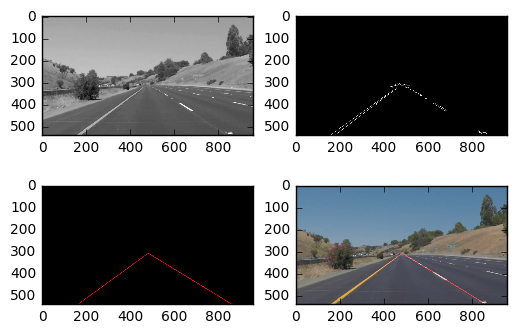

In [260]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

In [261]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!

-----
#### Description of the pipeline
1. Convert image to Grayscale
2. Apply Gaussian Smoothing
    - used kernel_size=5 
3. Canny Edge Detection. 
    - Convert image to gradient, where the brightness of each pixel corresponds to the strength of the gradient at that point. The strength of an edge is determined by how different the values are in adjacent pixels in the image.
    - Tracing out the pixels with the strongest gradients we define the edges. 
4. Region Masking
    - Only consider pixels for color selection in the region where we expect to find the lane lines.
    - Used as region: [(0,imshape[0]),(480, 295), (480, 295), (imshape[1],imshape[0])]
5. Hough Transform and draw lines
    - Define Hough parameters. 
    - With the Hough lines, separate those with positive slope (left lane) from those with negative slope (right lane).
    - Apply the following to both the positive and negative slopes:
        - To remove noise, I take those lanes with a length greater than 50 pixels. Add both the slope and intercepts of those lanes into an array.
        - If the arrya is empty, go thorugh the Hough lines again and add at least one pair of points. 
    - Fit a line to the points belonging to the left lane and fit another line to the points belongint to the right lane, using find_line_fit. 
        - Save the intercept and coefficient of the fitted lines. 
        - If there is only one slope and intercept, return those.
        - Remove noise: remove points with slope not within 1.5 standard deviations of the mean.
        - Take the estimate of the slope and intercept to be that of the remaining values.
    - Calculate where the lane lines intersect.
    - Draw the lines from the intersection to the bottom of the image. 
        

#### Potential Shortcomings and Improvements
Overall the code pipeline seem to do the work, mapping both left and right lanes in every frame. 
A few things I would consider spending time to improve the robustness of the algorithm:
- Add function to identify frame/image dimensions so these don't have to be hard coded.
- Trim lenght of the red drawn lines so that the vertice is not a fixed point. This may help the algorithms detect the lanes when there's a curve.
- Improve the algorithm to generalize in other conditions. For example, make the algorithm work when part of the road don't have any visible lanes, like in the challenge video. 




## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Slope & intercept:  [[0.620253164556962, 12.708860759493746], [0.57396449704142016, 47.082840236686366], [0.57738095238095233, 44.5], [0.62420382165605093, 7.4777070063694282], [0.061403508771929821, 618.21929824561403], [0.69911504424778759, -53.973451327433622], [0.61643835616438358, 17.191780821917746], [0.7008928571428571, -54.732142857142833], [0.16379310344827586, 309.08620689655174], [0.23076923076923078, 266.07692307692309], [0.72413793103448276, -67.310344827586221], [0.30534351145038169, 237.43511450381678]]
Slope:  0.491474664889 Intercept:  115.313566045
Slope & intercept:  [[-0.068965517241379309, 463.75862068965517], [-0.67206477732793524, 855.36032388663966], [-0.72527472527472525, 889.15384615384619], [-0.067073170731707321, 459.39634146341461], [-0.017045454545454544, 679.10227272727275], [-0.6731517509727627, 856.6536964980545], [-0.7192982456140351, 885.68421052631584], [-0.26627218934911245, 594.78698224852076], [-0.2638888888888889, 594.22222222222217], [-0.0329670


  0%|          | 0/251 [00:00<?, ?it/s]

Slope & intercept:  [[0.620253164556962, 12.708860759493746], [0.57396449704142016, 47.082840236686366], [0.57738095238095233, 44.5], [0.62420382165605093, 7.4777070063694282], [0.061403508771929821, 618.21929824561403], [0.69911504424778759, -53.973451327433622], [0.61643835616438358, 17.191780821917746], [0.7008928571428571, -54.732142857142833], [0.16379310344827586, 309.08620689655174], [0.23076923076923078, 266.07692307692309], [0.72413793103448276, -67.310344827586221], [0.30534351145038169, 237.43511450381678]]
Slope:  0.491474664889 Intercept:  115.313566045
Slope & intercept:  [[-0.068965517241379309, 463.75862068965517], [-0.67206477732793524, 855.36032388663966], [-0.72527472527472525, 889.15384615384619], [-0.067073170731707321, 459.39634146341461], [-0.017045454545454544, 679.10227272727275], [-0.6731517509727627, 856.6536964980545], [-0.7192982456140351, 885.68421052631584], [-0.26627218934911245, 594.78698224852076], [-0.2638888888888889, 594.22222222222217], [-0.0329670


  1%|          | 2/251 [00:00<00:52,  4.77it/s]

Slope & intercept:  [[0.014285714285714285, 656.87142857142862], [0.62393162393162394, 7.5213675213675515], [0.014285714285714285, 657.65714285714284], [0.57377049180327866, 46.29508196721315], [0.014598540145985401, 661.71532846715331], [0.56818181818181823, 50.18181818181813], [0.57599999999999996, 44.855999999999995], [0.65000000000000002, -16.350000000000023], [0.22772277227722773, 266.35643564356434], [0.016666666666666666, 659.0], [0.64912280701754388, -19.859649122807014], [0.62857142857142856, 5.4000000000000341], [0.20999999999999999, 274.31999999999999], [0.21649484536082475, 272.45360824742266], [0.15841584158415842, 311.41584158415844], [0.12, 659.24000000000001]]
Slope:  0.328878016507 Intercept:  283.567150245
Slope & intercept:  [[-0.72506738544474392, 888.01886792452831], [-0.67338709677419351, 856.36693548387098], [-0.26638477801268501, 595.07610993657511], [-0.068241469816272965, 462.90551181102364], [-0.070121951219512202, 460.29878048780489], [-0.032786885245901641,


  2%|▏         | 4/251 [00:00<00:50,  4.89it/s]

Slope & intercept:  [[0.013071895424836602, 663.15686274509801], [0.30769230769230771, 235.07692307692307], [0.061403508771929821, 618.21929824561403], [0.62396694214876036, 4.4132231404958588], [0.624, 3.1360000000000241], [0.75141242937853103, -91.627118644067764], [0.19607843137254902, 288.86274509803923], [0.22580645161290322, 268.87096774193549], [0.17000000000000001, 304.44999999999999], [0.12962962962962962, 657.35185185185185]]
Slope:  0.26129435185 Intercept:  338.170874656
Slope & intercept:  [[-0.069230769230769235, 463.73846153846154], [-0.72506738544474392, 890.544474393531], [-0.013953488372093023, 677.20000000000005], [-0.26638477801268501, 595.54334038054969], [-0.070028011204481794, 461.19887955182071], [-0.65384615384615385, 852.38461538461536], [-0.72580645161290325, 890.40322580645159], [-0.2696629213483146, 600.85393258426961], [-0.65037593984962405, 847.54135338345861], [-0.27016129032258063, 600.29838709677415], [-0.034090909090909088, 693.875], [-0.2674418604651


  2%|▏         | 6/251 [00:01<00:48,  5.07it/s]

Slope & intercept:  [[0.64814814814814814, -15.851851851851848], [0.061946902654867256, 618.32743362831854], [0.67647058823529416, -32.441176470588289], [0.64942528735632188, -15.919540229885058], [0.6489795918367347, -17.844897959183697], [0.15789473684210525, 311.10526315789474]]
Slope:  0.473810875846 Intercept:  141.229205046
Slope & intercept:  [[-0.69895287958115182, 882.1047120418848], [-0.069230769230769235, 464.66923076923075], [-0.070129870129870125, 462.23116883116882], [-0.26839826839826841, 598.41125541125541], [-0.69895287958115182, 882.80366492146595], [-0.67407407407407405, 861.237037037037], [-0.67045454545454541, 858.97727272727275], [-0.26900584795321636, 602.98830409356719], [-0.035714285714285712, 690.07142857142856], [-0.27586206896551724, 604.44827586206895], [-0.26890756302521007, 597.70588235294122], [-0.69999999999999996, 881.79999999999995], [-0.064864864864864868, 705.5081081081081], [-0.053475935828877004, 452.48663101604279], [-0.065326633165829151, 704.70


  3%|▎         | 8/251 [00:01<00:47,  5.15it/s]

Slope & intercept:  [[0.014563106796116505, 657.47572815533977], [0.64824120603015079, -11.321608040200999], [0.62447257383966248, 1.4641350210970359], [0.015748031496062992, 655.7874015748032], [0.6271186440677966, 0.76271186440681049], [0.6740947075208914, -32.440111420612823], [0.2072072072072072, 281.39639639639643], [0.36206896551724138, 188.5], [0.1875, 295.0625]]
Slope:  0.373446049164 Intercept:  226.298572617
Slope & intercept:  [[-0.72394366197183102, 895.04225352112678], [-0.67435897435897441, 861.68205128205136], [-0.72486772486772488, 894.6613756613757], [-0.069767441860465115, 464.32558139534882], [-0.28539325842696628, 608.06966292134825], [-0.070866141732283464, 461.53543307086613], [-0.069053708439897693, 464.61381074168798], [-0.2857142857142857, 607.57142857142856], [-0.28363636363636363, 603.66909090909087], [-0.06933333333333333, 461.5333333333333], [-0.67321867321867324, 862.7297297297298], [-0.034883720930232558, 694.16279069767438], [-0.034482758620689655, 689.4


  4%|▎         | 9/251 [00:01<00:49,  4.86it/s]

Slope & intercept:  [[0.033333333333333333, 641.73333333333335], [0.62127659574468086, 4.2595744680850771], [0.65098039215686276, -14.278431372549051], [0.64960629921259838, -12.397637795275557], [0.60071942446043169, 21.345323741007178], [0.20689655172413793, 282.20689655172413], [0.23214285714285715, 268.32142857142856]]
Slope:  0.427850779111 Intercept:  170.170069643
Slope & intercept:  [[-0.068877551020408156, 463.62755102040819], [-0.69747899159663862, 872.62184873949582], [-0.72554347826086951, 896.58423913043475], [-0.014285714285714285, 677.34285714285716], [-0.034883720930232558, 694.09302325581393], [-0.2857142857142857, 607.85714285714289], [-0.068062827225130892, 460.57591623036649], [-0.28229665071770332, 602.97129186602865], [-0.069148936170212769, 460.33510638297872], [-0.64814814814814814, 856.40740740740739], [-0.7277227722772277, 895.56930693069307], [-0.72602739726027399, 896.17808219178085], [-0.2857142857142857, 603.42857142857144], [-0.6966292134831461, 873.0], [


  4%|▍         | 10/251 [00:02<00:48,  4.93it/s]

 [[0.017241379310344827, 658.48275862068965], [0.59937888198757761, 22.583850931677034], [0.65064102564102566, -14.698717948717956], [0.016393442622950821, 655.18032786885249], [0.6472491909385113, -10.588996763754039], [0.061403508771929821, 618.28070175438597], [0.20512820512820512, 283.07692307692309], [0.25, 249.25]]
Slope:  0.3059294543 Intercept:  307.695855943
Slope & intercept:  [[-0.75301204819277112, 908.95180722891564], [-0.28602150537634408, 608.48602150537636], [-0.28270042194092826, 603.3502109704641], [-0.69827586206896552, 873.93103448275861], [-0.068702290076335881, 464.50381679389312], [-0.068241469816272965, 460.6325459317585], [-0.75, 905.0], [-0.01507537688442211, 677.748743718593], [-0.068100358422939072, 463.6559139784946], [-0.033557046979865772, 693.55704697986573], [-0.59880239520958078, 823.59281437125742], [-0.28633405639913234, 609.2581344902386], [-0.75135135135135134, 907.40540540540542], [-0.071052631578947367, 460.66578947368419], [-0.74820143884892087,


  4%|▍         | 11/251 [00:02<00:47,  5.02it/s]

 [[0.62295081967213117, 11.393442622950829], [0.59948320413436695, 23.718346253229981], [0.60103626943005184, 20.761658031088075], [0.6228813559322034, 9.4533898305084563], [0.061946902654867256, 618.69911504424783], [0.33884297520661155, 207.98347107438019], [0.063063063063063057, 616.90990990990986], [0.19327731092436976, 291.29411764705884], [0.18699186991869918, 296.0569105691057], [0.62465753424657533, 8.4630136986301636], [0.265625, 258.484375], [0.29999999999999999, 241.40000000000001], [0.62445414847161573, 9.288209606986868]]
Slope:  0.392708496435 Intercept:  201.069689176
Slope & intercept:  [[-0.69946808510638303, 876.65425531914889], [-0.26751592356687898, 600.16560509554142], [-0.75287356321839083, 909.86206896551721], [-0.069053708439897693, 464.61381074168798], [-0.071052631578947367, 462.52368421052631], [-0.69711538461538458, 873.91826923076928], [-0.27007299270072993, 598.62773722627742], [-0.2857142857142857, 610.0], [-0.068027210884353748, 465.29931972789115], [-0.


  5%|▍         | 12/251 [00:02<00:49,  4.87it/s]

[[-0.69946808510638303, 875.25531914893622], [-0.75287356321839083, 909.10919540229884], [-0.26989619377162632, 601.05882352941171], [-0.032967032967032968, 693.31868131868134], [-0.033505154639175257, 443.95618556701032], [-0.069767441860465115, 462.04651162790697], [-0.26794258373205743, 597.06698564593307], [-0.034482758620689655, 689.41379310344826], [-0.28846153846153844, 609.94230769230774], [-0.7007299270072993, 882.97810218978111], [-0.069230769230769235, 464.66923076923075], [-0.36538461538461536, 677.86538461538464], [-0.24074074074074073, 587.92592592592587], [-0.23684210526315788, 589.42105263157896], [-0.17599999999999999, 544.67200000000003], [-0.77830188679245282, 921.90566037735857], [-0.67432950191570884, 864.33716475095787], [-0.069148936170212769, 459.2659574468085], [-0.67500000000000004, 870.85000000000002], [-0.13432835820895522, 820.56716417910445], [-0.25362318840579712, 592.52898550724638], [-0.51515151515151514, 772.030303030303], [-0.053763440860215055, 466.1


  5%|▌         | 13/251 [00:02<00:48,  4.95it/s]

Slope & intercept:  [[0.62416107382550334, 7.8993288590604607], [0.014925373134328358, 657.20895522388059], [0.57763975155279501, 43.639751552795019], [0.57711442786069655, 41.99502487562188], [0.57407407407407407, 46.388888888888914], [0.625, 6.125], [0.55487804878048785, 63.634146341463406], [0.32258064516129031, 215.45161290322582], [0.62303664921465973, 5.1256544502617771], [0.17460317460317459, 302.33333333333337], [0.21311475409836064, 280.13114754098365], [0.015384615384615385, 656.10769230769233], [0.18032786885245902, 297.86885245901641], [0.33333333333333331, 212.33333333333337]]
Slope:  0.386440984991 Intercept:  202.588765862
Slope & intercept:  [[-0.69841269841269837, 874.96825396825398], [-0.069767441860465115, 463.90697674418607], [-0.72499999999999998, 896.70000000000005], [-0.28621908127208479, 604.2402826855124], [-0.0703125, 461.2890625], [-0.30333333333333334, 613.73333333333335], [-0.034313725490196081, 689.47549019607845], [-0.03125, 693.5], [-0.065868263473053898


  6%|▌         | 15/251 [00:03<00:50,  4.65it/s]

Slope & intercept:  [[0.017341040462427744, 658.41040462427748], [0.62790697674418605, 0.37209302325584304], [0.62413793103448278, 2.4965517241379303], [0.57471264367816088, 42.0], [0.012903225806451613, 657.29032258064512], [0.56000000000000005, 59.71999999999997], [0.60084033613445376, 14.789915966386559], [0.55000000000000004, 70.099999999999909], [0.0625, 617.0625], [0.34057971014492755, 206.69565217391303], [0.60344827586206895, 26.103448275862092], [0.52238805970149249, 99.208955223880594], [0.13740458015267176, 327.55725190839695], [0.26277372262773724, 261.22627737226276], [0.70053475935828879, -51.422459893048142]]
Slope:  0.41316475078 Intercept:  199.440727532
Slope & intercept:  [[-0.69889502762430944, 874.79834254143645], [-0.75297619047619047, 908.38690476190482], [-0.069148936170212769, 462.781914893617], [-0.7016574585635359, 875.14917127071817], [-0.28717948717948716, 602.77435897435896], [-0.28608247422680411, 606.78608247422676], [-0.071999999999999995, 460.896000000


  6%|▋         | 16/251 [00:03<00:52,  4.46it/s]

Slope & intercept:  [[0.014563106796116505, 657.46116504854365], [0.65017667844522964, -17.056537102473499], [0.015384615384615385, 656.04615384615386], [0.69849246231155782, -49.793969849246253], [0.67368421052631577, -36.884210526315769], [0.18045112781954886, 301.17293233082705]]
Slope:  0.372125366881 Intercept:  251.824255625
Slope & intercept:  [[-0.75147928994082835, 908.18934911242604], [-0.69905956112852663, 875.14420062695922], [-0.071999999999999995, 463.68000000000001], [-0.2857142857142857, 602.28571428571433], [-0.2857142857142857, 606.14285714285711], [-0.032432432432432434, 687.98378378378379], [-0.069892473118279563, 459.36559139784947], [-0.033333333333333333, 693.56666666666672], [-0.70175438596491224, 874.85964912280701], [-0.75223880597014925, 909.42388059701489], [-0.29268292682926828, 608.73170731707319], [-0.19480519480519481, 555.24675324675331], [-0.28187919463087246, 601.26845637583892], [-0.037249283667621778, 444.10601719197706], [-0.067114093959731544, 459


  7%|▋         | 17/251 [00:03<00:50,  4.62it/s]

Slope & intercept:  [[0.62553191489361704, 1.8127659574467998], [0.074999999999999997, 605.25], [0.67420814479638014, -35.850678733031714], [0.15652173913043479, 309.46086956521737]]
Slope:  0.382815449705 Intercept:  220.168239197
Slope & intercept:  [[-0.75211267605633803, 908.12957746478878], [-0.70168067226890751, 874.46218487394958], [-0.068421052631578952, 461.62105263157895], [-0.2857142857142857, 601.57142857142856], [-0.28448275862068967, 604.75], [-0.070270270270270274, 459.48648648648651], [-0.042857142857142858, 694.94285714285718], [-0.69999999999999996, 874.39999999999998], [-0.28517110266159695, 605.75285171102666], [-0.032000000000000001, 687.00800000000004], [-0.21428571428571427, 565.57142857142856], [-0.74561403508771928, 905.12280701754389], [-0.068181818181818177, 459.04545454545456], [-0.4065040650406504, 703.39837398373982], [-0.69736842105263153, 874.56578947368416], [-0.034985422740524783, 442.51020408163265], [-0.094117647058823528, 716.76470588235293], [-0.27


  8%|▊         | 19/251 [00:03<00:48,  4.79it/s]

Slope & intercept:  [[0.57751937984496127, 42.488372093023258], [0.061946902654867256, 617.83185840707961], [0.58490566037735847, 42.830188679245282], [0.28676470588235292, 252.22794117647061], [0.65019011406844107, -18.212927756653983], [0.20000000000000001, 290.0], [0.10833333333333334, 601.57500000000005], [0.17266187050359713, 306.64748201438852]]
Slope:  0.330290245833 Intercept:  266.923489327
Slope & intercept:  [[-0.77419354838709675, 915.16129032258061], [-0.06860158311345646, 462.6094986807388], [-0.72511848341232232, 884.85781990521332], [-0.75297619047619047, 909.13988095238096], [-0.032967032967032968, 693.35164835164835], [-0.052307692307692305, 450.24923076923079], [-0.015544041450777202, 678.02072538860102], [-0.75330396475770922, 908.0881057268723], [-0.2687224669603524, 595.79735682819387], [-0.27329192546583853, 601.08695652173913], [-0.27192982456140352, 597.64912280701753], [-0.26470588235294118, 598.58823529411768], [-0.59999999999999998, 821.79999999999995], [-0.


  8%|▊         | 20/251 [00:04<00:49,  4.65it/s]

Slope & intercept:  [[0.014423076923076924, 657.625], [0.64794007490636707, -8.3408239700374907], [0.6223776223776224, 5.6853146853146654], [0.015267175572519083, 656.20610687022895], [0.67391304347826086, -30.956521739130437], [0.068047337278106509, 380.12130177514791], [0.6740947075208914, -32.136490250696397], [0.081081081081081086, 629.35135135135135], [0.33333333333333331, 212.33333333333337]]
Slope:  0.347830828052 Intercept:  274.432063562
Slope & intercept:  [[-0.7535410764872521, 909.30878186968835], [-0.72192513368983957, 883.25133689839572], [-0.06860158311345646, 463.5408970976253], [-0.2857142857142857, 606.28571428571433], [-0.27155172413793105, 597.46982758620686], [-0.051671732522796353, 450.75683890577506], [-0.67555555555555558, 862.48888888888882], [-0.28528528528528529, 606.8468468468468], [-0.051948051948051951, 697.79220779220782], [-0.03482587064676617, 689.60199004975129], [-0.2709677419354839, 597.92258064516125], [-0.051020408163265307, 454.22448979591837], [-


  8%|▊         | 21/251 [00:04<00:50,  4.56it/s]

Slope & intercept:  [[0.018518518518518517, 654.12962962962968], [0.61904761904761907, 15.238095238095241], [0.57751937984496127, 43.724806201550393], [0.57692307692307687, 45.26923076923083], [0.64968152866242035, -14.961783439490432], [0.624, 12.024000000000001], [0.2857142857142857, 256.57142857142856], [0.27777777777777779, 260.77777777777777], [0.18978102189781021, 296.5985401459854]]
Slope:  0.424329245376 Intercept:  174.374636099
Slope & intercept:  [[-0.7528089887640449, 909.33707865168537], [-0.70036101083032487, 874.33574007220216], [-0.28260869565217389, 604.97826086956525], [-0.69973890339425593, 875.32898172323758], [-0.032258064516129031, 688.64516129032256], [-0.052083333333333336, 454.5625], [-0.28402366863905326, 606.32544378698231], [-0.2857142857142857, 602.0], [-0.051873198847262249, 450.48126801152739], [-0.053571428571428568, 455.98214285714283], [-0.28368794326241137, 601.87234042553189], [-0.014285714285714285, 689.24285714285713], [-0.26851851851851855, 595.73


  9%|▉         | 22/251 [00:04<00:52,  4.37it/s]

Slope & intercept:  [[0.59999999999999998, 32.0], [0.57668711656441718, 44.453987730061328], [0.014492753623188406, 660.84057971014488], [0.028571428571428571, 676.48571428571427], [0.67407407407407405, -34.014814814814827], [0.076923076923076927, 603.46153846153845], [0.57396449704142016, 44.568047337278074], [0.10270270270270271, 355.23243243243246], [0.57859531772575246, 42.020066889632119], [0.46808510638297873, 101.44680851063828], [0.323943661971831, 221.11267605633802]]
Slope:  0.365276339598 Intercept:  249.782457873
Slope & intercept:  [[-0.7535410764872521, 907.55524079320116], [-0.070844686648501368, 463.31607629427793], [-0.69999999999999996, 873.0], [-0.030674846625766871, 692.20858895705521], [-0.067307692307692304, 459.03846153846155], [-0.69916434540389971, 873.87186629526468], [-0.28363636363636363, 605.25454545454545], [-0.032786885245901641, 687.04918032786884], [-0.28310502283105021, 601.13698630136992], [-0.087412587412587409, 466.14685314685312], [-0.2861111111111


  9%|▉         | 23/251 [00:04<00:51,  4.39it/s]

Slope & intercept:  [[0.60079840319361277, 23.532934131736511], [0.62408759124087587, 11.722627737226333], [0.033783783783783786, 642.33783783783781], [0.016304347826086956, 655.97826086956525], [0.5977653631284916, 25.631284916201139], [0.64655172413793105, -10.931034482758605], [0.19285714285714287, 295.56428571428569], [0.068493150684931503, 379.72602739726028], [0.64761904761904765, -8.0285714285714675], [0.38518518518518519, 171.05185185185186]]
Slope:  0.381344573966 Intercept:  218.658550454
Slope & intercept:  [[-0.70078740157480313, 874.2125984251968], [-0.75375375375375375, 908.6186186186186], [-0.051546391752577317, 454.39175257731961], [-0.27325581395348836, 598.12209302325584], [-0.70078740157480313, 874.61417322834643], [-0.033018867924528301, 688.72641509433959], [-0.086705202312138727, 469.47976878612718], [-0.034246575342465752, 693.80136986301375], [-0.26984126984126983, 601.58730158730157], [-0.2153846153846154, 568.26153846153852], [-0.052173913043478258, 450.582608


 10%|▉         | 24/251 [00:05<00:51,  4.37it/s]

Slope & intercept:  [[0.5759162303664922, 46.099476439790578], [0.59782608695652173, 36.130434782608745], [0.57386363636363635, 49.244318181818244], [0.013793103448275862, 662.48965517241379], [0.64821428571428574, -13.348214285714278], [0.01282051282051282, 664.24358974358972], [0.62414965986394555, 9.7840136054421691], [0.19310344827586207, 296.5793103448276], [0.32258064516129031, 223.19354838709677], [0.065088757396449703, 382.2248520710059], [0.32214765100671139, 220.51006711409397], [0.19310344827586207, 295.3862068965517]]
Slope:  0.345217288804 Intercept:  239.378104871
Slope & intercept:  [[-0.75141242937853103, 907.92090395480227], [-0.7535410764872521, 907.04815864022657], [-0.69895287958115182, 874.11518324607323], [-0.051679586563307491, 454.48578811369509], [-0.050704225352112678, 449.47887323943661], [-0.28352490421455939, 601.79310344827582], [-0.049586776859504134, 696.52066115702485], [-0.2153846153846154, 568.04615384615386], [-0.051779935275080909, 451.1585760517799


 10%|▉         | 25/251 [00:05<00:49,  4.58it/s]

Point two:  (960, 564)
Coef:  -0.272633480731 Intercept:  654.261813639 intersection_x:  675.224708336
Point one:  (675, 470) Point two:  (0, 654)
Slope & intercept:  [[0.012987012987012988, 663.15584415584419], [0.625, 9.0], [0.5985130111524164, 22.71375464684013], [0.55045871559633031, 72.89908256880733], [0.580952380952381, 53.057142857142821], [0.62429378531073443, 4.4717514124293984], [0.089820359281437126, 365.61077844311376], [0.32525951557093424, 220.62629757785467], [1.0, -193.0], [0.10476190476190476, 603.52380952380952], [0.061403508771929821, 617.78947368421052], [0.027777777777777776, 677.58333333333337]]
Slope:  0.327384361106 Intercept:  300.948297109
Slope & intercept:  [[-0.72357723577235777, 883.98373983739839], [-0.28409090909090912, 601.90909090909088], [-0.75211267605633803, 907.37746478873237], [-0.069060773480662987, 462.75414364640886], [-0.75342465753424659, 908.52054794520552], [-0.72222222222222221, 882.44444444444446], [-0.049079754601226995, 696.90797546012


 11%|█         | 27/251 [00:05<00:47,  4.67it/s]

Slope & intercept:  [[0.016853932584269662, 654.50561797752812], [0.62176165803108807, 11.55440414507774], [0.625, 3.75], [0.62334217506631295, 5.8090185676392707], [0.62365591397849462, 10.279569892473091], [0.32291666666666669, 222.61458333333331], [0.6489795918367347, -16.032653061224494]]
Slope:  0.497501419738 Intercept:  127.497220122
Slope & intercept:  [[-0.28666666666666668, 601.28666666666663], [-0.052478134110787174, 455.10204081632651], [-0.7232142857142857, 882.16071428571422], [-0.050802139037433157, 449.81550802139037], [-0.77945619335347427, 917.29305135951654], [-0.032258064516129031, 687.0322580645161], [-0.035000000000000003, 692.59500000000003], [-0.2839506172839506, 601.61728395061732], [-0.051999999999999998, 453.86799999999999], [-0.65182186234817818, 851.11336032388658], [-0.71844660194174759, 880.65048543689318], [-0.12195121951219512, 510.92682926829269], [-0.23300970873786409, 577.32038834951459], [-0.77966101694915257, 918.86440677966107], [-0.02500000000000


 11%|█         | 28/251 [00:05<00:48,  4.56it/s]

Slope & intercept:  [[0.016042780748663103, 656.13903743315507], [0.62344139650872821, 5.8902743142144232], [0.32302405498281789, 221.90721649484536], [0.70270270270270274, -50.864864864864899], [0.086642599277978335, 368.01083032490976], [0.32291666666666669, 223.58333333333331], [0.62468513853904284, 4.1561712846347518]]
Slope:  0.385636477061 Intercept:  204.117428331
Slope & intercept:  [[-0.70129870129870131, 872.10389610389609], [-0.034653465346534656, 689.49009900990097], [-0.053672316384180789, 455.83898305084745], [-0.75423728813559321, 907.25423728813553], [-0.053521126760563378, 452.6788732394366], [-0.75369458128078815, 905.13300492610836], [-0.28654970760233917, 601.36842105263156], [-0.2857142857142857, 602.0], [-0.69973890339425593, 872.53002610966064], [-0.050531914893617018, 449.625], [-0.033519553072625698, 693.54189944134077], [-0.67948717948717952, 868.1025641025642], [-0.7078651685393258, 876.5393258426966], [-0.21531100478468901, 567.93301435406704], [-0.730434782


 12%|█▏        | 29/251 [00:06<00:49,  4.45it/s]

Slope & intercept:  [[0.012903225806451613, 663.24516129032259], [0.625, 3.0], [0.60057471264367812, 24.126436781609186], [0.031496062992125984, 643.25196850393695], [0.12269938650306748, 343.04294478527606], [0.44311377245508982, 121.40119760479041], [0.21153846153846154, 288.90384615384619], [0.69999999999999996, -56.099999999999966], [0.47999999999999998, 84.840000000000032]]
Slope:  0.358591735771 Intercept:  235.07906168
Slope & intercept:  [[-0.72361809045226133, 880.8241206030151], [-0.75498575498575493, 905.21082621082621], [-0.28676470588235292, 601.77941176470586], [-0.052924791086350974, 455.20612813370474], [-0.052631578947368418, 451.05263157894734], [-0.033149171270718231, 693.39226519337012], [-0.034146341463414637, 689.19512195121956], [-0.60301507537688437, 824.2261306532663], [-0.23008849557522124, 575.7610619469026], [-0.75, 904.25], [-0.1206896551724138, 509.89655172413791], [-0.052816901408450703, 454.3943661971831], [-0.65497076023391809, 847.93567251461991], [-0.


 12%|█▏        | 31/251 [00:06<00:45,  4.82it/s]

Slope & intercept:  [[0.017045454545454544, 655.3920454545455], [0.59999999999999998, 25.400000000000034], [0.59999999999999998, 26.0], [0.62043795620437958, 15.686131386861291], [0.62264150943396224, 14.132075471698158], [0.28865979381443296, 251.50515463917526], [0.12209302325581395, 343.11627906976742], [0.26666666666666666, 269.73333333333335], [0.26589595375722541, 261.63005780346822], [0.076923076923076927, 604.84615384615381]]
Slope:  0.34803634346 Intercept:  246.744123101
Slope & intercept:  [[-0.054545454545454543, 456.72727272727275], [-0.75216138328530258, 903.87896253602298], [-0.69960474308300391, 870.395256916996], [-0.69767441860465118, 870.51162790697674], [-0.2832618025751073, 600.36909871244632], [-0.050000000000000003, 451.14999999999998], [-0.032863849765258218, 688.85446009389671], [-0.69961977186311786, 871.09885931558938], [-0.052763819095477386, 456.67336683417085], [-0.23220973782771537, 578.24344569288394], [-0.017341040462427744, 688.58959537572252], [-0.532


 13%|█▎        | 33/251 [00:06<00:43,  4.98it/s]

Slope & intercept:  [[0.60090702947845809, 24.766439909297048], [0.032520325203252036, 642.41463414634143], [0.65354330708661412, -12.45669291338578], [0.67346938775510201, -28.122448979591809], [0.44387755102040816, 115.96428571428572], [0.26190476190476192, 274.40476190476193], [0.46808510638297873, 98.914893617021278], [0.28155339805825241, 256.14563106796118], [0.60045146726862297, 26.185101580135438]]
Slope:  0.446256926018 Intercept:  155.357400672
Slope & intercept:  [[-0.75362318840579712, 903.304347826087], [-0.69658119658119655, 867.89743589743591], [-0.24873096446700507, 586.29949238578683], [-0.052083333333333336, 456.1875], [-0.051948051948051951, 451.72727272727275], [-0.26884422110552764, 597.8467336683417], [-0.28947368421052633, 602.28947368421052], [-0.75, 900.0], [-0.26241134751773049, 595.16312056737593], [-0.034482758620689655, 693.93103448275861], [-0.28143712574850299, 598.56886227544908], [-0.67619047619047623, 865.83809523809532], [-0.75438596491228072, 902.280


 14%|█▍        | 35/251 [00:07<00:45,  4.77it/s]

Slope & intercept:  [[0.60131795716639214, 25.772652388797326], [0.64821428571428574, -7.8107142857143117], [0.59967051070840194, 25.95716639209229], [0.69907407407407407, -51.768518518518533], [0.075949367088607597, 605.59493670886081], [0.64800000000000002, -9.2959999999999923], [0.036423841059602648, 407.59271523178808], [0.037234042553191488, 399.85638297872339], [0.034700315457413249, 407.32176656151421], [0.62371134020618557, 16.73711340206188], [0.2846153846153846, 255.80769230769232]]
Slope:  0.389901010786 Intercept:  188.705926652
Slope & intercept:  [[-0.053521126760563378, 457.21408450704223], [-0.72598870056497178, 891.18079096045199], [-0.69729729729729728, 866.99459459459456], [-0.72727272727272729, 892.27272727272725], [-0.26865671641791045, 595.91044776119406], [-0.05181347150259067, 452.63212435233163], [-0.25, 588.25], [-0.69856459330143539, 868.72248803827756], [-0.035714285714285712, 694.64285714285711], [-0.55339805825242716, 798.1650485436893], [-0.03311258278145


 14%|█▍        | 36/251 [00:07<00:47,  4.53it/s]

Slope & intercept:  [[0.59649122807017541, 28.807017543859729], [0.60317460317460314, 23.603174603174637], [0.014814814814814815, 657.37777777777774], [0.62732919254658381, 11.167701863354068], [0.59509202453987731, 31.251533742331276], [0.67272727272727273, -30.727272727272748], [0.6012084592145015, 23.21148036253777], [0.28333333333333333, 257.26666666666665], [0.10434782608695652, 604.7652173913043], [0.034267912772585667, 407.64174454828662], [0.073529411764705885, 607.76470588235293], [0.24920127795527156, 279.16932907348246], [0.5757575757575758, 47.030303030303003], [0.625, 14.25], [0.12182741116751269, 346.91878172588832], [0.64736842105263159, 7.7947368421052374], [0.59649122807017541, 32.456140350877206], [0.28346456692913385, 256.23622047244095], [1.0, -214.0], [0.62790697674418605, 9.2790697674419107], [0.13846153846153847, 315.07692307692309]]
Slope:  0.403589753759 Intercept:  196.5170626
Slope & intercept:  [[-0.72375690607734811, 889.82320441988952], [-0.672727272727272


 15%|█▍        | 37/251 [00:07<00:49,  4.34it/s]

Slope & intercept:  [[0.59712230215827333, 28.719424460431696], [0.6015625, 36.3359375], [0.017341040462427744, 658.39306358381498], [0.60057471264367812, 23.120689655172441], [0.60162601626016265, 35.886178861788608], [0.033950617283950615, 409.41975308641975], [0.57446808510638303, 49.404255319148888], [0.59292035398230092, 31.867256637168111], [0.054455445544554455, 387.30198019801981], [0.048648648648648651, 629.03243243243242], [0.28695652173913044, 254.91304347826087], [0.28333333333333333, 256.76666666666665], [0.26126126126126126, 276.27027027027026], [0.55625000000000002, 61.3125], [0.50813008130081305, 71.146341463414615], [0.59999999999999998, 29.600000000000023], [0.57926829268292679, 45.310975609756099], [0.2857142857142857, 249.85714285714286], [0.6005586592178771, 28.536312849162016], [0.036231884057971016, 676.85507246376812], [0.57692307692307687, 57.692307692307736]]
Slope:  0.395109386587 Intercept:  204.654362147
Slope & intercept:  [[-0.67407407407407405, 857.56296


 15%|█▌        | 38/251 [00:08<00:51,  4.16it/s]

Slope & intercept:  [[0.014778325123152709, 657.30541871921184], [0.57608695652173914, 49.217391304347871], [0.651685393258427, -16.280898876404535], [0.63793103448275867, -1.3965517241380212], [0.29999999999999999, 242.40000000000001], [0.2153846153846154, 292.7076923076923], [0.58024691358024694, 44.555555555555543], [0.22680412371134021, 287.56701030927832], [1.0769230769230769, -211.53846153846155], [0.047619047619047616, 664.28571428571433], [0.58441558441558439, 42.0], [0.65000000000000002, -10.600000000000023], [1.0357142857142858, -182.00000000000006], [0.64985994397759106, -11.131652661064436], [0.58156028368794321, 45.730496453900741], [0.019607843137254902, 654.25490196078431], [0.015873015873015872, 655.66666666666663], [0.064516129032258063, 395.38709677419354], [0.65714285714285714, -19.600000000000023], [0.26126126126126126, 276.53153153153153]]
Slope:  0.374154073789 Intercept:  236.033354034
Slope & intercept:  [[-0.67307692307692313, 856.63461538461536], [-0.700265251


 16%|█▌        | 39/251 [00:08<00:51,  4.09it/s]

Slope & intercept:  [[0.014999999999999999, 657.11500000000001], [0.5730337078651685, 50.067415730337075], [0.26651480637813213, 262.92710706150342], [0.6741573033707865, -28.752808988764059], [0.64615384615384619, -12.153846153846189], [0.018808777429467086, 412.32601880877741], [0.019230769230769232, 652.67307692307691], [0.30434782608695654, 237.7391304347826], [0.64921465968586389, -11.219895287958138], [0.015267175572519083, 656.19083969465646], [0.62564102564102564, 2.5641025641025408], [0.10552763819095477, 358.80904522613065], [1.6567164179104477, -505.79104477611941], [0.77906976744186052, -58.720930232558146], [0.84210526315789469, -94.421052631578902], [0.28828828828828829, 252.47747747747749]]
Slope:  0.3881573903 Intercept:  222.508045375
Slope & intercept:  [[-0.67279411764705888, 857.23529411764707], [-0.72404371584699456, 888.45628415300553], [-0.24879227053140096, 587.90096618357484], [-0.032967032967032968, 693.41758241758237], [-0.25157232704402516, 591.3144654088050


 16%|█▌        | 40/251 [00:08<00:52,  4.00it/s]

Slope & intercept:  [[0.033333333333333333, 643.20000000000005], [0.62424242424242427, 5.1151515151515241], [0.016216216216216217, 656.9405405405405], [0.62234042553191493, 12.409574468085111], [1.0344827586206897, -177.13793103448279], [0.6992481203007519, -47.89473684210526], [0.2283464566929134, 291.66141732283461], [1.6601941747572815, -503.21359223300965], [0.83544303797468356, -88.012658227848078], [0.2868217054263566, 252.6124031007752], [0.62574850299401197, 3.0149700598802269], [0.1044776119402985, 359.56716417910445], [0.26744186046511625, 263.09302325581393], [0.84076433121019112, -92.248407643312134], [1.0, -210.0], [0.65000000000000002, -15.699999999999989]]
Slope:  0.524593785663 Intercept:  123.774700713
Slope & intercept:  [[-0.72602739726027399, 889.7397260273973], [-0.24940047961630696, 588.08153477218229], [-0.032432432432432434, 693.20000000000005], [-0.033519553072625698, 689.11731843575421], [-0.67307692307692313, 857.65384615384619], [-0.053299492385786802, 456.8


 16%|█▋        | 41/251 [00:08<00:52,  4.03it/s]

Slope & intercept:  [[0.016260162601626018, 661.18699186991864], [0.017857142857142856, 659.10714285714289], [0.62576687116564422, 3.8650306748465937], [1.0, -162.0], [0.032258064516129031, 682.19354838709683], [0.032786885245901641, 642.47540983606552], [0.62580645161290327, 3.2064516129032086], [0.80864197530864201, -72.104938271604965], [0.30275229357798167, 240.30275229357798], [0.2857142857142857, 256.57142857142856], [0.65277777777777779, -11.277777777777771], [1.0709219858156029, -209.75886524822698], [0.3604060913705584, 193.26395939086294], [0.86538461538461542, -103.38461538461542], [0.015625, 415.609375], [0.03125, 644.40625], [0.28698224852071008, 253.62130177514791], [0.84076433121019112, -85.522292993630572]]
Slope:  0.362564637304 Intercept:  273.970001115
Slope & intercept:  [[-0.67226890756302526, 856.75630252100837], [-0.24942263279445728, 588.84526558891457], [-0.72564102564102562, 890.3564102564103], [-0.054263565891472867, 458.09302325581393], [-0.03225806451612903


 17%|█▋        | 42/251 [00:09<00:50,  4.10it/s]

Slope & intercept:  [[0.015463917525773196, 656.71649484536078], [0.57894736842105265, 41.631578947368382], [0.59999999999999998, 30.0], [0.26923076923076922, 268.11538461538464], [0.574585635359116, 51.176795580110536], [0.018072289156626505, 413.82530120481925], [0.55491329479768781, 65.982658959537616], [0.64880952380952384, -15.541666666666686], [1.972972972972973, -654.89189189189187], [0.6449704142011834, -11.0], [0.53061224489795922, 40.428571428571388], [0.62466487935656834, 5.5335120643431992], [0.051359516616314202, 396.86706948640483], [0.11538461538461539, 660.03846153846155], [0.67132867132867136, -26.447552447552482], [1.1923076923076923, -271.11538461538464], [0.57396449704142016, 53.183431952662716], [0.67484662576687116, -30.521472392638032], [0.13924050632911392, 343.74683544303798]]
Slope:  0.471039025641 Intercept:  148.478889997
Slope & intercept:  [[-0.67241379310344829, 857.13793103448279], [-0.72773536895674296, 890.22137404580155], [-0.26442307692307693, 594.53


 17%|█▋        | 43/251 [00:09<00:53,  3.88it/s]

Slope & intercept:  [[0.57651245551601427, 45.0106761565836], [0.59649122807017541, 35.017543859649152], [0.047619047619047616, 630.19047619047615], [0.62436548223350252, 11.055837563451803], [0.62435233160621761, 6.935233160621749], [0.048192771084337352, 630.4457831325301], [0.8392857142857143, -84.946428571428555], [0.68000000000000005, -33.600000000000023], [0.59756097560975607, 32.841463414634177], [0.6462585034013606, -11.557823129251744], [0.57840616966580982, 42.365038560411278], [1.1550387596899225, -247.7286821705427], [0.4263565891472868, 139.17054263565893], [0.36280487804878048, 192.42987804878049], [0.67241379310344829, 0.58620689655174374], [0.036036036036036036, 401.69369369369372], [0.55128205128205132, 70.28205128205127], [0.3619047619047619, 191.25714285714287], [0.42125984251968501, 138.69291338582678], [0.14942528735632185, 551.83908045977012], [0.25, 283.75], [0.52906976744186052, 47.645348837209269], [0.62650602409638556, 9.2771084337349521], [0.23076923076923078


 18%|█▊        | 44/251 [00:09<00:49,  4.18it/s]

Slope & intercept:  [[0.015037593984962405, 661.37593984962405], [0.57547169811320753, 45.528301886792462], [0.62254901960784315, 11.666666666666686], [0.59722222222222221, 34.263888888888914], [0.57746478873239437, 43.014084507042242], [0.050228310502283102, 390.73515981735159], [0.32515337423312884, 221.01840490797545], [1.1865671641791045, -261.43283582089555], [1.6538461538461537, -481.92307692307691], [0.7239263803680982, -18.312883435582819], [0.65454545454545454, -18.545454545454561], [1.0, -197.0], [0.25, 249.0], [0.67469879518072284, -30.301204819277075], [0.92903225806451617, -121.07096774193548]]
Slope:  0.584421218552 Intercept:  72.1385071544
Slope & intercept:  [[-0.69974554707379133, 881.2290076335878], [-0.26729559748427673, 600.58805031446536], [-0.65074626865671636, 849.60298507462687], [-0.70050761421319796, 880.74111675126903], [-0.26804123711340205, 596.21649484536078], [-0.069498069498069498, 464.92664092664091], [-0.069060773480662987, 463.82596685082871], [-0.05


 18%|█▊        | 45/251 [00:09<00:47,  4.37it/s]

Slope & intercept:  [[0.57634408602150533, 44.847311827957014], [0.014084507042253521, 663.18309859154931], [0.037593984962406013, 670.07518796992485], [0.57671957671957674, 53.634920634920604], [0.59999999999999998, 32.199999999999989], [0.62444444444444447, 10.51111111111112], [0.64835164835164838, -10.098901098901138], [0.62637362637362637, 11.35164835164835], [0.64734299516908211, -7.7198067632850211], [0.67226890756302526, -31.764705882352985], [0.033333333333333333, 673.26666666666665], [0.52941176470588236, 47.352941176470608], [0.67469879518072284, -31.650602409638509], [0.029999999999999999, 645.48000000000002], [0.067796610169491525, 385.16949152542372], [1.2290076335877862, -279.32061068702285], [0.53266331658291455, 92.170854271356802], [0.52941176470588236, 93.235294117647072], [0.48447204968944102, 133.0], [0.048458149779735685, 392.86784140969161], [0.42264150943396228, 139.27547169811319], [0.24590163934426229, 287.36065573770492], [0.46341463414634149, 141.780487804878


 18%|█▊        | 46/251 [00:10<00:46,  4.37it/s]

Slope & intercept:  [[0.57640232108317213, 44.125725338491293], [0.017543859649122806, 659.17543859649118], [0.62474645030425968, 9.7444219066936739], [0.62347188264058684, 3.7334963325183139], [0.625, 11.625], [0.67364016736401677, -31.129707112970721], [0.57692307692307687, 44.615384615384642], [0.30364372469635625, 219.07287449392715], [1.0, -158.0], [1.3247863247863247, -300.02564102564099], [0.084507042253521125, 376.33802816901408], [0.050847457627118647, 390.83050847457628], [0.34418604651162793, 207.7767441860465], [0.75568181818181823, -35.125], [0.36164383561643837, 191.51780821917808], [0.02, 677.70000000000005], [0.2874493927125506, 229.46153846153845], [2.1411764705882352, -714.34117647058815], [0.59999999999999998, 33.400000000000034], [0.061946902654867256, 617.46902654867256], [0.4861111111111111, 81.5], [0.51052631578947372, 91.073684210526295]]
Slope:  0.429213570256 Intercept:  183.245248622
Slope & intercept:  [[-0.70076726342710993, 883.61636828644498], [-0.6730769


 19%|█▊        | 47/251 [00:10<00:45,  4.48it/s]

Slope & intercept:  [[0.57619047619047614, 44.64761904761906], [0.6247906197654941, 9.7236180904523053], [0.037383177570093455, 638.76635514018687], [0.068807339449541288, 387.38990825688074], [0.62250000000000005, 9.4449999999999932], [0.63043478260869568, 2.5434782608695059], [0.57943925233644855, 41.401869158878526], [0.67489711934156382, -34.156378600823075], [1.0, -196.0], [0.017751479289940829, 421.79289940828403], [0.57817109144542778, 44.306784660766937], [0.6767676767676768, -34.111111111111143], [0.57635467980295563, 43.891625615763587], [0.52941176470588236, 44.70588235294116], [0.64754098360655743, -13.721311475409891], [0.20000000000000001, 498.0], [0.64921465968586389, -10.167539267015741], [0.55434782608695654, 30.804347826086939], [0.5494505494505495, 35.516483516483504], [0.32369942196531792, 222.26589595375722], [0.36211699164345401, 191.56267409470755], [0.098039215686274508, 663.45098039215691], [1.9444444444444444, -605.83333333333337], [0.17676767676767677, 293.49


 19%|█▉        | 48/251 [00:10<00:44,  4.60it/s]

 [[0.57471264367816088, 46.264367816091976], [0.59999999999999998, 33.0], [0.58208955223880599, 41.104477611940297], [0.075949367088607597, 605.59493670886081], [0.60119047619047616, 23.22023809523813], [0.46242774566473988, 141.8092485549133], [0.32480818414322249, 221.3145780051151], [0.46494464944649444, 109.38007380073802], [0.5757575757575758, 43.303030303030255], [0.034883720930232558, 680.20930232558135], [0.64893617021276595, 19.54255319148939], [0.32552083333333331, 221.98177083333334], [0.22981366459627328, 296.31055900621118], [0.42489270386266093, 138.37339055793993], [0.36220472440944884, 186.03937007874015], [0.55494505494505497, 66.225274725274687], [0.38095238095238093, 185.1904761904762], [0.61111111111111116, 23.333333333333258], [0.65027322404371579, -9.032786885245855], [0.17333333333333334, 526.33333333333326], [0.57286432160804024, 48.336683417085396], [0.5393258426966292, 41.584269662921372], [0.42543859649122806, 140.10526315789474], [0.44134078212290501, 157.56


 20%|█▉        | 50/251 [00:10<00:44,  4.52it/s]

 181.691178424 intersection_x:  673.512940483
Point one:  (673, 466) Point two:  (960, 587)
Coef:  -0.274007062237 Intercept:  650.996107546 intersection_x:  673.512940483
Point one:  (673, 466) Point two:  (0, 650)
Slope & intercept:  [[0.59154929577464788, 43.450704225352069], [0.5539906103286385, 69.042253521126753], [0.57547169811320753, 46.830188679245282], [0.019230769230769232, 654.28846153846155], [0.57798165137614677, 42.816513761467888], [0.51041666666666663, 115.27083333333334], [0.59722222222222221, 23.833333333333371], [0.62466487935656834, 4.410187667560308], [0.62334217506631295, 7.0424403183023969], [0.34435261707988979, 205.95592286501378], [0.57345971563981046, 51.061611374407562], [0.58139534883720934, 44.069767441860449], [0.015503875968992248, 656.11627906976742], [0.22535211267605634, 471.01408450704224], [0.63157894736842102, -12.0], [0.44791666666666669, 145.19791666666666], [0.53179190751445082, 44.78612716763007], [0.36734693877551022, 183.0408163265306], [0.5


 20%|██        | 51/251 [00:11<00:46,  4.27it/s]

Slope & intercept:  [[0.34332425068119893, 207.17438692098091], [0.62, 14.600000000000023], [0.068376068376068383, 389.70085470085468], [0.64735516372795965, -13.08312342569269], [1.0, -190.0], [0.020408163265306121, 423.32653061224488], [0.10526315789473684, 368.31578947368422], [0.34412955465587042, 205.47368421052633], [0.36363636363636365, 186.54545454545453], [0.64974619289340096, -13.228426395939039], [0.52849740932642486, 43.378238341968938], [1.0, -186.0], [0.03292181069958848, 413.26337448559673], [0.44569288389513106, 120.65543071161051], [0.4838709677419355, 84.709677419354819], [1.0, -172.0], [1.0, -163.0], [0.64928909952606639, -16.18009478672991]]
Slope:  0.516806171462 Intercept:  94.6473209341
Slope & intercept:  [[-0.72651933701657456, 897.87016574585641], [-0.26819126819126821, 598.44282744282748], [-0.69724770642201839, 873.25688073394497], [-0.72661870503597126, 896.3741007194244], [-0.032085561497326207, 693.09090909090912], [-0.067385444743935305, 460.630727762803


 21%|██        | 52/251 [00:11<00:45,  4.42it/s]

Slope & intercept:  [[0.013157894736842105, 663.02631578947364], [0.017045454545454544, 655.27272727272725], [0.65020576131687247, -15.135802469135854], [0.1062992125984252, 368.46456692913387], [0.62295081967213117, 11.967213114754088], [0.38345864661654133, 183.85714285714286], [1.0, -186.0], [0.40404040404040403, 158.01010101010101], [0.36363636363636365, 188.81818181818181], [0.38571428571428573, 164.90000000000001], [1.0, -145.0], [1.0, -190.0], [0.62686567164179108, 10.373134328358219], [0.36363636363636365, 186.0], [6.3125, -2848.25], [0.59999999999999998, 31.400000000000034], [0.36243386243386244, 191.0185185185185], [0.30706521739130432, 233.77445652173915], [1.0, -148.0], [0.19786096256684493, 318.77540106951869], [0.44736842105263158, 123.10526315789474], [1.375, -344.0], [1.0, -192.0]]
Slope:  0.555760879164 Intercept:  103.119419087
Slope & intercept:  [[-0.72533333333333339, 895.072], [-0.26795580110497236, 597.58287292817681], [-0.25170068027210885, 594.34013605442181], 


 21%|██        | 53/251 [00:11<00:46,  4.23it/s]

Slope & intercept:  [[0.013888888888888888, 658.19444444444446], [0.67428571428571427, -34.680000000000007], [0.62068965517241381, 13.896551724137908], [0.57635467980295563, 49.876847290640399], [0.1038961038961039, 357.72727272727275], [0.60109289617486339, 30.469945355191271], [0.34223300970873788, 208.44417475728156], [0.67630057803468213, -38.358381502890211], [0.10666666666666667, 602.65333333333331], [0.015810276679841896, 408.67984189723319], [0.034749034749034749, 403.84169884169887], [0.50970873786407767, 118.76699029126215], [0.46391752577319589, 152.48453608247422], [0.64857142857142858, -12.611428571428576], [1.2307692307692308, -265.53846153846155], [0.071428571428571425, 609.71428571428567], [1.0, -183.0], [0.38162544169611307, 169.61130742049471], [0.32360742705570295, 222.9920424403183], [0.41818181818181815, 138.69090909090909], [0.44444444444444442, 121.55555555555557], [0.26530612244897961, 244.0612244897959]]
Slope:  0.364637951076 Intercept:  221.300557569
Slope & 


 22%|██▏       | 54/251 [00:11<00:49,  3.99it/s]

Slope & intercept:  [[0.017094017094017096, 659.42735042735046], [0.59715639810426535, 32.725118483412359], [0.59842519685039375, 25.141732283464535], [0.62222222222222223, 13.088888888888903], [0.30561797752808989, 237.39101123595503], [0.3619047619047619, 197.57142857142858], [1.234375, -262.984375], [0.017543859649122806, 658.19298245614038], [0.24727272727272728, 253.27636363636361], [0.53092783505154639, 102.14432989690721], [0.4107142857142857, 144.14285714285717], [0.57547169811320753, 49.132075471698101], [0.59999999999999998, 30.0], [1.0, -159.0], [0.051948051948051951, 392.41558441558442], [1.0, -186.0], [0.57766990291262132, 44.116504854368941], [0.24888888888888888, 281.96444444444444], [0.64945652173913049, -14.388586956521749], [0.40322580645161288, 156.95161290322582], [0.28703703703703703, 244.60185185185185], [0.36340852130325813, 186.10526315789474], [0.44525547445255476, 123.0802919708029], [0.046357615894039736, 630.61589403973505], [0.59999999999999998, 25.19999999


 22%|██▏       | 55/251 [00:12<00:52,  3.72it/s]

Slope & intercept:  [[0.014851485148514851, 657.24257425742576], [0.62068965517241381, 15.724137931034477], [0.034229828850855744, 412.32762836185822], [0.65071770334928225, -17.870813397129155], [0.64840182648401823, -14.703196347031962], [0.032608695652173912, 405.58695652173913], [0.34420289855072461, 199.48550724637681], [1.0, -135.0], [0.34259259259259262, 207.11111111111111], [0.34246575342465752, 205.82191780821918], [0.34345794392523366, 207.40420560747663], [1.2325581395348837, -258.44186046511629], [0.62195121951219512, 7.9390243902439011], [0.013157894736842105, 430.59210526315792], [0.36690647482014388, 178.46043165467626], [0.4241645244215938, 142.82262210796915], [0.65079365079365081, -18.888888888888914], [0.2847058823529412, 246.55529411764707], [0.55497382198952883, 83.036649214659661], [1.0, -182.0], [0.034482758620689655, 403.72413793103448], [0.57541899441340782, 57.184357541899431]]
Slope:  0.36319861078 Intercept:  200.502934865
Slope & intercept:  [[-0.6967213114


 22%|██▏       | 56/251 [00:12<00:53,  3.64it/s]

Slope & intercept:  [[0.016216216216216217, 656.10270270270269], [0.59952606635071093, 26.028436018957336], [0.59999999999999998, 33.200000000000045], [0.59999999999999998, 32.600000000000023], [0.070175438596491224, 392.33333333333331], [0.578125, 43.375], [0.10355987055016182, 360.95145631067959], [0.34474885844748859, 200.79223744292236], [0.018450184501845018, 406.86346863468634], [1.0, -180.0], [0.34360189573459715, 205.22037914691944], [0.5565610859728507, 61.651583710407238], [2.6142857142857143, -984.84285714285716], [0.62621359223300976, 1.1553398058252355], [0.36086956521739133, 200.15652173913043], [1.0, -152.0], [0.13840830449826991, 336.96193771626298], [0.22857142857142856, 291.1142857142857], [0.070175438596491224, 391.40350877192981], [0.34272300469483569, 203.91549295774647], [1.0, -156.0], [0.037037037037037035, 387.88888888888891], [0.46666666666666667, 123.06666666666666], [0.19642857142857142, 500.53571428571428], [0.72670807453416153, 24.248447204968954], [1.48214


 23%|██▎       | 57/251 [00:12<00:53,  3.65it/s]

Slope & intercept:  [[0.60207612456747406, 22.446366782006919], [0.60256410256410253, 30.820512820512818], [0.6018957345971564, 30.516587677725113], [0.53266331658291455, 89.899497487437202], [0.64935064935064934, -16.935064935064929], [0.4020100502512563, 158.10552763819095], [0.70238095238095233, 45.273809523809518], [0.44131455399061031, 165.88262910798122], [1.0, -149.0], [0.62790697674418605, -2.8604651162791015], [0.64000000000000001, -13.319999999999993], [0.81176470588235294, -64.847058823529437], [0.57731958762886593, 51.360824742268107], [0.21465968586387435, 319.0523560209424], [0.42105263157894735, 139.0], [0.32240437158469948, 217.43715846994533], [0.59712230215827333, 23.079136690647488], [0.59999999999999998, 25.400000000000034], [0.08771929824561403, 594.26315789473688], [1.4774774774774775, -365.59459459459458], [0.625, 1.0], [0.14093959731543623, 342.24161073825502], [0.62195121951219512, 0.085365853658515789]]
Slope:  0.515337898133 Intercept:  102.757235837
Slope & 


 23%|██▎       | 58/251 [00:13<00:52,  3.70it/s]

Slope & intercept:  [[0.625, 11.0], [0.57788944723618085, 45.155778894472405], [0.061403508771929821, 618.09649122807014], [0.57435897435897432, 48.810256410256443], [0.32441471571906355, 213.7458193979933], [0.40399002493765584, 158.45635910224439], [0.32673267326732675, 210.79207920792078], [0.65100671140939592, -17.107382550335558], [0.57815442561205277, 43.892655367231612], [0.034482758620689655, 403.06896551724139], [0.2119815668202765, 304.33179723502303], [0.016129032258064516, 417.22580645161293], [0.037344398340248962, 371.01659751037346], [0.039473684210526314, 674.06578947368416], [0.30582524271844658, 237.4368932038835], [0.44573643410852715, 122.1782945736434], [0.19444444444444445, 321.13888888888891], [0.3248259860788863, 219.97447795823666], [0.014925373134328358, 657.19402985074623], [51.200000000000003, -24228.800000000003], [0.64485981308411211, -5.3738317757009213]]
Slope:  0.319648960757 Intercept:  252.754988297
Slope & intercept:  [[-0.75346260387811637, 907.7783


 24%|██▎       | 59/251 [00:13<00:53,  3.61it/s]

Slope & intercept:  [[0.014925373134328358, 661.41791044776119], [0.019230769230769232, 651.86538461538464], [0.57499999999999996, 47.100000000000023], [0.60093896713615025, 33.366197183098564], [0.59895833333333337, 34.317708333333258], [0.014388489208633094, 418.55395683453236], [0.60240963855421692, 32.024096385542066], [0.57692307692307687, 46.153846153846189], [1.0737704918032787, -157.30327868852459], [0.26666666666666666, 268.93333333333334], [0.018115942028985508, 411.21014492753625], [0.70056497175141241, 15.146892655367253], [0.32493702770780858, 212.65239294710327], [0.015810276679841896, 384.43873517786562], [0.18823529411764706, 508.49411764705883], [0.23333333333333334, 301.30000000000001], [0.57360406091370564, 46.477157360406068], [0.10631229235880399, 366.3488372093023], [0.53072625698324027, 78.519553072625683], [0.22966507177033493, 302.39234449760767], [0.068403908794788276, 373.74918566775244], [0.068592057761732855, 390.61371841155233], [0.4033898305084746, 159.31


 24%|██▍       | 60/251 [00:13<00:53,  3.56it/s]

Slope & intercept:  [[0.57228915662650603, 51.777108433734952], [0.015873015873015872, 656.3650793650794], [0.59638554216867468, 36.439759036144608], [0.64864864864864868, -16.945945945945937], [0.62, 14.840000000000032], [0.58823529411764708, 36.294117647058783], [0.5982142857142857, 23.348214285714334], [0.6470588235294118, -9.7647058823529278], [0.55026455026455023, 69.328042328042329], [0.62222222222222223, 4.8000000000000114], [0.28205128205128205, 256.43589743589746], [0.57961783439490444, 43.394904458598717], [0.050955414012738856, 391.95541401273886], [0.26682134570765659, 263.0046403712297], [0.59748427672955973, 25.93710691823901], [0.19230769230769232, 334.38461538461536], [0.65789473684210531, -16.78947368421052], [0.027777777777777776, 687.08333333333337], [0.48623853211009177, 120.54128440366972], [0.24892703862660945, 290.68669527896998], [0.14347826086956522, 352.74347826086955], [0.57360406091370564, 60.157360406091357], [0.63793103448275867, -1.63793103448279], [0.606


 24%|██▍       | 61/251 [00:13<00:53,  3.56it/s]

Slope & intercept:  [[0.6160714285714286, 18.419642857142776], [0.57534246575342463, 46.465753424657521], [0.59946236559139787, 22.053763440860223], [0.015957446808510637, 656.32446808510633], [0.5781990521327014, 45.66824644549763], [0.59999999999999998, 22.400000000000034], [0.050675675675675678, 393.27364864864865], [0.57377049180327866, 50.016393442622984], [0.42543859649122806, 175.01754385964912], [0.073529411764705885, 608.05882352941171], [0.620253164556962, 15.037974683544348], [0.57627118644067798, 46.288135593220318], [0.38256658595641646, 173.34866828087166], [0.13750000000000001, 360.3125], [0.38333333333333336, 171.01666666666665], [0.15570934256055363, 308.1833910034602], [0.15562913907284767, 310.21523178807945], [0.65053763440860213, 44.763440860215042], [0.21212121212121213, 308.81818181818181], [0.19140625, 323.62890625], [0.15789473684210525, 308.31578947368422], [0.13865546218487396, 354.84453781512605], [0.015706806282722512, 657.31937172774872], [0.58227848101265


 25%|██▍       | 62/251 [00:14<00:52,  3.57it/s]

Slope & intercept:  [[0.59340659340659341, 27.0], [0.63636363636363635, -4.636363636363626], [0.016447368421052631, 415.97697368421052], [0.69999999999999996, -57.899999999999977], [0.075949367088607597, 604.29113924050637], [0.15853658536585366, 328.53658536585368], [0.13732394366197184, 335.16901408450701], [0.21199999999999999, 310.62400000000002], [0.24820143884892087, 255.5], [0.64851485148514854, -18.668316831683171], [0.32608695652173914, 210.91304347826087], [0.26693227091633465, 268.36254980079684], [0.19246861924686193, 317.58995815899584], [0.38405797101449274, 171.08695652173913], [0.59722222222222221, 26.791666666666686], [0.65024630541871919, -17.561576354679801], [0.15737704918032788, 307.8360655737705], [0.15838509316770186, 308.43788819875778], [0.17669172932330826, 332.62030075187971], [0.24793388429752067, 274.07438016528926], [0.21518987341772153, 310.35443037974682], [0.14166666666666666, 357.76666666666665], [0.62666666666666671, -9.8266666666667106], [0.192307692


 25%|██▌       | 63/251 [00:14<00:53,  3.54it/s]

Slope & intercept:  [[0.01680672268907563, 659.77310924369749], [0.28507795100222716, 253.11804008908686], [0.64628820960698685, -15.611353711790343], [0.32752613240418116, 211.85365853658539], [0.64978902953586493, -19.464135021097036], [0.22846441947565543, 301.95505617977528], [0.15953307392996108, 347.26070038910507], [0.019169329073482427, 410.4664536741214], [0.25, 294.0], [2.75, -1022.0], [0.23106060606060605, 299.57954545454544], [0.70063694267515919, -52.611464968152859], [0.44390243902439025, 166.01463414634145], [73.666666666666671, -36235.666666666672], [0.17624521072796934, 333.37931034482756], [0.22857142857142856, 267.74285714285713], [3.7692307692307692, -1505.7692307692307], [0.64948453608247425, -12.896907216494867], [0.071428571428571425, 609.78571428571433], [0.51111111111111107, 60.488888888888937]]
Slope:  0.637596130665 Intercept:  83.529730352
Slope & intercept:  [[-0.72679045092838201, 894.31564986737408], [-0.69767441860465118, 870.58139534883719], [-0.2847826


 25%|██▌       | 64/251 [00:14<00:51,  3.62it/s]

Slope & intercept:  [[0.59782608695652173, 22.195652173913061], [0.23076923076923078, 300.53846153846155], [0.17482517482517482, 303.52447552447552], [0.30081300813008133, 238.60162601626016], [0.032163742690058478, 404.61695906432749], [0.67073170731707321, -31.329268292682968], [0.017730496453900711, 379.31560283687941], [0.46601941747572817, 151.34951456310679], [0.19402985074626866, 327.79104477611941], [0.074999999999999997, 605.17499999999995], [5.666666666666667, -2417.3333333333335], [1.0, -156.0], [0.34519572953736655, 196.07829181494662], [0.21292775665399238, 314.72623574144484], [0.052264808362369339, 367.29616724738673], [0.28971962616822428, 239.82242990654208], [0.17796610169491525, 345.0169491525424], [0.6211180124223602, 2.7888198757764258], [0.14184397163120568, 314.8581560283688], [0.19354838709677419, 331.29032258064512], [0.17786561264822134, 338.94466403162056], [0.052631578947368418, 360.73684210526318]]
Slope:  0.286904300025 Intercept:  255.111330795
Slope & in


 26%|██▌       | 65/251 [00:15<00:50,  3.71it/s]

Slope & intercept:  [[0.012422360248447204, 663.70807453416148], [0.65000000000000002, -19.300000000000011], [0.19393939393939394, 287.0363636363636], [0.061403508771929821, 617.85087719298247], [0.46543778801843316, 157.91244239631337], [0.6262626262626263, -0.93939393939393767], [0.63461538461538458, -6.3461538461538112], [0.61363636363636365, 16.0], [0.30448717948717946, 226.94230769230771], [0.32432432432432434, 221.0], [0.32598039215686275, 212.78431372549019], [0.32203389830508472, 223.45762711864407], [0.30504587155963303, 238.76146788990826], [0.12267657992565056, 331.70260223048325], [8.1785714285714288, -3566.4642857142858], [0.62254901960784315, 6.9117647058823763], [0.052795031055900624, 376.57142857142856], [0.32954545454545453, 209.93181818181819], [0.032786885245901641, 406.8360655737705]]
Slope:  0.333330114539 Intercept:  231.712311426
Slope & intercept:  [[-0.67368421052631577, 861.17894736842106], [-0.65116279069767447, 849.62790697674427], [-0.72702702702702704, 894


 26%|██▋       | 66/251 [00:15<00:52,  3.55it/s]

Slope & intercept:  [[0.65022421524663676, -20.143497757847513], [0.34265734265734266, 206.42657342657344], [0.075949367088607597, 605.44303797468353], [0.11987381703470032, 334.48895899053628], [0.67452830188679247, -33.698113207547181], [0.036011080332409975, 403.53185595567868], [0.15987460815047022, 307.5705329153605], [0.62612612612612617, -0.34684684684685863], [11.214285714285714, -4991.1428571428569], [0.16483516483516483, 344.85714285714289], [0.016393442622950821, 417.37704918032784], [11.35, -5125.3000000000002], [11.5, -5163.5], [0.46568627450980393, 168.20588235294116], [0.53333333333333333, 42.533333333333331]]
Slope:  0.322124422819 Intercept:  231.353825765
Slope & intercept:  [[-0.72628726287262868, 894.89701897018972], [-0.67412935323383083, 861.94776119402991], [-0.26785714285714285, 595.41071428571422], [-0.068062827225130892, 461.78010471204186], [-0.72189349112426038, 892.18343195266266], [-0.06860158311345646, 458.95250659630608], [-0.67293233082706772, 860.96240


 27%|██▋       | 67/251 [00:15<00:53,  3.45it/s]

Slope & intercept:  [[0.016759776536312849, 655.51955307262574], [0.65126050420168069, -16.155462184873954], [0.624, 0.26400000000001], [0.14052287581699346, 323.08823529411762], [0.17445482866043613, 297.39252336448601], [0.32500000000000001, 221.09999999999999], [0.17475728155339806, 300.62135922330094], [0.15648854961832062, 356.82061068702291], [0.25, 274.0], [0.32608695652173914, 213.69565217391303], [0.47457627118644069, 132.1016949152542], [0.38292682926829269, 172.80975609756098], [0.036666666666666667, 407.94666666666666], [0.42660550458715596, 184.5183486238532], [0.17627118644067796, 291.78644067796608], [0.17602996254681649, 297.76404494382024], [0.44700460829493088, 166.04608294930875], [0.21212121212121213, 315.93939393939394], [0.014814814814814815, 380.28148148148148], [0.42307692307692307, 192.26923076923077]]
Slope:  0.240786902651 Intercept:  287.983393049
Slope & intercept:  [[-0.67322834645669294, 860.7125984251968], [-0.67331670822942646, 862.08229426433923], [-0.


 27%|██▋       | 68/251 [00:15<00:51,  3.54it/s]

Slope & intercept:  [[0.60142348754448394, 19.08896797153028], [0.65217391304347827, -15.695652173913061], [0.019900497512437811, 653.70646766169159], [0.62698412698412698, 4.6984126984127101], [0.26881720430107525, 270.19354838709683], [0.59999999999999998, 19.400000000000034], [0.32283464566929132, 225.63779527559055], [0.3247863247863248, 220.95726495726495], [0.304029304029304, 239.17216117216117], [0.21818181818181817, 476.38181818181818], [0.36274509803921567, 196.12745098039215], [0.265625, 271.546875], [0.30501930501930502, 243.77220077220079], [0.4251207729468599, 186.44927536231884], [0.13975155279503104, 319.35714285714289], [0.27016129032258063, 272.28629032258067], [0.60416666666666663, 20.041666666666686], [0.016949152542372881, 654.83050847457628], [0.12121212121212122, 378.24242424242425], [0.30508474576271188, 244.86440677966101]]
Slope:  0.304211610407 Intercept:  272.892014726
Slope & intercept:  [[-0.67331670822942646, 863.42892768079798], [-0.26582278481012656, 598


 27%|██▋       | 69/251 [00:16<00:50,  3.61it/s]

Slope & intercept:  [[0.57798165137614677, 39.40366972477068], [0.620253164556962, 8.7594936708861155], [0.62179487179487181, 8.1602564102564088], [0.32413793103448274, 219.86206896551724], [0.46500000000000002, 136.47], [0.2131782945736434, 280.51550387596899], [0.32706766917293234, 222.59398496240601], [0.57920792079207917, 37.01485148514854], [0.6228070175438597, -0.10526315789473983], [3.2615384615384615, -1131.9076923076923], [0.15723270440251572, 309.79245283018867], [0.21818181818181817, 475.16363636363639], [0.28672985781990523, 245.15402843601896], [0.078125, 602.828125], [0.12142857142857143, 375.74285714285713], [0.32390745501285345, 216.50899742930591], [0.32110091743119268, 224.02752293577981], [0.12099644128113879, 373.65124555160145]]
Slope:  0.351713605083 Intercept:  222.090790096
Slope & intercept:  [[-0.72580645161290325, 896.66129032258061], [-0.26845637583892618, 595.57046979865777], [-0.67625899280575541, 864.38848920863302], [-0.068062827225130892, 461.5078534031


 28%|██▊       | 70/251 [00:16<00:50,  3.59it/s]

Slope & intercept:  [[0.014423076923076924, 657.59615384615381], [0.62471395881006864, 4.8077803203661347], [0.57692307692307687, 39.384615384615415], [0.62264150943396224, 7.4905660377358458], [0.58015267175572516, 38.083969465648863], [0.30416666666666664, 238.20416666666668], [0.6203208556149733, 9.7433155080213396], [0.34599156118143459, 208.06751054852322], [0.40701754385964911, 153.91228070175438], [0.015151515151515152, 656.30303030303025], [0.625, 3.5], [0.26666666666666666, 269.4666666666667], [0.62704918032786883, -2.176229508196684], [0.30616740088105726, 234.08370044052862], [0.30290456431535268, 237.41493775933611], [0.28666666666666668, 252.61333333333334], [0.03125, 676.96875], [0.18888888888888888, 508.76666666666665], [0.28947368421052633, 249.86842105263156], [0.1388888888888889, 303.91666666666669], [0.28749999999999998, 248.69999999999999], [67.5, -33041.0]]
Slope:  0.355331351294 Intercept:  237.938871517
Slope & intercept:  [[-0.72432432432432436, 898.399999999999


 28%|██▊       | 71/251 [00:16<00:50,  3.56it/s]

Slope & intercept:  [[0.572972972972973, 42.875675675675666], [0.016483516483516484, 655.8901098901099], [0.59090909090909094, 32.954545454545439], [0.62471910112359552, 3.5528089887640135], [0.62268518518518523, 3.8402777777777715], [0.625, 4.125], [0.052356020942408377, 411.98952879581151], [0.26652452025586354, 268.25586353944561], [0.17602996254681649, 347.68539325842698], [0.61764705882352944, 8.323529411764639], [0.140625, 319.875], [0.19428571428571428, 332.37714285714287], [0.26153846153846155, 261.38461538461536], [0.58115183246073299, 32.549738219895289], [0.30844155844155846, 227.99675324675323], [0.30496453900709219, 231.65957446808511], [0.57671957671957674, 38.206349206349216], [0.15555555555555556, 364.68888888888887], [0.30420711974110032, 228.44983818770226]]
Slope:  0.368042988789 Intercept:  200.877928066
Slope & intercept:  [[-0.69973890339425593, 878.12793733681463], [-0.031746031746031744, 692.92063492063494], [-0.72649572649572647, 899.84615384615381], [-0.725067


 29%|██▊       | 72/251 [00:17<00:50,  3.53it/s]

Slope & intercept:  [[0.57333333333333336, 40.039999999999964], [0.59999999999999998, 25.0], [0.013986013986013986, 657.15384615384619], [0.016949152542372881, 658.74576271186436], [0.57599999999999996, 38.072000000000003], [0.59848484848484851, 27.818181818181756], [0.32380952380952382, 220.79047619047617], [0.60096153846153844, 18.192307692307736], [0.57446808510638303, 42.659574468085054], [0.62, 7.160000000000025], [19.083333333333332, -8994.5833333333321], [14.285714285714286, -6685.7142857142862], [0.32505643340857787, 218.42663656884875], [0.27102803738317754, 255.77570093457945], [0.15807560137457044, 303.61168384879727]]
Slope:  0.404011735992 Intercept:  193.342013107
Slope & intercept:  [[-0.75284090909090906, 912.62784090909088], [-0.69870129870129871, 878.23896103896107], [-0.26800000000000002, 596.71199999999999], [-0.69874476987447698, 877.55230125523008], [-0.28378378378378377, 605.48648648648646], [-0.034482758620689655, 693.89655172413791], [-0.035230352303523033, 445


 29%|██▉       | 73/251 [00:17<00:49,  3.62it/s]

Slope & intercept:  [[0.014423076923076924, 657.63942307692309], [0.59722222222222221, 26.361111111111143], [0.55309734513274333, 60.548672566371692], [0.61627906976744184, 7.34883720930236], [0.5321100917431193, 82.889908256880744], [0.015151515151515152, 656.30303030303025], [0.57425742574257421, 38.297029702970349], [0.08598726114649681, 373.87261146496814], [0.62389380530973448, -1.6769911504424613], [0.625, -0.375], [0.10610932475884244, 339.04180064308684], [0.071428571428571425, 609.71428571428567], [0.59909909909909909, 22.968468468468473], [0.26651480637813213, 266.99316628701592], [0.52888888888888885, 95.231111111111119], [0.44392523364485981, 180.87850467289721], [0.24691358024691357, 284.32098765432102], [0.60256410256410253, 23.076923076923094]]
Slope:  0.394603634453 Intercept:  206.857437787
Slope & intercept:  [[-0.69870129870129871, 879.23896103896107], [-0.26785714285714285, 597.83928571428567], [-0.7528089887640449, 913.60674157303367], [-0.031914893617021274, 692.9


 29%|██▉       | 74/251 [00:17<00:51,  3.42it/s]

Slope & intercept:  [[0.018181818181818181, 657.76363636363635], [0.017341040462427744, 655.01734104046238], [0.55600000000000005, 52.607999999999947], [0.59832635983263593, 24.259414225941441], [0.15613382899628253, 362.50929368029739], [21.285714285714285, -9983.0], [18.46153846153846, -8653.8461538461524], [0.14114114114114115, 321.09609609609606], [0.59756097560975607, 23.134146341463406], [0.4206896551724138, 211.40689655172415], [0.017543859649122806, 418.12280701754383], [0.30645161290322581, 226.82258064516128]]
Slope:  0.282937029195 Intercept:  295.274021196
Slope & intercept:  [[-0.75350140056022408, 916.07843137254895], [-0.69870129870129871, 880.33506493506491], [-0.24852071005917159, 594.20710059171597], [-0.69999999999999996, 880.0], [-0.034883720930232558, 694.16279069767438], [-0.26792452830188679, 597.60377358490564], [-0.015384615384615385, 458.80000000000001], [-0.032608695652173912, 687.93478260869563], [-0.070063694267515922, 461.69426751592357], [-0.7537091988130


 30%|██▉       | 75/251 [00:17<00:51,  3.45it/s]

Slope & intercept:  [[0.016759776536312849, 655.60335195530729], [0.62313432835820892, 4.2947761194030249], [0.5795053003533569, 34.650176678445234], [11.384615384615385, -5178.0], [0.3235294117647059, 221.70588235294116], [18.125, -8384.875], [0.12171052631578948, 332.7763157894737], [0.36212624584717606, 189.28571428571431], [0.59917355371900827, 17.351239669421489]]
Slope:  1.75131931594 Intercept:  -465.291567894
Slope & intercept:  [[-0.7528089887640449, 915.86516853932585], [-0.67600000000000005, 869.65200000000004], [-0.03482587064676617, 689.60199004975129], [-0.26785714285714285, 598.5], [-0.24887892376681614, 596.2017937219731], [-0.052307692307692305, 463.09230769230771], [-0.034852546916890083, 444.71045576407505], [-0.032786885245901641, 693.27868852459017], [-0.67460317460317465, 873.07936507936506], [-0.72368421052631582, 890.6973684210526], [-0.036363636363636362, 452.45454545454544], [-0.067484662576687116, 480.76687116564415], [-0.034700315457413249, 445.6593059936908


 30%|███       | 76/251 [00:18<00:54,  3.23it/s]

Slope & intercept:  [[0.57547169811320753, 38.330188679245282], [0.061946902654867256, 618.2035398230089], [13.846153846153847, -6335.3076923076924], [0.10000000000000001, 403.60000000000002], [0.086956521739130432, 355.60869565217394], [19.75, -9137.5], [0.24897959183673468, 281.89387755102041], [0.072463768115942032, 425.0], [0.57476635514018692, 37.771028037383189], [0.066666666666666666, 595.26666666666665], [0.054726368159203981, 415.88557213930346], [0.28797468354430378, 242.64240506329116], [0.035623409669211195, 427.99491094147584]]
Slope:  0.196870542331 Intercept:  349.290625869
Slope & intercept:  [[-0.72527472527472525, 893.15384615384619], [-0.7528089887640449, 917.61797752808991], [-0.26710097719869708, 603.2833876221498], [-0.28691983122362869, 603.66244725738397], [-0.03125, 472.6875], [-0.75358166189111753, 917.10315186246419], [-0.036312849162011177, 453.40223463687153], [-0.67592592592592593, 870.60185185185185], [-0.1048951048951049, 498.68531468531467], [-0.0663507


 31%|███       | 77/251 [00:18<00:58,  2.99it/s]

Slope & intercept:  [[0.013698630136986301, 662.54794520547944], [0.014851485148514851, 657.24257425742576], [0.015873015873015872, 655.66666666666663], [0.57939914163090134, 34.454935622317578], [14.058823529411764, -6400.0588235294117], [18.615384615384617, -8534.3076923076933], [0.56000000000000005, 56.999999999999943], [0.55263157894736847, 57.499999999999943], [0.012195121951219513, 664.82926829268297], [0.10294117647058823, 343.97058823529414], [0.070422535211267609, 283.74647887323943], [0.064102564102564097, 598.26923076923072], [0.037249283667621778, 427.74498567335246]]
Slope:  0.183942230285 Intercept:  403.906606691
Slope & intercept:  [[-0.75277777777777777, 918.11388888888882], [-0.70052083333333337, 882.24739583333337], [-0.054755043227665709, 465.68587896253604], [-0.69845360824742264, 883.05927835051546], [-0.033333333333333333, 693.4666666666667], [-0.033846153846153845, 446.89846153846156], [-0.24894514767932491, 593.49367088607596], [-0.072164948453608241, 484.38144


 31%|███       | 78/251 [00:18<00:57,  3.00it/s]

Slope & intercept:  [[0.015873015873015872, 656.3650793650794], [0.5535714285714286, 56.982142857142776], [0.55426356589147285, 55.248062015503876], [0.5714285714285714, 47.285714285714334], [0.60236220472440949, 17.330708661417304], [0.56521739130434778, 53.826086956521749], [0.013157894736842105, 660.64473684210532], [14.733333333333333, -6679.333333333333], [0.072463768115942032, 283.8840579710145], [18.75, -8531.0], [0.19540229885057472, 326.40229885057471], [0.10270270270270271, 635.17297297297296], [0.59895833333333337, 23.447916666666629], [0.59999999999999998, 18.199999999999989], [0.30409356725146197, 236.78362573099417]]
Slope:  0.365345749445 Intercept:  236.274877167
Slope & intercept:  [[-0.75277777777777777, 918.86666666666667], [-0.69845360824742264, 884.05927835051546], [-0.052805280528052806, 466.26402640264024], [-0.75304878048780488, 919.70426829268297], [-0.24853228962818003, 595.46379647749507], [-0.034055727554179564, 447.03405572755418], [-0.051359516616314202, 4


 31%|███▏      | 79/251 [00:19<00:56,  3.07it/s]

Slope & intercept:  [[0.016304347826086956, 656.04347826086962], [0.55147058823529416, 58.264705882352928], [0.54794520547945202, 67.945205479452056], [0.55208333333333337, 56.708333333333314], [0.014705882352941176, 658.22058823529414], [0.019417475728155338, 679.27184466019412], [0.054054054054054057, 292.40540540540542], [11.705882352941176, -5202.1764705882351], [0.070588235294117646, 436.42352941176472], [0.30463576158940397, 235.9271523178808], [0.44102564102564101, 161.15897435897438]]
Slope:  0.257223052492 Intercept:  330.236921735
Slope & intercept:  [[-0.75208913649025066, 918.65181058495818], [-0.72580645161290325, 895.66129032258061], [-0.0702247191011236, 467.43820224719104], [-0.17554858934169279, 560.04702194357367], [-0.10526315789473684, 499.0], [-0.05387205387205387, 467.37710437710439], [-0.085585585585585586, 490.90540540540542], [-0.032894736842105261, 688.4276315789474], [-0.12195121951219512, 541.68292682926824], [-0.75238095238095237, 919.60000000000002], [-0.0


 32%|███▏      | 80/251 [00:19<00:53,  3.22it/s]

Slope & intercept:  [[0.034883720930232558, 641.70930232558135], [0.55555555555555558, 53.666666666666629], [0.56818181818181823, 50.590909090909065], [0.017676767676767676, 442.11363636363637], [15.222222222222221, -6837.4444444444443], [15.111111111111111, -6739.8888888888887], [0.55590062111801242, 52.785714285714278], [0.064935064935064929, 597.27272727272725], [0.30434782608695654, 234.95652173913044], [0.30412371134020616, 236.06185567010311], [0.013793103448275862, 657.42758620689654], [0.55612244897959184, 54.13265306122446], [0.057692307692307696, 290.63461538461536]]
Slope:  0.27574663145 Intercept:  301.032017097
Slope & intercept:  [[-0.78097982708933722, 930.57060518731987], [-0.72533333333333339, 895.072], [-0.017994858611825194, 445.22622107969153], [-0.033707865168539325, 693.65168539325839], [-0.016949152542372881, 678.74576271186436], [-0.07179487179487179, 475.04615384615386], [-0.2667946257197697, 604.62380038387721], [-0.77900552486187846, 931.59668508287291], [-0.


 32%|███▏      | 81/251 [00:19<00:54,  3.14it/s]

Slope & intercept:  [[0.55466666666666664, 54.325333333333333], [0.57391304347826089, 45.434782608695627], [14.555555555555555, -6435.7777777777774], [0.54545454545454541, 62.000000000000057], [0.049645390070921988, 628.34042553191489], [15.111111111111111, -6724.7777777777774], [0.078431372549019607, 433.05882352941177], [0.59888579387186625, 20.487465181058553], [0.30412371134020616, 235.97422680412373], [0.30769230769230771, 235.30769230769229]]
Slope:  0.37660160389 Intercept:  214.366093662
Slope & intercept:  [[-0.78097982708933722, 932.35158501440924], [-0.72802197802197799, 896.85439560439556], [-0.78097982708933722, 931.57060518731987], [-0.26768642447418739, 605.52198852772472], [-0.012658227848101266, 688.91139240506334], [-0.26653696498054474, 605.84241245136184], [-0.052499999999999998, 461.32749999999999], [-0.12244897959183673, 507.36734693877554], [-0.052770448548812667, 456.67810026385223], [-0.085714285714285715, 539.71428571428567], [-0.050000000000000003, 488.25], [


 33%|███▎      | 82/251 [00:20<00:52,  3.24it/s]

Slope & intercept:  [[0.014925373134328358, 657.16417910447763], [0.53033707865168545, 76.96404494382017], [0.55376344086021501, 64.860215053763511], [0.55504587155963303, 62.339449541284409], [14.294117647058824, -6259.2941176470595], [0.55339805825242716, 54.213592233009706], [14.176470588235293, -6246.7058823529405], [0.3046875, 235.796875], [0.53149606299212604, 76.787401574803141], [0.53153153153153154, 75.216216216216196], [0.034090909090909088, 634.19318181818187]]
Slope:  0.401030647341 Intercept:  215.281683943
Slope & intercept:  [[-0.78034682080924855, 932.15028901734104], [-0.069825436408977551, 473.57605985037407], [-0.72506738544474392, 895.7196765498652], [-0.033816425120772944, 689.18357487922708], [-0.052924791086350974, 456.83008356545963], [-0.73015873015873012, 898.66666666666663], [-0.037656903765690378, 482.29707112970709], [-0.054862842892768077, 461.501246882793], [-0.26934984520123839, 608.4860681114551], [-0.053619302949061663, 454.21179624664882], [-0.0720461


 33%|███▎      | 83/251 [00:20<00:48,  3.47it/s]

Slope & intercept:  [[0.52879581151832455, 80.335078534031481], [0.55376344086021501, 65.306451612903288], [0.52941176470588236, 78.058823529411768], [0.017341040462427744, 659.35838150289021], [0.014705882352941176, 514.63235294117646], [0.53191489361702127, 76.319148936170222], [0.062992125984251968, 617.72440944881885], [14.333333333333334, -6233.3333333333339], [0.014705882352941176, 453.02941176470586], [0.053763440860215055, 437.06451612903226], [0.55675675675675673, 63.124324324324334], [0.034482758620689655, 415.20689655172413], [0.62441314553990612, 0.36150234741785425], [0.30569948186528495, 235.8497409326425]]
Slope:  0.294518955807 Intercept:  284.336233735
Slope & intercept:  [[-0.72467532467532469, 896.32987012987019], [-0.78034682080924855, 932.15028901734104], [-0.78164556962025311, 933.90822784810121], [-0.26845637583892618, 608.47651006711408], [-0.0166270783847981, 446.33729216152017], [-0.054054054054054057, 457.54054054054052], [-0.7265625, 898.3359375], [-0.031963


 33%|███▎      | 84/251 [00:20<00:50,  3.33it/s]

Slope & intercept:  [[0.5273972602739726, 80.369863013698591], [0.59829059829059827, 20.247863247863279], [0.57971014492753625, 38.797101449275374], [0.016759776536312849, 655.62011173184362], [0.53103448275862064, 77.365517241379393], [0.57553956834532372, 42.208633093525236], [0.034749034749034749, 516.27799227799233], [19.076923076923077, -8361.0], [0.18947368421052632, 333.8105263157895], [0.48749999999999999, 109.625], [13.866666666666667, -6034.9333333333334], [0.052631578947368418, 651.73684210526312], [0.01282051282051282, 661.02564102564099], [0.69868995633187769, -53.868995633187751]]
Slope:  0.358716383183 Intercept:  261.101341322
Slope & intercept:  [[-0.78034682080924855, 932.93063583815024], [-0.72594752186588918, 896.70262390670553], [-0.032608695652173912, 688.06521739130437], [-0.22839506172839505, 589.30246913580243], [-0.053864168618266976, 469.37470725995314], [-0.72702702702702704, 898.47297297297291], [-0.034482758620689655, 693.9655172413793], [-0.05111821086261


 34%|███▍      | 85/251 [00:21<00:52,  3.16it/s]

Slope & intercept:  [[0.031746031746031744, 643.19047619047615], [0.57831325301204817, 40.746987951807228], [0.10357142857142858, 407.06428571428569], [0.53278688524590168, 75.540983606557347], [0.54761904761904767, 59.857142857142776], [0.070796460176991149, 590.25663716814165], [0.031446540880503145, 644.13836477987422], [0.56818181818181823, 50.136363636363626], [14.5, -6244.5], [0.60079051383399207, 18.916996047430871], [0.036101083032490974, 529.12996389891691], [0.55828220858895705, 50.564417177914095], [0.51063829787234039, 99.531914893617056]]
Slope:  0.347522797397 Intercept:  267.422877827
Slope & intercept:  [[-0.77871148459383754, 932.96638655462186], [-0.72576177285318555, 897.09972299168976], [-0.13842482100238662, 512.62052505966585], [-0.78358208955223885, 933.70149253731347], [-0.13842482100238662, 513.58949880668251], [-0.24722222222222223, 600.23055555555561], [-0.035175879396984924, 692.7035175879397], [-0.053435114503816793, 456.8854961832061], [-0.7262872628726286

Slope & intercept:  [[0.018987341772151899, 653.80379746835445], [0.036630036630036632, 545.04029304029302], [0.070588235294117646, 531.8117647058823], [0.55208333333333337, 58.4375], [0.033057851239669422, 548.29752066115702], [0.071428571428571425, 589.5], [14.625, -6254.25], [0.57894736842105265, 35.578947368421041], [0.078125, 603.828125], [0.59627329192546585, 26.018633540372662], [0.59999999999999998, 24.400000000000034], [0.075471698113207544, 651.94339622641508]]
Slope:  0.246508429833 Intercept:  388.059998001
Slope & intercept:  [[-0.72580645161290325, 898.83870967741939], [-0.034782608695652174, 690.26956521739135], [-0.77976190476190477, 935.08333333333337], [-0.052493438320209973, 456.85039370078738], [-0.78034682080924855, 933.71098265895955], [-0.088328075709779186, 484.9116719242902], [-0.21153846153846154, 586.88461538461536], [-0.052341597796143252, 453.58677685950414], [-0.21186440677966101, 585.43220338983053], [-0.13947368421052631, 517.30526315789473], [-0.0333333


 34%|███▍      | 86/251 [00:21<00:59,  2.80it/s]

Slope & intercept:  [[0.052830188679245285, 555.32830188679247], [18.846153846153847, -8113.0769230769238], [0.53365384615384615, 71.673076923076906], [0.01680672268907563, 654.63025210084038], [0.035211267605633804, 567.15492957746483], [0.59999999999999998, 24.0], [0.055319148936170209, 557.936170212766], [0.034013605442176874, 542.63945578231289], [0.054054054054054057, 438.89189189189187], [0.050847457627118647, 557.71186440677968], [0.59999999999999998, 18.400000000000034], [0.017605633802816902, 539.28521126760563], [0.070422535211267609, 589.84507042253517], [0.017667844522968199, 541.30742049469961], [0.023529411764705882, 546.50588235294117], [0.073170731707317069, 434.85365853658539], [0.15789473684210525, 361.42105263157896]]
Slope:  0.149564199065 Intercept:  437.599014905
Slope & intercept:  [[-0.75202156334231807, 910.11051212938003], [-0.77966101694915257, 934.83050847457628], [-0.054123711340206188, 457.10309278350513], [-0.14153132250580047, 514.92111368909514], [-0.78


 35%|███▍      | 87/251 [00:21<01:01,  2.68it/s]

Slope & intercept:  [[0.016666666666666666, 659.88333333333333], [0.032967032967032968, 588.12087912087907], [0.013513513513513514, 657.60810810810813], [0.017456359102244388, 423.01246882793015], [0.035460992907801421, 563.79432624113474], [0.59829059829059827, 20.239316239316224], [0.016172506738544475, 424.46900269541777], [0.64903846153846156, -15.298076923076962], [0.30288461538461536, 237.61057692307693], [0.085714285714285715, 572.39999999999998], [0.069767441860465115, 557.1395348837209], [0.0449438202247191, 544.7303370786517], [18.111111111111111, -7729.4444444444443], [20.666666666666668, -8933.6666666666679], [0.17372881355932204, 516.38559322033893], [0.52941176470588236, 44.823529411764696], [0.15469613259668508, 352.02762430939225], [0.019801980198019802, 530.47524752475249], [0.17692307692307693, 337.09230769230771], [0.015228426395939087, 656.90355329949239]]
Slope:  0.164037027183 Intercept:  426.18987011
Slope & intercept:  [[-0.053030303030303032, 456.86363636363637


 35%|███▌      | 88/251 [00:22<01:04,  2.52it/s]

Slope & intercept:  [[0.049342105263157895, 585.74671052631584], [0.016666666666666666, 655.61666666666667], [0.034883720930232558, 585.96511627906978], [0.016666666666666666, 659.01666666666665], [0.59322033898305082, 30.983050847457662], [0.59999999999999998, 19.400000000000034], [0.04807692307692308, 584.78846153846155], [0.62831858407079644, -4.0176991150442518], [19.857142857142858, -8446.8571428571431], [0.048387096774193547, 629.4354838709678], [19.277777777777779, -8252.6111111111113], [0.04878048780487805, 588.82926829268297], [0.045454545454545456, 586.77272727272725], [0.055555555555555552, 608.5], [0.030120481927710843, 589.31927710843377], [0.030769230769230771, 585.84615384615381], [0.55331412103746402, 30.109510086455316], [0.53398058252427183, 73.456310679611647], [0.097560975609756101, 611.31707317073165], [0.016129032258064516, 569.82258064516134], [0.15254237288135594, 589.62711864406776], [0.090909090909090912, 611.90909090909088]]
Slope:  0.184533928958 Intercept: 


 36%|███▌      | 90/251 [00:23<01:05,  2.44it/s]

Slope & intercept:  [[0.052307692307692305, 622.50769230769231], [0.013513513513513514, 657.56756756756761], [0.10852713178294573, 545.09302325581393], [0.5795053003533569, 36.137809187279174], [0.054054054054054057, 618.16216216216219], [0.62222222222222223, 6.1777777777777487], [19.0, -8010.0], [0.1125, 659.58749999999998], [0.048611111111111112, 548.71527777777783], [19.111111111111111, -8118.1111111111113], [0.10188679245283019, 580.37358490566032], [0.017730496453900711, 557.57801418439715], [0.0097087378640776691, 581.32038834951459], [0.066037735849056603, 614.17924528301887], [0.035087719298245612, 630.33333333333337], [0.046153846153846156, 534.56923076923078], [0.64921465968586389, -18.062827225130889], [0.03643724696356275, 629.15384615384619]]
Slope:  0.159593641254 Intercept:  487.712101612
Slope & intercept:  [[-0.81155015197568392, 952.05775075987845], [-0.75409836065573765, 914.50819672131149], [-0.034188034188034191, 604.85470085470081], [-0.15813953488372093, 527.4883


 36%|███▋      | 91/251 [00:23<01:04,  2.47it/s]

Slope & intercept:  [[0.015503875968992248, 655.93023255813955], [0.017361111111111112, 592.94444444444446], [0.57741935483870965, 43.858064516129048], [0.57534246575342463, 38.136986301369916], [0.090909090909090912, 566.18181818181813], [0.015228426395939087, 591.93401015228426], [18.888888888888889, -7901.5555555555566], [0.018633540372670808, 579.63354037267084], [0.085501858736059477, 594.88475836431223], [19.0, -8010.0], [0.11235955056179775, 659.94382022471905], [0.15079365079365079, 557.60317460317458], [0.079365079365079361, 602.30158730158735], [0.57460317460317456, 39.812698412698467], [0.5714285714285714, 50.428571428571445], [0.12418300653594772, 560.88235294117646]]
Slope:  0.214902339812 Intercept:  438.176861415
Slope & intercept:  [[-0.75136612021857918, 912.91803278688519], [-0.015957446808510637, 678.218085106383], [-0.80938416422287385, 950.90615835777123], [-0.17590361445783131, 533.49397590361446], [-0.36202531645569619, 655.61518987341776], [-0.052763819095477386


 37%|███▋      | 92/251 [00:24<01:03,  2.51it/s]

Slope & intercept:  [[0.57636887608069165, 45.213256484149838], [0.033333333333333333, 642.36666666666667], [0.016129032258064516, 660.37096774193549], [0.57894736842105265, 35.263157894736821], [0.010752688172043012, 593.47311827956992], [0.014563106796116505, 657.4174757281553], [0.04878048780487805, 668.31707317073176], [0.19444444444444445, 584.33333333333337], [19.384615384615383, -8055.538461538461], [19.083333333333332, -7986.3333333333321], [0.040000000000000001, 617.0], [0.086956521739130432, 570.91304347826087], [0.013513513513513514, 590.68918918918916], [0.57879656160458448, 41.19484240687683], [0.19230769230769232, 585.34615384615381], [0.034482758620689655, 666.10344827586209], [0.030303030303030304, 602.93939393939399], [0.034482758620689655, 613.0], [0.59880239520958078, 23.916167664670695], [0.54878048780487809, 36.512195121951208], [0.035087719298245612, 667.9473684210526], [0.014184397163120567, 585.88652482269504], [0.59883720930232553, 22.895348837209326], [0.55681


 37%|███▋      | 93/251 [00:24<01:02,  2.51it/s]

Slope & intercept:  [[0.018957345971563982, 654.50710900473939], [0.017751479289940829, 589.28402366863907], [0.57258064516129037, 39.701612903225794], [0.57499999999999996, 45.175000000000011], [0.023622047244094488, 653.27559055118115], [0.018749999999999999, 658.03125], [0.035714285714285712, 597.67857142857144], [0.15702479338842976, 555.61983471074382], [0.10365853658536585, 550.16463414634143], [0.012500000000000001, 653.92499999999995], [0.084942084942084939, 571.89961389961388], [0.13978494623655913, 655.08602150537638], [0.57668711656441718, 34.141104294478509], [0.065789473684210523, 596.25], [0.55474452554744524, 55.591240875912433], [15.0, -6111.0], [13.833333333333334, -5639.0], [0.60050890585241734, 21.096692111959271]]
Slope:  0.222376011636 Intercept:  433.214206194
Slope & intercept:  [[-0.78034682080924855, 925.6878612716763], [-0.035335689045936397, 551.81272084805653], [-0.088082901554404139, 477.48186528497411], [-0.15789473684210525, 523.68421052631584], [-0.03086

Slope & intercept:  [[0.031914893617021274, 642.20212765957444], [0.01680672268907563, 659.72268907563023], [0.57707509881422925, 43.102766798418997], [0.57707509881422925, 41.877470355731248], [0.55072463768115942, 58.043478260869563], [0.034722222222222224, 639.97916666666663], [0.017182130584192441, 590.47422680412376], [0.019230769230769232, 653.40384615384619], [0.035294117647058823, 631.82352941176475], [0.045977011494252873, 669.05747126436779], [0.5532407407407407, 56.266203703703752], [0.082191780821917804, 414.78082191780823], [inf, -inf], [0.047619047619047616, 623.04761904761904], [16.399999999999999, -6731.3999999999996], [0.12184873949579832, 563.31092436974791], [0.53038674033149169, 47.414364640884003]]
Slope:  inf Intercept:  -inf
Slope & intercept:  [[-0.78034682080924855, 926.46820809248561], [-0.36187845303867405, 654.26243093922653], [-0.089361702127659579, 477.52340425531918], [-0.78097982708933722, 924.32276657060515], [-0.069148936170212769, 464.781914893617], [

ValueError: cannot convert float NaN to integer

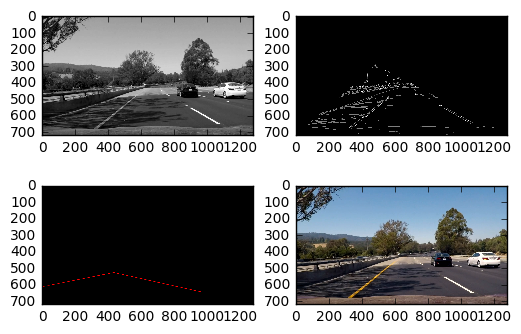

In [264]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [263]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))